# Generating new instances for the Zalando Fashion MNIST

In [1]:
%matplotlib inline

import keras
from keras.datasets import fashion_mnist
import numpy as np

from matplotlib import pyplot
from matplotlib.pyplot import imshow

Using TensorFlow backend.


In [2]:
# https://github.com/zalandoresearch/fashion-mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

('x_train shape:', (60000, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


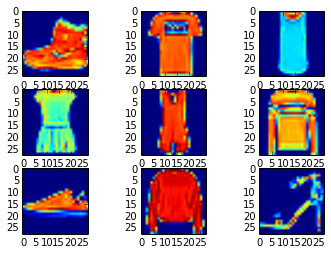

In [3]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
image_size = x_train.shape[1]

for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    imshow(x_train[i])
    imgplot = pyplot.imshow(x_train[i])

In [4]:
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
print y_train.shape
print y_test.shape

(60000,)
(10000,)


Normalize inputs to change their range from [0, 255] to [0, 1].

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

Convert the input matrix from grayscale (image_size, image_size) to single channel (image_size, image_size, 1)

In [7]:
x_train_ = np.reshape(x_train, (len(x_train), image_size, image_size, 1))
print "Reshaped train to", x_train_.shape

x_test_ = np.reshape(x_test, (len(x_test), image_size, image_size, 1))
print "Reshaped test to", x_test_.shape

Reshaped train to (60000, 28, 28, 1)
Reshaped test to (10000, 28, 28, 1)


In [8]:
input_shape = x_train_.shape[1:]
print input_shape

(28, 28, 1)


## Implementing a discriminator based on a DCNN

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose
from keras.optimizers import SGD, rmsprop, Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [14]:
discriminator = Sequential()
# stage 1
print "Creating net with input", x_train.shape[1:]
discriminator.add(Conv2D(32, (3, 3), input_shape=x_train_.shape[1:], activation='relu', padding='same'))
discriminator.add(Dropout(0.6))
# stage 2
discriminator.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.4))
# stage 3
discriminator.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.25))
# stage 4
discriminator.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.25))
# stage 5
discriminator.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Flatten())
discriminator.add(Dropout(0.25))
# stage 6
discriminator.add(Dense(1024, activation='relu'))
discriminator.add(Dropout(0.25))
# stage 7
discriminator.add(Dense(512, activation='relu'))
discriminator.add(Dropout(0.25))
# stage 8
# instead of the softmax we would use for classification we use sigmoid
#discriminator.add(Dense(num_classes, activation='softmax'))
discriminator.add(Dense(1, activation='sigmoid'))

Creating net with input (28, 28)


In [15]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [16]:
#optimizer = rmsprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss="binary_crossentropy",
                      optimizer=optimizer,
                      # optimizer = "adam",
                      metrics=["accuracy"])

## Implementing the Generator

In [17]:
generator = Sequential()
input_noise_size = 100
initial_generator_depth = 256
dim = 7
# dim is 7 as we double it progressively to 14 and then 28 over the stages
# as in https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

# stage 1 -> (dim, dim, depth)
generator.add(Dense(dim*dim*initial_generator_depth, 
                    input_dim=input_noise_size))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))
# https://github.com/keras-team/keras/issues/4534
generator.add(Reshape( (dim, dim, initial_generator_depth) ))
generator.add(Dropout(0.4))

# stage 2 -> (2dim, 2dim, depth/2)
# de-convolution: conv2dtranspose
# https://keras.io/layers/convolutional/#conv2dtranspose
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(initial_generator_depth/2, 
                              5, # kernel_size
                              padding="same"))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))

# stage 3 -> (4dim, 4dim, depth/4)
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(initial_generator_depth/4, 
                              5, # kernel_size
                              padding="same"))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))

# stage 4 ->
generator.add(Conv2DTranspose(1, 
                              5, # kernel_size
                              padding="same"))
generator.add(Activation("sigmoid"))

In [18]:
print generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
__________

## Implementing the GAN

In [19]:
#optimizer = rmsprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
optimizer = Adam(lr=0.0002, beta_1=0.5)

gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

## Training the discriminator

### Creating fake dataset instances

In [20]:
# generate random noise (of equal size compared to real data) and use the generator to create fake images
noise_train = np.random.uniform(-1.0, 1.0, size=[x_train_.shape[0], 100])
noise_test = np.random.uniform(-1.0, 1.0, size=[x_test_.shape[0], 100])

print "noise train", noise_train.shape
print "noise test", noise_test.shape

train_images_fake = generator.predict(noise_train)
test_images_fake = generator.predict(noise_test)

print "fake train images", train_images_fake.shape
print "fake test images", test_images_fake.shape

noise train (60000, 100)
noise test (10000, 100)
fake train images (60000, 28, 28, 1)
fake test images (10000, 28, 28, 1)


In [21]:
x_test_.shape[0]

10000

In [22]:
d_train_x = np.concatenate( (x_train_, train_images_fake) )
print d_train_x.shape

d_test_x = np.concatenate( (x_test_, test_images_fake) )
print d_test_x.shape

(120000, 28, 28, 1)
(20000, 28, 28, 1)


In [23]:
# create a 2*train array initially set to 1
d_train_y = np.ones([2*x_train_.shape[0], 1])
# set the second half (fake images) to 0
d_train_y[x_train_.shape[0]:, :] = 0

In [24]:
# create a 2*test array initially set to 1
d_test_y = np.ones([2*x_test_.shape[0], 1])
# set the second half (fake images) to 0
d_test_y[x_test_.shape[0]:, :] = 0

### Train the Discriminator

In [25]:
from keras.preprocessing.image import ImageDataGenerator

def get_img_generator():
    return ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

In [26]:
seed = 1234

In [27]:
np.random.seed(seed)

epochs = 1
batch_size= 64

datagen = get_img_generator()
discriminator.fit_generator(datagen.flow(d_train_x, d_train_y, batch_size=batch_size),
                    epochs=epochs,
                    shuffle=True,
                    validation_data=(d_test_x, d_test_y),
                    workers=6)

Epoch 1/1
1875/1875 [==============================] - 307s 163ms/step - loss: 0.0192 - acc: 0.9916 - val_loss: 0.0013 - val_acc: 1.0000


### Assess the discriminator performance using the test data

In [28]:
scores = discriminator.evaluate(d_test_x, d_test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 100.00%


## Training the Generator

### Create a test dataset for the GA

In [29]:
np.random.seed(seed)
# get an array of random samples to be used to test the GAN at the end of the training
test_size = 16
test_noise = np.random.uniform(-1.0, 1.0, size=[test_size, 100])

### Train the GA using random input noise

  0%|          | 0/2000 [00:00<?, ?it/s]

0: [Discriminator loss: 0.638165, acc: 0.650391]


  0%|          | 1/2000 [00:07<4:15:32,  7.67s/it]

0: [GA loss: 1.594431, acc: 0.082031]
1: [Discriminator loss: 0.599307, acc: 0.703125]


  0%|          | 2/2000 [00:15<4:12:20,  7.58s/it]

1: [GA loss: 1.582020, acc: 0.050781]
2: [Discriminator loss: 0.613721, acc: 0.691406]


  0%|          | 3/2000 [00:22<4:11:43,  7.56s/it]

2: [GA loss: 1.629898, acc: 0.054688]
3: [Discriminator loss: 0.575154, acc: 0.718750]


  0%|          | 4/2000 [00:30<4:16:10,  7.70s/it]

3: [GA loss: 1.555154, acc: 0.058594]
4: [Discriminator loss: 0.686254, acc: 0.656250]


  0%|          | 5/2000 [00:39<4:19:35,  7.81s/it]

4: [GA loss: 1.892524, acc: 0.015625]
5: [Discriminator loss: 0.622887, acc: 0.671875]


  0%|          | 6/2000 [00:47<4:21:57,  7.88s/it]

5: [GA loss: 1.541477, acc: 0.093750]
6: [Discriminator loss: 0.643753, acc: 0.650391]


  0%|          | 7/2000 [00:56<4:26:05,  8.01s/it]

6: [GA loss: 1.567889, acc: 0.101562]
7: [Discriminator loss: 0.572718, acc: 0.722656]


  0%|          | 8/2000 [01:04<4:26:07,  8.02s/it]

7: [GA loss: 1.616603, acc: 0.074219]
8: [Discriminator loss: 0.657455, acc: 0.638672]


  0%|          | 9/2000 [01:12<4:25:51,  8.01s/it]

8: [GA loss: 1.636725, acc: 0.054688]
9: [Discriminator loss: 0.538635, acc: 0.703125]


  0%|          | 10/2000 [01:20<4:25:56,  8.02s/it]

9: [GA loss: 1.480660, acc: 0.097656]
10: [Discriminator loss: 0.661190, acc: 0.640625]


  1%|          | 11/2000 [01:28<4:25:39,  8.01s/it]

10: [GA loss: 1.594511, acc: 0.082031]
11: [Discriminator loss: 0.590663, acc: 0.689453]


  1%|          | 12/2000 [01:36<4:25:21,  8.01s/it]

11: [GA loss: 1.436818, acc: 0.101562]
12: [Discriminator loss: 0.655522, acc: 0.613281]


  1%|          | 13/2000 [01:44<4:25:07,  8.01s/it]

12: [GA loss: 1.587171, acc: 0.062500]
13: [Discriminator loss: 0.610209, acc: 0.660156]


  1%|          | 14/2000 [01:51<4:24:40,  8.00s/it]

13: [GA loss: 1.458536, acc: 0.093750]
14: [Discriminator loss: 0.631706, acc: 0.634766]


  1%|          | 15/2000 [01:59<4:24:17,  7.99s/it]

14: [GA loss: 1.440808, acc: 0.062500]
15: [Discriminator loss: 0.653663, acc: 0.628906]


  1%|          | 16/2000 [02:07<4:23:56,  7.98s/it]

15: [GA loss: 1.498520, acc: 0.085938]
16: [Discriminator loss: 0.654489, acc: 0.615234]


  1%|          | 17/2000 [02:15<4:23:32,  7.97s/it]

16: [GA loss: 1.535357, acc: 0.070312]
17: [Discriminator loss: 0.597001, acc: 0.685547]


  1%|          | 18/2000 [02:23<4:23:13,  7.97s/it]

17: [GA loss: 1.529127, acc: 0.078125]
18: [Discriminator loss: 0.651299, acc: 0.650391]


  1%|          | 19/2000 [02:31<4:22:45,  7.96s/it]

18: [GA loss: 1.613153, acc: 0.050781]
19: [Discriminator loss: 0.616382, acc: 0.681641]


  1%|          | 20/2000 [02:39<4:22:22,  7.95s/it]

19: [GA loss: 1.582510, acc: 0.050781]
20: [Discriminator loss: 0.653269, acc: 0.626953]


  1%|          | 21/2000 [02:46<4:21:55,  7.94s/it]

20: [GA loss: 1.531592, acc: 0.066406]
21: [Discriminator loss: 0.650663, acc: 0.630859]


  1%|          | 22/2000 [02:54<4:21:46,  7.94s/it]

21: [GA loss: 1.424912, acc: 0.074219]
22: [Discriminator loss: 0.600339, acc: 0.656250]


  1%|          | 23/2000 [03:02<4:21:38,  7.94s/it]

22: [GA loss: 1.458766, acc: 0.082031]
23: [Discriminator loss: 0.615082, acc: 0.687500]


  1%|          | 24/2000 [03:10<4:21:22,  7.94s/it]

23: [GA loss: 1.490091, acc: 0.097656]
24: [Discriminator loss: 0.595298, acc: 0.642578]


  1%|▏         | 25/2000 [03:18<4:21:09,  7.93s/it]

24: [GA loss: 1.477842, acc: 0.097656]
25: [Discriminator loss: 0.639625, acc: 0.644531]


  1%|▏         | 26/2000 [03:26<4:20:54,  7.93s/it]

25: [GA loss: 1.568547, acc: 0.035156]
26: [Discriminator loss: 0.638382, acc: 0.638672]


  1%|▏         | 27/2000 [03:34<4:20:45,  7.93s/it]

26: [GA loss: 1.468892, acc: 0.070312]
27: [Discriminator loss: 0.647904, acc: 0.644531]


  1%|▏         | 28/2000 [03:41<4:20:33,  7.93s/it]

27: [GA loss: 1.422842, acc: 0.101562]
28: [Discriminator loss: 0.625160, acc: 0.658203]


  1%|▏         | 29/2000 [03:49<4:20:19,  7.92s/it]

28: [GA loss: 1.555607, acc: 0.062500]
29: [Discriminator loss: 0.643475, acc: 0.650391]


  2%|▏         | 30/2000 [03:57<4:20:05,  7.92s/it]

29: [GA loss: 1.526975, acc: 0.066406]
30: [Discriminator loss: 0.592704, acc: 0.671875]


  2%|▏         | 31/2000 [04:05<4:20:00,  7.92s/it]

30: [GA loss: 1.494303, acc: 0.085938]
31: [Discriminator loss: 0.697365, acc: 0.585938]


  2%|▏         | 32/2000 [04:13<4:19:56,  7.92s/it]

31: [GA loss: 1.523375, acc: 0.050781]
32: [Discriminator loss: 0.615730, acc: 0.685547]


  2%|▏         | 33/2000 [04:21<4:19:45,  7.92s/it]

32: [GA loss: 1.638192, acc: 0.046875]
33: [Discriminator loss: 0.569079, acc: 0.699219]


  2%|▏         | 34/2000 [04:29<4:19:37,  7.92s/it]

33: [GA loss: 1.478305, acc: 0.085938]
34: [Discriminator loss: 0.614468, acc: 0.654297]


  2%|▏         | 35/2000 [04:37<4:19:30,  7.92s/it]

34: [GA loss: 1.458705, acc: 0.074219]
35: [Discriminator loss: 0.631738, acc: 0.646484]


  2%|▏         | 36/2000 [04:45<4:19:21,  7.92s/it]

35: [GA loss: 1.595458, acc: 0.066406]
36: [Discriminator loss: 0.661679, acc: 0.634766]


  2%|▏         | 37/2000 [04:53<4:19:13,  7.92s/it]

36: [GA loss: 1.569054, acc: 0.058594]
37: [Discriminator loss: 0.599541, acc: 0.683594]


  2%|▏         | 38/2000 [05:01<4:19:06,  7.92s/it]

37: [GA loss: 1.458131, acc: 0.066406]
38: [Discriminator loss: 0.613342, acc: 0.650391]


  2%|▏         | 39/2000 [05:09<4:19:03,  7.93s/it]

38: [GA loss: 1.467458, acc: 0.046875]
39: [Discriminator loss: 0.658672, acc: 0.636719]


  2%|▏         | 40/2000 [05:17<4:19:20,  7.94s/it]

39: [GA loss: 1.561517, acc: 0.050781]
40: [Discriminator loss: 0.588844, acc: 0.673828]


  2%|▏         | 41/2000 [05:28<4:21:22,  8.01s/it]

40: [GA loss: 1.536123, acc: 0.078125]
41: [Discriminator loss: 0.626700, acc: 0.656250]


  2%|▏         | 42/2000 [05:38<4:22:39,  8.05s/it]

41: [GA loss: 1.490656, acc: 0.078125]
42: [Discriminator loss: 0.594282, acc: 0.707031]


  2%|▏         | 43/2000 [05:47<4:23:47,  8.09s/it]

42: [GA loss: 1.424109, acc: 0.046875]
43: [Discriminator loss: 0.652036, acc: 0.625000]


  2%|▏         | 44/2000 [05:57<4:24:42,  8.12s/it]

43: [GA loss: 1.540192, acc: 0.050781]
44: [Discriminator loss: 0.579841, acc: 0.722656]


  2%|▏         | 45/2000 [06:07<4:25:48,  8.16s/it]

44: [GA loss: 1.497049, acc: 0.074219]
45: [Discriminator loss: 0.637023, acc: 0.632812]


  2%|▏         | 46/2000 [06:17<4:26:54,  8.20s/it]

45: [GA loss: 1.569773, acc: 0.035156]
46: [Discriminator loss: 0.618997, acc: 0.642578]


  2%|▏         | 47/2000 [06:26<4:27:53,  8.23s/it]

46: [GA loss: 1.532903, acc: 0.062500]
47: [Discriminator loss: 0.607769, acc: 0.667969]


  2%|▏         | 48/2000 [06:36<4:28:48,  8.26s/it]

47: [GA loss: 1.403153, acc: 0.109375]
48: [Discriminator loss: 0.668709, acc: 0.609375]


  2%|▏         | 49/2000 [06:46<4:29:41,  8.29s/it]

48: [GA loss: 1.545007, acc: 0.046875]
49: [Discriminator loss: 0.626390, acc: 0.630859]


  2%|▎         | 50/2000 [06:56<4:30:32,  8.32s/it]

49: [GA loss: 1.459225, acc: 0.062500]
50: [Discriminator loss: 0.670768, acc: 0.625000]


  3%|▎         | 51/2000 [07:05<4:31:17,  8.35s/it]

50: [GA loss: 1.444688, acc: 0.093750]
51: [Discriminator loss: 0.652030, acc: 0.660156]


  3%|▎         | 52/2000 [07:16<4:32:13,  8.38s/it]

51: [GA loss: 1.378165, acc: 0.105469]
52: [Discriminator loss: 0.602317, acc: 0.675781]


  3%|▎         | 53/2000 [07:25<4:32:52,  8.41s/it]

52: [GA loss: 1.331027, acc: 0.101562]
53: [Discriminator loss: 0.665958, acc: 0.656250]


  3%|▎         | 54/2000 [07:35<4:33:36,  8.44s/it]

53: [GA loss: 1.404723, acc: 0.085938]
54: [Discriminator loss: 0.687612, acc: 0.601562]


  3%|▎         | 55/2000 [07:45<4:34:13,  8.46s/it]

54: [GA loss: 1.502602, acc: 0.058594]
55: [Discriminator loss: 0.606491, acc: 0.664062]


  3%|▎         | 56/2000 [07:54<4:34:47,  8.48s/it]

55: [GA loss: 1.377368, acc: 0.078125]
56: [Discriminator loss: 0.641958, acc: 0.634766]


  3%|▎         | 57/2000 [08:04<4:35:16,  8.50s/it]

56: [GA loss: 1.244747, acc: 0.125000]
57: [Discriminator loss: 0.701070, acc: 0.619141]


  3%|▎         | 58/2000 [08:14<4:35:50,  8.52s/it]

57: [GA loss: 1.392638, acc: 0.078125]
58: [Discriminator loss: 0.665306, acc: 0.630859]


  3%|▎         | 59/2000 [08:24<4:36:24,  8.54s/it]

58: [GA loss: 1.385715, acc: 0.093750]
59: [Discriminator loss: 0.654584, acc: 0.621094]


  3%|▎         | 60/2000 [08:33<4:36:57,  8.57s/it]

59: [GA loss: 1.325621, acc: 0.105469]
60: [Discriminator loss: 0.642348, acc: 0.652344]


  3%|▎         | 61/2000 [08:43<4:37:24,  8.58s/it]

60: [GA loss: 1.280254, acc: 0.132812]
61: [Discriminator loss: 0.661752, acc: 0.630859]


  3%|▎         | 62/2000 [08:53<4:37:51,  8.60s/it]

61: [GA loss: 1.331399, acc: 0.121094]
62: [Discriminator loss: 0.671650, acc: 0.634766]


  3%|▎         | 63/2000 [09:03<4:38:22,  8.62s/it]

62: [GA loss: 1.272048, acc: 0.121094]
63: [Discriminator loss: 0.668561, acc: 0.628906]


  3%|▎         | 64/2000 [09:12<4:38:46,  8.64s/it]

63: [GA loss: 1.362204, acc: 0.101562]
64: [Discriminator loss: 0.694000, acc: 0.597656]


  3%|▎         | 65/2000 [09:22<4:39:13,  8.66s/it]

64: [GA loss: 1.363116, acc: 0.085938]
65: [Discriminator loss: 0.716674, acc: 0.583984]


  3%|▎         | 66/2000 [09:32<4:39:35,  8.67s/it]

65: [GA loss: 1.200343, acc: 0.183594]
66: [Discriminator loss: 0.640355, acc: 0.640625]


  3%|▎         | 67/2000 [09:42<4:39:58,  8.69s/it]

66: [GA loss: 1.199847, acc: 0.160156]
67: [Discriminator loss: 0.705178, acc: 0.570312]


  3%|▎         | 68/2000 [09:52<4:40:22,  8.71s/it]

67: [GA loss: 1.371969, acc: 0.097656]
68: [Discriminator loss: 0.628004, acc: 0.636719]


  3%|▎         | 69/2000 [10:01<4:40:45,  8.72s/it]

68: [GA loss: 1.237588, acc: 0.125000]
69: [Discriminator loss: 0.664010, acc: 0.625000]


  4%|▎         | 70/2000 [10:11<4:41:09,  8.74s/it]

69: [GA loss: 1.122048, acc: 0.179688]
70: [Discriminator loss: 0.680437, acc: 0.623047]


  4%|▎         | 71/2000 [10:21<4:41:28,  8.76s/it]

70: [GA loss: 1.227008, acc: 0.156250]
71: [Discriminator loss: 0.674135, acc: 0.617188]


  4%|▎         | 72/2000 [10:31<4:41:45,  8.77s/it]

71: [GA loss: 1.266265, acc: 0.128906]
72: [Discriminator loss: 0.689072, acc: 0.607422]


  4%|▎         | 73/2000 [10:41<4:42:05,  8.78s/it]

72: [GA loss: 1.178186, acc: 0.152344]
73: [Discriminator loss: 0.650487, acc: 0.625000]


  4%|▎         | 74/2000 [10:51<4:42:26,  8.80s/it]

73: [GA loss: 1.099938, acc: 0.210938]
74: [Discriminator loss: 0.699486, acc: 0.582031]


  4%|▍         | 75/2000 [11:01<4:42:46,  8.81s/it]

74: [GA loss: 1.115562, acc: 0.214844]
75: [Discriminator loss: 0.637031, acc: 0.626953]


  4%|▍         | 76/2000 [11:10<4:43:01,  8.83s/it]

75: [GA loss: 1.068248, acc: 0.222656]
76: [Discriminator loss: 0.669880, acc: 0.597656]


  4%|▍         | 77/2000 [11:20<4:43:17,  8.84s/it]

76: [GA loss: 1.186942, acc: 0.152344]
77: [Discriminator loss: 0.705354, acc: 0.595703]


  4%|▍         | 78/2000 [11:30<4:43:35,  8.85s/it]

77: [GA loss: 1.104348, acc: 0.199219]
78: [Discriminator loss: 0.690833, acc: 0.583984]


  4%|▍         | 79/2000 [11:40<4:43:53,  8.87s/it]

78: [GA loss: 1.107468, acc: 0.187500]
79: [Discriminator loss: 0.713019, acc: 0.560547]


  4%|▍         | 80/2000 [11:50<4:44:09,  8.88s/it]

79: [GA loss: 1.145196, acc: 0.152344]
80: [Discriminator loss: 0.691833, acc: 0.617188]


  4%|▍         | 81/2000 [12:00<4:44:24,  8.89s/it]

80: [GA loss: 1.127339, acc: 0.187500]
81: [Discriminator loss: 0.688693, acc: 0.582031]


  4%|▍         | 82/2000 [12:10<4:44:38,  8.90s/it]

81: [GA loss: 1.073262, acc: 0.230469]
82: [Discriminator loss: 0.659629, acc: 0.603516]


  4%|▍         | 83/2000 [12:20<4:44:51,  8.92s/it]

82: [GA loss: 1.007360, acc: 0.253906]
83: [Discriminator loss: 0.664326, acc: 0.611328]


  4%|▍         | 84/2000 [12:30<4:45:08,  8.93s/it]

83: [GA loss: 1.027382, acc: 0.281250]
84: [Discriminator loss: 0.726460, acc: 0.595703]


  4%|▍         | 85/2000 [12:39<4:45:18,  8.94s/it]

84: [GA loss: 1.093343, acc: 0.203125]
85: [Discriminator loss: 0.690487, acc: 0.587891]


  4%|▍         | 86/2000 [12:49<4:45:27,  8.95s/it]

85: [GA loss: 1.109753, acc: 0.207031]
86: [Discriminator loss: 0.693121, acc: 0.562500]


  4%|▍         | 87/2000 [12:59<4:45:35,  8.96s/it]

86: [GA loss: 1.162839, acc: 0.152344]
87: [Discriminator loss: 0.680823, acc: 0.591797]


  4%|▍         | 88/2000 [13:09<4:45:47,  8.97s/it]

87: [GA loss: 1.068290, acc: 0.253906]
88: [Discriminator loss: 0.715039, acc: 0.572266]


  4%|▍         | 89/2000 [13:19<4:46:01,  8.98s/it]

88: [GA loss: 1.023696, acc: 0.234375]
89: [Discriminator loss: 0.693230, acc: 0.619141]


  4%|▍         | 90/2000 [13:29<4:46:09,  8.99s/it]

89: [GA loss: 1.081943, acc: 0.218750]
90: [Discriminator loss: 0.729368, acc: 0.566406]


  5%|▍         | 91/2000 [13:38<4:46:15,  9.00s/it]

90: [GA loss: 1.096935, acc: 0.207031]
91: [Discriminator loss: 0.668581, acc: 0.609375]


  5%|▍         | 92/2000 [13:48<4:46:21,  9.01s/it]

91: [GA loss: 1.133044, acc: 0.171875]
92: [Discriminator loss: 0.672354, acc: 0.615234]


  5%|▍         | 93/2000 [13:58<4:46:32,  9.02s/it]

92: [GA loss: 1.109960, acc: 0.203125]
93: [Discriminator loss: 0.689977, acc: 0.593750]


  5%|▍         | 94/2000 [14:08<4:46:39,  9.02s/it]

93: [GA loss: 1.117955, acc: 0.195312]
94: [Discriminator loss: 0.702495, acc: 0.576172]


  5%|▍         | 95/2000 [14:18<4:46:45,  9.03s/it]

94: [GA loss: 1.096438, acc: 0.179688]
95: [Discriminator loss: 0.669795, acc: 0.603516]


  5%|▍         | 96/2000 [14:27<4:46:54,  9.04s/it]

95: [GA loss: 1.123711, acc: 0.183594]
96: [Discriminator loss: 0.671616, acc: 0.597656]


  5%|▍         | 97/2000 [14:37<4:47:01,  9.05s/it]

96: [GA loss: 1.024014, acc: 0.242188]
97: [Discriminator loss: 0.685002, acc: 0.593750]


  5%|▍         | 98/2000 [14:47<4:47:08,  9.06s/it]

97: [GA loss: 1.026362, acc: 0.210938]
98: [Discriminator loss: 0.681813, acc: 0.626953]


  5%|▍         | 99/2000 [14:57<4:47:18,  9.07s/it]

98: [GA loss: 1.018578, acc: 0.234375]
99: [Discriminator loss: 0.681388, acc: 0.591797]
99: [GA loss: 1.055809, acc: 0.238281]


  5%|▌         | 100/2000 [15:08<4:47:38,  9.08s/it]

100: [Discriminator loss: 0.696641, acc: 0.566406]


  5%|▌         | 101/2000 [15:18<4:47:40,  9.09s/it]

100: [GA loss: 1.069392, acc: 0.242188]
101: [Discriminator loss: 0.648301, acc: 0.626953]


  5%|▌         | 102/2000 [15:27<4:47:47,  9.10s/it]

101: [GA loss: 1.075802, acc: 0.187500]
102: [Discriminator loss: 0.674541, acc: 0.595703]


  5%|▌         | 103/2000 [15:38<4:47:56,  9.11s/it]

102: [GA loss: 1.113157, acc: 0.230469]
103: [Discriminator loss: 0.688262, acc: 0.578125]


  5%|▌         | 104/2000 [15:47<4:48:01,  9.11s/it]

103: [GA loss: 1.063554, acc: 0.187500]
104: [Discriminator loss: 0.715501, acc: 0.582031]


  5%|▌         | 105/2000 [15:57<4:48:03,  9.12s/it]

104: [GA loss: 1.064344, acc: 0.234375]
105: [Discriminator loss: 0.653222, acc: 0.619141]


  5%|▌         | 106/2000 [16:07<4:48:07,  9.13s/it]

105: [GA loss: 0.997231, acc: 0.273438]
106: [Discriminator loss: 0.685616, acc: 0.585938]


  5%|▌         | 107/2000 [16:17<4:48:12,  9.13s/it]

106: [GA loss: 1.038999, acc: 0.218750]
107: [Discriminator loss: 0.690917, acc: 0.597656]


  5%|▌         | 108/2000 [16:27<4:48:16,  9.14s/it]

107: [GA loss: 0.976413, acc: 0.250000]
108: [Discriminator loss: 0.665687, acc: 0.615234]


  5%|▌         | 109/2000 [16:37<4:48:19,  9.15s/it]

108: [GA loss: 1.029255, acc: 0.210938]
109: [Discriminator loss: 0.679240, acc: 0.597656]


  6%|▌         | 110/2000 [16:47<4:48:22,  9.15s/it]

109: [GA loss: 1.033434, acc: 0.210938]
110: [Discriminator loss: 0.674988, acc: 0.603516]


  6%|▌         | 111/2000 [16:56<4:48:24,  9.16s/it]

110: [GA loss: 1.030276, acc: 0.210938]
111: [Discriminator loss: 0.725273, acc: 0.544922]


  6%|▌         | 112/2000 [17:06<4:48:28,  9.17s/it]

111: [GA loss: 1.045102, acc: 0.179688]
112: [Discriminator loss: 0.663577, acc: 0.601562]


  6%|▌         | 113/2000 [17:16<4:48:31,  9.17s/it]

112: [GA loss: 1.008135, acc: 0.257812]
113: [Discriminator loss: 0.706894, acc: 0.550781]


  6%|▌         | 114/2000 [17:26<4:48:33,  9.18s/it]

113: [GA loss: 1.030871, acc: 0.242188]
114: [Discriminator loss: 0.690980, acc: 0.566406]


  6%|▌         | 115/2000 [17:36<4:48:33,  9.18s/it]

114: [GA loss: 0.999654, acc: 0.238281]
115: [Discriminator loss: 0.695927, acc: 0.591797]


  6%|▌         | 116/2000 [17:46<4:48:35,  9.19s/it]

115: [GA loss: 0.966888, acc: 0.261719]
116: [Discriminator loss: 0.717456, acc: 0.578125]


  6%|▌         | 117/2000 [17:56<4:48:38,  9.20s/it]

116: [GA loss: 0.956738, acc: 0.289062]
117: [Discriminator loss: 0.701526, acc: 0.570312]


  6%|▌         | 118/2000 [18:05<4:48:37,  9.20s/it]

117: [GA loss: 0.971791, acc: 0.257812]
118: [Discriminator loss: 0.688720, acc: 0.593750]


  6%|▌         | 119/2000 [18:15<4:48:35,  9.21s/it]

118: [GA loss: 0.986275, acc: 0.261719]
119: [Discriminator loss: 0.672752, acc: 0.626953]


  6%|▌         | 120/2000 [18:25<4:48:33,  9.21s/it]

119: [GA loss: 0.947827, acc: 0.253906]
120: [Discriminator loss: 0.675348, acc: 0.583984]


  6%|▌         | 121/2000 [18:35<4:48:35,  9.22s/it]

120: [GA loss: 0.966924, acc: 0.253906]
121: [Discriminator loss: 0.686881, acc: 0.597656]


  6%|▌         | 122/2000 [18:44<4:48:35,  9.22s/it]

121: [GA loss: 0.947104, acc: 0.257812]
122: [Discriminator loss: 0.662147, acc: 0.593750]


  6%|▌         | 123/2000 [18:54<4:48:36,  9.23s/it]

122: [GA loss: 0.908134, acc: 0.316406]
123: [Discriminator loss: 0.717268, acc: 0.574219]


  6%|▌         | 124/2000 [19:04<4:48:36,  9.23s/it]

123: [GA loss: 0.905624, acc: 0.289062]
124: [Discriminator loss: 0.715523, acc: 0.542969]


  6%|▋         | 125/2000 [19:14<4:48:37,  9.24s/it]

124: [GA loss: 0.951076, acc: 0.250000]
125: [Discriminator loss: 0.704675, acc: 0.558594]


  6%|▋         | 126/2000 [19:24<4:48:37,  9.24s/it]

125: [GA loss: 0.973347, acc: 0.292969]
126: [Discriminator loss: 0.706217, acc: 0.566406]


  6%|▋         | 127/2000 [19:34<4:48:36,  9.25s/it]

126: [GA loss: 0.984753, acc: 0.257812]
127: [Discriminator loss: 0.691998, acc: 0.593750]


  6%|▋         | 128/2000 [19:43<4:48:34,  9.25s/it]

127: [GA loss: 0.963268, acc: 0.230469]
128: [Discriminator loss: 0.683895, acc: 0.583984]


  6%|▋         | 129/2000 [19:53<4:48:30,  9.25s/it]

128: [GA loss: 0.914033, acc: 0.277344]
129: [Discriminator loss: 0.710735, acc: 0.535156]


  6%|▋         | 130/2000 [20:03<4:48:30,  9.26s/it]

129: [GA loss: 0.879460, acc: 0.300781]
130: [Discriminator loss: 0.708495, acc: 0.552734]


  7%|▋         | 131/2000 [20:13<4:48:32,  9.26s/it]

130: [GA loss: 0.892347, acc: 0.320312]
131: [Discriminator loss: 0.707107, acc: 0.554688]


  7%|▋         | 132/2000 [20:23<4:48:31,  9.27s/it]

131: [GA loss: 0.912631, acc: 0.304688]
132: [Discriminator loss: 0.725462, acc: 0.535156]


  7%|▋         | 133/2000 [20:32<4:48:28,  9.27s/it]

132: [GA loss: 0.942001, acc: 0.226562]
133: [Discriminator loss: 0.668647, acc: 0.576172]


  7%|▋         | 134/2000 [20:42<4:48:26,  9.27s/it]

133: [GA loss: 0.947431, acc: 0.246094]
134: [Discriminator loss: 0.725554, acc: 0.556641]


  7%|▋         | 135/2000 [20:52<4:48:25,  9.28s/it]

134: [GA loss: 0.882188, acc: 0.335938]
135: [Discriminator loss: 0.686680, acc: 0.566406]


  7%|▋         | 136/2000 [21:02<4:48:26,  9.28s/it]

135: [GA loss: 0.913533, acc: 0.285156]
136: [Discriminator loss: 0.703724, acc: 0.566406]


  7%|▋         | 137/2000 [21:12<4:48:27,  9.29s/it]

136: [GA loss: 0.949468, acc: 0.238281]
137: [Discriminator loss: 0.736420, acc: 0.496094]


  7%|▋         | 138/2000 [21:22<4:48:24,  9.29s/it]

137: [GA loss: 0.963735, acc: 0.250000]
138: [Discriminator loss: 0.688034, acc: 0.556641]


  7%|▋         | 139/2000 [21:32<4:48:22,  9.30s/it]

138: [GA loss: 0.939108, acc: 0.257812]
139: [Discriminator loss: 0.697146, acc: 0.544922]


  7%|▋         | 140/2000 [21:42<4:48:25,  9.30s/it]

139: [GA loss: 0.960806, acc: 0.234375]
140: [Discriminator loss: 0.742927, acc: 0.529297]


  7%|▋         | 141/2000 [21:53<4:48:31,  9.31s/it]

140: [GA loss: 0.913743, acc: 0.269531]
141: [Discriminator loss: 0.712300, acc: 0.564453]


  7%|▋         | 142/2000 [22:02<4:48:29,  9.32s/it]

141: [GA loss: 0.970794, acc: 0.179688]
142: [Discriminator loss: 0.727621, acc: 0.537109]


  7%|▋         | 143/2000 [22:12<4:48:25,  9.32s/it]

142: [GA loss: 0.986784, acc: 0.183594]
143: [Discriminator loss: 0.712408, acc: 0.548828]


  7%|▋         | 144/2000 [22:22<4:48:23,  9.32s/it]

143: [GA loss: 0.944322, acc: 0.281250]
144: [Discriminator loss: 0.685241, acc: 0.541016]


  7%|▋         | 145/2000 [22:32<4:48:21,  9.33s/it]

144: [GA loss: 0.900983, acc: 0.261719]
145: [Discriminator loss: 0.702273, acc: 0.570312]


  7%|▋         | 146/2000 [22:42<4:48:18,  9.33s/it]

145: [GA loss: 0.952595, acc: 0.234375]
146: [Discriminator loss: 0.695869, acc: 0.572266]


  7%|▋         | 147/2000 [22:52<4:48:16,  9.33s/it]

146: [GA loss: 0.899227, acc: 0.265625]
147: [Discriminator loss: 0.711343, acc: 0.537109]


  7%|▋         | 148/2000 [23:01<4:48:12,  9.34s/it]

147: [GA loss: 0.932396, acc: 0.273438]
148: [Discriminator loss: 0.686304, acc: 0.568359]


  7%|▋         | 149/2000 [23:11<4:48:08,  9.34s/it]

148: [GA loss: 0.938422, acc: 0.246094]
149: [Discriminator loss: 0.683775, acc: 0.582031]


  8%|▊         | 150/2000 [23:21<4:48:05,  9.34s/it]

149: [GA loss: 0.913027, acc: 0.253906]
150: [Discriminator loss: 0.672707, acc: 0.582031]


  8%|▊         | 151/2000 [23:31<4:48:02,  9.35s/it]

150: [GA loss: 0.936239, acc: 0.234375]
151: [Discriminator loss: 0.727222, acc: 0.542969]


  8%|▊         | 152/2000 [23:41<4:47:58,  9.35s/it]

151: [GA loss: 0.949644, acc: 0.250000]
152: [Discriminator loss: 0.666936, acc: 0.601562]


  8%|▊         | 153/2000 [23:50<4:47:54,  9.35s/it]

152: [GA loss: 0.907430, acc: 0.265625]
153: [Discriminator loss: 0.708126, acc: 0.544922]


  8%|▊         | 154/2000 [24:00<4:47:50,  9.36s/it]

153: [GA loss: 0.872169, acc: 0.324219]
154: [Discriminator loss: 0.693518, acc: 0.576172]


  8%|▊         | 155/2000 [24:10<4:47:46,  9.36s/it]

154: [GA loss: 0.971547, acc: 0.210938]
155: [Discriminator loss: 0.709245, acc: 0.533203]


  8%|▊         | 156/2000 [24:20<4:47:42,  9.36s/it]

155: [GA loss: 0.977950, acc: 0.191406]
156: [Discriminator loss: 0.690592, acc: 0.595703]


  8%|▊         | 157/2000 [24:30<4:47:39,  9.36s/it]

156: [GA loss: 0.990924, acc: 0.195312]
157: [Discriminator loss: 0.684991, acc: 0.576172]


  8%|▊         | 158/2000 [24:40<4:47:35,  9.37s/it]

157: [GA loss: 0.912672, acc: 0.292969]
158: [Discriminator loss: 0.702724, acc: 0.544922]


  8%|▊         | 159/2000 [24:49<4:47:32,  9.37s/it]

158: [GA loss: 0.939230, acc: 0.265625]
159: [Discriminator loss: 0.699385, acc: 0.554688]


  8%|▊         | 160/2000 [24:59<4:47:28,  9.37s/it]

159: [GA loss: 0.953682, acc: 0.226562]
160: [Discriminator loss: 0.692041, acc: 0.541016]


  8%|▊         | 161/2000 [25:09<4:47:26,  9.38s/it]

160: [GA loss: 0.978248, acc: 0.203125]
161: [Discriminator loss: 0.661083, acc: 0.601562]


  8%|▊         | 162/2000 [25:19<4:47:23,  9.38s/it]

161: [GA loss: 0.920250, acc: 0.226562]
162: [Discriminator loss: 0.696350, acc: 0.578125]


  8%|▊         | 163/2000 [25:29<4:47:18,  9.38s/it]

162: [GA loss: 0.937987, acc: 0.218750]
163: [Discriminator loss: 0.680431, acc: 0.578125]


  8%|▊         | 164/2000 [25:39<4:47:13,  9.39s/it]

163: [GA loss: 0.967625, acc: 0.207031]
164: [Discriminator loss: 0.684810, acc: 0.562500]


  8%|▊         | 165/2000 [25:49<4:47:09,  9.39s/it]

164: [GA loss: 0.961004, acc: 0.210938]
165: [Discriminator loss: 0.675799, acc: 0.619141]


  8%|▊         | 166/2000 [25:59<4:47:04,  9.39s/it]

165: [GA loss: 0.921335, acc: 0.246094]
166: [Discriminator loss: 0.697737, acc: 0.558594]


  8%|▊         | 167/2000 [26:08<4:46:59,  9.39s/it]

166: [GA loss: 0.941761, acc: 0.253906]
167: [Discriminator loss: 0.672510, acc: 0.582031]


  8%|▊         | 168/2000 [26:18<4:46:52,  9.40s/it]

167: [GA loss: 0.934068, acc: 0.238281]
168: [Discriminator loss: 0.696023, acc: 0.562500]


  8%|▊         | 169/2000 [26:28<4:46:48,  9.40s/it]

168: [GA loss: 0.930213, acc: 0.273438]
169: [Discriminator loss: 0.696067, acc: 0.562500]


  8%|▊         | 170/2000 [26:38<4:46:43,  9.40s/it]

169: [GA loss: 0.896556, acc: 0.312500]
170: [Discriminator loss: 0.727858, acc: 0.537109]


  9%|▊         | 171/2000 [26:47<4:46:38,  9.40s/it]

170: [GA loss: 0.912170, acc: 0.230469]
171: [Discriminator loss: 0.689181, acc: 0.572266]


  9%|▊         | 172/2000 [26:57<4:46:33,  9.41s/it]

171: [GA loss: 1.002226, acc: 0.160156]
172: [Discriminator loss: 0.718353, acc: 0.542969]


  9%|▊         | 173/2000 [27:07<4:46:29,  9.41s/it]

172: [GA loss: 0.999059, acc: 0.191406]
173: [Discriminator loss: 0.703767, acc: 0.548828]


  9%|▊         | 174/2000 [27:17<4:46:24,  9.41s/it]

173: [GA loss: 0.937515, acc: 0.250000]
174: [Discriminator loss: 0.688513, acc: 0.556641]


  9%|▉         | 175/2000 [27:27<4:46:18,  9.41s/it]

174: [GA loss: 0.950661, acc: 0.222656]
175: [Discriminator loss: 0.676523, acc: 0.572266]


  9%|▉         | 176/2000 [27:37<4:46:13,  9.42s/it]

175: [GA loss: 0.919551, acc: 0.218750]
176: [Discriminator loss: 0.710064, acc: 0.542969]


  9%|▉         | 177/2000 [27:46<4:46:07,  9.42s/it]

176: [GA loss: 0.986750, acc: 0.218750]
177: [Discriminator loss: 0.685149, acc: 0.570312]


  9%|▉         | 178/2000 [27:56<4:46:02,  9.42s/it]

177: [GA loss: 0.920031, acc: 0.273438]
178: [Discriminator loss: 0.688031, acc: 0.585938]


  9%|▉         | 179/2000 [28:06<4:45:58,  9.42s/it]

178: [GA loss: 0.938837, acc: 0.226562]
179: [Discriminator loss: 0.678240, acc: 0.554688]


  9%|▉         | 180/2000 [28:16<4:45:53,  9.42s/it]

179: [GA loss: 0.933811, acc: 0.199219]
180: [Discriminator loss: 0.684620, acc: 0.583984]


  9%|▉         | 181/2000 [28:26<4:45:47,  9.43s/it]

180: [GA loss: 0.928387, acc: 0.226562]
181: [Discriminator loss: 0.705804, acc: 0.554688]


  9%|▉         | 182/2000 [28:36<4:45:41,  9.43s/it]

181: [GA loss: 0.942825, acc: 0.242188]
182: [Discriminator loss: 0.678251, acc: 0.578125]


  9%|▉         | 183/2000 [28:45<4:45:35,  9.43s/it]

182: [GA loss: 0.881959, acc: 0.292969]
183: [Discriminator loss: 0.688262, acc: 0.568359]


  9%|▉         | 184/2000 [28:55<4:45:31,  9.43s/it]

183: [GA loss: 0.899997, acc: 0.281250]
184: [Discriminator loss: 0.693438, acc: 0.550781]


  9%|▉         | 185/2000 [29:05<4:45:25,  9.44s/it]

184: [GA loss: 0.927104, acc: 0.210938]
185: [Discriminator loss: 0.699966, acc: 0.574219]


  9%|▉         | 186/2000 [29:15<4:45:21,  9.44s/it]

185: [GA loss: 0.906435, acc: 0.238281]
186: [Discriminator loss: 0.682248, acc: 0.595703]


  9%|▉         | 187/2000 [29:25<4:45:16,  9.44s/it]

186: [GA loss: 0.890794, acc: 0.308594]
187: [Discriminator loss: 0.698730, acc: 0.521484]


  9%|▉         | 188/2000 [29:35<4:45:10,  9.44s/it]

187: [GA loss: 0.901374, acc: 0.246094]
188: [Discriminator loss: 0.703113, acc: 0.554688]


  9%|▉         | 189/2000 [29:45<4:45:04,  9.45s/it]

188: [GA loss: 0.974499, acc: 0.207031]
189: [Discriminator loss: 0.688084, acc: 0.539062]


 10%|▉         | 190/2000 [29:55<4:44:59,  9.45s/it]

189: [GA loss: 0.939110, acc: 0.218750]
190: [Discriminator loss: 0.677588, acc: 0.578125]


 10%|▉         | 191/2000 [30:04<4:44:53,  9.45s/it]

190: [GA loss: 0.916202, acc: 0.253906]
191: [Discriminator loss: 0.726116, acc: 0.548828]


 10%|▉         | 192/2000 [30:14<4:44:47,  9.45s/it]

191: [GA loss: 0.948806, acc: 0.218750]
192: [Discriminator loss: 0.695461, acc: 0.576172]


 10%|▉         | 193/2000 [30:23<4:44:32,  9.45s/it]

192: [GA loss: 0.962358, acc: 0.191406]
193: [Discriminator loss: 0.703143, acc: 0.576172]


 10%|▉         | 194/2000 [30:31<4:44:07,  9.44s/it]

193: [GA loss: 0.969154, acc: 0.222656]
194: [Discriminator loss: 0.710650, acc: 0.537109]


 10%|▉         | 195/2000 [30:38<4:43:42,  9.43s/it]

194: [GA loss: 0.920476, acc: 0.226562]
195: [Discriminator loss: 0.707503, acc: 0.527344]


 10%|▉         | 196/2000 [30:46<4:43:18,  9.42s/it]

195: [GA loss: 0.939464, acc: 0.226562]
196: [Discriminator loss: 0.684207, acc: 0.556641]


 10%|▉         | 197/2000 [30:54<4:42:54,  9.41s/it]

196: [GA loss: 0.901765, acc: 0.207031]
197: [Discriminator loss: 0.705745, acc: 0.560547]


 10%|▉         | 198/2000 [31:02<4:42:30,  9.41s/it]

197: [GA loss: 0.918381, acc: 0.269531]
198: [Discriminator loss: 0.705279, acc: 0.537109]


 10%|▉         | 199/2000 [31:10<4:42:06,  9.40s/it]

198: [GA loss: 0.873446, acc: 0.285156]
199: [Discriminator loss: 0.705488, acc: 0.554688]
199: [GA loss: 0.935910, acc: 0.218750]


 10%|█         | 200/2000 [31:18<4:41:48,  9.39s/it]

200: [Discriminator loss: 0.697523, acc: 0.591797]


 10%|█         | 201/2000 [31:26<4:41:23,  9.38s/it]

200: [GA loss: 0.923356, acc: 0.253906]
201: [Discriminator loss: 0.714678, acc: 0.546875]


 10%|█         | 202/2000 [31:34<4:41:00,  9.38s/it]

201: [GA loss: 0.948157, acc: 0.191406]
202: [Discriminator loss: 0.688931, acc: 0.560547]


 10%|█         | 203/2000 [31:41<4:40:36,  9.37s/it]

202: [GA loss: 0.895991, acc: 0.269531]
203: [Discriminator loss: 0.711994, acc: 0.531250]


 10%|█         | 204/2000 [31:49<4:40:13,  9.36s/it]

203: [GA loss: 0.936063, acc: 0.203125]
204: [Discriminator loss: 0.703637, acc: 0.558594]


 10%|█         | 205/2000 [31:57<4:39:50,  9.35s/it]

204: [GA loss: 0.917683, acc: 0.210938]
205: [Discriminator loss: 0.686455, acc: 0.560547]


 10%|█         | 206/2000 [32:05<4:39:27,  9.35s/it]

205: [GA loss: 0.922234, acc: 0.214844]
206: [Discriminator loss: 0.684490, acc: 0.576172]


 10%|█         | 207/2000 [32:13<4:39:04,  9.34s/it]

206: [GA loss: 0.918528, acc: 0.222656]
207: [Discriminator loss: 0.703474, acc: 0.556641]


 10%|█         | 208/2000 [32:20<4:38:41,  9.33s/it]

207: [GA loss: 0.882943, acc: 0.265625]
208: [Discriminator loss: 0.706445, acc: 0.525391]


 10%|█         | 209/2000 [32:28<4:38:19,  9.32s/it]

208: [GA loss: 0.889709, acc: 0.246094]
209: [Discriminator loss: 0.690366, acc: 0.552734]


 10%|█         | 210/2000 [32:36<4:37:56,  9.32s/it]

209: [GA loss: 0.894701, acc: 0.253906]
210: [Discriminator loss: 0.703428, acc: 0.525391]


 11%|█         | 211/2000 [32:44<4:37:34,  9.31s/it]

210: [GA loss: 0.932294, acc: 0.183594]
211: [Discriminator loss: 0.739366, acc: 0.496094]


 11%|█         | 212/2000 [32:52<4:37:11,  9.30s/it]

211: [GA loss: 0.944735, acc: 0.214844]
212: [Discriminator loss: 0.684317, acc: 0.550781]


 11%|█         | 213/2000 [32:59<4:36:49,  9.29s/it]

212: [GA loss: 0.888128, acc: 0.250000]
213: [Discriminator loss: 0.693950, acc: 0.558594]


 11%|█         | 214/2000 [33:07<4:36:27,  9.29s/it]

213: [GA loss: 0.894378, acc: 0.253906]
214: [Discriminator loss: 0.722400, acc: 0.566406]


 11%|█         | 215/2000 [33:15<4:36:05,  9.28s/it]

214: [GA loss: 0.919352, acc: 0.253906]
215: [Discriminator loss: 0.716731, acc: 0.550781]


 11%|█         | 216/2000 [33:22<4:35:43,  9.27s/it]

215: [GA loss: 0.897023, acc: 0.234375]
216: [Discriminator loss: 0.699320, acc: 0.529297]


 11%|█         | 217/2000 [33:30<4:35:21,  9.27s/it]

216: [GA loss: 0.884583, acc: 0.230469]
217: [Discriminator loss: 0.714486, acc: 0.525391]


 11%|█         | 218/2000 [33:38<4:34:59,  9.26s/it]

217: [GA loss: 0.882446, acc: 0.269531]
218: [Discriminator loss: 0.720700, acc: 0.531250]


 11%|█         | 219/2000 [33:46<4:34:37,  9.25s/it]

218: [GA loss: 0.941178, acc: 0.175781]
219: [Discriminator loss: 0.702734, acc: 0.539062]


 11%|█         | 220/2000 [33:54<4:34:17,  9.25s/it]

219: [GA loss: 0.970129, acc: 0.148438]
220: [Discriminator loss: 0.712563, acc: 0.531250]


 11%|█         | 221/2000 [34:01<4:33:55,  9.24s/it]

220: [GA loss: 0.936339, acc: 0.199219]
221: [Discriminator loss: 0.714217, acc: 0.501953]


 11%|█         | 222/2000 [34:09<4:33:34,  9.23s/it]

221: [GA loss: 0.929625, acc: 0.214844]
222: [Discriminator loss: 0.691810, acc: 0.552734]


 11%|█         | 223/2000 [34:17<4:33:13,  9.23s/it]

222: [GA loss: 0.870793, acc: 0.250000]
223: [Discriminator loss: 0.681673, acc: 0.562500]


 11%|█         | 224/2000 [34:24<4:32:52,  9.22s/it]

223: [GA loss: 0.871375, acc: 0.304688]
224: [Discriminator loss: 0.699718, acc: 0.535156]


 11%|█▏        | 225/2000 [34:32<4:32:31,  9.21s/it]

224: [GA loss: 0.937800, acc: 0.214844]
225: [Discriminator loss: 0.687698, acc: 0.544922]


 11%|█▏        | 226/2000 [34:40<4:32:11,  9.21s/it]

225: [GA loss: 0.909788, acc: 0.222656]
226: [Discriminator loss: 0.689655, acc: 0.568359]


 11%|█▏        | 227/2000 [34:48<4:31:50,  9.20s/it]

226: [GA loss: 0.913602, acc: 0.218750]
227: [Discriminator loss: 0.692815, acc: 0.537109]


 11%|█▏        | 228/2000 [34:56<4:31:30,  9.19s/it]

227: [GA loss: 0.927147, acc: 0.226562]
228: [Discriminator loss: 0.700714, acc: 0.542969]


 11%|█▏        | 229/2000 [35:03<4:31:09,  9.19s/it]

228: [GA loss: 0.931641, acc: 0.171875]
229: [Discriminator loss: 0.664955, acc: 0.593750]


 12%|█▏        | 230/2000 [35:11<4:30:50,  9.18s/it]

229: [GA loss: 0.934038, acc: 0.187500]
230: [Discriminator loss: 0.672928, acc: 0.589844]


 12%|█▏        | 231/2000 [35:19<4:30:30,  9.17s/it]

230: [GA loss: 0.934557, acc: 0.222656]
231: [Discriminator loss: 0.705105, acc: 0.535156]


 12%|█▏        | 232/2000 [35:27<4:30:10,  9.17s/it]

231: [GA loss: 0.947725, acc: 0.191406]
232: [Discriminator loss: 0.693934, acc: 0.550781]


 12%|█▏        | 233/2000 [35:34<4:29:50,  9.16s/it]

232: [GA loss: 0.988997, acc: 0.175781]
233: [Discriminator loss: 0.693612, acc: 0.541016]


 12%|█▏        | 234/2000 [35:42<4:29:30,  9.16s/it]

233: [GA loss: 0.930333, acc: 0.179688]
234: [Discriminator loss: 0.705939, acc: 0.544922]


 12%|█▏        | 235/2000 [35:50<4:29:11,  9.15s/it]

234: [GA loss: 0.935891, acc: 0.199219]
235: [Discriminator loss: 0.706869, acc: 0.515625]


 12%|█▏        | 236/2000 [35:58<4:28:51,  9.14s/it]

235: [GA loss: 0.948306, acc: 0.117188]
236: [Discriminator loss: 0.692477, acc: 0.554688]


 12%|█▏        | 237/2000 [36:06<4:28:33,  9.14s/it]

236: [GA loss: 0.946498, acc: 0.203125]
237: [Discriminator loss: 0.718526, acc: 0.535156]


 12%|█▏        | 238/2000 [36:13<4:28:13,  9.13s/it]

237: [GA loss: 0.938751, acc: 0.183594]
238: [Discriminator loss: 0.700242, acc: 0.548828]


 12%|█▏        | 239/2000 [36:21<4:27:53,  9.13s/it]

238: [GA loss: 0.936050, acc: 0.230469]
239: [Discriminator loss: 0.659073, acc: 0.580078]


 12%|█▏        | 240/2000 [36:29<4:27:34,  9.12s/it]

239: [GA loss: 0.940768, acc: 0.164062]
240: [Discriminator loss: 0.704726, acc: 0.576172]


 12%|█▏        | 241/2000 [36:36<4:27:15,  9.12s/it]

240: [GA loss: 0.996149, acc: 0.128906]
241: [Discriminator loss: 0.675312, acc: 0.570312]


 12%|█▏        | 242/2000 [36:44<4:26:55,  9.11s/it]

241: [GA loss: 0.987407, acc: 0.152344]
242: [Discriminator loss: 0.672229, acc: 0.607422]


 12%|█▏        | 243/2000 [36:52<4:26:36,  9.10s/it]

242: [GA loss: 0.930854, acc: 0.207031]
243: [Discriminator loss: 0.686395, acc: 0.556641]


 12%|█▏        | 244/2000 [37:00<4:26:17,  9.10s/it]

243: [GA loss: 0.925125, acc: 0.183594]
244: [Discriminator loss: 0.668120, acc: 0.580078]


 12%|█▏        | 245/2000 [37:07<4:25:59,  9.09s/it]

244: [GA loss: 0.927791, acc: 0.187500]
245: [Discriminator loss: 0.676402, acc: 0.595703]


 12%|█▏        | 246/2000 [37:15<4:25:40,  9.09s/it]

245: [GA loss: 0.963174, acc: 0.167969]
246: [Discriminator loss: 0.695770, acc: 0.554688]


 12%|█▏        | 247/2000 [37:23<4:25:21,  9.08s/it]

246: [GA loss: 0.980027, acc: 0.175781]
247: [Discriminator loss: 0.695766, acc: 0.550781]


 12%|█▏        | 248/2000 [37:31<4:25:02,  9.08s/it]

247: [GA loss: 1.013136, acc: 0.121094]
248: [Discriminator loss: 0.692747, acc: 0.566406]


 12%|█▏        | 249/2000 [37:38<4:24:44,  9.07s/it]

248: [GA loss: 1.010283, acc: 0.121094]
249: [Discriminator loss: 0.687676, acc: 0.572266]


 12%|█▎        | 250/2000 [37:46<4:24:26,  9.07s/it]

249: [GA loss: 0.950110, acc: 0.199219]
250: [Discriminator loss: 0.703668, acc: 0.564453]


 13%|█▎        | 251/2000 [37:54<4:24:07,  9.06s/it]

250: [GA loss: 1.011258, acc: 0.125000]
251: [Discriminator loss: 0.686794, acc: 0.574219]


 13%|█▎        | 252/2000 [38:02<4:23:49,  9.06s/it]

251: [GA loss: 0.969442, acc: 0.144531]
252: [Discriminator loss: 0.691688, acc: 0.548828]


 13%|█▎        | 253/2000 [38:09<4:23:31,  9.05s/it]

252: [GA loss: 0.970417, acc: 0.171875]
253: [Discriminator loss: 0.692016, acc: 0.580078]


 13%|█▎        | 254/2000 [38:17<4:23:14,  9.05s/it]

253: [GA loss: 0.969610, acc: 0.183594]
254: [Discriminator loss: 0.696071, acc: 0.560547]


 13%|█▎        | 255/2000 [38:25<4:22:56,  9.04s/it]

254: [GA loss: 1.013691, acc: 0.140625]
255: [Discriminator loss: 0.690660, acc: 0.572266]


 13%|█▎        | 256/2000 [38:33<4:22:38,  9.04s/it]

255: [GA loss: 0.989525, acc: 0.160156]
256: [Discriminator loss: 0.687452, acc: 0.580078]


 13%|█▎        | 257/2000 [38:40<4:22:20,  9.03s/it]

256: [GA loss: 0.950819, acc: 0.164062]
257: [Discriminator loss: 0.722949, acc: 0.541016]


 13%|█▎        | 258/2000 [38:48<4:22:02,  9.03s/it]

257: [GA loss: 0.990164, acc: 0.132812]
258: [Discriminator loss: 0.661784, acc: 0.609375]


 13%|█▎        | 259/2000 [38:56<4:21:45,  9.02s/it]

258: [GA loss: 0.992761, acc: 0.121094]
259: [Discriminator loss: 0.689170, acc: 0.539062]


 13%|█▎        | 260/2000 [39:04<4:21:27,  9.02s/it]

259: [GA loss: 0.977330, acc: 0.167969]
260: [Discriminator loss: 0.700822, acc: 0.560547]


 13%|█▎        | 261/2000 [39:11<4:21:09,  9.01s/it]

260: [GA loss: 0.955295, acc: 0.160156]
261: [Discriminator loss: 0.677652, acc: 0.568359]


 13%|█▎        | 262/2000 [39:19<4:20:51,  9.01s/it]

261: [GA loss: 0.923835, acc: 0.191406]
262: [Discriminator loss: 0.699496, acc: 0.564453]


 13%|█▎        | 263/2000 [39:27<4:20:35,  9.00s/it]

262: [GA loss: 0.990929, acc: 0.113281]
263: [Discriminator loss: 0.688329, acc: 0.562500]


 13%|█▎        | 264/2000 [39:35<4:20:17,  9.00s/it]

263: [GA loss: 0.996002, acc: 0.117188]
264: [Discriminator loss: 0.697522, acc: 0.550781]


 13%|█▎        | 265/2000 [39:42<4:20:00,  8.99s/it]

264: [GA loss: 0.995155, acc: 0.148438]
265: [Discriminator loss: 0.706060, acc: 0.550781]


 13%|█▎        | 266/2000 [39:50<4:19:42,  8.99s/it]

265: [GA loss: 0.961404, acc: 0.160156]
266: [Discriminator loss: 0.690522, acc: 0.554688]


 13%|█▎        | 267/2000 [39:58<4:19:25,  8.98s/it]

266: [GA loss: 0.976354, acc: 0.140625]
267: [Discriminator loss: 0.685446, acc: 0.560547]


 13%|█▎        | 268/2000 [40:05<4:19:08,  8.98s/it]

267: [GA loss: 0.934471, acc: 0.203125]
268: [Discriminator loss: 0.696849, acc: 0.560547]


 13%|█▎        | 269/2000 [40:13<4:18:50,  8.97s/it]

268: [GA loss: 0.988742, acc: 0.121094]
269: [Discriminator loss: 0.690921, acc: 0.564453]


 14%|█▎        | 270/2000 [40:21<4:18:33,  8.97s/it]

269: [GA loss: 0.966260, acc: 0.132812]
270: [Discriminator loss: 0.667393, acc: 0.580078]


 14%|█▎        | 271/2000 [40:28<4:18:16,  8.96s/it]

270: [GA loss: 0.949084, acc: 0.199219]
271: [Discriminator loss: 0.692258, acc: 0.548828]


 14%|█▎        | 272/2000 [40:36<4:18:00,  8.96s/it]

271: [GA loss: 0.976002, acc: 0.156250]
272: [Discriminator loss: 0.700604, acc: 0.578125]


 14%|█▎        | 273/2000 [40:44<4:17:43,  8.95s/it]

272: [GA loss: 0.963551, acc: 0.117188]
273: [Discriminator loss: 0.683824, acc: 0.580078]


 14%|█▎        | 274/2000 [40:52<4:17:26,  8.95s/it]

273: [GA loss: 1.031430, acc: 0.109375]
274: [Discriminator loss: 0.661738, acc: 0.623047]


 14%|█▍        | 275/2000 [40:59<4:17:09,  8.94s/it]

274: [GA loss: 0.972055, acc: 0.164062]
275: [Discriminator loss: 0.669662, acc: 0.580078]


 14%|█▍        | 276/2000 [41:07<4:16:53,  8.94s/it]

275: [GA loss: 0.921416, acc: 0.191406]
276: [Discriminator loss: 0.692192, acc: 0.583984]


 14%|█▍        | 277/2000 [41:15<4:16:36,  8.94s/it]

276: [GA loss: 0.923088, acc: 0.195312]
277: [Discriminator loss: 0.697130, acc: 0.570312]


 14%|█▍        | 278/2000 [41:22<4:16:19,  8.93s/it]

277: [GA loss: 0.994421, acc: 0.132812]
278: [Discriminator loss: 0.691941, acc: 0.570312]


 14%|█▍        | 279/2000 [41:30<4:16:02,  8.93s/it]

278: [GA loss: 0.994914, acc: 0.144531]
279: [Discriminator loss: 0.673215, acc: 0.603516]


 14%|█▍        | 280/2000 [41:38<4:15:46,  8.92s/it]

279: [GA loss: 0.959111, acc: 0.101562]
280: [Discriminator loss: 0.686876, acc: 0.564453]


 14%|█▍        | 281/2000 [41:46<4:15:30,  8.92s/it]

280: [GA loss: 0.914160, acc: 0.242188]
281: [Discriminator loss: 0.704858, acc: 0.527344]


 14%|█▍        | 282/2000 [41:53<4:15:14,  8.91s/it]

281: [GA loss: 0.963131, acc: 0.164062]
282: [Discriminator loss: 0.670597, acc: 0.595703]


 14%|█▍        | 283/2000 [42:01<4:14:57,  8.91s/it]

282: [GA loss: 0.967194, acc: 0.183594]
283: [Discriminator loss: 0.702817, acc: 0.562500]


 14%|█▍        | 284/2000 [42:08<4:14:40,  8.90s/it]

283: [GA loss: 0.969514, acc: 0.164062]
284: [Discriminator loss: 0.701342, acc: 0.564453]


 14%|█▍        | 285/2000 [42:16<4:14:24,  8.90s/it]

284: [GA loss: 0.967554, acc: 0.148438]
285: [Discriminator loss: 0.704212, acc: 0.564453]


 14%|█▍        | 286/2000 [42:24<4:14:08,  8.90s/it]

285: [GA loss: 0.958576, acc: 0.191406]
286: [Discriminator loss: 0.675387, acc: 0.562500]


 14%|█▍        | 287/2000 [42:32<4:13:52,  8.89s/it]

286: [GA loss: 0.953139, acc: 0.207031]
287: [Discriminator loss: 0.705844, acc: 0.560547]


 14%|█▍        | 288/2000 [42:39<4:13:35,  8.89s/it]

287: [GA loss: 0.932925, acc: 0.183594]
288: [Discriminator loss: 0.697869, acc: 0.537109]


 14%|█▍        | 289/2000 [42:47<4:13:20,  8.88s/it]

288: [GA loss: 1.010161, acc: 0.136719]
289: [Discriminator loss: 0.679266, acc: 0.580078]


 14%|█▍        | 290/2000 [42:55<4:13:04,  8.88s/it]

289: [GA loss: 0.931127, acc: 0.183594]
290: [Discriminator loss: 0.716348, acc: 0.511719]


 15%|█▍        | 291/2000 [43:02<4:12:48,  8.88s/it]

290: [GA loss: 0.977088, acc: 0.164062]
291: [Discriminator loss: 0.672571, acc: 0.587891]


 15%|█▍        | 292/2000 [43:10<4:12:32,  8.87s/it]

291: [GA loss: 1.011091, acc: 0.109375]
292: [Discriminator loss: 0.700185, acc: 0.542969]


 15%|█▍        | 293/2000 [43:18<4:12:16,  8.87s/it]

292: [GA loss: 0.995966, acc: 0.144531]
293: [Discriminator loss: 0.688489, acc: 0.566406]


 15%|█▍        | 294/2000 [43:25<4:12:01,  8.86s/it]

293: [GA loss: 0.962109, acc: 0.179688]
294: [Discriminator loss: 0.682449, acc: 0.576172]


 15%|█▍        | 295/2000 [43:33<4:11:45,  8.86s/it]

294: [GA loss: 0.914933, acc: 0.199219]
295: [Discriminator loss: 0.693006, acc: 0.546875]


 15%|█▍        | 296/2000 [43:41<4:11:29,  8.86s/it]

295: [GA loss: 0.967039, acc: 0.175781]
296: [Discriminator loss: 0.675870, acc: 0.587891]


 15%|█▍        | 297/2000 [43:48<4:11:14,  8.85s/it]

296: [GA loss: 0.964217, acc: 0.191406]
297: [Discriminator loss: 0.687411, acc: 0.576172]


 15%|█▍        | 298/2000 [43:56<4:10:59,  8.85s/it]

297: [GA loss: 0.969775, acc: 0.140625]
298: [Discriminator loss: 0.707339, acc: 0.560547]


 15%|█▍        | 299/2000 [44:04<4:10:44,  8.84s/it]

298: [GA loss: 0.998132, acc: 0.101562]
299: [Discriminator loss: 0.665255, acc: 0.634766]
299: [GA loss: 0.963421, acc: 0.144531]


 15%|█▌        | 300/2000 [44:13<4:10:33,  8.84s/it]

300: [Discriminator loss: 0.673504, acc: 0.630859]


 15%|█▌        | 301/2000 [44:20<4:10:16,  8.84s/it]

300: [GA loss: 0.934747, acc: 0.207031]
301: [Discriminator loss: 0.710538, acc: 0.583984]


 15%|█▌        | 302/2000 [44:28<4:10:01,  8.84s/it]

301: [GA loss: 0.973964, acc: 0.164062]
302: [Discriminator loss: 0.709095, acc: 0.535156]


 15%|█▌        | 303/2000 [44:35<4:09:46,  8.83s/it]

302: [GA loss: 0.995397, acc: 0.167969]
303: [Discriminator loss: 0.696870, acc: 0.558594]


 15%|█▌        | 304/2000 [44:43<4:09:31,  8.83s/it]

303: [GA loss: 1.007529, acc: 0.085938]
304: [Discriminator loss: 0.677886, acc: 0.568359]


 15%|█▌        | 305/2000 [44:51<4:09:16,  8.82s/it]

304: [GA loss: 0.929888, acc: 0.175781]
305: [Discriminator loss: 0.676271, acc: 0.570312]


 15%|█▌        | 306/2000 [44:59<4:09:01,  8.82s/it]

305: [GA loss: 0.943866, acc: 0.167969]
306: [Discriminator loss: 0.733085, acc: 0.535156]


 15%|█▌        | 307/2000 [45:06<4:08:46,  8.82s/it]

306: [GA loss: 1.006892, acc: 0.113281]
307: [Discriminator loss: 0.696579, acc: 0.550781]


 15%|█▌        | 308/2000 [45:14<4:08:32,  8.81s/it]

307: [GA loss: 0.970150, acc: 0.160156]
308: [Discriminator loss: 0.695045, acc: 0.542969]


 15%|█▌        | 309/2000 [45:22<4:08:17,  8.81s/it]

308: [GA loss: 0.977483, acc: 0.144531]
309: [Discriminator loss: 0.697428, acc: 0.550781]


 16%|█▌        | 310/2000 [45:29<4:08:02,  8.81s/it]

309: [GA loss: 0.936277, acc: 0.179688]
310: [Discriminator loss: 0.687074, acc: 0.562500]


 16%|█▌        | 311/2000 [45:37<4:07:46,  8.80s/it]

310: [GA loss: 0.962468, acc: 0.160156]
311: [Discriminator loss: 0.711707, acc: 0.539062]


 16%|█▌        | 312/2000 [45:45<4:07:31,  8.80s/it]

311: [GA loss: 0.964931, acc: 0.167969]
312: [Discriminator loss: 0.687483, acc: 0.562500]


 16%|█▌        | 313/2000 [45:52<4:07:17,  8.80s/it]

312: [GA loss: 0.912889, acc: 0.222656]
313: [Discriminator loss: 0.700843, acc: 0.580078]


 16%|█▌        | 314/2000 [46:00<4:07:02,  8.79s/it]

313: [GA loss: 0.929187, acc: 0.207031]
314: [Discriminator loss: 0.678956, acc: 0.552734]


 16%|█▌        | 315/2000 [46:08<4:06:48,  8.79s/it]

314: [GA loss: 0.900653, acc: 0.218750]
315: [Discriminator loss: 0.707201, acc: 0.544922]


 16%|█▌        | 316/2000 [46:15<4:06:33,  8.78s/it]

315: [GA loss: 0.962574, acc: 0.175781]
316: [Discriminator loss: 0.694942, acc: 0.566406]


 16%|█▌        | 317/2000 [46:23<4:06:18,  8.78s/it]

316: [GA loss: 0.974117, acc: 0.152344]
317: [Discriminator loss: 0.678816, acc: 0.587891]


 16%|█▌        | 318/2000 [46:31<4:06:04,  8.78s/it]

317: [GA loss: 0.981017, acc: 0.148438]
318: [Discriminator loss: 0.673207, acc: 0.591797]


 16%|█▌        | 319/2000 [46:39<4:05:49,  8.77s/it]

318: [GA loss: 0.975508, acc: 0.164062]
319: [Discriminator loss: 0.692514, acc: 0.578125]


 16%|█▌        | 320/2000 [46:46<4:05:35,  8.77s/it]

319: [GA loss: 0.965263, acc: 0.164062]
320: [Discriminator loss: 0.684968, acc: 0.564453]


 16%|█▌        | 321/2000 [46:54<4:05:20,  8.77s/it]

320: [GA loss: 1.013641, acc: 0.140625]
321: [Discriminator loss: 0.694976, acc: 0.546875]


 16%|█▌        | 322/2000 [47:02<4:05:06,  8.76s/it]

321: [GA loss: 1.018554, acc: 0.132812]
322: [Discriminator loss: 0.713606, acc: 0.519531]


 16%|█▌        | 323/2000 [47:09<4:04:51,  8.76s/it]

322: [GA loss: 0.997911, acc: 0.140625]
323: [Discriminator loss: 0.700190, acc: 0.574219]


 16%|█▌        | 324/2000 [47:17<4:04:38,  8.76s/it]

323: [GA loss: 0.905061, acc: 0.203125]
324: [Discriminator loss: 0.703127, acc: 0.562500]


 16%|█▋        | 325/2000 [47:25<4:04:24,  8.75s/it]

324: [GA loss: 0.931518, acc: 0.187500]
325: [Discriminator loss: 0.704809, acc: 0.562500]


 16%|█▋        | 326/2000 [47:33<4:04:10,  8.75s/it]

325: [GA loss: 0.949792, acc: 0.183594]
326: [Discriminator loss: 0.701513, acc: 0.539062]


 16%|█▋        | 327/2000 [47:40<4:03:55,  8.75s/it]

326: [GA loss: 0.969128, acc: 0.167969]
327: [Discriminator loss: 0.674382, acc: 0.615234]


 16%|█▋        | 328/2000 [47:48<4:03:41,  8.75s/it]

327: [GA loss: 0.986159, acc: 0.171875]
328: [Discriminator loss: 0.691869, acc: 0.570312]


 16%|█▋        | 329/2000 [47:56<4:03:28,  8.74s/it]

328: [GA loss: 0.944885, acc: 0.203125]
329: [Discriminator loss: 0.687835, acc: 0.550781]


 16%|█▋        | 330/2000 [48:03<4:03:14,  8.74s/it]

329: [GA loss: 0.939218, acc: 0.214844]
330: [Discriminator loss: 0.684940, acc: 0.583984]


 17%|█▋        | 331/2000 [48:11<4:03:00,  8.74s/it]

330: [GA loss: 0.943029, acc: 0.226562]
331: [Discriminator loss: 0.709997, acc: 0.537109]


 17%|█▋        | 332/2000 [48:19<4:02:45,  8.73s/it]

331: [GA loss: 0.978526, acc: 0.144531]
332: [Discriminator loss: 0.682090, acc: 0.601562]


 17%|█▋        | 333/2000 [48:27<4:02:32,  8.73s/it]

332: [GA loss: 0.973225, acc: 0.156250]
333: [Discriminator loss: 0.671355, acc: 0.572266]


 17%|█▋        | 334/2000 [48:34<4:02:18,  8.73s/it]

333: [GA loss: 0.990476, acc: 0.128906]
334: [Discriminator loss: 0.697026, acc: 0.554688]


 17%|█▋        | 335/2000 [48:42<4:02:04,  8.72s/it]

334: [GA loss: 0.962921, acc: 0.183594]
335: [Discriminator loss: 0.693959, acc: 0.574219]


 17%|█▋        | 336/2000 [48:50<4:01:50,  8.72s/it]

335: [GA loss: 0.919785, acc: 0.222656]
336: [Discriminator loss: 0.710265, acc: 0.550781]


 17%|█▋        | 337/2000 [48:57<4:01:36,  8.72s/it]

336: [GA loss: 1.006390, acc: 0.160156]
337: [Discriminator loss: 0.696760, acc: 0.583984]


 17%|█▋        | 338/2000 [49:05<4:01:22,  8.71s/it]

337: [GA loss: 1.045499, acc: 0.093750]
338: [Discriminator loss: 0.699279, acc: 0.539062]


 17%|█▋        | 339/2000 [49:13<4:01:09,  8.71s/it]

338: [GA loss: 0.992602, acc: 0.156250]
339: [Discriminator loss: 0.658715, acc: 0.607422]


 17%|█▋        | 340/2000 [49:20<4:00:55,  8.71s/it]

339: [GA loss: 0.901425, acc: 0.230469]
340: [Discriminator loss: 0.679876, acc: 0.599609]


 17%|█▋        | 341/2000 [49:28<4:00:42,  8.71s/it]

340: [GA loss: 0.875170, acc: 0.296875]
341: [Discriminator loss: 0.722704, acc: 0.554688]


 17%|█▋        | 342/2000 [49:36<4:00:29,  8.70s/it]

341: [GA loss: 0.980011, acc: 0.148438]
342: [Discriminator loss: 0.698956, acc: 0.541016]


 17%|█▋        | 343/2000 [49:44<4:00:15,  8.70s/it]

342: [GA loss: 1.046189, acc: 0.101562]
343: [Discriminator loss: 0.665703, acc: 0.595703]


 17%|█▋        | 344/2000 [49:51<4:00:02,  8.70s/it]

343: [GA loss: 0.947588, acc: 0.195312]
344: [Discriminator loss: 0.702960, acc: 0.558594]


 17%|█▋        | 345/2000 [49:59<3:59:48,  8.69s/it]

344: [GA loss: 0.914930, acc: 0.230469]
345: [Discriminator loss: 0.678972, acc: 0.570312]


 17%|█▋        | 346/2000 [50:07<3:59:35,  8.69s/it]

345: [GA loss: 0.957614, acc: 0.179688]
346: [Discriminator loss: 0.672463, acc: 0.589844]


 17%|█▋        | 347/2000 [50:14<3:59:21,  8.69s/it]

346: [GA loss: 1.007563, acc: 0.132812]
347: [Discriminator loss: 0.668714, acc: 0.607422]


 17%|█▋        | 348/2000 [50:22<3:59:08,  8.69s/it]

347: [GA loss: 0.989821, acc: 0.160156]
348: [Discriminator loss: 0.689963, acc: 0.537109]


 17%|█▋        | 349/2000 [50:30<3:58:55,  8.68s/it]

348: [GA loss: 0.954155, acc: 0.187500]
349: [Discriminator loss: 0.670898, acc: 0.589844]


 18%|█▊        | 350/2000 [50:38<3:58:42,  8.68s/it]

349: [GA loss: 0.929575, acc: 0.210938]
350: [Discriminator loss: 0.719516, acc: 0.535156]


 18%|█▊        | 351/2000 [50:45<3:58:29,  8.68s/it]

350: [GA loss: 1.013618, acc: 0.140625]
351: [Discriminator loss: 0.709006, acc: 0.548828]


 18%|█▊        | 352/2000 [50:53<3:58:16,  8.67s/it]

351: [GA loss: 1.043826, acc: 0.128906]
352: [Discriminator loss: 0.674332, acc: 0.591797]


 18%|█▊        | 353/2000 [51:01<3:58:02,  8.67s/it]

352: [GA loss: 0.982367, acc: 0.160156]
353: [Discriminator loss: 0.700161, acc: 0.564453]


 18%|█▊        | 354/2000 [51:08<3:57:49,  8.67s/it]

353: [GA loss: 0.954579, acc: 0.191406]
354: [Discriminator loss: 0.694813, acc: 0.552734]


 18%|█▊        | 355/2000 [51:16<3:57:36,  8.67s/it]

354: [GA loss: 0.949021, acc: 0.187500]
355: [Discriminator loss: 0.697728, acc: 0.572266]


 18%|█▊        | 356/2000 [51:24<3:57:22,  8.66s/it]

355: [GA loss: 0.985120, acc: 0.140625]
356: [Discriminator loss: 0.686140, acc: 0.568359]


 18%|█▊        | 357/2000 [51:31<3:57:09,  8.66s/it]

356: [GA loss: 0.982290, acc: 0.164062]
357: [Discriminator loss: 0.674555, acc: 0.582031]


 18%|█▊        | 358/2000 [51:39<3:56:56,  8.66s/it]

357: [GA loss: 1.043326, acc: 0.125000]
358: [Discriminator loss: 0.664530, acc: 0.572266]


 18%|█▊        | 359/2000 [51:47<3:56:44,  8.66s/it]

358: [GA loss: 0.956061, acc: 0.175781]
359: [Discriminator loss: 0.699748, acc: 0.542969]


 18%|█▊        | 360/2000 [51:55<3:56:31,  8.65s/it]

359: [GA loss: 0.985705, acc: 0.140625]
360: [Discriminator loss: 0.672935, acc: 0.583984]


 18%|█▊        | 361/2000 [52:02<3:56:18,  8.65s/it]

360: [GA loss: 0.976059, acc: 0.148438]
361: [Discriminator loss: 0.685227, acc: 0.564453]


 18%|█▊        | 362/2000 [52:10<3:56:05,  8.65s/it]

361: [GA loss: 0.950462, acc: 0.199219]
362: [Discriminator loss: 0.707616, acc: 0.525391]


 18%|█▊        | 363/2000 [52:18<3:55:52,  8.65s/it]

362: [GA loss: 0.988814, acc: 0.152344]
363: [Discriminator loss: 0.680675, acc: 0.583984]


 18%|█▊        | 364/2000 [52:26<3:55:39,  8.64s/it]

363: [GA loss: 0.998079, acc: 0.136719]
364: [Discriminator loss: 0.706126, acc: 0.542969]


 18%|█▊        | 365/2000 [52:33<3:55:26,  8.64s/it]

364: [GA loss: 1.037544, acc: 0.089844]
365: [Discriminator loss: 0.692522, acc: 0.560547]


 18%|█▊        | 366/2000 [52:41<3:55:13,  8.64s/it]

365: [GA loss: 1.018244, acc: 0.113281]
366: [Discriminator loss: 0.720623, acc: 0.527344]


 18%|█▊        | 367/2000 [52:48<3:55:00,  8.63s/it]

366: [GA loss: 1.035288, acc: 0.113281]
367: [Discriminator loss: 0.672374, acc: 0.599609]


 18%|█▊        | 368/2000 [52:56<3:54:48,  8.63s/it]

367: [GA loss: 0.996229, acc: 0.136719]
368: [Discriminator loss: 0.680669, acc: 0.554688]


 18%|█▊        | 369/2000 [53:04<3:54:35,  8.63s/it]

368: [GA loss: 0.966093, acc: 0.171875]
369: [Discriminator loss: 0.697964, acc: 0.554688]


 18%|█▊        | 370/2000 [53:12<3:54:23,  8.63s/it]

369: [GA loss: 0.987195, acc: 0.148438]
370: [Discriminator loss: 0.669106, acc: 0.582031]


 19%|█▊        | 371/2000 [53:19<3:54:10,  8.63s/it]

370: [GA loss: 0.955229, acc: 0.218750]
371: [Discriminator loss: 0.688317, acc: 0.580078]


 19%|█▊        | 372/2000 [53:27<3:53:57,  8.62s/it]

371: [GA loss: 0.963526, acc: 0.187500]
372: [Discriminator loss: 0.699283, acc: 0.550781]


 19%|█▊        | 373/2000 [53:35<3:53:45,  8.62s/it]

372: [GA loss: 1.002367, acc: 0.144531]
373: [Discriminator loss: 0.671673, acc: 0.580078]


 19%|█▊        | 374/2000 [53:43<3:53:32,  8.62s/it]

373: [GA loss: 1.049306, acc: 0.101562]
374: [Discriminator loss: 0.666269, acc: 0.585938]


 19%|█▉        | 375/2000 [53:50<3:53:19,  8.62s/it]

374: [GA loss: 0.943653, acc: 0.218750]
375: [Discriminator loss: 0.701321, acc: 0.574219]


 19%|█▉        | 376/2000 [53:58<3:53:07,  8.61s/it]

375: [GA loss: 0.941646, acc: 0.207031]
376: [Discriminator loss: 0.694340, acc: 0.572266]


 19%|█▉        | 377/2000 [54:06<3:52:55,  8.61s/it]

376: [GA loss: 1.013763, acc: 0.132812]
377: [Discriminator loss: 0.691741, acc: 0.556641]


 19%|█▉        | 378/2000 [54:13<3:52:42,  8.61s/it]

377: [GA loss: 1.051142, acc: 0.097656]
378: [Discriminator loss: 0.657964, acc: 0.595703]


 19%|█▉        | 379/2000 [54:21<3:52:29,  8.61s/it]

378: [GA loss: 0.989662, acc: 0.179688]
379: [Discriminator loss: 0.687303, acc: 0.542969]


 19%|█▉        | 380/2000 [54:29<3:52:17,  8.60s/it]

379: [GA loss: 0.959048, acc: 0.179688]
380: [Discriminator loss: 0.673129, acc: 0.609375]


 19%|█▉        | 381/2000 [54:36<3:52:04,  8.60s/it]

380: [GA loss: 0.941053, acc: 0.179688]
381: [Discriminator loss: 0.689458, acc: 0.558594]


 19%|█▉        | 382/2000 [54:44<3:51:52,  8.60s/it]

381: [GA loss: 1.010672, acc: 0.171875]
382: [Discriminator loss: 0.651228, acc: 0.623047]


 19%|█▉        | 383/2000 [54:52<3:51:39,  8.60s/it]

382: [GA loss: 1.054718, acc: 0.105469]
383: [Discriminator loss: 0.671688, acc: 0.585938]


 19%|█▉        | 384/2000 [55:00<3:51:27,  8.59s/it]

383: [GA loss: 1.004300, acc: 0.136719]
384: [Discriminator loss: 0.691389, acc: 0.576172]


 19%|█▉        | 385/2000 [55:07<3:51:15,  8.59s/it]

384: [GA loss: 0.997424, acc: 0.148438]
385: [Discriminator loss: 0.685761, acc: 0.583984]


 19%|█▉        | 386/2000 [55:15<3:51:03,  8.59s/it]

385: [GA loss: 1.010540, acc: 0.144531]
386: [Discriminator loss: 0.681712, acc: 0.585938]


 19%|█▉        | 387/2000 [55:23<3:50:51,  8.59s/it]

386: [GA loss: 0.988921, acc: 0.156250]
387: [Discriminator loss: 0.663354, acc: 0.585938]


 19%|█▉        | 388/2000 [55:31<3:50:39,  8.59s/it]

387: [GA loss: 0.983831, acc: 0.164062]
388: [Discriminator loss: 0.705140, acc: 0.554688]


 19%|█▉        | 389/2000 [55:38<3:50:26,  8.58s/it]

388: [GA loss: 1.010293, acc: 0.148438]
389: [Discriminator loss: 0.680142, acc: 0.576172]


 20%|█▉        | 390/2000 [55:46<3:50:14,  8.58s/it]

389: [GA loss: 0.982796, acc: 0.152344]
390: [Discriminator loss: 0.658439, acc: 0.615234]


 20%|█▉        | 391/2000 [55:54<3:50:02,  8.58s/it]

390: [GA loss: 0.916980, acc: 0.199219]
391: [Discriminator loss: 0.694209, acc: 0.593750]


 20%|█▉        | 392/2000 [56:01<3:49:50,  8.58s/it]

391: [GA loss: 1.019338, acc: 0.125000]
392: [Discriminator loss: 0.683300, acc: 0.562500]


 20%|█▉        | 393/2000 [56:09<3:49:38,  8.57s/it]

392: [GA loss: 1.015277, acc: 0.109375]
393: [Discriminator loss: 0.657790, acc: 0.621094]


 20%|█▉        | 394/2000 [56:17<3:49:26,  8.57s/it]

393: [GA loss: 0.979034, acc: 0.152344]
394: [Discriminator loss: 0.714090, acc: 0.552734]


 20%|█▉        | 395/2000 [56:25<3:49:14,  8.57s/it]

394: [GA loss: 1.026547, acc: 0.109375]
395: [Discriminator loss: 0.663854, acc: 0.601562]


 20%|█▉        | 396/2000 [56:32<3:49:02,  8.57s/it]

395: [GA loss: 1.074080, acc: 0.078125]
396: [Discriminator loss: 0.672771, acc: 0.601562]


 20%|█▉        | 397/2000 [56:40<3:48:50,  8.57s/it]

396: [GA loss: 0.997081, acc: 0.156250]
397: [Discriminator loss: 0.656875, acc: 0.601562]


 20%|█▉        | 398/2000 [56:48<3:48:38,  8.56s/it]

397: [GA loss: 0.922390, acc: 0.242188]
398: [Discriminator loss: 0.689614, acc: 0.564453]


 20%|█▉        | 399/2000 [56:55<3:48:26,  8.56s/it]

398: [GA loss: 1.026808, acc: 0.101562]
399: [Discriminator loss: 0.683523, acc: 0.591797]
399: [GA loss: 1.086798, acc: 0.074219]


 20%|██        | 400/2000 [57:04<3:48:17,  8.56s/it]

400: [Discriminator loss: 0.664966, acc: 0.601562]


 20%|██        | 401/2000 [57:11<3:48:04,  8.56s/it]

400: [GA loss: 1.040644, acc: 0.101562]
401: [Discriminator loss: 0.674763, acc: 0.605469]


 20%|██        | 402/2000 [57:19<3:47:52,  8.56s/it]

401: [GA loss: 1.010968, acc: 0.132812]
402: [Discriminator loss: 0.690879, acc: 0.580078]


 20%|██        | 403/2000 [57:27<3:47:40,  8.55s/it]

402: [GA loss: 1.047437, acc: 0.117188]
403: [Discriminator loss: 0.685595, acc: 0.564453]


 20%|██        | 404/2000 [57:35<3:47:29,  8.55s/it]

403: [GA loss: 1.056122, acc: 0.101562]
404: [Discriminator loss: 0.672820, acc: 0.603516]


 20%|██        | 405/2000 [57:42<3:47:17,  8.55s/it]

404: [GA loss: 1.005826, acc: 0.144531]
405: [Discriminator loss: 0.675745, acc: 0.574219]


 20%|██        | 406/2000 [57:50<3:47:05,  8.55s/it]

405: [GA loss: 0.991512, acc: 0.156250]
406: [Discriminator loss: 0.667421, acc: 0.580078]


 20%|██        | 407/2000 [57:58<3:46:53,  8.55s/it]

406: [GA loss: 1.037905, acc: 0.125000]
407: [Discriminator loss: 0.705420, acc: 0.544922]


 20%|██        | 408/2000 [58:05<3:46:41,  8.54s/it]

407: [GA loss: 1.056739, acc: 0.105469]
408: [Discriminator loss: 0.665654, acc: 0.591797]


 20%|██        | 409/2000 [58:13<3:46:29,  8.54s/it]

408: [GA loss: 1.045036, acc: 0.113281]
409: [Discriminator loss: 0.650262, acc: 0.593750]


 20%|██        | 410/2000 [58:21<3:46:17,  8.54s/it]

409: [GA loss: 0.950425, acc: 0.214844]
410: [Discriminator loss: 0.690041, acc: 0.578125]


 21%|██        | 411/2000 [58:28<3:46:06,  8.54s/it]

410: [GA loss: 1.047905, acc: 0.105469]
411: [Discriminator loss: 0.678853, acc: 0.583984]


 21%|██        | 412/2000 [58:36<3:45:54,  8.54s/it]

411: [GA loss: 1.050904, acc: 0.109375]
412: [Discriminator loss: 0.669744, acc: 0.605469]


 21%|██        | 413/2000 [58:44<3:45:42,  8.53s/it]

412: [GA loss: 1.031935, acc: 0.148438]
413: [Discriminator loss: 0.658982, acc: 0.605469]


 21%|██        | 414/2000 [58:52<3:45:31,  8.53s/it]

413: [GA loss: 0.974118, acc: 0.183594]
414: [Discriminator loss: 0.654520, acc: 0.615234]


 21%|██        | 415/2000 [58:59<3:45:19,  8.53s/it]

414: [GA loss: 0.971177, acc: 0.199219]
415: [Discriminator loss: 0.674394, acc: 0.578125]


 21%|██        | 416/2000 [59:07<3:45:08,  8.53s/it]

415: [GA loss: 1.022100, acc: 0.156250]
416: [Discriminator loss: 0.663984, acc: 0.578125]


 21%|██        | 417/2000 [59:15<3:44:56,  8.53s/it]

416: [GA loss: 1.013982, acc: 0.148438]
417: [Discriminator loss: 0.659188, acc: 0.601562]


 21%|██        | 418/2000 [59:23<3:44:45,  8.52s/it]

417: [GA loss: 0.988428, acc: 0.160156]
418: [Discriminator loss: 0.703028, acc: 0.578125]


 21%|██        | 419/2000 [59:30<3:44:33,  8.52s/it]

418: [GA loss: 1.030077, acc: 0.140625]
419: [Discriminator loss: 0.672851, acc: 0.580078]


 21%|██        | 420/2000 [59:38<3:44:22,  8.52s/it]

419: [GA loss: 1.048387, acc: 0.113281]
420: [Discriminator loss: 0.694795, acc: 0.583984]


 21%|██        | 421/2000 [59:46<3:44:10,  8.52s/it]

420: [GA loss: 1.083407, acc: 0.089844]
421: [Discriminator loss: 0.657797, acc: 0.593750]


 21%|██        | 422/2000 [59:53<3:43:59,  8.52s/it]

421: [GA loss: 1.056501, acc: 0.132812]
422: [Discriminator loss: 0.668910, acc: 0.595703]


 21%|██        | 423/2000 [1:00:01<3:43:47,  8.51s/it]

422: [GA loss: 1.024086, acc: 0.140625]
423: [Discriminator loss: 0.653962, acc: 0.597656]


 21%|██        | 424/2000 [1:00:09<3:43:36,  8.51s/it]

423: [GA loss: 1.053430, acc: 0.097656]
424: [Discriminator loss: 0.681090, acc: 0.558594]


 21%|██▏       | 425/2000 [1:00:17<3:43:24,  8.51s/it]

424: [GA loss: 1.042378, acc: 0.113281]
425: [Discriminator loss: 0.690368, acc: 0.548828]


 21%|██▏       | 426/2000 [1:00:24<3:43:12,  8.51s/it]

425: [GA loss: 1.081114, acc: 0.085938]
426: [Discriminator loss: 0.655333, acc: 0.617188]


 21%|██▏       | 427/2000 [1:00:32<3:43:01,  8.51s/it]

426: [GA loss: 1.033013, acc: 0.136719]
427: [Discriminator loss: 0.677815, acc: 0.562500]


 21%|██▏       | 428/2000 [1:00:40<3:42:50,  8.51s/it]

427: [GA loss: 1.073672, acc: 0.136719]
428: [Discriminator loss: 0.672716, acc: 0.566406]


 21%|██▏       | 429/2000 [1:00:48<3:42:39,  8.50s/it]

428: [GA loss: 1.045528, acc: 0.078125]
429: [Discriminator loss: 0.700438, acc: 0.566406]


 22%|██▏       | 430/2000 [1:00:55<3:42:27,  8.50s/it]

429: [GA loss: 1.080796, acc: 0.085938]
430: [Discriminator loss: 0.654376, acc: 0.583984]


 22%|██▏       | 431/2000 [1:01:03<3:42:16,  8.50s/it]

430: [GA loss: 1.025316, acc: 0.128906]
431: [Discriminator loss: 0.660110, acc: 0.617188]


 22%|██▏       | 432/2000 [1:01:11<3:42:04,  8.50s/it]

431: [GA loss: 0.975577, acc: 0.175781]
432: [Discriminator loss: 0.653101, acc: 0.609375]


 22%|██▏       | 433/2000 [1:01:18<3:41:53,  8.50s/it]

432: [GA loss: 1.022535, acc: 0.101562]
433: [Discriminator loss: 0.656704, acc: 0.599609]


 22%|██▏       | 434/2000 [1:01:26<3:41:41,  8.49s/it]

433: [GA loss: 1.076716, acc: 0.113281]
434: [Discriminator loss: 0.654503, acc: 0.611328]


 22%|██▏       | 435/2000 [1:01:34<3:41:30,  8.49s/it]

434: [GA loss: 1.026973, acc: 0.148438]
435: [Discriminator loss: 0.647281, acc: 0.605469]


 22%|██▏       | 436/2000 [1:01:41<3:41:19,  8.49s/it]

435: [GA loss: 0.981860, acc: 0.152344]
436: [Discriminator loss: 0.698653, acc: 0.580078]


 22%|██▏       | 437/2000 [1:01:49<3:41:08,  8.49s/it]

436: [GA loss: 1.051344, acc: 0.097656]
437: [Discriminator loss: 0.661121, acc: 0.617188]


 22%|██▏       | 438/2000 [1:01:57<3:40:57,  8.49s/it]

437: [GA loss: 1.088957, acc: 0.078125]
438: [Discriminator loss: 0.657512, acc: 0.619141]


 22%|██▏       | 439/2000 [1:02:05<3:40:45,  8.49s/it]

438: [GA loss: 1.036050, acc: 0.113281]
439: [Discriminator loss: 0.687026, acc: 0.566406]


 22%|██▏       | 440/2000 [1:02:12<3:40:34,  8.48s/it]

439: [GA loss: 1.014274, acc: 0.140625]
440: [Discriminator loss: 0.669255, acc: 0.587891]


 22%|██▏       | 441/2000 [1:02:20<3:40:23,  8.48s/it]

440: [GA loss: 1.014342, acc: 0.171875]
441: [Discriminator loss: 0.653472, acc: 0.615234]


 22%|██▏       | 442/2000 [1:02:28<3:40:12,  8.48s/it]

441: [GA loss: 1.000988, acc: 0.140625]
442: [Discriminator loss: 0.655103, acc: 0.593750]


 22%|██▏       | 443/2000 [1:02:35<3:40:00,  8.48s/it]

442: [GA loss: 1.004857, acc: 0.125000]
443: [Discriminator loss: 0.650238, acc: 0.625000]


 22%|██▏       | 444/2000 [1:02:43<3:39:49,  8.48s/it]

443: [GA loss: 0.939646, acc: 0.183594]
444: [Discriminator loss: 0.692847, acc: 0.587891]


 22%|██▏       | 445/2000 [1:02:51<3:39:38,  8.48s/it]

444: [GA loss: 1.063383, acc: 0.101562]
445: [Discriminator loss: 0.645118, acc: 0.634766]


 22%|██▏       | 446/2000 [1:02:59<3:39:27,  8.47s/it]

445: [GA loss: 1.085679, acc: 0.089844]
446: [Discriminator loss: 0.657194, acc: 0.605469]


 22%|██▏       | 447/2000 [1:03:06<3:39:16,  8.47s/it]

446: [GA loss: 0.973726, acc: 0.207031]
447: [Discriminator loss: 0.664332, acc: 0.611328]


 22%|██▏       | 448/2000 [1:03:14<3:39:05,  8.47s/it]

447: [GA loss: 1.022180, acc: 0.132812]
448: [Discriminator loss: 0.645549, acc: 0.599609]


 22%|██▏       | 449/2000 [1:03:22<3:38:54,  8.47s/it]

448: [GA loss: 1.039077, acc: 0.140625]
449: [Discriminator loss: 0.664869, acc: 0.605469]


 22%|██▎       | 450/2000 [1:03:30<3:38:43,  8.47s/it]

449: [GA loss: 1.011729, acc: 0.132812]
450: [Discriminator loss: 0.670532, acc: 0.574219]


 23%|██▎       | 451/2000 [1:03:37<3:38:32,  8.47s/it]

450: [GA loss: 1.045295, acc: 0.101562]
451: [Discriminator loss: 0.690269, acc: 0.583984]


 23%|██▎       | 452/2000 [1:03:45<3:38:21,  8.46s/it]

451: [GA loss: 1.095832, acc: 0.070312]
452: [Discriminator loss: 0.648408, acc: 0.593750]


 23%|██▎       | 453/2000 [1:03:53<3:38:10,  8.46s/it]

452: [GA loss: 1.039863, acc: 0.132812]
453: [Discriminator loss: 0.677671, acc: 0.560547]


 23%|██▎       | 454/2000 [1:04:00<3:37:59,  8.46s/it]

453: [GA loss: 1.022901, acc: 0.125000]
454: [Discriminator loss: 0.657863, acc: 0.617188]


 23%|██▎       | 455/2000 [1:04:08<3:37:48,  8.46s/it]

454: [GA loss: 1.041947, acc: 0.136719]
455: [Discriminator loss: 0.628768, acc: 0.632812]


 23%|██▎       | 456/2000 [1:04:16<3:37:37,  8.46s/it]

455: [GA loss: 1.050777, acc: 0.113281]
456: [Discriminator loss: 0.662930, acc: 0.625000]


 23%|██▎       | 457/2000 [1:04:24<3:37:26,  8.46s/it]

456: [GA loss: 1.091119, acc: 0.097656]
457: [Discriminator loss: 0.647161, acc: 0.617188]


 23%|██▎       | 458/2000 [1:04:31<3:37:15,  8.45s/it]

457: [GA loss: 1.022706, acc: 0.148438]
458: [Discriminator loss: 0.632342, acc: 0.654297]


 23%|██▎       | 459/2000 [1:04:39<3:37:04,  8.45s/it]

458: [GA loss: 1.051862, acc: 0.113281]
459: [Discriminator loss: 0.642652, acc: 0.617188]


 23%|██▎       | 460/2000 [1:04:47<3:36:53,  8.45s/it]

459: [GA loss: 1.105991, acc: 0.054688]
460: [Discriminator loss: 0.673837, acc: 0.595703]


 23%|██▎       | 461/2000 [1:04:55<3:36:43,  8.45s/it]

460: [GA loss: 1.129529, acc: 0.078125]
461: [Discriminator loss: 0.648362, acc: 0.601562]


 23%|██▎       | 462/2000 [1:05:02<3:36:32,  8.45s/it]

461: [GA loss: 1.054796, acc: 0.097656]
462: [Discriminator loss: 0.630907, acc: 0.636719]


 23%|██▎       | 463/2000 [1:05:10<3:36:21,  8.45s/it]

462: [GA loss: 1.096043, acc: 0.093750]
463: [Discriminator loss: 0.627824, acc: 0.642578]


 23%|██▎       | 464/2000 [1:05:18<3:36:10,  8.44s/it]

463: [GA loss: 1.036933, acc: 0.117188]
464: [Discriminator loss: 0.661511, acc: 0.615234]


 23%|██▎       | 465/2000 [1:05:26<3:36:00,  8.44s/it]

464: [GA loss: 1.079178, acc: 0.121094]
465: [Discriminator loss: 0.650963, acc: 0.619141]


 23%|██▎       | 466/2000 [1:05:33<3:35:49,  8.44s/it]

465: [GA loss: 1.074086, acc: 0.125000]
466: [Discriminator loss: 0.660649, acc: 0.597656]


 23%|██▎       | 467/2000 [1:05:41<3:35:38,  8.44s/it]

466: [GA loss: 1.110014, acc: 0.070312]
467: [Discriminator loss: 0.655163, acc: 0.625000]


 23%|██▎       | 468/2000 [1:05:49<3:35:27,  8.44s/it]

467: [GA loss: 1.090316, acc: 0.093750]
468: [Discriminator loss: 0.665769, acc: 0.593750]


 23%|██▎       | 469/2000 [1:05:57<3:35:17,  8.44s/it]

468: [GA loss: 1.110044, acc: 0.089844]
469: [Discriminator loss: 0.664977, acc: 0.605469]


 24%|██▎       | 470/2000 [1:06:04<3:35:06,  8.44s/it]

469: [GA loss: 1.094156, acc: 0.101562]
470: [Discriminator loss: 0.675519, acc: 0.589844]


 24%|██▎       | 471/2000 [1:06:12<3:34:55,  8.43s/it]

470: [GA loss: 1.137920, acc: 0.062500]
471: [Discriminator loss: 0.656215, acc: 0.591797]


 24%|██▎       | 472/2000 [1:06:20<3:34:45,  8.43s/it]

471: [GA loss: 1.134091, acc: 0.058594]
472: [Discriminator loss: 0.661603, acc: 0.593750]


 24%|██▎       | 473/2000 [1:06:28<3:34:34,  8.43s/it]

472: [GA loss: 1.118040, acc: 0.089844]
473: [Discriminator loss: 0.644956, acc: 0.623047]


 24%|██▎       | 474/2000 [1:06:35<3:34:23,  8.43s/it]

473: [GA loss: 1.085571, acc: 0.105469]
474: [Discriminator loss: 0.647714, acc: 0.625000]


 24%|██▍       | 475/2000 [1:06:43<3:34:13,  8.43s/it]

474: [GA loss: 1.158074, acc: 0.054688]
475: [Discriminator loss: 0.660637, acc: 0.607422]


 24%|██▍       | 476/2000 [1:06:51<3:34:02,  8.43s/it]

475: [GA loss: 1.131411, acc: 0.054688]
476: [Discriminator loss: 0.673033, acc: 0.580078]


 24%|██▍       | 477/2000 [1:06:58<3:33:51,  8.43s/it]

476: [GA loss: 1.075011, acc: 0.089844]
477: [Discriminator loss: 0.631503, acc: 0.656250]


 24%|██▍       | 478/2000 [1:07:06<3:33:41,  8.42s/it]

477: [GA loss: 1.026872, acc: 0.128906]
478: [Discriminator loss: 0.676482, acc: 0.625000]


 24%|██▍       | 479/2000 [1:07:14<3:33:30,  8.42s/it]

478: [GA loss: 1.147495, acc: 0.058594]
479: [Discriminator loss: 0.632810, acc: 0.640625]


 24%|██▍       | 480/2000 [1:07:21<3:33:19,  8.42s/it]

479: [GA loss: 1.048712, acc: 0.082031]
480: [Discriminator loss: 0.650755, acc: 0.619141]


 24%|██▍       | 481/2000 [1:07:29<3:33:09,  8.42s/it]

480: [GA loss: 1.031133, acc: 0.128906]
481: [Discriminator loss: 0.629075, acc: 0.652344]


 24%|██▍       | 482/2000 [1:07:37<3:32:58,  8.42s/it]

481: [GA loss: 1.064247, acc: 0.109375]
482: [Discriminator loss: 0.670205, acc: 0.605469]


 24%|██▍       | 483/2000 [1:07:45<3:32:47,  8.42s/it]

482: [GA loss: 1.108788, acc: 0.093750]
483: [Discriminator loss: 0.641115, acc: 0.626953]


 24%|██▍       | 484/2000 [1:07:52<3:32:37,  8.42s/it]

483: [GA loss: 1.127111, acc: 0.054688]
484: [Discriminator loss: 0.643551, acc: 0.632812]


 24%|██▍       | 485/2000 [1:08:00<3:32:26,  8.41s/it]

484: [GA loss: 1.083318, acc: 0.074219]
485: [Discriminator loss: 0.630756, acc: 0.636719]


 24%|██▍       | 486/2000 [1:08:08<3:32:16,  8.41s/it]

485: [GA loss: 1.112712, acc: 0.093750]
486: [Discriminator loss: 0.638172, acc: 0.634766]


 24%|██▍       | 487/2000 [1:08:16<3:32:05,  8.41s/it]

486: [GA loss: 1.137851, acc: 0.074219]
487: [Discriminator loss: 0.638950, acc: 0.634766]


 24%|██▍       | 488/2000 [1:08:23<3:31:55,  8.41s/it]

487: [GA loss: 1.111491, acc: 0.058594]
488: [Discriminator loss: 0.650754, acc: 0.599609]


 24%|██▍       | 489/2000 [1:08:31<3:31:44,  8.41s/it]

488: [GA loss: 1.151508, acc: 0.035156]
489: [Discriminator loss: 0.639929, acc: 0.628906]


 24%|██▍       | 490/2000 [1:08:39<3:31:34,  8.41s/it]

489: [GA loss: 1.066044, acc: 0.101562]
490: [Discriminator loss: 0.669566, acc: 0.601562]


 25%|██▍       | 491/2000 [1:08:47<3:31:23,  8.41s/it]

490: [GA loss: 1.166850, acc: 0.058594]
491: [Discriminator loss: 0.650964, acc: 0.617188]


 25%|██▍       | 492/2000 [1:08:54<3:31:13,  8.40s/it]

491: [GA loss: 1.091484, acc: 0.101562]
492: [Discriminator loss: 0.647326, acc: 0.605469]


 25%|██▍       | 493/2000 [1:09:02<3:31:02,  8.40s/it]

492: [GA loss: 1.053108, acc: 0.117188]
493: [Discriminator loss: 0.665222, acc: 0.615234]


 25%|██▍       | 494/2000 [1:09:10<3:30:51,  8.40s/it]

493: [GA loss: 1.207785, acc: 0.039062]
494: [Discriminator loss: 0.629443, acc: 0.625000]


 25%|██▍       | 495/2000 [1:09:17<3:30:41,  8.40s/it]

494: [GA loss: 1.081324, acc: 0.109375]
495: [Discriminator loss: 0.648073, acc: 0.617188]


 25%|██▍       | 496/2000 [1:09:25<3:30:30,  8.40s/it]

495: [GA loss: 1.097418, acc: 0.097656]
496: [Discriminator loss: 0.660849, acc: 0.601562]


 25%|██▍       | 497/2000 [1:09:33<3:30:20,  8.40s/it]

496: [GA loss: 1.232256, acc: 0.027344]
497: [Discriminator loss: 0.642437, acc: 0.615234]


 25%|██▍       | 498/2000 [1:09:40<3:30:09,  8.40s/it]

497: [GA loss: 1.072891, acc: 0.125000]
498: [Discriminator loss: 0.695938, acc: 0.587891]


 25%|██▍       | 499/2000 [1:09:48<3:29:59,  8.39s/it]

498: [GA loss: 1.120033, acc: 0.074219]
499: [Discriminator loss: 0.646410, acc: 0.609375]
499: [GA loss: 1.117277, acc: 0.054688]


 25%|██▌       | 500/2000 [1:09:56<3:29:50,  8.39s/it]

500: [Discriminator loss: 0.654398, acc: 0.611328]


 25%|██▌       | 501/2000 [1:10:04<3:29:39,  8.39s/it]

500: [GA loss: 1.060336, acc: 0.109375]
501: [Discriminator loss: 0.669219, acc: 0.613281]


 25%|██▌       | 502/2000 [1:10:12<3:29:29,  8.39s/it]

501: [GA loss: 1.151054, acc: 0.050781]
502: [Discriminator loss: 0.637576, acc: 0.613281]


 25%|██▌       | 503/2000 [1:10:19<3:29:18,  8.39s/it]

502: [GA loss: 1.085649, acc: 0.078125]
503: [Discriminator loss: 0.669222, acc: 0.599609]


 25%|██▌       | 504/2000 [1:10:27<3:29:08,  8.39s/it]

503: [GA loss: 1.252836, acc: 0.027344]
504: [Discriminator loss: 0.642775, acc: 0.623047]


 25%|██▌       | 505/2000 [1:10:35<3:28:57,  8.39s/it]

504: [GA loss: 1.141594, acc: 0.078125]
505: [Discriminator loss: 0.640186, acc: 0.646484]


 25%|██▌       | 506/2000 [1:10:42<3:28:46,  8.38s/it]

505: [GA loss: 1.046857, acc: 0.132812]
506: [Discriminator loss: 0.690511, acc: 0.582031]


 25%|██▌       | 507/2000 [1:10:50<3:28:36,  8.38s/it]

506: [GA loss: 1.266675, acc: 0.039062]
507: [Discriminator loss: 0.634169, acc: 0.634766]


 25%|██▌       | 508/2000 [1:10:58<3:28:26,  8.38s/it]

507: [GA loss: 1.118123, acc: 0.070312]
508: [Discriminator loss: 0.629011, acc: 0.644531]


 25%|██▌       | 509/2000 [1:11:05<3:28:15,  8.38s/it]

508: [GA loss: 0.929010, acc: 0.210938]
509: [Discriminator loss: 0.695755, acc: 0.578125]


 26%|██▌       | 510/2000 [1:11:13<3:28:05,  8.38s/it]

509: [GA loss: 1.227150, acc: 0.027344]
510: [Discriminator loss: 0.641165, acc: 0.642578]


 26%|██▌       | 511/2000 [1:11:21<3:27:54,  8.38s/it]

510: [GA loss: 1.093297, acc: 0.085938]
511: [Discriminator loss: 0.652686, acc: 0.611328]


 26%|██▌       | 512/2000 [1:11:28<3:27:44,  8.38s/it]

511: [GA loss: 0.900673, acc: 0.230469]
512: [Discriminator loss: 0.663631, acc: 0.617188]


 26%|██▌       | 513/2000 [1:11:36<3:27:34,  8.38s/it]

512: [GA loss: 0.915675, acc: 0.234375]
513: [Discriminator loss: 0.689260, acc: 0.605469]


 26%|██▌       | 514/2000 [1:11:44<3:27:23,  8.37s/it]

513: [GA loss: 1.124825, acc: 0.082031]
514: [Discriminator loss: 0.646561, acc: 0.630859]


 26%|██▌       | 515/2000 [1:11:51<3:27:13,  8.37s/it]

514: [GA loss: 1.045243, acc: 0.109375]
515: [Discriminator loss: 0.621028, acc: 0.636719]


 26%|██▌       | 516/2000 [1:11:59<3:27:03,  8.37s/it]

515: [GA loss: 1.078510, acc: 0.097656]
516: [Discriminator loss: 0.629932, acc: 0.660156]


 26%|██▌       | 517/2000 [1:12:07<3:26:53,  8.37s/it]

516: [GA loss: 1.172988, acc: 0.058594]
517: [Discriminator loss: 0.638673, acc: 0.625000]


 26%|██▌       | 518/2000 [1:12:15<3:26:42,  8.37s/it]

517: [GA loss: 1.181192, acc: 0.046875]
518: [Discriminator loss: 0.618012, acc: 0.652344]


 26%|██▌       | 519/2000 [1:12:22<3:26:32,  8.37s/it]

518: [GA loss: 1.055523, acc: 0.121094]
519: [Discriminator loss: 0.664455, acc: 0.613281]


 26%|██▌       | 520/2000 [1:12:30<3:26:22,  8.37s/it]

519: [GA loss: 1.239060, acc: 0.023438]
520: [Discriminator loss: 0.625944, acc: 0.632812]


 26%|██▌       | 521/2000 [1:12:38<3:26:11,  8.37s/it]

520: [GA loss: 1.076539, acc: 0.121094]
521: [Discriminator loss: 0.606728, acc: 0.679688]


 26%|██▌       | 522/2000 [1:12:45<3:26:01,  8.36s/it]

521: [GA loss: 1.011604, acc: 0.140625]
522: [Discriminator loss: 0.680405, acc: 0.619141]


 26%|██▌       | 523/2000 [1:12:53<3:25:51,  8.36s/it]

522: [GA loss: 1.263849, acc: 0.035156]
523: [Discriminator loss: 0.628379, acc: 0.642578]


 26%|██▌       | 524/2000 [1:13:01<3:25:41,  8.36s/it]

523: [GA loss: 1.127637, acc: 0.074219]
524: [Discriminator loss: 0.632093, acc: 0.632812]


 26%|██▋       | 525/2000 [1:13:09<3:25:31,  8.36s/it]

524: [GA loss: 0.924026, acc: 0.238281]
525: [Discriminator loss: 0.753350, acc: 0.578125]


 26%|██▋       | 526/2000 [1:13:16<3:25:21,  8.36s/it]

525: [GA loss: 1.288241, acc: 0.031250]
526: [Discriminator loss: 0.650058, acc: 0.615234]


 26%|██▋       | 527/2000 [1:13:24<3:25:11,  8.36s/it]

526: [GA loss: 1.175078, acc: 0.062500]
527: [Discriminator loss: 0.638349, acc: 0.617188]


 26%|██▋       | 528/2000 [1:13:32<3:25:01,  8.36s/it]

527: [GA loss: 0.960354, acc: 0.183594]
528: [Discriminator loss: 0.681836, acc: 0.593750]


 26%|██▋       | 529/2000 [1:13:40<3:24:50,  8.36s/it]

528: [GA loss: 0.902996, acc: 0.246094]
529: [Discriminator loss: 0.702127, acc: 0.570312]


 26%|██▋       | 530/2000 [1:13:47<3:24:40,  8.35s/it]

529: [GA loss: 1.095165, acc: 0.093750]
530: [Discriminator loss: 0.635659, acc: 0.626953]


 27%|██▋       | 531/2000 [1:13:55<3:24:30,  8.35s/it]

530: [GA loss: 1.036735, acc: 0.105469]
531: [Discriminator loss: 0.649508, acc: 0.625000]


 27%|██▋       | 532/2000 [1:14:03<3:24:20,  8.35s/it]

531: [GA loss: 1.041966, acc: 0.128906]
532: [Discriminator loss: 0.649565, acc: 0.625000]


 27%|██▋       | 533/2000 [1:14:10<3:24:09,  8.35s/it]

532: [GA loss: 1.164347, acc: 0.070312]
533: [Discriminator loss: 0.631916, acc: 0.650391]


 27%|██▋       | 534/2000 [1:14:18<3:24:00,  8.35s/it]

533: [GA loss: 1.087811, acc: 0.085938]
534: [Discriminator loss: 0.597289, acc: 0.656250]


 27%|██▋       | 535/2000 [1:14:26<3:23:49,  8.35s/it]

534: [GA loss: 1.101983, acc: 0.070312]
535: [Discriminator loss: 0.649094, acc: 0.609375]


 27%|██▋       | 536/2000 [1:14:33<3:23:39,  8.35s/it]

535: [GA loss: 1.189886, acc: 0.070312]
536: [Discriminator loss: 0.624187, acc: 0.650391]


 27%|██▋       | 537/2000 [1:14:41<3:23:29,  8.35s/it]

536: [GA loss: 1.116910, acc: 0.082031]
537: [Discriminator loss: 0.621459, acc: 0.626953]


 27%|██▋       | 538/2000 [1:14:49<3:23:19,  8.34s/it]

537: [GA loss: 1.110032, acc: 0.109375]
538: [Discriminator loss: 0.650452, acc: 0.630859]


 27%|██▋       | 539/2000 [1:14:56<3:23:09,  8.34s/it]

538: [GA loss: 1.154844, acc: 0.058594]
539: [Discriminator loss: 0.631568, acc: 0.617188]


 27%|██▋       | 540/2000 [1:15:04<3:22:58,  8.34s/it]

539: [GA loss: 1.135813, acc: 0.070312]
540: [Discriminator loss: 0.619204, acc: 0.642578]


 27%|██▋       | 541/2000 [1:15:12<3:22:48,  8.34s/it]

540: [GA loss: 1.081134, acc: 0.117188]
541: [Discriminator loss: 0.692099, acc: 0.597656]


 27%|██▋       | 542/2000 [1:15:19<3:22:38,  8.34s/it]

541: [GA loss: 1.339776, acc: 0.023438]
542: [Discriminator loss: 0.652905, acc: 0.617188]


 27%|██▋       | 543/2000 [1:15:27<3:22:28,  8.34s/it]

542: [GA loss: 1.147124, acc: 0.062500]
543: [Discriminator loss: 0.623562, acc: 0.619141]


 27%|██▋       | 544/2000 [1:15:35<3:22:18,  8.34s/it]

543: [GA loss: 1.017129, acc: 0.140625]
544: [Discriminator loss: 0.686346, acc: 0.578125]


 27%|██▋       | 545/2000 [1:15:43<3:22:08,  8.34s/it]

544: [GA loss: 1.309925, acc: 0.035156]
545: [Discriminator loss: 0.675229, acc: 0.591797]


 27%|██▋       | 546/2000 [1:15:50<3:21:58,  8.33s/it]

545: [GA loss: 1.161272, acc: 0.058594]
546: [Discriminator loss: 0.632285, acc: 0.630859]


 27%|██▋       | 547/2000 [1:15:58<3:21:48,  8.33s/it]

546: [GA loss: 0.991091, acc: 0.156250]
547: [Discriminator loss: 0.697860, acc: 0.562500]


 27%|██▋       | 548/2000 [1:16:05<3:21:38,  8.33s/it]

547: [GA loss: 1.189529, acc: 0.050781]
548: [Discriminator loss: 0.638991, acc: 0.636719]


 27%|██▋       | 549/2000 [1:16:13<3:21:28,  8.33s/it]

548: [GA loss: 1.156512, acc: 0.070312]
549: [Discriminator loss: 0.643435, acc: 0.619141]


 28%|██▊       | 550/2000 [1:16:21<3:21:18,  8.33s/it]

549: [GA loss: 1.001656, acc: 0.164062]
550: [Discriminator loss: 0.728638, acc: 0.580078]


 28%|██▊       | 551/2000 [1:16:29<3:21:08,  8.33s/it]

550: [GA loss: 1.301294, acc: 0.007812]
551: [Discriminator loss: 0.641896, acc: 0.623047]


 28%|██▊       | 552/2000 [1:16:36<3:20:58,  8.33s/it]

551: [GA loss: 1.159918, acc: 0.062500]
552: [Discriminator loss: 0.648568, acc: 0.630859]


 28%|██▊       | 553/2000 [1:16:44<3:20:48,  8.33s/it]

552: [GA loss: 1.026596, acc: 0.152344]
553: [Discriminator loss: 0.677205, acc: 0.607422]


 28%|██▊       | 554/2000 [1:16:52<3:20:38,  8.33s/it]

553: [GA loss: 1.144449, acc: 0.046875]
554: [Discriminator loss: 0.650069, acc: 0.617188]


 28%|██▊       | 555/2000 [1:16:59<3:20:27,  8.32s/it]

554: [GA loss: 1.141431, acc: 0.085938]
555: [Discriminator loss: 0.665956, acc: 0.613281]


 28%|██▊       | 556/2000 [1:17:07<3:20:17,  8.32s/it]

555: [GA loss: 1.056125, acc: 0.144531]
556: [Discriminator loss: 0.668651, acc: 0.591797]


 28%|██▊       | 557/2000 [1:17:15<3:20:08,  8.32s/it]

556: [GA loss: 1.179959, acc: 0.070312]
557: [Discriminator loss: 0.650651, acc: 0.632812]


 28%|██▊       | 558/2000 [1:17:22<3:19:58,  8.32s/it]

557: [GA loss: 1.140960, acc: 0.085938]
558: [Discriminator loss: 0.671439, acc: 0.630859]


 28%|██▊       | 559/2000 [1:17:30<3:19:48,  8.32s/it]

558: [GA loss: 1.064420, acc: 0.121094]
559: [Discriminator loss: 0.670275, acc: 0.597656]


 28%|██▊       | 560/2000 [1:17:38<3:19:38,  8.32s/it]

559: [GA loss: 1.165369, acc: 0.089844]
560: [Discriminator loss: 0.672364, acc: 0.593750]


 28%|██▊       | 561/2000 [1:17:46<3:19:28,  8.32s/it]

560: [GA loss: 1.252511, acc: 0.050781]
561: [Discriminator loss: 0.620735, acc: 0.667969]


 28%|██▊       | 562/2000 [1:17:53<3:19:18,  8.32s/it]

561: [GA loss: 1.166170, acc: 0.050781]
562: [Discriminator loss: 0.668438, acc: 0.623047]


 28%|██▊       | 563/2000 [1:18:01<3:19:08,  8.32s/it]

562: [GA loss: 1.279267, acc: 0.039062]
563: [Discriminator loss: 0.651883, acc: 0.613281]


 28%|██▊       | 564/2000 [1:18:09<3:18:58,  8.31s/it]

563: [GA loss: 1.179204, acc: 0.078125]
564: [Discriminator loss: 0.640083, acc: 0.630859]


 28%|██▊       | 565/2000 [1:18:16<3:18:48,  8.31s/it]

564: [GA loss: 1.108647, acc: 0.101562]
565: [Discriminator loss: 0.655871, acc: 0.632812]


 28%|██▊       | 566/2000 [1:18:24<3:18:39,  8.31s/it]

565: [GA loss: 1.269186, acc: 0.062500]
566: [Discriminator loss: 0.627514, acc: 0.642578]


 28%|██▊       | 567/2000 [1:18:32<3:18:29,  8.31s/it]

566: [GA loss: 1.173720, acc: 0.074219]
567: [Discriminator loss: 0.639484, acc: 0.617188]


 28%|██▊       | 568/2000 [1:18:39<3:18:19,  8.31s/it]

567: [GA loss: 1.056155, acc: 0.156250]
568: [Discriminator loss: 0.738473, acc: 0.587891]


 28%|██▊       | 569/2000 [1:18:47<3:18:09,  8.31s/it]

568: [GA loss: 1.354545, acc: 0.019531]
569: [Discriminator loss: 0.626825, acc: 0.652344]


 28%|██▊       | 570/2000 [1:18:55<3:18:00,  8.31s/it]

569: [GA loss: 1.178186, acc: 0.066406]
570: [Discriminator loss: 0.615114, acc: 0.675781]


 29%|██▊       | 571/2000 [1:19:03<3:17:50,  8.31s/it]

570: [GA loss: 0.912824, acc: 0.289062]
571: [Discriminator loss: 0.764969, acc: 0.550781]


 29%|██▊       | 572/2000 [1:19:10<3:17:40,  8.31s/it]

571: [GA loss: 1.260607, acc: 0.023438]
572: [Discriminator loss: 0.646898, acc: 0.623047]


 29%|██▊       | 573/2000 [1:19:18<3:17:30,  8.30s/it]

572: [GA loss: 1.216066, acc: 0.085938]
573: [Discriminator loss: 0.642751, acc: 0.636719]


 29%|██▊       | 574/2000 [1:19:26<3:17:20,  8.30s/it]

573: [GA loss: 0.990720, acc: 0.183594]
574: [Discriminator loss: 0.690113, acc: 0.568359]


 29%|██▉       | 575/2000 [1:19:33<3:17:10,  8.30s/it]

574: [GA loss: 1.011063, acc: 0.156250]
575: [Discriminator loss: 0.713182, acc: 0.558594]


 29%|██▉       | 576/2000 [1:19:41<3:17:01,  8.30s/it]

575: [GA loss: 1.116078, acc: 0.101562]
576: [Discriminator loss: 0.675110, acc: 0.599609]


 29%|██▉       | 577/2000 [1:19:49<3:16:51,  8.30s/it]

576: [GA loss: 1.076004, acc: 0.128906]
577: [Discriminator loss: 0.660266, acc: 0.601562]


 29%|██▉       | 578/2000 [1:19:57<3:16:41,  8.30s/it]

577: [GA loss: 1.016962, acc: 0.140625]
578: [Discriminator loss: 0.712955, acc: 0.607422]


 29%|██▉       | 579/2000 [1:20:04<3:16:32,  8.30s/it]

578: [GA loss: 1.133063, acc: 0.078125]
579: [Discriminator loss: 0.652847, acc: 0.609375]


 29%|██▉       | 580/2000 [1:20:12<3:16:22,  8.30s/it]

579: [GA loss: 1.131679, acc: 0.093750]
580: [Discriminator loss: 0.630774, acc: 0.636719]


 29%|██▉       | 581/2000 [1:20:20<3:16:12,  8.30s/it]

580: [GA loss: 1.066573, acc: 0.136719]
581: [Discriminator loss: 0.681437, acc: 0.615234]


 29%|██▉       | 582/2000 [1:20:28<3:16:03,  8.30s/it]

581: [GA loss: 1.178058, acc: 0.093750]
582: [Discriminator loss: 0.628839, acc: 0.654297]


 29%|██▉       | 583/2000 [1:20:35<3:15:53,  8.29s/it]

582: [GA loss: 1.184722, acc: 0.058594]
583: [Discriminator loss: 0.680063, acc: 0.619141]


 29%|██▉       | 584/2000 [1:20:43<3:15:43,  8.29s/it]

583: [GA loss: 1.166275, acc: 0.097656]
584: [Discriminator loss: 0.661434, acc: 0.630859]


 29%|██▉       | 585/2000 [1:20:51<3:15:33,  8.29s/it]

584: [GA loss: 1.157590, acc: 0.082031]
585: [Discriminator loss: 0.652103, acc: 0.638672]


 29%|██▉       | 586/2000 [1:20:58<3:15:24,  8.29s/it]

585: [GA loss: 1.130861, acc: 0.105469]
586: [Discriminator loss: 0.637441, acc: 0.652344]


 29%|██▉       | 587/2000 [1:21:06<3:15:14,  8.29s/it]

586: [GA loss: 1.133431, acc: 0.089844]
587: [Discriminator loss: 0.661653, acc: 0.617188]


 29%|██▉       | 588/2000 [1:21:14<3:15:04,  8.29s/it]

587: [GA loss: 1.118216, acc: 0.128906]
588: [Discriminator loss: 0.638034, acc: 0.628906]


 29%|██▉       | 589/2000 [1:21:22<3:14:55,  8.29s/it]

588: [GA loss: 1.162539, acc: 0.082031]
589: [Discriminator loss: 0.663323, acc: 0.603516]


 30%|██▉       | 590/2000 [1:21:29<3:14:45,  8.29s/it]

589: [GA loss: 1.217296, acc: 0.058594]
590: [Discriminator loss: 0.587170, acc: 0.695312]


 30%|██▉       | 591/2000 [1:21:37<3:14:35,  8.29s/it]

590: [GA loss: 1.109797, acc: 0.125000]
591: [Discriminator loss: 0.679262, acc: 0.617188]


 30%|██▉       | 592/2000 [1:21:45<3:14:26,  8.29s/it]

591: [GA loss: 1.174901, acc: 0.078125]
592: [Discriminator loss: 0.635991, acc: 0.630859]


 30%|██▉       | 593/2000 [1:21:52<3:14:16,  8.28s/it]

592: [GA loss: 1.155010, acc: 0.082031]
593: [Discriminator loss: 0.680758, acc: 0.591797]


 30%|██▉       | 594/2000 [1:22:00<3:14:06,  8.28s/it]

593: [GA loss: 1.229369, acc: 0.046875]
594: [Discriminator loss: 0.622387, acc: 0.666016]


 30%|██▉       | 595/2000 [1:22:08<3:13:57,  8.28s/it]

594: [GA loss: 1.173877, acc: 0.101562]
595: [Discriminator loss: 0.696707, acc: 0.611328]


 30%|██▉       | 596/2000 [1:22:16<3:13:49,  8.28s/it]

595: [GA loss: 1.231623, acc: 0.070312]
596: [Discriminator loss: 0.653907, acc: 0.658203]


 30%|██▉       | 597/2000 [1:22:24<3:13:39,  8.28s/it]

596: [GA loss: 1.228723, acc: 0.074219]
597: [Discriminator loss: 0.651039, acc: 0.638672]


 30%|██▉       | 598/2000 [1:22:32<3:13:30,  8.28s/it]

597: [GA loss: 1.100695, acc: 0.144531]
598: [Discriminator loss: 0.683797, acc: 0.613281]


 30%|██▉       | 599/2000 [1:22:39<3:13:20,  8.28s/it]

598: [GA loss: 1.261826, acc: 0.042969]
599: [Discriminator loss: 0.624791, acc: 0.638672]
599: [GA loss: 1.175046, acc: 0.121094]


 30%|███       | 600/2000 [1:22:48<3:13:13,  8.28s/it]

600: [Discriminator loss: 0.659345, acc: 0.599609]


 30%|███       | 601/2000 [1:22:55<3:13:02,  8.28s/it]

600: [GA loss: 1.148700, acc: 0.085938]
601: [Discriminator loss: 0.669479, acc: 0.611328]


 30%|███       | 602/2000 [1:23:03<3:12:53,  8.28s/it]

601: [GA loss: 1.205402, acc: 0.062500]
602: [Discriminator loss: 0.631800, acc: 0.634766]


 30%|███       | 603/2000 [1:23:11<3:12:43,  8.28s/it]

602: [GA loss: 1.120980, acc: 0.113281]
603: [Discriminator loss: 0.666088, acc: 0.619141]


 30%|███       | 604/2000 [1:23:19<3:12:34,  8.28s/it]

603: [GA loss: 1.166237, acc: 0.089844]
604: [Discriminator loss: 0.658257, acc: 0.634766]


 30%|███       | 605/2000 [1:23:26<3:12:24,  8.28s/it]

604: [GA loss: 1.183618, acc: 0.082031]
605: [Discriminator loss: 0.632969, acc: 0.642578]


 30%|███       | 606/2000 [1:23:34<3:12:14,  8.27s/it]

605: [GA loss: 1.131844, acc: 0.121094]
606: [Discriminator loss: 0.667350, acc: 0.609375]


 30%|███       | 607/2000 [1:23:42<3:12:05,  8.27s/it]

606: [GA loss: 1.178224, acc: 0.097656]
607: [Discriminator loss: 0.665101, acc: 0.636719]


 30%|███       | 608/2000 [1:23:49<3:11:55,  8.27s/it]

607: [GA loss: 1.164754, acc: 0.117188]
608: [Discriminator loss: 0.647249, acc: 0.662109]


 30%|███       | 609/2000 [1:23:57<3:11:46,  8.27s/it]

608: [GA loss: 1.150340, acc: 0.101562]
609: [Discriminator loss: 0.698862, acc: 0.611328]


 30%|███       | 610/2000 [1:24:05<3:11:36,  8.27s/it]

609: [GA loss: 1.226161, acc: 0.042969]
610: [Discriminator loss: 0.651640, acc: 0.617188]


 31%|███       | 611/2000 [1:24:12<3:11:26,  8.27s/it]

610: [GA loss: 1.190329, acc: 0.066406]
611: [Discriminator loss: 0.637530, acc: 0.621094]


 31%|███       | 612/2000 [1:24:20<3:11:17,  8.27s/it]

611: [GA loss: 1.223009, acc: 0.050781]
612: [Discriminator loss: 0.627950, acc: 0.662109]


 31%|███       | 613/2000 [1:24:28<3:11:08,  8.27s/it]

612: [GA loss: 1.207717, acc: 0.070312]
613: [Discriminator loss: 0.620146, acc: 0.664062]


 31%|███       | 614/2000 [1:24:36<3:10:58,  8.27s/it]

613: [GA loss: 1.219539, acc: 0.089844]
614: [Discriminator loss: 0.664568, acc: 0.607422]


 31%|███       | 615/2000 [1:24:43<3:10:48,  8.27s/it]

614: [GA loss: 1.204584, acc: 0.066406]
615: [Discriminator loss: 0.676770, acc: 0.593750]


 31%|███       | 616/2000 [1:24:51<3:10:39,  8.27s/it]

615: [GA loss: 1.104483, acc: 0.121094]
616: [Discriminator loss: 0.731279, acc: 0.582031]


 31%|███       | 617/2000 [1:24:59<3:10:29,  8.26s/it]

616: [GA loss: 1.371090, acc: 0.015625]
617: [Discriminator loss: 0.663454, acc: 0.601562]


 31%|███       | 618/2000 [1:25:06<3:10:20,  8.26s/it]

617: [GA loss: 1.190780, acc: 0.062500]
618: [Discriminator loss: 0.653939, acc: 0.623047]


 31%|███       | 619/2000 [1:25:14<3:10:10,  8.26s/it]

618: [GA loss: 0.984555, acc: 0.214844]
619: [Discriminator loss: 0.776568, acc: 0.558594]


 31%|███       | 620/2000 [1:25:22<3:10:01,  8.26s/it]

619: [GA loss: 1.191053, acc: 0.097656]
620: [Discriminator loss: 0.652405, acc: 0.611328]


 31%|███       | 621/2000 [1:25:30<3:09:51,  8.26s/it]

620: [GA loss: 1.199712, acc: 0.066406]
621: [Discriminator loss: 0.652706, acc: 0.619141]


 31%|███       | 622/2000 [1:25:37<3:09:42,  8.26s/it]

621: [GA loss: 0.981983, acc: 0.250000]
622: [Discriminator loss: 0.669974, acc: 0.619141]


 31%|███       | 623/2000 [1:25:45<3:09:32,  8.26s/it]

622: [GA loss: 1.020833, acc: 0.144531]
623: [Discriminator loss: 0.696872, acc: 0.605469]


 31%|███       | 624/2000 [1:25:53<3:09:23,  8.26s/it]

623: [GA loss: 1.139936, acc: 0.089844]
624: [Discriminator loss: 0.669650, acc: 0.621094]


 31%|███▏      | 625/2000 [1:26:00<3:09:13,  8.26s/it]

624: [GA loss: 1.106696, acc: 0.105469]
625: [Discriminator loss: 0.691025, acc: 0.570312]


 31%|███▏      | 626/2000 [1:26:08<3:09:04,  8.26s/it]

625: [GA loss: 1.063536, acc: 0.136719]
626: [Discriminator loss: 0.668266, acc: 0.625000]


 31%|███▏      | 627/2000 [1:26:16<3:08:54,  8.26s/it]

626: [GA loss: 1.123286, acc: 0.078125]
627: [Discriminator loss: 0.652330, acc: 0.638672]


 31%|███▏      | 628/2000 [1:26:23<3:08:45,  8.25s/it]

627: [GA loss: 1.155913, acc: 0.078125]
628: [Discriminator loss: 0.681706, acc: 0.603516]


 31%|███▏      | 629/2000 [1:26:31<3:08:35,  8.25s/it]

628: [GA loss: 1.211813, acc: 0.066406]
629: [Discriminator loss: 0.679131, acc: 0.591797]


 32%|███▏      | 630/2000 [1:26:39<3:08:26,  8.25s/it]

629: [GA loss: 1.178813, acc: 0.105469]
630: [Discriminator loss: 0.641579, acc: 0.630859]


 32%|███▏      | 631/2000 [1:26:47<3:08:17,  8.25s/it]

630: [GA loss: 1.045166, acc: 0.160156]
631: [Discriminator loss: 0.671472, acc: 0.605469]


 32%|███▏      | 632/2000 [1:26:54<3:08:07,  8.25s/it]

631: [GA loss: 1.151491, acc: 0.109375]
632: [Discriminator loss: 0.683339, acc: 0.601562]


 32%|███▏      | 633/2000 [1:27:02<3:07:58,  8.25s/it]

632: [GA loss: 1.192763, acc: 0.070312]
633: [Discriminator loss: 0.631019, acc: 0.634766]


 32%|███▏      | 634/2000 [1:27:10<3:07:49,  8.25s/it]

633: [GA loss: 1.039623, acc: 0.167969]
634: [Discriminator loss: 0.680625, acc: 0.605469]


 32%|███▏      | 635/2000 [1:27:18<3:07:39,  8.25s/it]

634: [GA loss: 1.143826, acc: 0.093750]
635: [Discriminator loss: 0.653278, acc: 0.597656]


 32%|███▏      | 636/2000 [1:27:25<3:07:30,  8.25s/it]

635: [GA loss: 1.130923, acc: 0.113281]
636: [Discriminator loss: 0.664109, acc: 0.619141]


 32%|███▏      | 637/2000 [1:27:33<3:07:20,  8.25s/it]

636: [GA loss: 1.000275, acc: 0.175781]
637: [Discriminator loss: 0.670010, acc: 0.595703]


 32%|███▏      | 638/2000 [1:27:41<3:07:11,  8.25s/it]

637: [GA loss: 1.108541, acc: 0.105469]
638: [Discriminator loss: 0.686254, acc: 0.611328]


 32%|███▏      | 639/2000 [1:27:48<3:07:02,  8.25s/it]

638: [GA loss: 1.175309, acc: 0.070312]
639: [Discriminator loss: 0.662401, acc: 0.619141]


 32%|███▏      | 640/2000 [1:27:56<3:06:52,  8.24s/it]

639: [GA loss: 1.121408, acc: 0.117188]
640: [Discriminator loss: 0.673874, acc: 0.605469]


 32%|███▏      | 641/2000 [1:28:04<3:06:43,  8.24s/it]

640: [GA loss: 1.116280, acc: 0.125000]
641: [Discriminator loss: 0.628173, acc: 0.654297]


 32%|███▏      | 642/2000 [1:28:11<3:06:33,  8.24s/it]

641: [GA loss: 1.179845, acc: 0.117188]
642: [Discriminator loss: 0.639639, acc: 0.625000]


 32%|███▏      | 643/2000 [1:28:19<3:06:24,  8.24s/it]

642: [GA loss: 1.078547, acc: 0.136719]
643: [Discriminator loss: 0.651409, acc: 0.632812]


 32%|███▏      | 644/2000 [1:28:27<3:06:15,  8.24s/it]

643: [GA loss: 1.065217, acc: 0.148438]
644: [Discriminator loss: 0.663730, acc: 0.628906]


 32%|███▏      | 645/2000 [1:28:35<3:06:05,  8.24s/it]

644: [GA loss: 1.133038, acc: 0.101562]
645: [Discriminator loss: 0.691499, acc: 0.597656]


 32%|███▏      | 646/2000 [1:28:42<3:05:56,  8.24s/it]

645: [GA loss: 1.183728, acc: 0.070312]
646: [Discriminator loss: 0.664221, acc: 0.603516]


 32%|███▏      | 647/2000 [1:28:50<3:05:47,  8.24s/it]

646: [GA loss: 1.056746, acc: 0.144531]
647: [Discriminator loss: 0.687503, acc: 0.597656]


 32%|███▏      | 648/2000 [1:28:58<3:05:37,  8.24s/it]

647: [GA loss: 1.121597, acc: 0.136719]
648: [Discriminator loss: 0.676518, acc: 0.601562]


 32%|███▏      | 649/2000 [1:29:06<3:05:28,  8.24s/it]

648: [GA loss: 1.181330, acc: 0.089844]
649: [Discriminator loss: 0.684805, acc: 0.609375]


 32%|███▎      | 650/2000 [1:29:13<3:05:19,  8.24s/it]

649: [GA loss: 1.182399, acc: 0.085938]
650: [Discriminator loss: 0.649022, acc: 0.609375]


 33%|███▎      | 651/2000 [1:29:21<3:05:10,  8.24s/it]

650: [GA loss: 1.152872, acc: 0.089844]
651: [Discriminator loss: 0.686613, acc: 0.585938]


 33%|███▎      | 652/2000 [1:29:29<3:05:00,  8.23s/it]

651: [GA loss: 1.197862, acc: 0.085938]
652: [Discriminator loss: 0.653242, acc: 0.634766]


 33%|███▎      | 653/2000 [1:29:36<3:04:51,  8.23s/it]

652: [GA loss: 1.206367, acc: 0.058594]
653: [Discriminator loss: 0.623547, acc: 0.634766]


 33%|███▎      | 654/2000 [1:29:44<3:04:42,  8.23s/it]

653: [GA loss: 1.075259, acc: 0.152344]
654: [Discriminator loss: 0.713231, acc: 0.595703]


 33%|███▎      | 655/2000 [1:29:52<3:04:32,  8.23s/it]

654: [GA loss: 1.161538, acc: 0.078125]
655: [Discriminator loss: 0.640832, acc: 0.615234]


 33%|███▎      | 656/2000 [1:30:00<3:04:23,  8.23s/it]

655: [GA loss: 1.126279, acc: 0.105469]
656: [Discriminator loss: 0.668456, acc: 0.615234]


 33%|███▎      | 657/2000 [1:30:07<3:04:14,  8.23s/it]

656: [GA loss: 1.070045, acc: 0.179688]
657: [Discriminator loss: 0.724392, acc: 0.585938]


 33%|███▎      | 658/2000 [1:30:15<3:04:05,  8.23s/it]

657: [GA loss: 1.193092, acc: 0.058594]
658: [Discriminator loss: 0.691886, acc: 0.619141]


 33%|███▎      | 659/2000 [1:30:23<3:03:55,  8.23s/it]

658: [GA loss: 1.152702, acc: 0.074219]
659: [Discriminator loss: 0.645510, acc: 0.658203]


 33%|███▎      | 660/2000 [1:30:31<3:03:46,  8.23s/it]

659: [GA loss: 1.064455, acc: 0.183594]
660: [Discriminator loss: 0.716786, acc: 0.566406]


 33%|███▎      | 661/2000 [1:30:38<3:03:37,  8.23s/it]

660: [GA loss: 1.111439, acc: 0.125000]
661: [Discriminator loss: 0.662606, acc: 0.605469]


 33%|███▎      | 662/2000 [1:30:46<3:03:28,  8.23s/it]

661: [GA loss: 1.111766, acc: 0.121094]
662: [Discriminator loss: 0.680750, acc: 0.591797]


 33%|███▎      | 663/2000 [1:30:54<3:03:18,  8.23s/it]

662: [GA loss: 1.011952, acc: 0.187500]
663: [Discriminator loss: 0.715357, acc: 0.589844]


 33%|███▎      | 664/2000 [1:31:01<3:03:09,  8.23s/it]

663: [GA loss: 1.064444, acc: 0.152344]
664: [Discriminator loss: 0.683308, acc: 0.617188]


 33%|███▎      | 665/2000 [1:31:09<3:03:00,  8.23s/it]

664: [GA loss: 1.135601, acc: 0.089844]
665: [Discriminator loss: 0.656350, acc: 0.611328]


 33%|███▎      | 666/2000 [1:31:17<3:02:51,  8.22s/it]

665: [GA loss: 1.141914, acc: 0.074219]
666: [Discriminator loss: 0.656359, acc: 0.626953]


 33%|███▎      | 667/2000 [1:31:25<3:02:42,  8.22s/it]

666: [GA loss: 1.091678, acc: 0.125000]
667: [Discriminator loss: 0.688721, acc: 0.617188]


 33%|███▎      | 668/2000 [1:31:32<3:02:33,  8.22s/it]

667: [GA loss: 1.170963, acc: 0.093750]
668: [Discriminator loss: 0.667760, acc: 0.613281]


 33%|███▎      | 669/2000 [1:31:40<3:02:23,  8.22s/it]

668: [GA loss: 1.138716, acc: 0.089844]
669: [Discriminator loss: 0.660974, acc: 0.605469]


 34%|███▎      | 670/2000 [1:31:48<3:02:14,  8.22s/it]

669: [GA loss: 1.111568, acc: 0.117188]
670: [Discriminator loss: 0.652248, acc: 0.623047]


 34%|███▎      | 671/2000 [1:31:56<3:02:05,  8.22s/it]

670: [GA loss: 1.090412, acc: 0.125000]
671: [Discriminator loss: 0.665453, acc: 0.615234]


 34%|███▎      | 672/2000 [1:32:03<3:01:56,  8.22s/it]

671: [GA loss: 1.061285, acc: 0.132812]
672: [Discriminator loss: 0.687419, acc: 0.615234]


 34%|███▎      | 673/2000 [1:32:11<3:01:46,  8.22s/it]

672: [GA loss: 1.170548, acc: 0.078125]
673: [Discriminator loss: 0.620531, acc: 0.654297]


 34%|███▎      | 674/2000 [1:32:19<3:01:37,  8.22s/it]

673: [GA loss: 1.140550, acc: 0.144531]
674: [Discriminator loss: 0.680968, acc: 0.632812]


 34%|███▍      | 675/2000 [1:32:27<3:01:28,  8.22s/it]

674: [GA loss: 1.138859, acc: 0.117188]
675: [Discriminator loss: 0.684169, acc: 0.611328]


 34%|███▍      | 676/2000 [1:32:34<3:01:19,  8.22s/it]

675: [GA loss: 1.138903, acc: 0.097656]
676: [Discriminator loss: 0.650145, acc: 0.607422]


 34%|███▍      | 677/2000 [1:32:42<3:01:10,  8.22s/it]

676: [GA loss: 1.183643, acc: 0.042969]
677: [Discriminator loss: 0.648678, acc: 0.595703]


 34%|███▍      | 678/2000 [1:32:50<3:01:01,  8.22s/it]

677: [GA loss: 1.019741, acc: 0.203125]
678: [Discriminator loss: 0.698456, acc: 0.589844]


 34%|███▍      | 679/2000 [1:32:57<3:00:51,  8.21s/it]

678: [GA loss: 1.055945, acc: 0.175781]
679: [Discriminator loss: 0.699120, acc: 0.578125]


 34%|███▍      | 680/2000 [1:33:05<3:00:42,  8.21s/it]

679: [GA loss: 1.207546, acc: 0.101562]
680: [Discriminator loss: 0.683484, acc: 0.613281]


 34%|███▍      | 681/2000 [1:33:13<3:00:33,  8.21s/it]

680: [GA loss: 1.112843, acc: 0.125000]
681: [Discriminator loss: 0.683030, acc: 0.587891]


 34%|███▍      | 682/2000 [1:33:21<3:00:24,  8.21s/it]

681: [GA loss: 1.071446, acc: 0.140625]
682: [Discriminator loss: 0.670415, acc: 0.611328]


 34%|███▍      | 683/2000 [1:33:28<3:00:15,  8.21s/it]

682: [GA loss: 1.085240, acc: 0.132812]
683: [Discriminator loss: 0.691232, acc: 0.617188]


 34%|███▍      | 684/2000 [1:33:36<3:00:06,  8.21s/it]

683: [GA loss: 1.185983, acc: 0.082031]
684: [Discriminator loss: 0.620476, acc: 0.658203]


 34%|███▍      | 685/2000 [1:33:44<2:59:57,  8.21s/it]

684: [GA loss: 1.111205, acc: 0.109375]
685: [Discriminator loss: 0.698893, acc: 0.603516]


 34%|███▍      | 686/2000 [1:33:51<2:59:47,  8.21s/it]

685: [GA loss: 1.142670, acc: 0.070312]
686: [Discriminator loss: 0.653284, acc: 0.611328]


 34%|███▍      | 687/2000 [1:33:59<2:59:38,  8.21s/it]

686: [GA loss: 1.135109, acc: 0.105469]
687: [Discriminator loss: 0.647563, acc: 0.660156]


 34%|███▍      | 688/2000 [1:34:07<2:59:29,  8.21s/it]

687: [GA loss: 1.073431, acc: 0.125000]
688: [Discriminator loss: 0.652281, acc: 0.621094]


 34%|███▍      | 689/2000 [1:34:14<2:59:19,  8.21s/it]

688: [GA loss: 1.151679, acc: 0.097656]
689: [Discriminator loss: 0.677861, acc: 0.615234]


 34%|███▍      | 690/2000 [1:34:22<2:59:10,  8.21s/it]

689: [GA loss: 1.131485, acc: 0.109375]
690: [Discriminator loss: 0.676058, acc: 0.603516]


 35%|███▍      | 691/2000 [1:34:30<2:59:01,  8.21s/it]

690: [GA loss: 1.063100, acc: 0.156250]
691: [Discriminator loss: 0.655329, acc: 0.626953]


 35%|███▍      | 692/2000 [1:34:37<2:58:52,  8.21s/it]

691: [GA loss: 1.119629, acc: 0.078125]
692: [Discriminator loss: 0.670319, acc: 0.650391]


 35%|███▍      | 693/2000 [1:34:45<2:58:43,  8.20s/it]

692: [GA loss: 1.108787, acc: 0.105469]
693: [Discriminator loss: 0.665411, acc: 0.621094]


 35%|███▍      | 694/2000 [1:34:53<2:58:34,  8.20s/it]

693: [GA loss: 1.103243, acc: 0.160156]
694: [Discriminator loss: 0.639528, acc: 0.634766]


 35%|███▍      | 695/2000 [1:35:00<2:58:24,  8.20s/it]

694: [GA loss: 1.080513, acc: 0.117188]
695: [Discriminator loss: 0.681813, acc: 0.609375]


 35%|███▍      | 696/2000 [1:35:08<2:58:15,  8.20s/it]

695: [GA loss: 1.151001, acc: 0.085938]
696: [Discriminator loss: 0.668978, acc: 0.599609]


 35%|███▍      | 697/2000 [1:35:16<2:58:06,  8.20s/it]

696: [GA loss: 1.192874, acc: 0.062500]
697: [Discriminator loss: 0.675758, acc: 0.613281]


 35%|███▍      | 698/2000 [1:35:23<2:57:57,  8.20s/it]

697: [GA loss: 1.119837, acc: 0.140625]
698: [Discriminator loss: 0.686298, acc: 0.570312]


 35%|███▍      | 699/2000 [1:35:31<2:57:48,  8.20s/it]

698: [GA loss: 1.061157, acc: 0.164062]
699: [Discriminator loss: 0.694211, acc: 0.589844]
699: [GA loss: 1.117502, acc: 0.125000]


 35%|███▌      | 700/2000 [1:35:40<2:57:40,  8.20s/it]

700: [Discriminator loss: 0.667215, acc: 0.611328]


 35%|███▌      | 701/2000 [1:35:47<2:57:30,  8.20s/it]

700: [GA loss: 1.123550, acc: 0.113281]
701: [Discriminator loss: 0.651610, acc: 0.601562]


 35%|███▌      | 702/2000 [1:35:55<2:57:21,  8.20s/it]

701: [GA loss: 1.097708, acc: 0.136719]
702: [Discriminator loss: 0.678257, acc: 0.611328]


 35%|███▌      | 703/2000 [1:36:02<2:57:12,  8.20s/it]

702: [GA loss: 1.063845, acc: 0.144531]
703: [Discriminator loss: 0.726770, acc: 0.595703]


 35%|███▌      | 704/2000 [1:36:10<2:57:03,  8.20s/it]

703: [GA loss: 1.160321, acc: 0.070312]
704: [Discriminator loss: 0.657393, acc: 0.625000]


 35%|███▌      | 705/2000 [1:36:18<2:56:54,  8.20s/it]

704: [GA loss: 1.089381, acc: 0.093750]
705: [Discriminator loss: 0.678883, acc: 0.589844]


 35%|███▌      | 706/2000 [1:36:25<2:56:44,  8.20s/it]

705: [GA loss: 1.056936, acc: 0.156250]
706: [Discriminator loss: 0.676933, acc: 0.623047]


 35%|███▌      | 707/2000 [1:36:33<2:56:35,  8.19s/it]

706: [GA loss: 1.095414, acc: 0.148438]
707: [Discriminator loss: 0.706880, acc: 0.582031]


 35%|███▌      | 708/2000 [1:36:41<2:56:26,  8.19s/it]

707: [GA loss: 1.161430, acc: 0.074219]
708: [Discriminator loss: 0.648617, acc: 0.634766]


 35%|███▌      | 709/2000 [1:36:49<2:56:17,  8.19s/it]

708: [GA loss: 1.120481, acc: 0.101562]
709: [Discriminator loss: 0.670341, acc: 0.617188]


 36%|███▌      | 710/2000 [1:36:56<2:56:08,  8.19s/it]

709: [GA loss: 1.101110, acc: 0.113281]
710: [Discriminator loss: 0.697504, acc: 0.609375]


 36%|███▌      | 711/2000 [1:37:04<2:55:59,  8.19s/it]

710: [GA loss: 1.124775, acc: 0.097656]
711: [Discriminator loss: 0.641482, acc: 0.650391]


 36%|███▌      | 712/2000 [1:37:12<2:55:50,  8.19s/it]

711: [GA loss: 1.086699, acc: 0.148438]
712: [Discriminator loss: 0.688665, acc: 0.589844]


 36%|███▌      | 713/2000 [1:37:19<2:55:41,  8.19s/it]

712: [GA loss: 1.073467, acc: 0.121094]
713: [Discriminator loss: 0.742783, acc: 0.548828]


 36%|███▌      | 714/2000 [1:37:27<2:55:32,  8.19s/it]

713: [GA loss: 1.081639, acc: 0.136719]
714: [Discriminator loss: 0.693382, acc: 0.574219]


 36%|███▌      | 715/2000 [1:37:35<2:55:22,  8.19s/it]

714: [GA loss: 1.142476, acc: 0.105469]
715: [Discriminator loss: 0.667005, acc: 0.595703]


 36%|███▌      | 716/2000 [1:37:42<2:55:13,  8.19s/it]

715: [GA loss: 1.071709, acc: 0.160156]
716: [Discriminator loss: 0.713737, acc: 0.580078]


 36%|███▌      | 717/2000 [1:37:50<2:55:04,  8.19s/it]

716: [GA loss: 1.117358, acc: 0.148438]
717: [Discriminator loss: 0.688292, acc: 0.554688]


 36%|███▌      | 718/2000 [1:37:58<2:54:55,  8.19s/it]

717: [GA loss: 1.073313, acc: 0.144531]
718: [Discriminator loss: 0.693495, acc: 0.601562]


 36%|███▌      | 719/2000 [1:38:06<2:54:46,  8.19s/it]

718: [GA loss: 1.083619, acc: 0.132812]
719: [Discriminator loss: 0.663092, acc: 0.599609]


 36%|███▌      | 720/2000 [1:38:13<2:54:37,  8.19s/it]

719: [GA loss: 1.088225, acc: 0.132812]
720: [Discriminator loss: 0.712258, acc: 0.582031]


 36%|███▌      | 721/2000 [1:38:21<2:54:28,  8.19s/it]

720: [GA loss: 1.096141, acc: 0.152344]
721: [Discriminator loss: 0.666664, acc: 0.593750]


 36%|███▌      | 722/2000 [1:38:29<2:54:19,  8.18s/it]

721: [GA loss: 1.043303, acc: 0.179688]
722: [Discriminator loss: 0.699079, acc: 0.585938]


 36%|███▌      | 723/2000 [1:38:36<2:54:10,  8.18s/it]

722: [GA loss: 1.094135, acc: 0.152344]
723: [Discriminator loss: 0.662922, acc: 0.619141]


 36%|███▌      | 724/2000 [1:38:44<2:54:01,  8.18s/it]

723: [GA loss: 1.097920, acc: 0.167969]
724: [Discriminator loss: 0.703478, acc: 0.552734]


 36%|███▋      | 725/2000 [1:38:52<2:53:52,  8.18s/it]

724: [GA loss: 1.090816, acc: 0.148438]
725: [Discriminator loss: 0.674899, acc: 0.599609]


 36%|███▋      | 726/2000 [1:38:59<2:53:43,  8.18s/it]

725: [GA loss: 1.050672, acc: 0.179688]
726: [Discriminator loss: 0.715427, acc: 0.580078]


 36%|███▋      | 727/2000 [1:39:07<2:53:34,  8.18s/it]

726: [GA loss: 1.102697, acc: 0.128906]
727: [Discriminator loss: 0.703471, acc: 0.576172]


 36%|███▋      | 728/2000 [1:39:15<2:53:25,  8.18s/it]

727: [GA loss: 1.167998, acc: 0.078125]
728: [Discriminator loss: 0.650663, acc: 0.605469]


 36%|███▋      | 729/2000 [1:39:22<2:53:16,  8.18s/it]

728: [GA loss: 1.092760, acc: 0.125000]
729: [Discriminator loss: 0.660855, acc: 0.599609]


 36%|███▋      | 730/2000 [1:39:30<2:53:07,  8.18s/it]

729: [GA loss: 1.060918, acc: 0.179688]
730: [Discriminator loss: 0.752863, acc: 0.568359]


 37%|███▋      | 731/2000 [1:39:38<2:52:58,  8.18s/it]

730: [GA loss: 1.215365, acc: 0.070312]
731: [Discriminator loss: 0.667971, acc: 0.630859]


 37%|███▋      | 732/2000 [1:39:46<2:52:49,  8.18s/it]

731: [GA loss: 1.145828, acc: 0.117188]
732: [Discriminator loss: 0.671259, acc: 0.609375]


 37%|███▋      | 733/2000 [1:39:53<2:52:40,  8.18s/it]

732: [GA loss: 1.117233, acc: 0.144531]
733: [Discriminator loss: 0.674307, acc: 0.615234]


 37%|███▋      | 734/2000 [1:40:01<2:52:31,  8.18s/it]

733: [GA loss: 1.161747, acc: 0.117188]
734: [Discriminator loss: 0.701737, acc: 0.562500]


 37%|███▋      | 735/2000 [1:40:09<2:52:22,  8.18s/it]

734: [GA loss: 1.192643, acc: 0.078125]
735: [Discriminator loss: 0.666788, acc: 0.621094]


 37%|███▋      | 736/2000 [1:40:17<2:52:13,  8.18s/it]

735: [GA loss: 1.126349, acc: 0.164062]
736: [Discriminator loss: 0.693965, acc: 0.587891]


 37%|███▋      | 737/2000 [1:40:24<2:52:04,  8.17s/it]

736: [GA loss: 1.184916, acc: 0.097656]
737: [Discriminator loss: 0.700232, acc: 0.587891]


 37%|███▋      | 738/2000 [1:40:32<2:51:55,  8.17s/it]

737: [GA loss: 1.141343, acc: 0.101562]
738: [Discriminator loss: 0.714537, acc: 0.564453]


 37%|███▋      | 739/2000 [1:40:39<2:51:46,  8.17s/it]

738: [GA loss: 1.089732, acc: 0.164062]
739: [Discriminator loss: 0.684424, acc: 0.623047]


 37%|███▋      | 740/2000 [1:40:47<2:51:37,  8.17s/it]

739: [GA loss: 1.131065, acc: 0.132812]
740: [Discriminator loss: 0.690803, acc: 0.591797]


 37%|███▋      | 741/2000 [1:40:55<2:51:28,  8.17s/it]

740: [GA loss: 1.037653, acc: 0.179688]
741: [Discriminator loss: 0.704818, acc: 0.591797]


 37%|███▋      | 742/2000 [1:41:02<2:51:19,  8.17s/it]

741: [GA loss: 1.106502, acc: 0.140625]
742: [Discriminator loss: 0.665261, acc: 0.640625]


 37%|███▋      | 743/2000 [1:41:10<2:51:10,  8.17s/it]

742: [GA loss: 1.109333, acc: 0.128906]
743: [Discriminator loss: 0.713132, acc: 0.560547]


 37%|███▋      | 744/2000 [1:41:18<2:51:01,  8.17s/it]

743: [GA loss: 1.186631, acc: 0.105469]
744: [Discriminator loss: 0.654654, acc: 0.599609]


 37%|███▋      | 745/2000 [1:41:26<2:50:52,  8.17s/it]

744: [GA loss: 1.095966, acc: 0.125000]
745: [Discriminator loss: 0.691230, acc: 0.615234]


 37%|███▋      | 746/2000 [1:41:33<2:50:43,  8.17s/it]

745: [GA loss: 1.058952, acc: 0.148438]
746: [Discriminator loss: 0.714794, acc: 0.591797]


 37%|███▋      | 747/2000 [1:41:41<2:50:34,  8.17s/it]

746: [GA loss: 1.057393, acc: 0.156250]
747: [Discriminator loss: 0.711024, acc: 0.589844]


 37%|███▋      | 748/2000 [1:41:49<2:50:25,  8.17s/it]

747: [GA loss: 1.100851, acc: 0.148438]
748: [Discriminator loss: 0.681504, acc: 0.597656]


 37%|███▋      | 749/2000 [1:41:56<2:50:16,  8.17s/it]

748: [GA loss: 1.039033, acc: 0.156250]
749: [Discriminator loss: 0.719404, acc: 0.546875]


 38%|███▊      | 750/2000 [1:42:04<2:50:07,  8.17s/it]

749: [GA loss: 1.086921, acc: 0.140625]
750: [Discriminator loss: 0.687442, acc: 0.597656]


 38%|███▊      | 751/2000 [1:42:12<2:49:58,  8.17s/it]

750: [GA loss: 1.074543, acc: 0.144531]
751: [Discriminator loss: 0.708702, acc: 0.583984]


 38%|███▊      | 752/2000 [1:42:19<2:49:49,  8.16s/it]

751: [GA loss: 1.044047, acc: 0.183594]
752: [Discriminator loss: 0.745975, acc: 0.568359]


 38%|███▊      | 753/2000 [1:42:27<2:49:40,  8.16s/it]

752: [GA loss: 1.115235, acc: 0.132812]
753: [Discriminator loss: 0.716622, acc: 0.542969]


 38%|███▊      | 754/2000 [1:42:35<2:49:31,  8.16s/it]

753: [GA loss: 1.040247, acc: 0.160156]
754: [Discriminator loss: 0.704752, acc: 0.550781]


 38%|███▊      | 755/2000 [1:42:43<2:49:22,  8.16s/it]

754: [GA loss: 1.071179, acc: 0.199219]
755: [Discriminator loss: 0.698106, acc: 0.595703]


 38%|███▊      | 756/2000 [1:42:50<2:49:13,  8.16s/it]

755: [GA loss: 0.971376, acc: 0.218750]
756: [Discriminator loss: 0.674538, acc: 0.593750]


 38%|███▊      | 757/2000 [1:42:58<2:49:04,  8.16s/it]

756: [GA loss: 0.957306, acc: 0.277344]
757: [Discriminator loss: 0.726410, acc: 0.566406]


 38%|███▊      | 758/2000 [1:43:05<2:48:55,  8.16s/it]

757: [GA loss: 1.069860, acc: 0.132812]
758: [Discriminator loss: 0.722691, acc: 0.550781]


 38%|███▊      | 759/2000 [1:43:13<2:48:46,  8.16s/it]

758: [GA loss: 1.088233, acc: 0.160156]
759: [Discriminator loss: 0.717532, acc: 0.550781]


 38%|███▊      | 760/2000 [1:43:21<2:48:37,  8.16s/it]

759: [GA loss: 1.033711, acc: 0.171875]
760: [Discriminator loss: 0.723364, acc: 0.564453]


 38%|███▊      | 761/2000 [1:43:29<2:48:29,  8.16s/it]

760: [GA loss: 1.012092, acc: 0.207031]
761: [Discriminator loss: 0.689970, acc: 0.593750]


 38%|███▊      | 762/2000 [1:43:36<2:48:20,  8.16s/it]

761: [GA loss: 0.933913, acc: 0.281250]
762: [Discriminator loss: 0.757824, acc: 0.537109]


 38%|███▊      | 763/2000 [1:43:44<2:48:11,  8.16s/it]

762: [GA loss: 1.037082, acc: 0.171875]
763: [Discriminator loss: 0.703667, acc: 0.541016]


 38%|███▊      | 764/2000 [1:43:52<2:48:02,  8.16s/it]

763: [GA loss: 1.004769, acc: 0.187500]
764: [Discriminator loss: 0.705395, acc: 0.578125]


 38%|███▊      | 765/2000 [1:43:59<2:47:53,  8.16s/it]

764: [GA loss: 0.986907, acc: 0.191406]
765: [Discriminator loss: 0.730075, acc: 0.556641]


 38%|███▊      | 766/2000 [1:44:07<2:47:44,  8.16s/it]

765: [GA loss: 1.006293, acc: 0.175781]
766: [Discriminator loss: 0.717952, acc: 0.556641]


 38%|███▊      | 767/2000 [1:44:15<2:47:35,  8.16s/it]

766: [GA loss: 0.994242, acc: 0.214844]
767: [Discriminator loss: 0.703614, acc: 0.572266]


 38%|███▊      | 768/2000 [1:44:22<2:47:26,  8.15s/it]

767: [GA loss: 0.985798, acc: 0.203125]
768: [Discriminator loss: 0.720999, acc: 0.576172]


 38%|███▊      | 769/2000 [1:44:30<2:47:17,  8.15s/it]

768: [GA loss: 1.025279, acc: 0.207031]
769: [Discriminator loss: 0.746571, acc: 0.533203]


 38%|███▊      | 770/2000 [1:44:38<2:47:08,  8.15s/it]

769: [GA loss: 0.965969, acc: 0.210938]
770: [Discriminator loss: 0.725716, acc: 0.552734]


 39%|███▊      | 771/2000 [1:44:45<2:47:00,  8.15s/it]

770: [GA loss: 0.977156, acc: 0.191406]
771: [Discriminator loss: 0.743273, acc: 0.539062]


 39%|███▊      | 772/2000 [1:44:53<2:46:51,  8.15s/it]

771: [GA loss: 0.942908, acc: 0.273438]
772: [Discriminator loss: 0.748419, acc: 0.542969]


 39%|███▊      | 773/2000 [1:45:01<2:46:42,  8.15s/it]

772: [GA loss: 0.962700, acc: 0.253906]
773: [Discriminator loss: 0.771260, acc: 0.531250]


 39%|███▊      | 774/2000 [1:45:08<2:46:33,  8.15s/it]

773: [GA loss: 0.978350, acc: 0.203125]
774: [Discriminator loss: 0.708992, acc: 0.580078]


 39%|███▉      | 775/2000 [1:45:16<2:46:24,  8.15s/it]

774: [GA loss: 1.006302, acc: 0.203125]
775: [Discriminator loss: 0.724249, acc: 0.513672]


 39%|███▉      | 776/2000 [1:45:24<2:46:15,  8.15s/it]

775: [GA loss: 0.973167, acc: 0.226562]
776: [Discriminator loss: 0.746403, acc: 0.537109]


 39%|███▉      | 777/2000 [1:45:32<2:46:06,  8.15s/it]

776: [GA loss: 0.952029, acc: 0.203125]
777: [Discriminator loss: 0.722759, acc: 0.554688]


 39%|███▉      | 778/2000 [1:45:39<2:45:57,  8.15s/it]

777: [GA loss: 0.940732, acc: 0.257812]
778: [Discriminator loss: 0.748350, acc: 0.531250]


 39%|███▉      | 779/2000 [1:45:47<2:45:49,  8.15s/it]

778: [GA loss: 0.980356, acc: 0.207031]
779: [Discriminator loss: 0.733764, acc: 0.539062]


 39%|███▉      | 780/2000 [1:45:55<2:45:40,  8.15s/it]

779: [GA loss: 0.972390, acc: 0.207031]
780: [Discriminator loss: 0.732599, acc: 0.507812]


 39%|███▉      | 781/2000 [1:46:02<2:45:31,  8.15s/it]

780: [GA loss: 1.008582, acc: 0.210938]
781: [Discriminator loss: 0.734442, acc: 0.517578]


 39%|███▉      | 782/2000 [1:46:10<2:45:22,  8.15s/it]

781: [GA loss: 0.977012, acc: 0.257812]
782: [Discriminator loss: 0.751709, acc: 0.513672]


 39%|███▉      | 783/2000 [1:46:18<2:45:13,  8.15s/it]

782: [GA loss: 0.962134, acc: 0.269531]
783: [Discriminator loss: 0.754502, acc: 0.500000]


 39%|███▉      | 784/2000 [1:46:25<2:45:04,  8.15s/it]

783: [GA loss: 0.963130, acc: 0.218750]
784: [Discriminator loss: 0.718227, acc: 0.562500]


 39%|███▉      | 785/2000 [1:46:33<2:44:55,  8.14s/it]

784: [GA loss: 0.932796, acc: 0.269531]
785: [Discriminator loss: 0.723685, acc: 0.558594]


 39%|███▉      | 786/2000 [1:46:41<2:44:46,  8.14s/it]

785: [GA loss: 0.950297, acc: 0.226562]
786: [Discriminator loss: 0.738214, acc: 0.544922]


 39%|███▉      | 787/2000 [1:46:48<2:44:37,  8.14s/it]

786: [GA loss: 1.006517, acc: 0.199219]
787: [Discriminator loss: 0.734488, acc: 0.542969]


 39%|███▉      | 788/2000 [1:46:56<2:44:29,  8.14s/it]

787: [GA loss: 1.003872, acc: 0.191406]
788: [Discriminator loss: 0.725466, acc: 0.554688]


 39%|███▉      | 789/2000 [1:47:04<2:44:20,  8.14s/it]

788: [GA loss: 0.990589, acc: 0.234375]
789: [Discriminator loss: 0.730545, acc: 0.576172]


 40%|███▉      | 790/2000 [1:47:11<2:44:11,  8.14s/it]

789: [GA loss: 0.990774, acc: 0.199219]
790: [Discriminator loss: 0.741816, acc: 0.537109]


 40%|███▉      | 791/2000 [1:47:19<2:44:02,  8.14s/it]

790: [GA loss: 1.006880, acc: 0.203125]
791: [Discriminator loss: 0.714980, acc: 0.539062]


 40%|███▉      | 792/2000 [1:47:27<2:43:53,  8.14s/it]

791: [GA loss: 0.947537, acc: 0.203125]
792: [Discriminator loss: 0.730711, acc: 0.558594]


 40%|███▉      | 793/2000 [1:47:34<2:43:44,  8.14s/it]

792: [GA loss: 0.964870, acc: 0.218750]
793: [Discriminator loss: 0.681882, acc: 0.603516]


 40%|███▉      | 794/2000 [1:47:42<2:43:36,  8.14s/it]

793: [GA loss: 0.929978, acc: 0.273438]
794: [Discriminator loss: 0.713831, acc: 0.568359]


 40%|███▉      | 795/2000 [1:47:50<2:43:27,  8.14s/it]

794: [GA loss: 0.985057, acc: 0.230469]
795: [Discriminator loss: 0.724469, acc: 0.533203]


 40%|███▉      | 796/2000 [1:47:58<2:43:18,  8.14s/it]

795: [GA loss: 0.980182, acc: 0.222656]
796: [Discriminator loss: 0.715409, acc: 0.570312]


 40%|███▉      | 797/2000 [1:48:05<2:43:09,  8.14s/it]

796: [GA loss: 1.046962, acc: 0.167969]
797: [Discriminator loss: 0.703599, acc: 0.550781]


 40%|███▉      | 798/2000 [1:48:13<2:43:00,  8.14s/it]

797: [GA loss: 0.964065, acc: 0.234375]
798: [Discriminator loss: 0.720794, acc: 0.546875]


 40%|███▉      | 799/2000 [1:48:21<2:42:52,  8.14s/it]

798: [GA loss: 0.956873, acc: 0.230469]
799: [Discriminator loss: 0.746770, acc: 0.517578]
799: [GA loss: 0.979712, acc: 0.183594]


 40%|████      | 800/2000 [1:48:29<2:42:44,  8.14s/it]

800: [Discriminator loss: 0.706813, acc: 0.564453]


 40%|████      | 801/2000 [1:48:36<2:42:35,  8.14s/it]

800: [GA loss: 1.022648, acc: 0.175781]
801: [Discriminator loss: 0.719205, acc: 0.552734]


 40%|████      | 802/2000 [1:48:44<2:42:26,  8.14s/it]

801: [GA loss: 0.999885, acc: 0.207031]
802: [Discriminator loss: 0.707201, acc: 0.582031]


 40%|████      | 803/2000 [1:48:52<2:42:17,  8.13s/it]

802: [GA loss: 0.954277, acc: 0.281250]
803: [Discriminator loss: 0.708168, acc: 0.558594]


 40%|████      | 804/2000 [1:48:59<2:42:08,  8.13s/it]

803: [GA loss: 0.941946, acc: 0.265625]
804: [Discriminator loss: 0.744045, acc: 0.527344]


 40%|████      | 805/2000 [1:49:07<2:41:59,  8.13s/it]

804: [GA loss: 0.991691, acc: 0.253906]
805: [Discriminator loss: 0.733772, acc: 0.550781]


 40%|████      | 806/2000 [1:49:15<2:41:51,  8.13s/it]

805: [GA loss: 0.973439, acc: 0.230469]
806: [Discriminator loss: 0.716061, acc: 0.556641]


 40%|████      | 807/2000 [1:49:22<2:41:42,  8.13s/it]

806: [GA loss: 0.997283, acc: 0.175781]
807: [Discriminator loss: 0.713986, acc: 0.560547]


 40%|████      | 808/2000 [1:49:30<2:41:33,  8.13s/it]

807: [GA loss: 0.987933, acc: 0.207031]
808: [Discriminator loss: 0.723465, acc: 0.556641]


 40%|████      | 809/2000 [1:49:38<2:41:24,  8.13s/it]

808: [GA loss: 0.954432, acc: 0.242188]
809: [Discriminator loss: 0.737930, acc: 0.544922]


 40%|████      | 810/2000 [1:49:45<2:41:15,  8.13s/it]

809: [GA loss: 0.986829, acc: 0.214844]
810: [Discriminator loss: 0.691932, acc: 0.576172]


 41%|████      | 811/2000 [1:49:53<2:41:06,  8.13s/it]

810: [GA loss: 0.967952, acc: 0.246094]
811: [Discriminator loss: 0.693622, acc: 0.578125]


 41%|████      | 812/2000 [1:50:01<2:40:58,  8.13s/it]

811: [GA loss: 0.971577, acc: 0.222656]
812: [Discriminator loss: 0.747388, acc: 0.503906]


 41%|████      | 813/2000 [1:50:09<2:40:49,  8.13s/it]

812: [GA loss: 0.959594, acc: 0.218750]
813: [Discriminator loss: 0.699210, acc: 0.589844]


 41%|████      | 814/2000 [1:50:16<2:40:40,  8.13s/it]

813: [GA loss: 0.983079, acc: 0.222656]
814: [Discriminator loss: 0.725576, acc: 0.544922]


 41%|████      | 815/2000 [1:50:24<2:40:31,  8.13s/it]

814: [GA loss: 0.932543, acc: 0.250000]
815: [Discriminator loss: 0.719344, acc: 0.541016]


 41%|████      | 816/2000 [1:50:32<2:40:23,  8.13s/it]

815: [GA loss: 0.971637, acc: 0.183594]
816: [Discriminator loss: 0.725700, acc: 0.560547]


 41%|████      | 817/2000 [1:50:39<2:40:14,  8.13s/it]

816: [GA loss: 0.968205, acc: 0.257812]
817: [Discriminator loss: 0.696636, acc: 0.570312]


 41%|████      | 818/2000 [1:50:47<2:40:05,  8.13s/it]

817: [GA loss: 0.960575, acc: 0.226562]
818: [Discriminator loss: 0.698607, acc: 0.556641]


 41%|████      | 819/2000 [1:50:55<2:39:56,  8.13s/it]

818: [GA loss: 0.974625, acc: 0.250000]
819: [Discriminator loss: 0.726471, acc: 0.574219]


 41%|████      | 820/2000 [1:51:02<2:39:48,  8.13s/it]

819: [GA loss: 0.983970, acc: 0.234375]
820: [Discriminator loss: 0.680124, acc: 0.601562]


 41%|████      | 821/2000 [1:51:10<2:39:39,  8.12s/it]

820: [GA loss: 0.957217, acc: 0.234375]
821: [Discriminator loss: 0.704319, acc: 0.558594]


 41%|████      | 822/2000 [1:51:18<2:39:30,  8.12s/it]

821: [GA loss: 0.933272, acc: 0.234375]
822: [Discriminator loss: 0.728164, acc: 0.539062]


 41%|████      | 823/2000 [1:51:26<2:39:21,  8.12s/it]

822: [GA loss: 0.933304, acc: 0.292969]
823: [Discriminator loss: 0.740302, acc: 0.550781]


 41%|████      | 824/2000 [1:51:33<2:39:13,  8.12s/it]

823: [GA loss: 0.969510, acc: 0.191406]
824: [Discriminator loss: 0.711009, acc: 0.546875]


 41%|████▏     | 825/2000 [1:51:41<2:39:04,  8.12s/it]

824: [GA loss: 0.984894, acc: 0.210938]
825: [Discriminator loss: 0.698200, acc: 0.580078]


 41%|████▏     | 826/2000 [1:51:49<2:38:55,  8.12s/it]

825: [GA loss: 0.907256, acc: 0.269531]
826: [Discriminator loss: 0.746018, acc: 0.539062]


 41%|████▏     | 827/2000 [1:51:56<2:38:47,  8.12s/it]

826: [GA loss: 0.939291, acc: 0.253906]
827: [Discriminator loss: 0.715387, acc: 0.564453]


 41%|████▏     | 828/2000 [1:52:04<2:38:38,  8.12s/it]

827: [GA loss: 0.966163, acc: 0.257812]
828: [Discriminator loss: 0.715414, acc: 0.564453]


 41%|████▏     | 829/2000 [1:52:12<2:38:29,  8.12s/it]

828: [GA loss: 0.992263, acc: 0.199219]
829: [Discriminator loss: 0.712790, acc: 0.566406]


 42%|████▏     | 830/2000 [1:52:19<2:38:20,  8.12s/it]

829: [GA loss: 0.970936, acc: 0.230469]
830: [Discriminator loss: 0.717716, acc: 0.544922]


 42%|████▏     | 831/2000 [1:52:27<2:38:12,  8.12s/it]

830: [GA loss: 0.998130, acc: 0.175781]
831: [Discriminator loss: 0.721171, acc: 0.533203]


 42%|████▏     | 832/2000 [1:52:35<2:38:03,  8.12s/it]

831: [GA loss: 0.920020, acc: 0.273438]
832: [Discriminator loss: 0.701257, acc: 0.587891]


 42%|████▏     | 833/2000 [1:52:43<2:37:54,  8.12s/it]

832: [GA loss: 0.965921, acc: 0.226562]
833: [Discriminator loss: 0.718367, acc: 0.552734]


 42%|████▏     | 834/2000 [1:52:50<2:37:46,  8.12s/it]

833: [GA loss: 0.975442, acc: 0.234375]
834: [Discriminator loss: 0.696723, acc: 0.583984]


 42%|████▏     | 835/2000 [1:52:58<2:37:37,  8.12s/it]

834: [GA loss: 0.959613, acc: 0.214844]
835: [Discriminator loss: 0.712735, acc: 0.568359]


 42%|████▏     | 836/2000 [1:53:06<2:37:28,  8.12s/it]

835: [GA loss: 0.969785, acc: 0.195312]
836: [Discriminator loss: 0.735446, acc: 0.554688]


 42%|████▏     | 837/2000 [1:53:13<2:37:19,  8.12s/it]

836: [GA loss: 0.976893, acc: 0.222656]
837: [Discriminator loss: 0.673068, acc: 0.589844]


 42%|████▏     | 838/2000 [1:53:21<2:37:11,  8.12s/it]

837: [GA loss: 0.996063, acc: 0.195312]
838: [Discriminator loss: 0.685212, acc: 0.566406]


 42%|████▏     | 839/2000 [1:53:29<2:37:02,  8.12s/it]

838: [GA loss: 0.946339, acc: 0.238281]
839: [Discriminator loss: 0.685874, acc: 0.582031]


 42%|████▏     | 840/2000 [1:53:37<2:36:53,  8.12s/it]

839: [GA loss: 0.917475, acc: 0.277344]
840: [Discriminator loss: 0.719712, acc: 0.570312]


 42%|████▏     | 841/2000 [1:53:44<2:36:45,  8.12s/it]

840: [GA loss: 0.937910, acc: 0.210938]
841: [Discriminator loss: 0.717427, acc: 0.560547]


 42%|████▏     | 842/2000 [1:53:52<2:36:36,  8.11s/it]

841: [GA loss: 1.035610, acc: 0.152344]
842: [Discriminator loss: 0.715264, acc: 0.539062]


 42%|████▏     | 843/2000 [1:54:00<2:36:28,  8.11s/it]

842: [GA loss: 0.997746, acc: 0.203125]
843: [Discriminator loss: 0.700253, acc: 0.548828]


 42%|████▏     | 844/2000 [1:54:07<2:36:19,  8.11s/it]

843: [GA loss: 0.954075, acc: 0.230469]
844: [Discriminator loss: 0.706941, acc: 0.560547]


 42%|████▏     | 845/2000 [1:54:15<2:36:10,  8.11s/it]

844: [GA loss: 0.950854, acc: 0.273438]
845: [Discriminator loss: 0.709365, acc: 0.568359]


 42%|████▏     | 846/2000 [1:54:23<2:36:01,  8.11s/it]

845: [GA loss: 0.968796, acc: 0.187500]
846: [Discriminator loss: 0.738745, acc: 0.541016]


 42%|████▏     | 847/2000 [1:54:30<2:35:53,  8.11s/it]

846: [GA loss: 1.011222, acc: 0.195312]
847: [Discriminator loss: 0.727447, acc: 0.531250]


 42%|████▏     | 848/2000 [1:54:38<2:35:44,  8.11s/it]

847: [GA loss: 1.016198, acc: 0.175781]
848: [Discriminator loss: 0.674843, acc: 0.576172]


 42%|████▏     | 849/2000 [1:54:46<2:35:35,  8.11s/it]

848: [GA loss: 0.919370, acc: 0.273438]
849: [Discriminator loss: 0.716813, acc: 0.566406]


 42%|████▎     | 850/2000 [1:54:54<2:35:27,  8.11s/it]

849: [GA loss: 0.892247, acc: 0.316406]
850: [Discriminator loss: 0.734813, acc: 0.560547]


 43%|████▎     | 851/2000 [1:55:01<2:35:18,  8.11s/it]

850: [GA loss: 0.956941, acc: 0.179688]
851: [Discriminator loss: 0.714416, acc: 0.558594]


 43%|████▎     | 852/2000 [1:55:09<2:35:09,  8.11s/it]

851: [GA loss: 0.967098, acc: 0.187500]
852: [Discriminator loss: 0.718385, acc: 0.566406]


 43%|████▎     | 853/2000 [1:55:16<2:35:00,  8.11s/it]

852: [GA loss: 0.969037, acc: 0.222656]
853: [Discriminator loss: 0.720511, acc: 0.562500]


 43%|████▎     | 854/2000 [1:55:24<2:34:52,  8.11s/it]

853: [GA loss: 0.945113, acc: 0.222656]
854: [Discriminator loss: 0.695387, acc: 0.566406]


 43%|████▎     | 855/2000 [1:55:32<2:34:43,  8.11s/it]

854: [GA loss: 0.962677, acc: 0.218750]
855: [Discriminator loss: 0.722229, acc: 0.546875]


 43%|████▎     | 856/2000 [1:55:39<2:34:34,  8.11s/it]

855: [GA loss: 0.942087, acc: 0.226562]
856: [Discriminator loss: 0.717556, acc: 0.535156]


 43%|████▎     | 857/2000 [1:55:47<2:34:26,  8.11s/it]

856: [GA loss: 0.928799, acc: 0.238281]
857: [Discriminator loss: 0.697507, acc: 0.542969]


 43%|████▎     | 858/2000 [1:55:55<2:34:17,  8.11s/it]

857: [GA loss: 1.003750, acc: 0.148438]
858: [Discriminator loss: 0.717205, acc: 0.546875]


 43%|████▎     | 859/2000 [1:56:03<2:34:09,  8.11s/it]

858: [GA loss: 0.925198, acc: 0.257812]
859: [Discriminator loss: 0.714613, acc: 0.560547]


 43%|████▎     | 860/2000 [1:56:10<2:34:00,  8.11s/it]

859: [GA loss: 0.880155, acc: 0.265625]
860: [Discriminator loss: 0.686672, acc: 0.558594]


 43%|████▎     | 861/2000 [1:56:18<2:33:51,  8.11s/it]

860: [GA loss: 0.921101, acc: 0.261719]
861: [Discriminator loss: 0.689131, acc: 0.564453]


 43%|████▎     | 862/2000 [1:56:26<2:33:42,  8.10s/it]

861: [GA loss: 0.917958, acc: 0.250000]
862: [Discriminator loss: 0.729907, acc: 0.554688]


 43%|████▎     | 863/2000 [1:56:33<2:33:34,  8.10s/it]

862: [GA loss: 0.924118, acc: 0.261719]
863: [Discriminator loss: 0.696589, acc: 0.566406]


 43%|████▎     | 864/2000 [1:56:41<2:33:25,  8.10s/it]

863: [GA loss: 0.886893, acc: 0.289062]
864: [Discriminator loss: 0.715606, acc: 0.564453]


 43%|████▎     | 865/2000 [1:56:49<2:33:16,  8.10s/it]

864: [GA loss: 0.948531, acc: 0.210938]
865: [Discriminator loss: 0.698428, acc: 0.572266]


 43%|████▎     | 866/2000 [1:56:56<2:33:08,  8.10s/it]

865: [GA loss: 0.897459, acc: 0.253906]
866: [Discriminator loss: 0.713820, acc: 0.593750]


 43%|████▎     | 867/2000 [1:57:04<2:32:59,  8.10s/it]

866: [GA loss: 0.915478, acc: 0.253906]
867: [Discriminator loss: 0.721024, acc: 0.527344]


 43%|████▎     | 868/2000 [1:57:12<2:32:51,  8.10s/it]

867: [GA loss: 0.934974, acc: 0.257812]
868: [Discriminator loss: 0.734910, acc: 0.533203]


 43%|████▎     | 869/2000 [1:57:20<2:32:42,  8.10s/it]

868: [GA loss: 0.976634, acc: 0.179688]
869: [Discriminator loss: 0.700856, acc: 0.578125]


 44%|████▎     | 870/2000 [1:57:27<2:32:33,  8.10s/it]

869: [GA loss: 1.001682, acc: 0.187500]
870: [Discriminator loss: 0.718834, acc: 0.544922]


 44%|████▎     | 871/2000 [1:57:35<2:32:25,  8.10s/it]

870: [GA loss: 0.965093, acc: 0.226562]
871: [Discriminator loss: 0.693470, acc: 0.566406]


 44%|████▎     | 872/2000 [1:57:43<2:32:16,  8.10s/it]

871: [GA loss: 0.926323, acc: 0.257812]
872: [Discriminator loss: 0.713824, acc: 0.570312]


 44%|████▎     | 873/2000 [1:57:50<2:32:08,  8.10s/it]

872: [GA loss: 0.907313, acc: 0.261719]
873: [Discriminator loss: 0.735864, acc: 0.552734]


 44%|████▎     | 874/2000 [1:57:58<2:31:59,  8.10s/it]

873: [GA loss: 0.953666, acc: 0.210938]
874: [Discriminator loss: 0.737978, acc: 0.542969]


 44%|████▍     | 875/2000 [1:58:06<2:31:50,  8.10s/it]

874: [GA loss: 0.914524, acc: 0.175781]
875: [Discriminator loss: 0.699490, acc: 0.580078]


 44%|████▍     | 876/2000 [1:58:14<2:31:42,  8.10s/it]

875: [GA loss: 0.896364, acc: 0.253906]
876: [Discriminator loss: 0.699927, acc: 0.568359]


 44%|████▍     | 877/2000 [1:58:21<2:31:33,  8.10s/it]

876: [GA loss: 0.881045, acc: 0.285156]
877: [Discriminator loss: 0.705961, acc: 0.544922]


 44%|████▍     | 878/2000 [1:58:29<2:31:25,  8.10s/it]

877: [GA loss: 0.898616, acc: 0.285156]
878: [Discriminator loss: 0.731945, acc: 0.537109]


 44%|████▍     | 879/2000 [1:58:37<2:31:16,  8.10s/it]

878: [GA loss: 0.925784, acc: 0.273438]
879: [Discriminator loss: 0.729191, acc: 0.537109]


 44%|████▍     | 880/2000 [1:58:44<2:31:08,  8.10s/it]

879: [GA loss: 0.954141, acc: 0.183594]
880: [Discriminator loss: 0.727094, acc: 0.568359]


 44%|████▍     | 881/2000 [1:58:52<2:30:59,  8.10s/it]

880: [GA loss: 0.891275, acc: 0.320312]
881: [Discriminator loss: 0.708181, acc: 0.546875]


 44%|████▍     | 882/2000 [1:59:00<2:30:50,  8.10s/it]

881: [GA loss: 0.899004, acc: 0.230469]
882: [Discriminator loss: 0.732427, acc: 0.564453]


 44%|████▍     | 883/2000 [1:59:08<2:30:42,  8.10s/it]

882: [GA loss: 0.881796, acc: 0.292969]
883: [Discriminator loss: 0.706374, acc: 0.539062]


 44%|████▍     | 884/2000 [1:59:15<2:30:33,  8.09s/it]

883: [GA loss: 0.887829, acc: 0.289062]
884: [Discriminator loss: 0.707886, acc: 0.554688]


 44%|████▍     | 885/2000 [1:59:23<2:30:25,  8.09s/it]

884: [GA loss: 0.877677, acc: 0.300781]
885: [Discriminator loss: 0.715833, acc: 0.574219]


 44%|████▍     | 886/2000 [1:59:31<2:30:16,  8.09s/it]

885: [GA loss: 0.903818, acc: 0.261719]
886: [Discriminator loss: 0.720385, acc: 0.515625]


 44%|████▍     | 887/2000 [1:59:39<2:30:08,  8.09s/it]

886: [GA loss: 0.864312, acc: 0.316406]
887: [Discriminator loss: 0.727415, acc: 0.548828]


 44%|████▍     | 888/2000 [1:59:46<2:29:59,  8.09s/it]

887: [GA loss: 0.896373, acc: 0.296875]
888: [Discriminator loss: 0.741187, acc: 0.523438]


 44%|████▍     | 889/2000 [1:59:54<2:29:51,  8.09s/it]

888: [GA loss: 0.911798, acc: 0.242188]
889: [Discriminator loss: 0.718145, acc: 0.541016]


 44%|████▍     | 890/2000 [2:00:02<2:29:42,  8.09s/it]

889: [GA loss: 0.874581, acc: 0.289062]
890: [Discriminator loss: 0.690216, acc: 0.570312]


 45%|████▍     | 891/2000 [2:00:09<2:29:33,  8.09s/it]

890: [GA loss: 0.858385, acc: 0.332031]
891: [Discriminator loss: 0.718271, acc: 0.550781]


 45%|████▍     | 892/2000 [2:00:17<2:29:25,  8.09s/it]

891: [GA loss: 0.855276, acc: 0.324219]
892: [Discriminator loss: 0.708351, acc: 0.552734]


 45%|████▍     | 893/2000 [2:00:25<2:29:16,  8.09s/it]

892: [GA loss: 0.942357, acc: 0.222656]
893: [Discriminator loss: 0.734163, acc: 0.550781]


 45%|████▍     | 894/2000 [2:00:33<2:29:08,  8.09s/it]

893: [GA loss: 0.923073, acc: 0.214844]
894: [Discriminator loss: 0.740955, acc: 0.533203]


 45%|████▍     | 895/2000 [2:00:40<2:28:59,  8.09s/it]

894: [GA loss: 0.902211, acc: 0.250000]
895: [Discriminator loss: 0.701537, acc: 0.535156]


 45%|████▍     | 896/2000 [2:00:48<2:28:51,  8.09s/it]

895: [GA loss: 0.894646, acc: 0.292969]
896: [Discriminator loss: 0.707294, acc: 0.556641]


 45%|████▍     | 897/2000 [2:00:56<2:28:42,  8.09s/it]

896: [GA loss: 0.916776, acc: 0.250000]
897: [Discriminator loss: 0.749447, acc: 0.517578]


 45%|████▍     | 898/2000 [2:01:03<2:28:33,  8.09s/it]

897: [GA loss: 0.942396, acc: 0.226562]
898: [Discriminator loss: 0.709428, acc: 0.539062]


 45%|████▍     | 899/2000 [2:01:11<2:28:25,  8.09s/it]

898: [GA loss: 0.922386, acc: 0.238281]
899: [Discriminator loss: 0.680555, acc: 0.585938]
899: [GA loss: 0.909747, acc: 0.253906]


 45%|████▌     | 900/2000 [2:01:19<2:28:17,  8.09s/it]

900: [Discriminator loss: 0.753807, acc: 0.517578]


 45%|████▌     | 901/2000 [2:01:27<2:28:08,  8.09s/it]

900: [GA loss: 0.877894, acc: 0.281250]
901: [Discriminator loss: 0.724732, acc: 0.537109]


 45%|████▌     | 902/2000 [2:01:35<2:28:00,  8.09s/it]

901: [GA loss: 0.893805, acc: 0.300781]
902: [Discriminator loss: 0.713690, acc: 0.541016]


 45%|████▌     | 903/2000 [2:01:42<2:27:51,  8.09s/it]

902: [GA loss: 0.897101, acc: 0.261719]
903: [Discriminator loss: 0.742561, acc: 0.513672]


 45%|████▌     | 904/2000 [2:01:50<2:27:43,  8.09s/it]

903: [GA loss: 0.918371, acc: 0.214844]
904: [Discriminator loss: 0.724826, acc: 0.539062]


 45%|████▌     | 905/2000 [2:01:58<2:27:34,  8.09s/it]

904: [GA loss: 0.913605, acc: 0.304688]
905: [Discriminator loss: 0.698886, acc: 0.558594]


 45%|████▌     | 906/2000 [2:02:05<2:27:26,  8.09s/it]

905: [GA loss: 0.882170, acc: 0.300781]
906: [Discriminator loss: 0.733895, acc: 0.533203]


 45%|████▌     | 907/2000 [2:02:13<2:27:17,  8.09s/it]

906: [GA loss: 0.884830, acc: 0.281250]
907: [Discriminator loss: 0.718754, acc: 0.542969]


 45%|████▌     | 908/2000 [2:02:21<2:27:08,  8.09s/it]

907: [GA loss: 0.897703, acc: 0.257812]
908: [Discriminator loss: 0.727329, acc: 0.537109]


 45%|████▌     | 909/2000 [2:02:28<2:27:00,  8.08s/it]

908: [GA loss: 0.889677, acc: 0.273438]
909: [Discriminator loss: 0.693005, acc: 0.568359]


 46%|████▌     | 910/2000 [2:02:36<2:26:51,  8.08s/it]

909: [GA loss: 0.873072, acc: 0.273438]
910: [Discriminator loss: 0.713259, acc: 0.552734]


 46%|████▌     | 911/2000 [2:02:44<2:26:43,  8.08s/it]

910: [GA loss: 0.863163, acc: 0.320312]
911: [Discriminator loss: 0.686449, acc: 0.605469]


 46%|████▌     | 912/2000 [2:02:52<2:26:34,  8.08s/it]

911: [GA loss: 0.857782, acc: 0.300781]
912: [Discriminator loss: 0.719743, acc: 0.560547]


 46%|████▌     | 913/2000 [2:02:59<2:26:26,  8.08s/it]

912: [GA loss: 0.898976, acc: 0.253906]
913: [Discriminator loss: 0.736718, acc: 0.515625]


 46%|████▌     | 914/2000 [2:03:07<2:26:17,  8.08s/it]

913: [GA loss: 0.939507, acc: 0.222656]
914: [Discriminator loss: 0.720406, acc: 0.531250]


 46%|████▌     | 915/2000 [2:03:15<2:26:09,  8.08s/it]

914: [GA loss: 0.867980, acc: 0.265625]
915: [Discriminator loss: 0.712321, acc: 0.546875]


 46%|████▌     | 916/2000 [2:03:23<2:26:00,  8.08s/it]

915: [GA loss: 0.897434, acc: 0.250000]
916: [Discriminator loss: 0.701412, acc: 0.572266]


 46%|████▌     | 917/2000 [2:03:30<2:25:52,  8.08s/it]

916: [GA loss: 0.897322, acc: 0.273438]
917: [Discriminator loss: 0.725329, acc: 0.519531]


 46%|████▌     | 918/2000 [2:03:38<2:25:43,  8.08s/it]

917: [GA loss: 0.889203, acc: 0.285156]
918: [Discriminator loss: 0.701458, acc: 0.570312]


 46%|████▌     | 919/2000 [2:03:46<2:25:35,  8.08s/it]

918: [GA loss: 0.889467, acc: 0.273438]
919: [Discriminator loss: 0.708497, acc: 0.533203]


 46%|████▌     | 920/2000 [2:03:53<2:25:26,  8.08s/it]

919: [GA loss: 0.868247, acc: 0.304688]
920: [Discriminator loss: 0.710994, acc: 0.568359]


 46%|████▌     | 921/2000 [2:04:01<2:25:18,  8.08s/it]

920: [GA loss: 0.901557, acc: 0.285156]
921: [Discriminator loss: 0.729560, acc: 0.519531]


 46%|████▌     | 922/2000 [2:04:09<2:25:09,  8.08s/it]

921: [GA loss: 0.979481, acc: 0.210938]
922: [Discriminator loss: 0.677279, acc: 0.554688]


 46%|████▌     | 923/2000 [2:04:17<2:25:01,  8.08s/it]

922: [GA loss: 0.951592, acc: 0.207031]
923: [Discriminator loss: 0.685260, acc: 0.564453]


 46%|████▌     | 924/2000 [2:04:24<2:24:52,  8.08s/it]

923: [GA loss: 0.886354, acc: 0.250000]
924: [Discriminator loss: 0.710397, acc: 0.558594]


 46%|████▋     | 925/2000 [2:04:32<2:24:44,  8.08s/it]

924: [GA loss: 0.881453, acc: 0.300781]
925: [Discriminator loss: 0.746428, acc: 0.515625]


 46%|████▋     | 926/2000 [2:04:40<2:24:35,  8.08s/it]

925: [GA loss: 0.931280, acc: 0.230469]
926: [Discriminator loss: 0.693266, acc: 0.554688]


 46%|████▋     | 927/2000 [2:04:48<2:24:27,  8.08s/it]

926: [GA loss: 0.905583, acc: 0.257812]
927: [Discriminator loss: 0.705721, acc: 0.552734]


 46%|████▋     | 928/2000 [2:04:55<2:24:19,  8.08s/it]

927: [GA loss: 0.919758, acc: 0.230469]
928: [Discriminator loss: 0.728257, acc: 0.539062]


 46%|████▋     | 929/2000 [2:05:03<2:24:10,  8.08s/it]

928: [GA loss: 0.900019, acc: 0.250000]
929: [Discriminator loss: 0.739420, acc: 0.515625]


 46%|████▋     | 930/2000 [2:05:11<2:24:02,  8.08s/it]

929: [GA loss: 0.910821, acc: 0.238281]
930: [Discriminator loss: 0.728121, acc: 0.529297]


 47%|████▋     | 931/2000 [2:05:19<2:23:53,  8.08s/it]

930: [GA loss: 0.906310, acc: 0.250000]
931: [Discriminator loss: 0.716473, acc: 0.533203]


 47%|████▋     | 932/2000 [2:05:26<2:23:45,  8.08s/it]

931: [GA loss: 0.897274, acc: 0.222656]
932: [Discriminator loss: 0.706308, acc: 0.548828]


 47%|████▋     | 933/2000 [2:05:34<2:23:36,  8.08s/it]

932: [GA loss: 0.882823, acc: 0.300781]
933: [Discriminator loss: 0.708911, acc: 0.529297]


 47%|████▋     | 934/2000 [2:05:42<2:23:28,  8.08s/it]

933: [GA loss: 0.831241, acc: 0.332031]
934: [Discriminator loss: 0.730314, acc: 0.523438]


 47%|████▋     | 935/2000 [2:05:49<2:23:19,  8.07s/it]

934: [GA loss: 0.884197, acc: 0.269531]
935: [Discriminator loss: 0.694086, acc: 0.574219]


 47%|████▋     | 936/2000 [2:05:57<2:23:11,  8.07s/it]

935: [GA loss: 0.884408, acc: 0.269531]
936: [Discriminator loss: 0.722813, acc: 0.546875]


 47%|████▋     | 937/2000 [2:06:05<2:23:02,  8.07s/it]

936: [GA loss: 0.902160, acc: 0.273438]
937: [Discriminator loss: 0.709550, acc: 0.574219]


 47%|████▋     | 938/2000 [2:06:13<2:22:54,  8.07s/it]

937: [GA loss: 0.881285, acc: 0.246094]
938: [Discriminator loss: 0.727961, acc: 0.527344]


 47%|████▋     | 939/2000 [2:06:20<2:22:45,  8.07s/it]

938: [GA loss: 0.903283, acc: 0.242188]
939: [Discriminator loss: 0.725455, acc: 0.513672]


 47%|████▋     | 940/2000 [2:06:28<2:22:37,  8.07s/it]

939: [GA loss: 0.896540, acc: 0.226562]
940: [Discriminator loss: 0.720003, acc: 0.550781]


 47%|████▋     | 941/2000 [2:06:36<2:22:28,  8.07s/it]

940: [GA loss: 0.876540, acc: 0.265625]
941: [Discriminator loss: 0.736393, acc: 0.541016]


 47%|████▋     | 942/2000 [2:06:43<2:22:20,  8.07s/it]

941: [GA loss: 0.897491, acc: 0.269531]
942: [Discriminator loss: 0.714927, acc: 0.525391]


 47%|████▋     | 943/2000 [2:06:51<2:22:11,  8.07s/it]

942: [GA loss: 0.861581, acc: 0.285156]
943: [Discriminator loss: 0.685313, acc: 0.541016]


 47%|████▋     | 944/2000 [2:06:59<2:22:03,  8.07s/it]

943: [GA loss: 0.835272, acc: 0.339844]
944: [Discriminator loss: 0.705295, acc: 0.556641]


 47%|████▋     | 945/2000 [2:07:07<2:21:54,  8.07s/it]

944: [GA loss: 0.840474, acc: 0.300781]
945: [Discriminator loss: 0.723917, acc: 0.501953]


 47%|████▋     | 946/2000 [2:07:14<2:21:46,  8.07s/it]

945: [GA loss: 0.845952, acc: 0.281250]
946: [Discriminator loss: 0.703220, acc: 0.558594]


 47%|████▋     | 947/2000 [2:07:22<2:21:37,  8.07s/it]

946: [GA loss: 0.867482, acc: 0.265625]
947: [Discriminator loss: 0.721264, acc: 0.560547]


 47%|████▋     | 948/2000 [2:07:30<2:21:29,  8.07s/it]

947: [GA loss: 0.907504, acc: 0.226562]
948: [Discriminator loss: 0.702105, acc: 0.591797]


 47%|████▋     | 949/2000 [2:07:37<2:21:20,  8.07s/it]

948: [GA loss: 0.850046, acc: 0.308594]
949: [Discriminator loss: 0.683958, acc: 0.568359]


 48%|████▊     | 950/2000 [2:07:45<2:21:12,  8.07s/it]

949: [GA loss: 0.872217, acc: 0.316406]
950: [Discriminator loss: 0.735697, acc: 0.535156]


 48%|████▊     | 951/2000 [2:07:53<2:21:03,  8.07s/it]

950: [GA loss: 0.846608, acc: 0.316406]
951: [Discriminator loss: 0.712356, acc: 0.554688]


 48%|████▊     | 952/2000 [2:08:00<2:20:55,  8.07s/it]

951: [GA loss: 0.824865, acc: 0.339844]
952: [Discriminator loss: 0.726193, acc: 0.531250]


 48%|████▊     | 953/2000 [2:08:08<2:20:46,  8.07s/it]

952: [GA loss: 0.822156, acc: 0.324219]
953: [Discriminator loss: 0.718402, acc: 0.542969]


 48%|████▊     | 954/2000 [2:08:16<2:20:38,  8.07s/it]

953: [GA loss: 0.852227, acc: 0.300781]
954: [Discriminator loss: 0.695894, acc: 0.554688]


 48%|████▊     | 955/2000 [2:08:24<2:20:30,  8.07s/it]

954: [GA loss: 0.883512, acc: 0.261719]
955: [Discriminator loss: 0.730849, acc: 0.515625]


 48%|████▊     | 956/2000 [2:08:31<2:20:21,  8.07s/it]

955: [GA loss: 0.890002, acc: 0.257812]
956: [Discriminator loss: 0.703610, acc: 0.544922]


 48%|████▊     | 957/2000 [2:08:39<2:20:13,  8.07s/it]

956: [GA loss: 0.864820, acc: 0.250000]
957: [Discriminator loss: 0.707823, acc: 0.523438]


 48%|████▊     | 958/2000 [2:08:47<2:20:04,  8.07s/it]

957: [GA loss: 0.811689, acc: 0.359375]
958: [Discriminator loss: 0.736892, acc: 0.519531]


 48%|████▊     | 959/2000 [2:08:54<2:19:56,  8.07s/it]

958: [GA loss: 0.846739, acc: 0.332031]
959: [Discriminator loss: 0.700778, acc: 0.546875]


 48%|████▊     | 960/2000 [2:09:02<2:19:47,  8.07s/it]

959: [GA loss: 0.792222, acc: 0.355469]
960: [Discriminator loss: 0.724108, acc: 0.562500]


 48%|████▊     | 961/2000 [2:09:10<2:19:39,  8.06s/it]

960: [GA loss: 0.893504, acc: 0.250000]
961: [Discriminator loss: 0.758311, acc: 0.525391]


 48%|████▊     | 962/2000 [2:09:17<2:19:30,  8.06s/it]

961: [GA loss: 0.865916, acc: 0.292969]
962: [Discriminator loss: 0.725727, acc: 0.554688]


 48%|████▊     | 963/2000 [2:09:25<2:19:22,  8.06s/it]

962: [GA loss: 0.867125, acc: 0.277344]
963: [Discriminator loss: 0.701752, acc: 0.574219]


 48%|████▊     | 964/2000 [2:09:33<2:19:14,  8.06s/it]

963: [GA loss: 0.871898, acc: 0.312500]
964: [Discriminator loss: 0.725954, acc: 0.544922]


 48%|████▊     | 965/2000 [2:09:41<2:19:05,  8.06s/it]

964: [GA loss: 0.810381, acc: 0.332031]
965: [Discriminator loss: 0.752481, acc: 0.505859]


 48%|████▊     | 966/2000 [2:09:48<2:18:57,  8.06s/it]

965: [GA loss: 0.850175, acc: 0.351562]
966: [Discriminator loss: 0.721362, acc: 0.531250]


 48%|████▊     | 967/2000 [2:09:56<2:18:48,  8.06s/it]

966: [GA loss: 0.879534, acc: 0.253906]
967: [Discriminator loss: 0.736738, acc: 0.533203]


 48%|████▊     | 968/2000 [2:10:04<2:18:40,  8.06s/it]

967: [GA loss: 0.871780, acc: 0.242188]
968: [Discriminator loss: 0.720208, acc: 0.533203]


 48%|████▊     | 969/2000 [2:10:11<2:18:31,  8.06s/it]

968: [GA loss: 0.860128, acc: 0.285156]
969: [Discriminator loss: 0.724045, acc: 0.535156]


 48%|████▊     | 970/2000 [2:10:19<2:18:23,  8.06s/it]

969: [GA loss: 0.834753, acc: 0.328125]
970: [Discriminator loss: 0.708985, acc: 0.546875]


 49%|████▊     | 971/2000 [2:10:27<2:18:14,  8.06s/it]

970: [GA loss: 0.825217, acc: 0.335938]
971: [Discriminator loss: 0.697445, acc: 0.550781]


 49%|████▊     | 972/2000 [2:10:34<2:18:06,  8.06s/it]

971: [GA loss: 0.823492, acc: 0.351562]
972: [Discriminator loss: 0.715860, acc: 0.541016]


 49%|████▊     | 973/2000 [2:10:42<2:17:57,  8.06s/it]

972: [GA loss: 0.815886, acc: 0.332031]
973: [Discriminator loss: 0.720093, acc: 0.539062]


 49%|████▊     | 974/2000 [2:10:50<2:17:49,  8.06s/it]

973: [GA loss: 0.839728, acc: 0.332031]
974: [Discriminator loss: 0.705300, acc: 0.550781]


 49%|████▉     | 975/2000 [2:10:57<2:17:40,  8.06s/it]

974: [GA loss: 0.875513, acc: 0.261719]
975: [Discriminator loss: 0.723490, acc: 0.539062]


 49%|████▉     | 976/2000 [2:11:05<2:17:32,  8.06s/it]

975: [GA loss: 0.856909, acc: 0.292969]
976: [Discriminator loss: 0.722743, acc: 0.517578]


 49%|████▉     | 977/2000 [2:11:13<2:17:23,  8.06s/it]

976: [GA loss: 0.853421, acc: 0.292969]
977: [Discriminator loss: 0.715549, acc: 0.511719]


 49%|████▉     | 978/2000 [2:11:20<2:17:15,  8.06s/it]

977: [GA loss: 0.891084, acc: 0.265625]
978: [Discriminator loss: 0.725220, acc: 0.513672]


 49%|████▉     | 979/2000 [2:11:28<2:17:06,  8.06s/it]

978: [GA loss: 0.857079, acc: 0.324219]
979: [Discriminator loss: 0.693298, acc: 0.617188]


 49%|████▉     | 980/2000 [2:11:36<2:16:58,  8.06s/it]

979: [GA loss: 0.855180, acc: 0.339844]
980: [Discriminator loss: 0.731715, acc: 0.523438]


 49%|████▉     | 981/2000 [2:11:44<2:16:50,  8.06s/it]

980: [GA loss: 0.822269, acc: 0.332031]
981: [Discriminator loss: 0.710357, acc: 0.568359]


 49%|████▉     | 982/2000 [2:11:51<2:16:41,  8.06s/it]

981: [GA loss: 0.854448, acc: 0.277344]
982: [Discriminator loss: 0.733927, acc: 0.544922]


 49%|████▉     | 983/2000 [2:11:59<2:16:33,  8.06s/it]

982: [GA loss: 0.837374, acc: 0.328125]
983: [Discriminator loss: 0.728302, acc: 0.503906]


 49%|████▉     | 984/2000 [2:12:07<2:16:24,  8.06s/it]

983: [GA loss: 0.898351, acc: 0.250000]
984: [Discriminator loss: 0.734972, acc: 0.482422]


 49%|████▉     | 985/2000 [2:12:14<2:16:16,  8.06s/it]

984: [GA loss: 0.859480, acc: 0.292969]
985: [Discriminator loss: 0.701641, acc: 0.533203]


 49%|████▉     | 986/2000 [2:12:22<2:16:07,  8.06s/it]

985: [GA loss: 0.833948, acc: 0.339844]
986: [Discriminator loss: 0.716916, acc: 0.544922]


 49%|████▉     | 987/2000 [2:12:30<2:15:59,  8.05s/it]

986: [GA loss: 0.825841, acc: 0.324219]
987: [Discriminator loss: 0.742721, acc: 0.519531]


 49%|████▉     | 988/2000 [2:12:37<2:15:51,  8.05s/it]

987: [GA loss: 0.800040, acc: 0.351562]
988: [Discriminator loss: 0.718148, acc: 0.535156]


 49%|████▉     | 989/2000 [2:12:45<2:15:42,  8.05s/it]

988: [GA loss: 0.829421, acc: 0.304688]
989: [Discriminator loss: 0.731085, acc: 0.541016]


 50%|████▉     | 990/2000 [2:12:53<2:15:34,  8.05s/it]

989: [GA loss: 0.808721, acc: 0.355469]
990: [Discriminator loss: 0.729758, acc: 0.498047]


 50%|████▉     | 991/2000 [2:13:01<2:15:26,  8.05s/it]

990: [GA loss: 0.810114, acc: 0.320312]
991: [Discriminator loss: 0.716203, acc: 0.556641]


 50%|████▉     | 992/2000 [2:13:08<2:15:17,  8.05s/it]

991: [GA loss: 0.822497, acc: 0.324219]
992: [Discriminator loss: 0.700333, acc: 0.550781]


 50%|████▉     | 993/2000 [2:13:16<2:15:09,  8.05s/it]

992: [GA loss: 0.808741, acc: 0.328125]
993: [Discriminator loss: 0.733383, acc: 0.515625]


 50%|████▉     | 994/2000 [2:13:24<2:15:00,  8.05s/it]

993: [GA loss: 0.810164, acc: 0.316406]
994: [Discriminator loss: 0.711608, acc: 0.511719]


 50%|████▉     | 995/2000 [2:13:31<2:14:52,  8.05s/it]

994: [GA loss: 0.811083, acc: 0.343750]
995: [Discriminator loss: 0.729387, acc: 0.492188]


 50%|████▉     | 996/2000 [2:13:39<2:14:43,  8.05s/it]

995: [GA loss: 0.775840, acc: 0.410156]
996: [Discriminator loss: 0.717192, acc: 0.529297]


 50%|████▉     | 997/2000 [2:13:47<2:14:35,  8.05s/it]

996: [GA loss: 0.792286, acc: 0.343750]
997: [Discriminator loss: 0.697391, acc: 0.570312]


 50%|████▉     | 998/2000 [2:13:54<2:14:27,  8.05s/it]

997: [GA loss: 0.813277, acc: 0.402344]
998: [Discriminator loss: 0.718373, acc: 0.580078]


 50%|████▉     | 999/2000 [2:14:02<2:14:18,  8.05s/it]

998: [GA loss: 0.781880, acc: 0.402344]
999: [Discriminator loss: 0.712333, acc: 0.544922]
999: [GA loss: 0.814019, acc: 0.347656]


 50%|█████     | 1000/2000 [2:14:11<2:14:11,  8.05s/it]

1000: [Discriminator loss: 0.734434, acc: 0.544922]


 50%|█████     | 1001/2000 [2:14:18<2:14:02,  8.05s/it]

1000: [GA loss: 0.855666, acc: 0.304688]
1001: [Discriminator loss: 0.716151, acc: 0.531250]


 50%|█████     | 1002/2000 [2:14:26<2:13:54,  8.05s/it]

1001: [GA loss: 0.805032, acc: 0.351562]
1002: [Discriminator loss: 0.711351, acc: 0.546875]


 50%|█████     | 1003/2000 [2:14:34<2:13:45,  8.05s/it]

1002: [GA loss: 0.790353, acc: 0.367188]
1003: [Discriminator loss: 0.713232, acc: 0.529297]


 50%|█████     | 1004/2000 [2:14:41<2:13:37,  8.05s/it]

1003: [GA loss: 0.808875, acc: 0.332031]
1004: [Discriminator loss: 0.735467, acc: 0.517578]


 50%|█████     | 1005/2000 [2:14:49<2:13:28,  8.05s/it]

1004: [GA loss: 0.784503, acc: 0.386719]
1005: [Discriminator loss: 0.717454, acc: 0.531250]


 50%|█████     | 1006/2000 [2:14:57<2:13:20,  8.05s/it]

1005: [GA loss: 0.767150, acc: 0.429688]
1006: [Discriminator loss: 0.709170, acc: 0.548828]


 50%|█████     | 1007/2000 [2:15:04<2:13:12,  8.05s/it]

1006: [GA loss: 0.788604, acc: 0.359375]
1007: [Discriminator loss: 0.719398, acc: 0.535156]


 50%|█████     | 1008/2000 [2:15:12<2:13:03,  8.05s/it]

1007: [GA loss: 0.767333, acc: 0.394531]
1008: [Discriminator loss: 0.705319, acc: 0.568359]


 50%|█████     | 1009/2000 [2:15:20<2:12:55,  8.05s/it]

1008: [GA loss: 0.791753, acc: 0.375000]
1009: [Discriminator loss: 0.727247, acc: 0.525391]


 50%|█████     | 1010/2000 [2:15:27<2:12:47,  8.05s/it]

1009: [GA loss: 0.834166, acc: 0.335938]
1010: [Discriminator loss: 0.745529, acc: 0.507812]


 51%|█████     | 1011/2000 [2:15:35<2:12:38,  8.05s/it]

1010: [GA loss: 0.818597, acc: 0.320312]
1011: [Discriminator loss: 0.697223, acc: 0.552734]


 51%|█████     | 1012/2000 [2:15:43<2:12:30,  8.05s/it]

1011: [GA loss: 0.787488, acc: 0.378906]
1012: [Discriminator loss: 0.743060, acc: 0.515625]


 51%|█████     | 1013/2000 [2:15:50<2:12:21,  8.05s/it]

1012: [GA loss: 0.797399, acc: 0.351562]
1013: [Discriminator loss: 0.742316, acc: 0.507812]


 51%|█████     | 1014/2000 [2:15:58<2:12:13,  8.05s/it]

1013: [GA loss: 0.789694, acc: 0.398438]
1014: [Discriminator loss: 0.722938, acc: 0.523438]


 51%|█████     | 1015/2000 [2:16:06<2:12:05,  8.05s/it]

1014: [GA loss: 0.818009, acc: 0.328125]
1015: [Discriminator loss: 0.717858, acc: 0.529297]


 51%|█████     | 1016/2000 [2:16:13<2:11:56,  8.05s/it]

1015: [GA loss: 0.779862, acc: 0.402344]
1016: [Discriminator loss: 0.742215, acc: 0.511719]


 51%|█████     | 1017/2000 [2:16:21<2:11:48,  8.04s/it]

1016: [GA loss: 0.766447, acc: 0.406250]
1017: [Discriminator loss: 0.736723, acc: 0.503906]


 51%|█████     | 1018/2000 [2:16:29<2:11:39,  8.04s/it]

1017: [GA loss: 0.772050, acc: 0.378906]
1018: [Discriminator loss: 0.706846, acc: 0.544922]


 51%|█████     | 1019/2000 [2:16:36<2:11:31,  8.04s/it]

1018: [GA loss: 0.772434, acc: 0.406250]
1019: [Discriminator loss: 0.743974, acc: 0.507812]


 51%|█████     | 1020/2000 [2:16:44<2:11:22,  8.04s/it]

1019: [GA loss: 0.777594, acc: 0.406250]
1020: [Discriminator loss: 0.731684, acc: 0.521484]


 51%|█████     | 1021/2000 [2:16:52<2:11:14,  8.04s/it]

1020: [GA loss: 0.750556, acc: 0.433594]
1021: [Discriminator loss: 0.719155, acc: 0.531250]


 51%|█████     | 1022/2000 [2:17:00<2:11:06,  8.04s/it]

1021: [GA loss: 0.765185, acc: 0.417969]
1022: [Discriminator loss: 0.719225, acc: 0.548828]


 51%|█████     | 1023/2000 [2:17:07<2:10:57,  8.04s/it]

1022: [GA loss: 0.745937, acc: 0.453125]
1023: [Discriminator loss: 0.721304, acc: 0.539062]


 51%|█████     | 1024/2000 [2:17:15<2:10:49,  8.04s/it]

1023: [GA loss: 0.789196, acc: 0.378906]
1024: [Discriminator loss: 0.715923, acc: 0.537109]


 51%|█████▏    | 1025/2000 [2:17:23<2:10:41,  8.04s/it]

1024: [GA loss: 0.754342, acc: 0.421875]
1025: [Discriminator loss: 0.730600, acc: 0.519531]


 51%|█████▏    | 1026/2000 [2:17:31<2:10:32,  8.04s/it]

1025: [GA loss: 0.785362, acc: 0.378906]
1026: [Discriminator loss: 0.756736, acc: 0.527344]


 51%|█████▏    | 1027/2000 [2:17:38<2:10:24,  8.04s/it]

1026: [GA loss: 0.817337, acc: 0.304688]
1027: [Discriminator loss: 0.733318, acc: 0.544922]


 51%|█████▏    | 1028/2000 [2:17:46<2:10:16,  8.04s/it]

1027: [GA loss: 0.802425, acc: 0.363281]
1028: [Discriminator loss: 0.696699, acc: 0.566406]


 51%|█████▏    | 1029/2000 [2:17:54<2:10:07,  8.04s/it]

1028: [GA loss: 0.795778, acc: 0.355469]
1029: [Discriminator loss: 0.712345, acc: 0.544922]


 52%|█████▏    | 1030/2000 [2:18:02<2:09:59,  8.04s/it]

1029: [GA loss: 0.765628, acc: 0.402344]
1030: [Discriminator loss: 0.723539, acc: 0.513672]


 52%|█████▏    | 1031/2000 [2:18:09<2:09:51,  8.04s/it]

1030: [GA loss: 0.771584, acc: 0.390625]
1031: [Discriminator loss: 0.727965, acc: 0.537109]


 52%|█████▏    | 1032/2000 [2:18:17<2:09:42,  8.04s/it]

1031: [GA loss: 0.773279, acc: 0.382812]
1032: [Discriminator loss: 0.720063, acc: 0.537109]


 52%|█████▏    | 1033/2000 [2:18:25<2:09:34,  8.04s/it]

1032: [GA loss: 0.773620, acc: 0.378906]
1033: [Discriminator loss: 0.726731, acc: 0.535156]


 52%|█████▏    | 1034/2000 [2:18:32<2:09:26,  8.04s/it]

1033: [GA loss: 0.825085, acc: 0.273438]
1034: [Discriminator loss: 0.723009, acc: 0.511719]


 52%|█████▏    | 1035/2000 [2:18:40<2:09:17,  8.04s/it]

1034: [GA loss: 0.785915, acc: 0.359375]
1035: [Discriminator loss: 0.696106, acc: 0.539062]


 52%|█████▏    | 1036/2000 [2:18:48<2:09:09,  8.04s/it]

1035: [GA loss: 0.774015, acc: 0.398438]
1036: [Discriminator loss: 0.701817, acc: 0.550781]


 52%|█████▏    | 1037/2000 [2:18:55<2:09:01,  8.04s/it]

1036: [GA loss: 0.802569, acc: 0.386719]
1037: [Discriminator loss: 0.729818, acc: 0.523438]


 52%|█████▏    | 1038/2000 [2:19:03<2:08:52,  8.04s/it]

1037: [GA loss: 0.784162, acc: 0.371094]
1038: [Discriminator loss: 0.740033, acc: 0.517578]


 52%|█████▏    | 1039/2000 [2:19:11<2:08:44,  8.04s/it]

1038: [GA loss: 0.809849, acc: 0.339844]
1039: [Discriminator loss: 0.723787, acc: 0.515625]


 52%|█████▏    | 1040/2000 [2:19:18<2:08:35,  8.04s/it]

1039: [GA loss: 0.815298, acc: 0.296875]
1040: [Discriminator loss: 0.696858, acc: 0.550781]


 52%|█████▏    | 1041/2000 [2:19:26<2:08:27,  8.04s/it]

1040: [GA loss: 0.788604, acc: 0.371094]
1041: [Discriminator loss: 0.730742, acc: 0.503906]


 52%|█████▏    | 1042/2000 [2:19:34<2:08:19,  8.04s/it]

1041: [GA loss: 0.774342, acc: 0.382812]
1042: [Discriminator loss: 0.731266, acc: 0.546875]


 52%|█████▏    | 1043/2000 [2:19:41<2:08:10,  8.04s/it]

1042: [GA loss: 0.790959, acc: 0.375000]
1043: [Discriminator loss: 0.736646, acc: 0.523438]


 52%|█████▏    | 1044/2000 [2:19:49<2:08:02,  8.04s/it]

1043: [GA loss: 0.827293, acc: 0.335938]
1044: [Discriminator loss: 0.736947, acc: 0.519531]


 52%|█████▏    | 1045/2000 [2:19:57<2:07:54,  8.04s/it]

1044: [GA loss: 0.808740, acc: 0.347656]
1045: [Discriminator loss: 0.695303, acc: 0.566406]


 52%|█████▏    | 1046/2000 [2:20:05<2:07:45,  8.04s/it]

1045: [GA loss: 0.778402, acc: 0.390625]
1046: [Discriminator loss: 0.733638, acc: 0.484375]


 52%|█████▏    | 1047/2000 [2:20:12<2:07:37,  8.04s/it]

1046: [GA loss: 0.795572, acc: 0.382812]
1047: [Discriminator loss: 0.710741, acc: 0.562500]


 52%|█████▏    | 1048/2000 [2:20:20<2:07:29,  8.03s/it]

1047: [GA loss: 0.796867, acc: 0.335938]
1048: [Discriminator loss: 0.691628, acc: 0.570312]


 52%|█████▏    | 1049/2000 [2:20:28<2:07:20,  8.03s/it]

1048: [GA loss: 0.768452, acc: 0.394531]
1049: [Discriminator loss: 0.730137, acc: 0.546875]


 52%|█████▎    | 1050/2000 [2:20:35<2:07:12,  8.03s/it]

1049: [GA loss: 0.762631, acc: 0.421875]
1050: [Discriminator loss: 0.735989, acc: 0.505859]


 53%|█████▎    | 1051/2000 [2:20:43<2:07:04,  8.03s/it]

1050: [GA loss: 0.800074, acc: 0.355469]
1051: [Discriminator loss: 0.709363, acc: 0.560547]


 53%|█████▎    | 1052/2000 [2:20:51<2:06:55,  8.03s/it]

1051: [GA loss: 0.808541, acc: 0.320312]
1052: [Discriminator loss: 0.715641, acc: 0.539062]


 53%|█████▎    | 1053/2000 [2:20:58<2:06:47,  8.03s/it]

1052: [GA loss: 0.786566, acc: 0.339844]
1053: [Discriminator loss: 0.704024, acc: 0.537109]


 53%|█████▎    | 1054/2000 [2:21:06<2:06:39,  8.03s/it]

1053: [GA loss: 0.785338, acc: 0.378906]
1054: [Discriminator loss: 0.698636, acc: 0.548828]


 53%|█████▎    | 1055/2000 [2:21:14<2:06:30,  8.03s/it]

1054: [GA loss: 0.789176, acc: 0.363281]
1055: [Discriminator loss: 0.721515, acc: 0.517578]


 53%|█████▎    | 1056/2000 [2:21:22<2:06:22,  8.03s/it]

1055: [GA loss: 0.776982, acc: 0.359375]
1056: [Discriminator loss: 0.737384, acc: 0.507812]


 53%|█████▎    | 1057/2000 [2:21:29<2:06:14,  8.03s/it]

1056: [GA loss: 0.789804, acc: 0.320312]
1057: [Discriminator loss: 0.716960, acc: 0.537109]


 53%|█████▎    | 1058/2000 [2:21:37<2:06:05,  8.03s/it]

1057: [GA loss: 0.798129, acc: 0.316406]
1058: [Discriminator loss: 0.692265, acc: 0.554688]


 53%|█████▎    | 1059/2000 [2:21:45<2:05:57,  8.03s/it]

1058: [GA loss: 0.792406, acc: 0.378906]
1059: [Discriminator loss: 0.722226, acc: 0.537109]


 53%|█████▎    | 1060/2000 [2:21:53<2:05:49,  8.03s/it]

1059: [GA loss: 0.794640, acc: 0.375000]
1060: [Discriminator loss: 0.733555, acc: 0.503906]


 53%|█████▎    | 1061/2000 [2:22:00<2:05:40,  8.03s/it]

1060: [GA loss: 0.810141, acc: 0.347656]
1061: [Discriminator loss: 0.708386, acc: 0.535156]


 53%|█████▎    | 1062/2000 [2:22:08<2:05:32,  8.03s/it]

1061: [GA loss: 0.764964, acc: 0.382812]
1062: [Discriminator loss: 0.720503, acc: 0.554688]


 53%|█████▎    | 1063/2000 [2:22:16<2:05:24,  8.03s/it]

1062: [GA loss: 0.797873, acc: 0.332031]
1063: [Discriminator loss: 0.711340, acc: 0.554688]


 53%|█████▎    | 1064/2000 [2:22:23<2:05:16,  8.03s/it]

1063: [GA loss: 0.790701, acc: 0.390625]
1064: [Discriminator loss: 0.708053, acc: 0.587891]


 53%|█████▎    | 1065/2000 [2:22:31<2:05:07,  8.03s/it]

1064: [GA loss: 0.795169, acc: 0.351562]
1065: [Discriminator loss: 0.750946, acc: 0.525391]


 53%|█████▎    | 1066/2000 [2:22:39<2:04:59,  8.03s/it]

1065: [GA loss: 0.827475, acc: 0.335938]
1066: [Discriminator loss: 0.683348, acc: 0.576172]


 53%|█████▎    | 1067/2000 [2:22:47<2:04:51,  8.03s/it]

1066: [GA loss: 0.808523, acc: 0.339844]
1067: [Discriminator loss: 0.710127, acc: 0.550781]


 53%|█████▎    | 1068/2000 [2:22:55<2:04:43,  8.03s/it]

1067: [GA loss: 0.799478, acc: 0.332031]
1068: [Discriminator loss: 0.713288, acc: 0.558594]


 53%|█████▎    | 1069/2000 [2:23:02<2:04:34,  8.03s/it]

1068: [GA loss: 0.816618, acc: 0.304688]
1069: [Discriminator loss: 0.744121, acc: 0.533203]


 54%|█████▎    | 1070/2000 [2:23:10<2:04:26,  8.03s/it]

1069: [GA loss: 0.808742, acc: 0.300781]
1070: [Discriminator loss: 0.706888, acc: 0.537109]


 54%|█████▎    | 1071/2000 [2:23:18<2:04:18,  8.03s/it]

1070: [GA loss: 0.779033, acc: 0.390625]
1071: [Discriminator loss: 0.716041, acc: 0.517578]


 54%|█████▎    | 1072/2000 [2:23:25<2:04:09,  8.03s/it]

1071: [GA loss: 0.787092, acc: 0.343750]
1072: [Discriminator loss: 0.714079, acc: 0.544922]


 54%|█████▎    | 1073/2000 [2:23:33<2:04:01,  8.03s/it]

1072: [GA loss: 0.784208, acc: 0.394531]
1073: [Discriminator loss: 0.739800, acc: 0.521484]


 54%|█████▎    | 1074/2000 [2:23:41<2:03:53,  8.03s/it]

1073: [GA loss: 0.793863, acc: 0.347656]
1074: [Discriminator loss: 0.698963, acc: 0.548828]


 54%|█████▍    | 1075/2000 [2:23:48<2:03:44,  8.03s/it]

1074: [GA loss: 0.770141, acc: 0.394531]
1075: [Discriminator loss: 0.717454, acc: 0.544922]


 54%|█████▍    | 1076/2000 [2:23:56<2:03:36,  8.03s/it]

1075: [GA loss: 0.748729, acc: 0.433594]
1076: [Discriminator loss: 0.744480, acc: 0.511719]


 54%|█████▍    | 1077/2000 [2:24:04<2:03:28,  8.03s/it]

1076: [GA loss: 0.773534, acc: 0.394531]
1077: [Discriminator loss: 0.712915, acc: 0.537109]


 54%|█████▍    | 1078/2000 [2:24:12<2:03:20,  8.03s/it]

1077: [GA loss: 0.790953, acc: 0.375000]
1078: [Discriminator loss: 0.700992, acc: 0.574219]


 54%|█████▍    | 1079/2000 [2:24:19<2:03:11,  8.03s/it]

1078: [GA loss: 0.780669, acc: 0.371094]
1079: [Discriminator loss: 0.718352, acc: 0.552734]


 54%|█████▍    | 1080/2000 [2:24:27<2:03:03,  8.03s/it]

1079: [GA loss: 0.767416, acc: 0.390625]
1080: [Discriminator loss: 0.721286, acc: 0.535156]


 54%|█████▍    | 1081/2000 [2:24:34<2:02:54,  8.02s/it]

1080: [GA loss: 0.795563, acc: 0.351562]
1081: [Discriminator loss: 0.724590, acc: 0.519531]


 54%|█████▍    | 1082/2000 [2:24:42<2:02:46,  8.02s/it]

1081: [GA loss: 0.827062, acc: 0.339844]
1082: [Discriminator loss: 0.719253, acc: 0.541016]


 54%|█████▍    | 1083/2000 [2:24:50<2:02:38,  8.02s/it]

1082: [GA loss: 0.775079, acc: 0.371094]
1083: [Discriminator loss: 0.700926, acc: 0.550781]


 54%|█████▍    | 1084/2000 [2:24:57<2:02:29,  8.02s/it]

1083: [GA loss: 0.790118, acc: 0.343750]
1084: [Discriminator loss: 0.704896, acc: 0.552734]


 54%|█████▍    | 1085/2000 [2:25:05<2:02:21,  8.02s/it]

1084: [GA loss: 0.783888, acc: 0.351562]
1085: [Discriminator loss: 0.707093, acc: 0.560547]


 54%|█████▍    | 1086/2000 [2:25:13<2:02:13,  8.02s/it]

1085: [GA loss: 0.791199, acc: 0.398438]
1086: [Discriminator loss: 0.712183, acc: 0.535156]


 54%|█████▍    | 1087/2000 [2:25:21<2:02:05,  8.02s/it]

1086: [GA loss: 0.780804, acc: 0.390625]
1087: [Discriminator loss: 0.705383, acc: 0.527344]


 54%|█████▍    | 1088/2000 [2:25:28<2:01:56,  8.02s/it]

1087: [GA loss: 0.793390, acc: 0.375000]
1088: [Discriminator loss: 0.706288, acc: 0.560547]


 54%|█████▍    | 1089/2000 [2:25:36<2:01:48,  8.02s/it]

1088: [GA loss: 0.802466, acc: 0.343750]
1089: [Discriminator loss: 0.703825, acc: 0.562500]


 55%|█████▍    | 1090/2000 [2:25:44<2:01:40,  8.02s/it]

1089: [GA loss: 0.796578, acc: 0.328125]
1090: [Discriminator loss: 0.698484, acc: 0.558594]


 55%|█████▍    | 1091/2000 [2:25:51<2:01:31,  8.02s/it]

1090: [GA loss: 0.766075, acc: 0.402344]
1091: [Discriminator loss: 0.703762, acc: 0.539062]


 55%|█████▍    | 1092/2000 [2:25:59<2:01:23,  8.02s/it]

1091: [GA loss: 0.737417, acc: 0.417969]
1092: [Discriminator loss: 0.712671, acc: 0.554688]


 55%|█████▍    | 1093/2000 [2:26:06<2:01:15,  8.02s/it]

1092: [GA loss: 0.779270, acc: 0.425781]
1093: [Discriminator loss: 0.687227, acc: 0.570312]


 55%|█████▍    | 1094/2000 [2:26:14<2:01:06,  8.02s/it]

1093: [GA loss: 0.794889, acc: 0.371094]
1094: [Discriminator loss: 0.719094, acc: 0.546875]


 55%|█████▍    | 1095/2000 [2:26:22<2:00:58,  8.02s/it]

1094: [GA loss: 0.803235, acc: 0.300781]
1095: [Discriminator loss: 0.720418, acc: 0.523438]


 55%|█████▍    | 1096/2000 [2:26:30<2:00:50,  8.02s/it]

1095: [GA loss: 0.818528, acc: 0.285156]
1096: [Discriminator loss: 0.690156, acc: 0.548828]


 55%|█████▍    | 1097/2000 [2:26:37<2:00:41,  8.02s/it]

1096: [GA loss: 0.802345, acc: 0.347656]
1097: [Discriminator loss: 0.743198, acc: 0.519531]


 55%|█████▍    | 1098/2000 [2:26:45<2:00:33,  8.02s/it]

1097: [GA loss: 0.795075, acc: 0.375000]
1098: [Discriminator loss: 0.735531, acc: 0.519531]


 55%|█████▍    | 1099/2000 [2:26:53<2:00:25,  8.02s/it]

1098: [GA loss: 0.792757, acc: 0.343750]
1099: [Discriminator loss: 0.693303, acc: 0.556641]
1099: [GA loss: 0.783260, acc: 0.359375]


 55%|█████▌    | 1100/2000 [2:27:01<2:00:17,  8.02s/it]

1100: [Discriminator loss: 0.714249, acc: 0.542969]


 55%|█████▌    | 1101/2000 [2:27:09<2:00:09,  8.02s/it]

1100: [GA loss: 0.780476, acc: 0.355469]
1101: [Discriminator loss: 0.689084, acc: 0.552734]


 55%|█████▌    | 1102/2000 [2:27:16<2:00:00,  8.02s/it]

1101: [GA loss: 0.761484, acc: 0.398438]
1102: [Discriminator loss: 0.726163, acc: 0.537109]


 55%|█████▌    | 1103/2000 [2:27:24<1:59:52,  8.02s/it]

1102: [GA loss: 0.804301, acc: 0.347656]
1103: [Discriminator loss: 0.724457, acc: 0.560547]


 55%|█████▌    | 1104/2000 [2:27:32<1:59:44,  8.02s/it]

1103: [GA loss: 0.787993, acc: 0.351562]
1104: [Discriminator loss: 0.700546, acc: 0.566406]


 55%|█████▌    | 1105/2000 [2:27:39<1:59:36,  8.02s/it]

1104: [GA loss: 0.827630, acc: 0.277344]
1105: [Discriminator loss: 0.716939, acc: 0.558594]


 55%|█████▌    | 1106/2000 [2:27:47<1:59:27,  8.02s/it]

1105: [GA loss: 0.830724, acc: 0.304688]
1106: [Discriminator loss: 0.696322, acc: 0.566406]


 55%|█████▌    | 1107/2000 [2:27:55<1:59:19,  8.02s/it]

1106: [GA loss: 0.793362, acc: 0.367188]
1107: [Discriminator loss: 0.703013, acc: 0.529297]


 55%|█████▌    | 1108/2000 [2:28:02<1:59:11,  8.02s/it]

1107: [GA loss: 0.776866, acc: 0.390625]
1108: [Discriminator loss: 0.726932, acc: 0.523438]


 55%|█████▌    | 1109/2000 [2:28:10<1:59:02,  8.02s/it]

1108: [GA loss: 0.809781, acc: 0.320312]
1109: [Discriminator loss: 0.704175, acc: 0.558594]


 56%|█████▌    | 1110/2000 [2:28:18<1:58:54,  8.02s/it]

1109: [GA loss: 0.814950, acc: 0.375000]
1110: [Discriminator loss: 0.696518, acc: 0.542969]


 56%|█████▌    | 1111/2000 [2:28:25<1:58:46,  8.02s/it]

1110: [GA loss: 0.778711, acc: 0.367188]
1111: [Discriminator loss: 0.724330, acc: 0.548828]


 56%|█████▌    | 1112/2000 [2:28:33<1:58:38,  8.02s/it]

1111: [GA loss: 0.800103, acc: 0.347656]
1112: [Discriminator loss: 0.710181, acc: 0.542969]


 56%|█████▌    | 1113/2000 [2:28:41<1:58:29,  8.02s/it]

1112: [GA loss: 0.822368, acc: 0.324219]
1113: [Discriminator loss: 0.685932, acc: 0.578125]


 56%|█████▌    | 1114/2000 [2:28:49<1:58:21,  8.02s/it]

1113: [GA loss: 0.818814, acc: 0.308594]
1114: [Discriminator loss: 0.732352, acc: 0.513672]


 56%|█████▌    | 1115/2000 [2:28:56<1:58:13,  8.02s/it]

1114: [GA loss: 0.827813, acc: 0.281250]
1115: [Discriminator loss: 0.728535, acc: 0.505859]


 56%|█████▌    | 1116/2000 [2:29:04<1:58:05,  8.01s/it]

1115: [GA loss: 0.801779, acc: 0.351562]
1116: [Discriminator loss: 0.689834, acc: 0.591797]


 56%|█████▌    | 1117/2000 [2:29:12<1:57:56,  8.01s/it]

1116: [GA loss: 0.804375, acc: 0.277344]
1117: [Discriminator loss: 0.727679, acc: 0.523438]


 56%|█████▌    | 1118/2000 [2:29:19<1:57:48,  8.01s/it]

1117: [GA loss: 0.791603, acc: 0.359375]
1118: [Discriminator loss: 0.724918, acc: 0.505859]


 56%|█████▌    | 1119/2000 [2:29:27<1:57:40,  8.01s/it]

1118: [GA loss: 0.818497, acc: 0.300781]
1119: [Discriminator loss: 0.696220, acc: 0.550781]


 56%|█████▌    | 1120/2000 [2:29:35<1:57:31,  8.01s/it]

1119: [GA loss: 0.831498, acc: 0.316406]
1120: [Discriminator loss: 0.708877, acc: 0.550781]


 56%|█████▌    | 1121/2000 [2:29:42<1:57:23,  8.01s/it]

1120: [GA loss: 0.806894, acc: 0.281250]
1121: [Discriminator loss: 0.715614, acc: 0.544922]


 56%|█████▌    | 1122/2000 [2:29:50<1:57:15,  8.01s/it]

1121: [GA loss: 0.772159, acc: 0.371094]
1122: [Discriminator loss: 0.716900, acc: 0.548828]


 56%|█████▌    | 1123/2000 [2:29:58<1:57:07,  8.01s/it]

1122: [GA loss: 0.821854, acc: 0.300781]
1123: [Discriminator loss: 0.715870, acc: 0.537109]


 56%|█████▌    | 1124/2000 [2:30:05<1:56:58,  8.01s/it]

1123: [GA loss: 0.818257, acc: 0.281250]
1124: [Discriminator loss: 0.710287, acc: 0.542969]


 56%|█████▋    | 1125/2000 [2:30:13<1:56:50,  8.01s/it]

1124: [GA loss: 0.847180, acc: 0.261719]
1125: [Discriminator loss: 0.724022, acc: 0.556641]


 56%|█████▋    | 1126/2000 [2:30:21<1:56:42,  8.01s/it]

1125: [GA loss: 0.836549, acc: 0.250000]
1126: [Discriminator loss: 0.693056, acc: 0.560547]


 56%|█████▋    | 1127/2000 [2:30:28<1:56:34,  8.01s/it]

1126: [GA loss: 0.823348, acc: 0.324219]
1127: [Discriminator loss: 0.747729, acc: 0.515625]


 56%|█████▋    | 1128/2000 [2:30:36<1:56:25,  8.01s/it]

1127: [GA loss: 0.839981, acc: 0.308594]
1128: [Discriminator loss: 0.718287, acc: 0.515625]


 56%|█████▋    | 1129/2000 [2:30:44<1:56:17,  8.01s/it]

1128: [GA loss: 0.812401, acc: 0.316406]
1129: [Discriminator loss: 0.707096, acc: 0.566406]


 56%|█████▋    | 1130/2000 [2:30:52<1:56:09,  8.01s/it]

1129: [GA loss: 0.805863, acc: 0.371094]
1130: [Discriminator loss: 0.700986, acc: 0.562500]


 57%|█████▋    | 1131/2000 [2:30:59<1:56:01,  8.01s/it]

1130: [GA loss: 0.775664, acc: 0.398438]
1131: [Discriminator loss: 0.710141, acc: 0.539062]


 57%|█████▋    | 1132/2000 [2:31:07<1:55:52,  8.01s/it]

1131: [GA loss: 0.809068, acc: 0.335938]
1132: [Discriminator loss: 0.726702, acc: 0.546875]


 57%|█████▋    | 1133/2000 [2:31:15<1:55:44,  8.01s/it]

1132: [GA loss: 0.805336, acc: 0.324219]
1133: [Discriminator loss: 0.715517, acc: 0.529297]


 57%|█████▋    | 1134/2000 [2:31:23<1:55:36,  8.01s/it]

1133: [GA loss: 0.821576, acc: 0.316406]
1134: [Discriminator loss: 0.715258, acc: 0.533203]


 57%|█████▋    | 1135/2000 [2:31:30<1:55:28,  8.01s/it]

1134: [GA loss: 0.821223, acc: 0.335938]
1135: [Discriminator loss: 0.706613, acc: 0.562500]


 57%|█████▋    | 1136/2000 [2:31:38<1:55:19,  8.01s/it]

1135: [GA loss: 0.836598, acc: 0.332031]
1136: [Discriminator loss: 0.738431, acc: 0.525391]


 57%|█████▋    | 1137/2000 [2:31:46<1:55:11,  8.01s/it]

1136: [GA loss: 0.815107, acc: 0.332031]
1137: [Discriminator loss: 0.719297, acc: 0.550781]


 57%|█████▋    | 1138/2000 [2:31:53<1:55:03,  8.01s/it]

1137: [GA loss: 0.849586, acc: 0.285156]
1138: [Discriminator loss: 0.713489, acc: 0.527344]


 57%|█████▋    | 1139/2000 [2:32:01<1:54:55,  8.01s/it]

1138: [GA loss: 0.797822, acc: 0.339844]
1139: [Discriminator loss: 0.701509, acc: 0.566406]


 57%|█████▋    | 1140/2000 [2:32:09<1:54:47,  8.01s/it]

1139: [GA loss: 0.805832, acc: 0.351562]
1140: [Discriminator loss: 0.721203, acc: 0.513672]


 57%|█████▋    | 1141/2000 [2:32:16<1:54:38,  8.01s/it]

1140: [GA loss: 0.765463, acc: 0.402344]
1141: [Discriminator loss: 0.748157, acc: 0.558594]


 57%|█████▋    | 1142/2000 [2:32:24<1:54:30,  8.01s/it]

1141: [GA loss: 0.810104, acc: 0.320312]
1142: [Discriminator loss: 0.723124, acc: 0.542969]


 57%|█████▋    | 1143/2000 [2:32:32<1:54:22,  8.01s/it]

1142: [GA loss: 0.839911, acc: 0.261719]
1143: [Discriminator loss: 0.702791, acc: 0.560547]


 57%|█████▋    | 1144/2000 [2:32:40<1:54:14,  8.01s/it]

1143: [GA loss: 0.846355, acc: 0.257812]
1144: [Discriminator loss: 0.728377, acc: 0.503906]


 57%|█████▋    | 1145/2000 [2:32:47<1:54:05,  8.01s/it]

1144: [GA loss: 0.807796, acc: 0.343750]
1145: [Discriminator loss: 0.709793, acc: 0.539062]


 57%|█████▋    | 1146/2000 [2:32:55<1:53:57,  8.01s/it]

1145: [GA loss: 0.767454, acc: 0.359375]
1146: [Discriminator loss: 0.712621, acc: 0.523438]


 57%|█████▋    | 1147/2000 [2:33:03<1:53:49,  8.01s/it]

1146: [GA loss: 0.759238, acc: 0.410156]
1147: [Discriminator loss: 0.757841, acc: 0.509766]


 57%|█████▋    | 1148/2000 [2:33:11<1:53:41,  8.01s/it]

1147: [GA loss: 0.814625, acc: 0.316406]
1148: [Discriminator loss: 0.704755, acc: 0.556641]


 57%|█████▋    | 1149/2000 [2:33:18<1:53:33,  8.01s/it]

1148: [GA loss: 0.842073, acc: 0.304688]
1149: [Discriminator loss: 0.720748, acc: 0.533203]


 57%|█████▊    | 1150/2000 [2:33:26<1:53:24,  8.01s/it]

1149: [GA loss: 0.855117, acc: 0.253906]
1150: [Discriminator loss: 0.732301, acc: 0.535156]


 58%|█████▊    | 1151/2000 [2:33:34<1:53:16,  8.01s/it]

1150: [GA loss: 0.836815, acc: 0.316406]
1151: [Discriminator loss: 0.712258, acc: 0.527344]


 58%|█████▊    | 1152/2000 [2:33:42<1:53:08,  8.01s/it]

1151: [GA loss: 0.816866, acc: 0.320312]
1152: [Discriminator loss: 0.690048, acc: 0.554688]


 58%|█████▊    | 1153/2000 [2:33:49<1:53:00,  8.01s/it]

1152: [GA loss: 0.808488, acc: 0.316406]
1153: [Discriminator loss: 0.726538, acc: 0.535156]


 58%|█████▊    | 1154/2000 [2:33:57<1:52:52,  8.00s/it]

1153: [GA loss: 0.819538, acc: 0.316406]
1154: [Discriminator loss: 0.730611, acc: 0.511719]


 58%|█████▊    | 1155/2000 [2:34:05<1:52:44,  8.00s/it]

1154: [GA loss: 0.833015, acc: 0.296875]
1155: [Discriminator loss: 0.740963, acc: 0.509766]


 58%|█████▊    | 1156/2000 [2:34:13<1:52:35,  8.00s/it]

1155: [GA loss: 0.854239, acc: 0.300781]
1156: [Discriminator loss: 0.726360, acc: 0.515625]


 58%|█████▊    | 1157/2000 [2:34:21<1:52:27,  8.00s/it]

1156: [GA loss: 0.859662, acc: 0.269531]
1157: [Discriminator loss: 0.701579, acc: 0.552734]


 58%|█████▊    | 1158/2000 [2:34:28<1:52:19,  8.00s/it]

1157: [GA loss: 0.842711, acc: 0.296875]
1158: [Discriminator loss: 0.723840, acc: 0.529297]


 58%|█████▊    | 1159/2000 [2:34:36<1:52:11,  8.00s/it]

1158: [GA loss: 0.820089, acc: 0.289062]
1159: [Discriminator loss: 0.745646, acc: 0.474609]


 58%|█████▊    | 1160/2000 [2:34:44<1:52:03,  8.00s/it]

1159: [GA loss: 0.850421, acc: 0.261719]
1160: [Discriminator loss: 0.715798, acc: 0.541016]


 58%|█████▊    | 1161/2000 [2:34:52<1:51:54,  8.00s/it]

1160: [GA loss: 0.846877, acc: 0.292969]
1161: [Discriminator loss: 0.722530, acc: 0.548828]


 58%|█████▊    | 1162/2000 [2:34:59<1:51:46,  8.00s/it]

1161: [GA loss: 0.860200, acc: 0.257812]
1162: [Discriminator loss: 0.707554, acc: 0.556641]


 58%|█████▊    | 1163/2000 [2:35:07<1:51:38,  8.00s/it]

1162: [GA loss: 0.816941, acc: 0.296875]
1163: [Discriminator loss: 0.720395, acc: 0.527344]


 58%|█████▊    | 1164/2000 [2:35:15<1:51:30,  8.00s/it]

1163: [GA loss: 0.823949, acc: 0.324219]
1164: [Discriminator loss: 0.705927, acc: 0.566406]


 58%|█████▊    | 1165/2000 [2:35:23<1:51:22,  8.00s/it]

1164: [GA loss: 0.814931, acc: 0.300781]
1165: [Discriminator loss: 0.730509, acc: 0.542969]


 58%|█████▊    | 1166/2000 [2:35:30<1:51:14,  8.00s/it]

1165: [GA loss: 0.823475, acc: 0.324219]
1166: [Discriminator loss: 0.727817, acc: 0.541016]


 58%|█████▊    | 1167/2000 [2:35:38<1:51:05,  8.00s/it]

1166: [GA loss: 0.849564, acc: 0.285156]
1167: [Discriminator loss: 0.720851, acc: 0.505859]


 58%|█████▊    | 1168/2000 [2:35:46<1:50:57,  8.00s/it]

1167: [GA loss: 0.849833, acc: 0.238281]
1168: [Discriminator loss: 0.733208, acc: 0.509766]


 58%|█████▊    | 1169/2000 [2:35:53<1:50:49,  8.00s/it]

1168: [GA loss: 0.850884, acc: 0.269531]
1169: [Discriminator loss: 0.732197, acc: 0.533203]


 58%|█████▊    | 1170/2000 [2:36:01<1:50:41,  8.00s/it]

1169: [GA loss: 0.849978, acc: 0.285156]
1170: [Discriminator loss: 0.730293, acc: 0.533203]


 59%|█████▊    | 1171/2000 [2:36:09<1:50:32,  8.00s/it]

1170: [GA loss: 0.804652, acc: 0.328125]
1171: [Discriminator loss: 0.721004, acc: 0.531250]


 59%|█████▊    | 1172/2000 [2:36:17<1:50:24,  8.00s/it]

1171: [GA loss: 0.820699, acc: 0.296875]
1172: [Discriminator loss: 0.689339, acc: 0.554688]


 59%|█████▊    | 1173/2000 [2:36:24<1:50:16,  8.00s/it]

1172: [GA loss: 0.801145, acc: 0.359375]
1173: [Discriminator loss: 0.743872, acc: 0.535156]


 59%|█████▊    | 1174/2000 [2:36:32<1:50:08,  8.00s/it]

1173: [GA loss: 0.806956, acc: 0.324219]
1174: [Discriminator loss: 0.713958, acc: 0.539062]


 59%|█████▉    | 1175/2000 [2:36:40<1:50:00,  8.00s/it]

1174: [GA loss: 0.837438, acc: 0.281250]
1175: [Discriminator loss: 0.717530, acc: 0.572266]


 59%|█████▉    | 1176/2000 [2:36:47<1:49:51,  8.00s/it]

1175: [GA loss: 0.831094, acc: 0.289062]
1176: [Discriminator loss: 0.739775, acc: 0.511719]


 59%|█████▉    | 1177/2000 [2:36:55<1:49:43,  8.00s/it]

1176: [GA loss: 0.848985, acc: 0.269531]
1177: [Discriminator loss: 0.708498, acc: 0.544922]


 59%|█████▉    | 1178/2000 [2:37:03<1:49:35,  8.00s/it]

1177: [GA loss: 0.812328, acc: 0.332031]
1178: [Discriminator loss: 0.691288, acc: 0.572266]


 59%|█████▉    | 1179/2000 [2:37:10<1:49:27,  8.00s/it]

1178: [GA loss: 0.787890, acc: 0.363281]
1179: [Discriminator loss: 0.735418, acc: 0.501953]


 59%|█████▉    | 1180/2000 [2:37:18<1:49:19,  8.00s/it]

1179: [GA loss: 0.833177, acc: 0.289062]
1180: [Discriminator loss: 0.710438, acc: 0.515625]


 59%|█████▉    | 1181/2000 [2:37:26<1:49:10,  8.00s/it]

1180: [GA loss: 0.841682, acc: 0.277344]
1181: [Discriminator loss: 0.727157, acc: 0.509766]


 59%|█████▉    | 1182/2000 [2:37:34<1:49:02,  8.00s/it]

1181: [GA loss: 0.825177, acc: 0.324219]
1182: [Discriminator loss: 0.723243, acc: 0.503906]


 59%|█████▉    | 1183/2000 [2:37:41<1:48:54,  8.00s/it]

1182: [GA loss: 0.841318, acc: 0.281250]
1183: [Discriminator loss: 0.699157, acc: 0.544922]


 59%|█████▉    | 1184/2000 [2:37:49<1:48:46,  8.00s/it]

1183: [GA loss: 0.789479, acc: 0.355469]
1184: [Discriminator loss: 0.736178, acc: 0.501953]


 59%|█████▉    | 1185/2000 [2:37:57<1:48:38,  8.00s/it]

1184: [GA loss: 0.795348, acc: 0.343750]
1185: [Discriminator loss: 0.737708, acc: 0.503906]


 59%|█████▉    | 1186/2000 [2:38:04<1:48:29,  8.00s/it]

1185: [GA loss: 0.844502, acc: 0.269531]
1186: [Discriminator loss: 0.737155, acc: 0.523438]


 59%|█████▉    | 1187/2000 [2:38:12<1:48:21,  8.00s/it]

1186: [GA loss: 0.801269, acc: 0.343750]
1187: [Discriminator loss: 0.737869, acc: 0.501953]


 59%|█████▉    | 1188/2000 [2:38:20<1:48:13,  8.00s/it]

1187: [GA loss: 0.836725, acc: 0.265625]
1188: [Discriminator loss: 0.699041, acc: 0.546875]


 59%|█████▉    | 1189/2000 [2:38:28<1:48:05,  8.00s/it]

1188: [GA loss: 0.816395, acc: 0.273438]
1189: [Discriminator loss: 0.718176, acc: 0.517578]


 60%|█████▉    | 1190/2000 [2:38:35<1:47:57,  8.00s/it]

1189: [GA loss: 0.788755, acc: 0.335938]
1190: [Discriminator loss: 0.710884, acc: 0.521484]


 60%|█████▉    | 1191/2000 [2:38:43<1:47:49,  8.00s/it]

1190: [GA loss: 0.801718, acc: 0.343750]
1191: [Discriminator loss: 0.730301, acc: 0.535156]


 60%|█████▉    | 1192/2000 [2:38:51<1:47:40,  8.00s/it]

1191: [GA loss: 0.778797, acc: 0.406250]
1192: [Discriminator loss: 0.719750, acc: 0.539062]


 60%|█████▉    | 1193/2000 [2:38:59<1:47:32,  8.00s/it]

1192: [GA loss: 0.790892, acc: 0.347656]
1193: [Discriminator loss: 0.751069, acc: 0.503906]


 60%|█████▉    | 1194/2000 [2:39:06<1:47:24,  8.00s/it]

1193: [GA loss: 0.821000, acc: 0.328125]
1194: [Discriminator loss: 0.717979, acc: 0.521484]


 60%|█████▉    | 1195/2000 [2:39:14<1:47:16,  8.00s/it]

1194: [GA loss: 0.824378, acc: 0.296875]
1195: [Discriminator loss: 0.705338, acc: 0.523438]


 60%|█████▉    | 1196/2000 [2:39:22<1:47:08,  8.00s/it]

1195: [GA loss: 0.794838, acc: 0.343750]
1196: [Discriminator loss: 0.737377, acc: 0.509766]


 60%|█████▉    | 1197/2000 [2:39:29<1:46:59,  7.99s/it]

1196: [GA loss: 0.767736, acc: 0.390625]
1197: [Discriminator loss: 0.735160, acc: 0.533203]


 60%|█████▉    | 1198/2000 [2:39:37<1:46:51,  7.99s/it]

1197: [GA loss: 0.780636, acc: 0.355469]
1198: [Discriminator loss: 0.712469, acc: 0.541016]


 60%|█████▉    | 1199/2000 [2:39:45<1:46:43,  7.99s/it]

1198: [GA loss: 0.801257, acc: 0.332031]
1199: [Discriminator loss: 0.715098, acc: 0.529297]
1199: [GA loss: 0.766829, acc: 0.375000]


 60%|██████    | 1200/2000 [2:39:53<1:46:35,  7.99s/it]

1200: [Discriminator loss: 0.725044, acc: 0.533203]


 60%|██████    | 1201/2000 [2:40:01<1:46:27,  7.99s/it]

1200: [GA loss: 0.743101, acc: 0.410156]
1201: [Discriminator loss: 0.720302, acc: 0.523438]


 60%|██████    | 1202/2000 [2:40:09<1:46:19,  7.99s/it]

1201: [GA loss: 0.747550, acc: 0.390625]
1202: [Discriminator loss: 0.735390, acc: 0.537109]


 60%|██████    | 1203/2000 [2:40:16<1:46:11,  7.99s/it]

1202: [GA loss: 0.782251, acc: 0.390625]
1203: [Discriminator loss: 0.717825, acc: 0.523438]


 60%|██████    | 1204/2000 [2:40:24<1:46:03,  7.99s/it]

1203: [GA loss: 0.789590, acc: 0.359375]
1204: [Discriminator loss: 0.689521, acc: 0.582031]


 60%|██████    | 1205/2000 [2:40:32<1:45:54,  7.99s/it]

1204: [GA loss: 0.781802, acc: 0.339844]
1205: [Discriminator loss: 0.715006, acc: 0.550781]


 60%|██████    | 1206/2000 [2:40:39<1:45:46,  7.99s/it]

1205: [GA loss: 0.772460, acc: 0.410156]
1206: [Discriminator loss: 0.718099, acc: 0.560547]


 60%|██████    | 1207/2000 [2:40:47<1:45:38,  7.99s/it]

1206: [GA loss: 0.770513, acc: 0.410156]
1207: [Discriminator loss: 0.723721, acc: 0.542969]


 60%|██████    | 1208/2000 [2:40:55<1:45:30,  7.99s/it]

1207: [GA loss: 0.798502, acc: 0.343750]
1208: [Discriminator loss: 0.716657, acc: 0.535156]


 60%|██████    | 1209/2000 [2:41:02<1:45:22,  7.99s/it]

1208: [GA loss: 0.771486, acc: 0.398438]
1209: [Discriminator loss: 0.716517, acc: 0.533203]


 60%|██████    | 1210/2000 [2:41:10<1:45:13,  7.99s/it]

1209: [GA loss: 0.805849, acc: 0.300781]
1210: [Discriminator loss: 0.730492, acc: 0.488281]


 61%|██████    | 1211/2000 [2:41:18<1:45:05,  7.99s/it]

1210: [GA loss: 0.782776, acc: 0.335938]
1211: [Discriminator loss: 0.721934, acc: 0.507812]


 61%|██████    | 1212/2000 [2:41:25<1:44:57,  7.99s/it]

1211: [GA loss: 0.784842, acc: 0.332031]
1212: [Discriminator loss: 0.747815, acc: 0.517578]


 61%|██████    | 1213/2000 [2:41:33<1:44:49,  7.99s/it]

1212: [GA loss: 0.808292, acc: 0.316406]
1213: [Discriminator loss: 0.703660, acc: 0.539062]


 61%|██████    | 1214/2000 [2:41:41<1:44:41,  7.99s/it]

1213: [GA loss: 0.786934, acc: 0.378906]
1214: [Discriminator loss: 0.729782, acc: 0.513672]


 61%|██████    | 1215/2000 [2:41:48<1:44:32,  7.99s/it]

1214: [GA loss: 0.800286, acc: 0.347656]
1215: [Discriminator loss: 0.734504, acc: 0.531250]


 61%|██████    | 1216/2000 [2:41:56<1:44:24,  7.99s/it]

1215: [GA loss: 0.797431, acc: 0.320312]
1216: [Discriminator loss: 0.743584, acc: 0.490234]


 61%|██████    | 1217/2000 [2:42:04<1:44:16,  7.99s/it]

1216: [GA loss: 0.828099, acc: 0.285156]
1217: [Discriminator loss: 0.729170, acc: 0.527344]


 61%|██████    | 1218/2000 [2:42:12<1:44:08,  7.99s/it]

1217: [GA loss: 0.813879, acc: 0.285156]
1218: [Discriminator loss: 0.706805, acc: 0.533203]


 61%|██████    | 1219/2000 [2:42:19<1:44:00,  7.99s/it]

1218: [GA loss: 0.776178, acc: 0.378906]
1219: [Discriminator loss: 0.728006, acc: 0.527344]


 61%|██████    | 1220/2000 [2:42:27<1:43:52,  7.99s/it]

1219: [GA loss: 0.754370, acc: 0.421875]
1220: [Discriminator loss: 0.730772, acc: 0.523438]


 61%|██████    | 1221/2000 [2:42:35<1:43:43,  7.99s/it]

1220: [GA loss: 0.771414, acc: 0.367188]
1221: [Discriminator loss: 0.720713, acc: 0.548828]


 61%|██████    | 1222/2000 [2:42:42<1:43:35,  7.99s/it]

1221: [GA loss: 0.769000, acc: 0.375000]
1222: [Discriminator loss: 0.716281, acc: 0.533203]


 61%|██████    | 1223/2000 [2:42:50<1:43:27,  7.99s/it]

1222: [GA loss: 0.776750, acc: 0.367188]
1223: [Discriminator loss: 0.725351, acc: 0.505859]


 61%|██████    | 1224/2000 [2:42:58<1:43:19,  7.99s/it]

1223: [GA loss: 0.793972, acc: 0.371094]
1224: [Discriminator loss: 0.736263, acc: 0.521484]


 61%|██████▏   | 1225/2000 [2:43:06<1:43:11,  7.99s/it]

1224: [GA loss: 0.789798, acc: 0.363281]
1225: [Discriminator loss: 0.733864, acc: 0.517578]


 61%|██████▏   | 1226/2000 [2:43:13<1:43:03,  7.99s/it]

1225: [GA loss: 0.799448, acc: 0.339844]
1226: [Discriminator loss: 0.699079, acc: 0.554688]


 61%|██████▏   | 1227/2000 [2:43:21<1:42:54,  7.99s/it]

1226: [GA loss: 0.757121, acc: 0.402344]
1227: [Discriminator loss: 0.719644, acc: 0.537109]


 61%|██████▏   | 1228/2000 [2:43:29<1:42:46,  7.99s/it]

1227: [GA loss: 0.805541, acc: 0.308594]
1228: [Discriminator loss: 0.740817, acc: 0.517578]


 61%|██████▏   | 1229/2000 [2:43:37<1:42:38,  7.99s/it]

1228: [GA loss: 0.766114, acc: 0.406250]
1229: [Discriminator loss: 0.731915, acc: 0.519531]


 62%|██████▏   | 1230/2000 [2:43:44<1:42:30,  7.99s/it]

1229: [GA loss: 0.814304, acc: 0.328125]
1230: [Discriminator loss: 0.715636, acc: 0.519531]


 62%|██████▏   | 1231/2000 [2:43:52<1:42:22,  7.99s/it]

1230: [GA loss: 0.788603, acc: 0.304688]
1231: [Discriminator loss: 0.712952, acc: 0.511719]


 62%|██████▏   | 1232/2000 [2:44:00<1:42:14,  7.99s/it]

1231: [GA loss: 0.753135, acc: 0.382812]
1232: [Discriminator loss: 0.699243, acc: 0.562500]


 62%|██████▏   | 1233/2000 [2:44:07<1:42:05,  7.99s/it]

1232: [GA loss: 0.751031, acc: 0.410156]
1233: [Discriminator loss: 0.724634, acc: 0.539062]


 62%|██████▏   | 1234/2000 [2:44:15<1:41:57,  7.99s/it]

1233: [GA loss: 0.774201, acc: 0.359375]
1234: [Discriminator loss: 0.692959, acc: 0.560547]


 62%|██████▏   | 1235/2000 [2:44:23<1:41:49,  7.99s/it]

1234: [GA loss: 0.766278, acc: 0.378906]
1235: [Discriminator loss: 0.715544, acc: 0.533203]


 62%|██████▏   | 1236/2000 [2:44:30<1:41:41,  7.99s/it]

1235: [GA loss: 0.773341, acc: 0.347656]
1236: [Discriminator loss: 0.715548, acc: 0.539062]


 62%|██████▏   | 1237/2000 [2:44:38<1:41:33,  7.99s/it]

1236: [GA loss: 0.759812, acc: 0.402344]
1237: [Discriminator loss: 0.720909, acc: 0.527344]


 62%|██████▏   | 1238/2000 [2:44:46<1:41:25,  7.99s/it]

1237: [GA loss: 0.778489, acc: 0.375000]
1238: [Discriminator loss: 0.745954, acc: 0.503906]


 62%|██████▏   | 1239/2000 [2:44:53<1:41:16,  7.99s/it]

1238: [GA loss: 0.826619, acc: 0.261719]
1239: [Discriminator loss: 0.720918, acc: 0.546875]


 62%|██████▏   | 1240/2000 [2:45:01<1:41:08,  7.99s/it]

1239: [GA loss: 0.804318, acc: 0.324219]
1240: [Discriminator loss: 0.694533, acc: 0.580078]


 62%|██████▏   | 1241/2000 [2:45:09<1:41:00,  7.98s/it]

1240: [GA loss: 0.766997, acc: 0.367188]
1241: [Discriminator loss: 0.715483, acc: 0.539062]


 62%|██████▏   | 1242/2000 [2:45:17<1:40:52,  7.98s/it]

1241: [GA loss: 0.763233, acc: 0.371094]
1242: [Discriminator loss: 0.708754, acc: 0.562500]


 62%|██████▏   | 1243/2000 [2:45:24<1:40:44,  7.98s/it]

1242: [GA loss: 0.769816, acc: 0.375000]
1243: [Discriminator loss: 0.743198, acc: 0.503906]


 62%|██████▏   | 1244/2000 [2:45:32<1:40:36,  7.98s/it]

1243: [GA loss: 0.758092, acc: 0.386719]
1244: [Discriminator loss: 0.710706, acc: 0.539062]


 62%|██████▏   | 1245/2000 [2:45:40<1:40:27,  7.98s/it]

1244: [GA loss: 0.784570, acc: 0.343750]
1245: [Discriminator loss: 0.716785, acc: 0.500000]


 62%|██████▏   | 1246/2000 [2:45:47<1:40:19,  7.98s/it]

1245: [GA loss: 0.792280, acc: 0.300781]
1246: [Discriminator loss: 0.723268, acc: 0.519531]


 62%|██████▏   | 1247/2000 [2:45:55<1:40:11,  7.98s/it]

1246: [GA loss: 0.794433, acc: 0.332031]
1247: [Discriminator loss: 0.695338, acc: 0.554688]


 62%|██████▏   | 1248/2000 [2:46:03<1:40:03,  7.98s/it]

1247: [GA loss: 0.741804, acc: 0.453125]
1248: [Discriminator loss: 0.727227, acc: 0.542969]


 62%|██████▏   | 1249/2000 [2:46:10<1:39:55,  7.98s/it]

1248: [GA loss: 0.790887, acc: 0.355469]
1249: [Discriminator loss: 0.719149, acc: 0.556641]


 62%|██████▎   | 1250/2000 [2:46:18<1:39:47,  7.98s/it]

1249: [GA loss: 0.749352, acc: 0.371094]
1250: [Discriminator loss: 0.725411, acc: 0.505859]


 63%|██████▎   | 1251/2000 [2:46:26<1:39:38,  7.98s/it]

1250: [GA loss: 0.807724, acc: 0.312500]
1251: [Discriminator loss: 0.709814, acc: 0.564453]


 63%|██████▎   | 1252/2000 [2:46:34<1:39:30,  7.98s/it]

1251: [GA loss: 0.795476, acc: 0.296875]
1252: [Discriminator loss: 0.731258, acc: 0.521484]


 63%|██████▎   | 1253/2000 [2:46:41<1:39:22,  7.98s/it]

1252: [GA loss: 0.784678, acc: 0.339844]
1253: [Discriminator loss: 0.703021, acc: 0.556641]


 63%|██████▎   | 1254/2000 [2:46:49<1:39:14,  7.98s/it]

1253: [GA loss: 0.818938, acc: 0.316406]
1254: [Discriminator loss: 0.723604, acc: 0.541016]


 63%|██████▎   | 1255/2000 [2:46:57<1:39:06,  7.98s/it]

1254: [GA loss: 0.798168, acc: 0.328125]
1255: [Discriminator loss: 0.731778, acc: 0.527344]


 63%|██████▎   | 1256/2000 [2:47:04<1:38:58,  7.98s/it]

1255: [GA loss: 0.796360, acc: 0.347656]
1256: [Discriminator loss: 0.729821, acc: 0.503906]


 63%|██████▎   | 1257/2000 [2:47:12<1:38:50,  7.98s/it]

1256: [GA loss: 0.803798, acc: 0.347656]
1257: [Discriminator loss: 0.732859, acc: 0.539062]


 63%|██████▎   | 1258/2000 [2:47:20<1:38:41,  7.98s/it]

1257: [GA loss: 0.812413, acc: 0.339844]
1258: [Discriminator loss: 0.706457, acc: 0.533203]


 63%|██████▎   | 1259/2000 [2:47:27<1:38:33,  7.98s/it]

1258: [GA loss: 0.810110, acc: 0.328125]
1259: [Discriminator loss: 0.734402, acc: 0.521484]


 63%|██████▎   | 1260/2000 [2:47:35<1:38:25,  7.98s/it]

1259: [GA loss: 0.804702, acc: 0.312500]
1260: [Discriminator loss: 0.740732, acc: 0.503906]


 63%|██████▎   | 1261/2000 [2:47:43<1:38:17,  7.98s/it]

1260: [GA loss: 0.792290, acc: 0.332031]
1261: [Discriminator loss: 0.723839, acc: 0.519531]


 63%|██████▎   | 1262/2000 [2:47:51<1:38:09,  7.98s/it]

1261: [GA loss: 0.794000, acc: 0.378906]
1262: [Discriminator loss: 0.706612, acc: 0.541016]


 63%|██████▎   | 1263/2000 [2:47:58<1:38:01,  7.98s/it]

1262: [GA loss: 0.790818, acc: 0.347656]
1263: [Discriminator loss: 0.718318, acc: 0.515625]


 63%|██████▎   | 1264/2000 [2:48:06<1:37:53,  7.98s/it]

1263: [GA loss: 0.753289, acc: 0.398438]
1264: [Discriminator loss: 0.713753, acc: 0.537109]


 63%|██████▎   | 1265/2000 [2:48:14<1:37:44,  7.98s/it]

1264: [GA loss: 0.779492, acc: 0.347656]
1265: [Discriminator loss: 0.718404, acc: 0.539062]


 63%|██████▎   | 1266/2000 [2:48:21<1:37:36,  7.98s/it]

1265: [GA loss: 0.815204, acc: 0.316406]
1266: [Discriminator loss: 0.701705, acc: 0.554688]


 63%|██████▎   | 1267/2000 [2:48:29<1:37:28,  7.98s/it]

1266: [GA loss: 0.778473, acc: 0.371094]
1267: [Discriminator loss: 0.721032, acc: 0.558594]


 63%|██████▎   | 1268/2000 [2:48:37<1:37:20,  7.98s/it]

1267: [GA loss: 0.796785, acc: 0.343750]
1268: [Discriminator loss: 0.731257, acc: 0.560547]


 63%|██████▎   | 1269/2000 [2:48:44<1:37:12,  7.98s/it]

1268: [GA loss: 0.792396, acc: 0.371094]
1269: [Discriminator loss: 0.733739, acc: 0.521484]


 64%|██████▎   | 1270/2000 [2:48:52<1:37:04,  7.98s/it]

1269: [GA loss: 0.803398, acc: 0.343750]
1270: [Discriminator loss: 0.735377, acc: 0.492188]


 64%|██████▎   | 1271/2000 [2:49:00<1:36:56,  7.98s/it]

1270: [GA loss: 0.817931, acc: 0.339844]
1271: [Discriminator loss: 0.679870, acc: 0.564453]


 64%|██████▎   | 1272/2000 [2:49:08<1:36:47,  7.98s/it]

1271: [GA loss: 0.785359, acc: 0.375000]
1272: [Discriminator loss: 0.755082, acc: 0.517578]


 64%|██████▎   | 1273/2000 [2:49:15<1:36:39,  7.98s/it]

1272: [GA loss: 0.817990, acc: 0.312500]
1273: [Discriminator loss: 0.741886, acc: 0.507812]


 64%|██████▎   | 1274/2000 [2:49:23<1:36:31,  7.98s/it]

1273: [GA loss: 0.817223, acc: 0.300781]
1274: [Discriminator loss: 0.713618, acc: 0.527344]


 64%|██████▍   | 1275/2000 [2:49:31<1:36:23,  7.98s/it]

1274: [GA loss: 0.777653, acc: 0.359375]
1275: [Discriminator loss: 0.706362, acc: 0.544922]


 64%|██████▍   | 1276/2000 [2:49:38<1:36:15,  7.98s/it]

1275: [GA loss: 0.783356, acc: 0.390625]
1276: [Discriminator loss: 0.727351, acc: 0.529297]


 64%|██████▍   | 1277/2000 [2:49:46<1:36:07,  7.98s/it]

1276: [GA loss: 0.771103, acc: 0.378906]
1277: [Discriminator loss: 0.730054, acc: 0.533203]


 64%|██████▍   | 1278/2000 [2:49:54<1:35:59,  7.98s/it]

1277: [GA loss: 0.801505, acc: 0.367188]
1278: [Discriminator loss: 0.702103, acc: 0.548828]


 64%|██████▍   | 1279/2000 [2:50:02<1:35:51,  7.98s/it]

1278: [GA loss: 0.780864, acc: 0.367188]
1279: [Discriminator loss: 0.723056, acc: 0.513672]


 64%|██████▍   | 1280/2000 [2:50:09<1:35:43,  7.98s/it]

1279: [GA loss: 0.780369, acc: 0.375000]
1280: [Discriminator loss: 0.730094, acc: 0.544922]


 64%|██████▍   | 1281/2000 [2:50:17<1:35:34,  7.98s/it]

1280: [GA loss: 0.787023, acc: 0.339844]
1281: [Discriminator loss: 0.714589, acc: 0.525391]


 64%|██████▍   | 1282/2000 [2:50:25<1:35:26,  7.98s/it]

1281: [GA loss: 0.774395, acc: 0.351562]
1282: [Discriminator loss: 0.702875, acc: 0.558594]


 64%|██████▍   | 1283/2000 [2:50:32<1:35:18,  7.98s/it]

1282: [GA loss: 0.801747, acc: 0.316406]
1283: [Discriminator loss: 0.709588, acc: 0.537109]


 64%|██████▍   | 1284/2000 [2:50:40<1:35:10,  7.98s/it]

1283: [GA loss: 0.803349, acc: 0.300781]
1284: [Discriminator loss: 0.721367, acc: 0.500000]


 64%|██████▍   | 1285/2000 [2:50:48<1:35:02,  7.98s/it]

1284: [GA loss: 0.809142, acc: 0.316406]
1285: [Discriminator loss: 0.724454, acc: 0.509766]


 64%|██████▍   | 1286/2000 [2:50:56<1:34:54,  7.98s/it]

1285: [GA loss: 0.816692, acc: 0.308594]
1286: [Discriminator loss: 0.740691, acc: 0.501953]


 64%|██████▍   | 1287/2000 [2:51:03<1:34:46,  7.98s/it]

1286: [GA loss: 0.804803, acc: 0.308594]
1287: [Discriminator loss: 0.712537, acc: 0.556641]


 64%|██████▍   | 1288/2000 [2:51:11<1:34:38,  7.97s/it]

1287: [GA loss: 0.806188, acc: 0.316406]
1288: [Discriminator loss: 0.717955, acc: 0.546875]


 64%|██████▍   | 1289/2000 [2:51:19<1:34:29,  7.97s/it]

1288: [GA loss: 0.768842, acc: 0.414062]
1289: [Discriminator loss: 0.745992, acc: 0.509766]


 64%|██████▍   | 1290/2000 [2:51:26<1:34:21,  7.97s/it]

1289: [GA loss: 0.781052, acc: 0.339844]
1290: [Discriminator loss: 0.712571, acc: 0.539062]


 65%|██████▍   | 1291/2000 [2:51:34<1:34:13,  7.97s/it]

1290: [GA loss: 0.800231, acc: 0.320312]
1291: [Discriminator loss: 0.680822, acc: 0.568359]


 65%|██████▍   | 1292/2000 [2:51:42<1:34:05,  7.97s/it]

1291: [GA loss: 0.805871, acc: 0.308594]
1292: [Discriminator loss: 0.704634, acc: 0.552734]


 65%|██████▍   | 1293/2000 [2:51:49<1:33:57,  7.97s/it]

1292: [GA loss: 0.764155, acc: 0.375000]
1293: [Discriminator loss: 0.732041, acc: 0.521484]


 65%|██████▍   | 1294/2000 [2:51:57<1:33:49,  7.97s/it]

1293: [GA loss: 0.769631, acc: 0.410156]
1294: [Discriminator loss: 0.708982, acc: 0.535156]


 65%|██████▍   | 1295/2000 [2:52:05<1:33:41,  7.97s/it]

1294: [GA loss: 0.764212, acc: 0.378906]
1295: [Discriminator loss: 0.718665, acc: 0.535156]


 65%|██████▍   | 1296/2000 [2:52:13<1:33:33,  7.97s/it]

1295: [GA loss: 0.779624, acc: 0.363281]
1296: [Discriminator loss: 0.713636, acc: 0.550781]


 65%|██████▍   | 1297/2000 [2:52:20<1:33:25,  7.97s/it]

1296: [GA loss: 0.785913, acc: 0.320312]
1297: [Discriminator loss: 0.718816, acc: 0.562500]


 65%|██████▍   | 1298/2000 [2:52:28<1:33:16,  7.97s/it]

1297: [GA loss: 0.783169, acc: 0.367188]
1298: [Discriminator loss: 0.723682, acc: 0.517578]


 65%|██████▍   | 1299/2000 [2:52:36<1:33:08,  7.97s/it]

1298: [GA loss: 0.809827, acc: 0.363281]
1299: [Discriminator loss: 0.722582, acc: 0.531250]
1299: [GA loss: 0.788277, acc: 0.355469]


 65%|██████▌   | 1300/2000 [2:52:44<1:33:01,  7.97s/it]

1300: [Discriminator loss: 0.725275, acc: 0.537109]


 65%|██████▌   | 1301/2000 [2:52:52<1:32:52,  7.97s/it]

1300: [GA loss: 0.808593, acc: 0.289062]
1301: [Discriminator loss: 0.727678, acc: 0.539062]


 65%|██████▌   | 1302/2000 [2:53:00<1:32:44,  7.97s/it]

1301: [GA loss: 0.809550, acc: 0.304688]
1302: [Discriminator loss: 0.691164, acc: 0.564453]


 65%|██████▌   | 1303/2000 [2:53:07<1:32:36,  7.97s/it]

1302: [GA loss: 0.793943, acc: 0.390625]
1303: [Discriminator loss: 0.703661, acc: 0.548828]


 65%|██████▌   | 1304/2000 [2:53:15<1:32:28,  7.97s/it]

1303: [GA loss: 0.770292, acc: 0.359375]
1304: [Discriminator loss: 0.714849, acc: 0.537109]


 65%|██████▌   | 1305/2000 [2:53:23<1:32:20,  7.97s/it]

1304: [GA loss: 0.784928, acc: 0.324219]
1305: [Discriminator loss: 0.733450, acc: 0.509766]


 65%|██████▌   | 1306/2000 [2:53:31<1:32:12,  7.97s/it]

1305: [GA loss: 0.811742, acc: 0.304688]
1306: [Discriminator loss: 0.720538, acc: 0.527344]


 65%|██████▌   | 1307/2000 [2:53:39<1:32:04,  7.97s/it]

1306: [GA loss: 0.783033, acc: 0.343750]
1307: [Discriminator loss: 0.710969, acc: 0.533203]


 65%|██████▌   | 1308/2000 [2:53:46<1:31:56,  7.97s/it]

1307: [GA loss: 0.744868, acc: 0.410156]
1308: [Discriminator loss: 0.716785, acc: 0.529297]


 65%|██████▌   | 1309/2000 [2:53:54<1:31:48,  7.97s/it]

1308: [GA loss: 0.740285, acc: 0.414062]
1309: [Discriminator loss: 0.730175, acc: 0.509766]


 66%|██████▌   | 1310/2000 [2:54:02<1:31:40,  7.97s/it]

1309: [GA loss: 0.759743, acc: 0.417969]
1310: [Discriminator loss: 0.732414, acc: 0.531250]


 66%|██████▌   | 1311/2000 [2:54:09<1:31:31,  7.97s/it]

1310: [GA loss: 0.766179, acc: 0.398438]
1311: [Discriminator loss: 0.714858, acc: 0.521484]


 66%|██████▌   | 1312/2000 [2:54:17<1:31:23,  7.97s/it]

1311: [GA loss: 0.766935, acc: 0.371094]
1312: [Discriminator loss: 0.733528, acc: 0.517578]


 66%|██████▌   | 1313/2000 [2:54:25<1:31:15,  7.97s/it]

1312: [GA loss: 0.789189, acc: 0.363281]
1313: [Discriminator loss: 0.722641, acc: 0.519531]


 66%|██████▌   | 1314/2000 [2:54:33<1:31:07,  7.97s/it]

1313: [GA loss: 0.768132, acc: 0.363281]
1314: [Discriminator loss: 0.692691, acc: 0.562500]


 66%|██████▌   | 1315/2000 [2:54:40<1:30:59,  7.97s/it]

1314: [GA loss: 0.779875, acc: 0.386719]
1315: [Discriminator loss: 0.728404, acc: 0.542969]


 66%|██████▌   | 1316/2000 [2:54:48<1:30:51,  7.97s/it]

1315: [GA loss: 0.755699, acc: 0.398438]
1316: [Discriminator loss: 0.718235, acc: 0.521484]


 66%|██████▌   | 1317/2000 [2:54:56<1:30:43,  7.97s/it]

1316: [GA loss: 0.783074, acc: 0.371094]
1317: [Discriminator loss: 0.729229, acc: 0.542969]


 66%|██████▌   | 1318/2000 [2:55:03<1:30:35,  7.97s/it]

1317: [GA loss: 0.789644, acc: 0.359375]
1318: [Discriminator loss: 0.743442, acc: 0.498047]


 66%|██████▌   | 1319/2000 [2:55:11<1:30:27,  7.97s/it]

1318: [GA loss: 0.792500, acc: 0.300781]
1319: [Discriminator loss: 0.712057, acc: 0.529297]


 66%|██████▌   | 1320/2000 [2:55:19<1:30:19,  7.97s/it]

1319: [GA loss: 0.785870, acc: 0.378906]
1320: [Discriminator loss: 0.708166, acc: 0.533203]


 66%|██████▌   | 1321/2000 [2:55:27<1:30:10,  7.97s/it]

1320: [GA loss: 0.766084, acc: 0.390625]
1321: [Discriminator loss: 0.741847, acc: 0.527344]


 66%|██████▌   | 1322/2000 [2:55:34<1:30:02,  7.97s/it]

1321: [GA loss: 0.776402, acc: 0.378906]
1322: [Discriminator loss: 0.739101, acc: 0.503906]


 66%|██████▌   | 1323/2000 [2:55:42<1:29:54,  7.97s/it]

1322: [GA loss: 0.745497, acc: 0.433594]
1323: [Discriminator loss: 0.733130, acc: 0.511719]


 66%|██████▌   | 1324/2000 [2:55:50<1:29:46,  7.97s/it]

1323: [GA loss: 0.772727, acc: 0.386719]
1324: [Discriminator loss: 0.735938, acc: 0.492188]


 66%|██████▋   | 1325/2000 [2:55:57<1:29:38,  7.97s/it]

1324: [GA loss: 0.769893, acc: 0.347656]
1325: [Discriminator loss: 0.739231, acc: 0.531250]


 66%|██████▋   | 1326/2000 [2:56:05<1:29:30,  7.97s/it]

1325: [GA loss: 0.782884, acc: 0.351562]
1326: [Discriminator loss: 0.741989, acc: 0.501953]


 66%|██████▋   | 1327/2000 [2:56:13<1:29:22,  7.97s/it]

1326: [GA loss: 0.808594, acc: 0.335938]
1327: [Discriminator loss: 0.720459, acc: 0.539062]


 66%|██████▋   | 1328/2000 [2:56:20<1:29:14,  7.97s/it]

1327: [GA loss: 0.763024, acc: 0.375000]
1328: [Discriminator loss: 0.731572, acc: 0.513672]


 66%|██████▋   | 1329/2000 [2:56:28<1:29:06,  7.97s/it]

1328: [GA loss: 0.780086, acc: 0.339844]
1329: [Discriminator loss: 0.698381, acc: 0.564453]


 66%|██████▋   | 1330/2000 [2:56:36<1:28:58,  7.97s/it]

1329: [GA loss: 0.752471, acc: 0.425781]
1330: [Discriminator loss: 0.735153, acc: 0.515625]


 67%|██████▋   | 1331/2000 [2:56:44<1:28:49,  7.97s/it]

1330: [GA loss: 0.749469, acc: 0.437500]
1331: [Discriminator loss: 0.755510, acc: 0.480469]


 67%|██████▋   | 1332/2000 [2:56:51<1:28:41,  7.97s/it]

1331: [GA loss: 0.776019, acc: 0.347656]
1332: [Discriminator loss: 0.714852, acc: 0.541016]


 67%|██████▋   | 1333/2000 [2:56:59<1:28:33,  7.97s/it]

1332: [GA loss: 0.779224, acc: 0.375000]
1333: [Discriminator loss: 0.708809, acc: 0.517578]


 67%|██████▋   | 1334/2000 [2:57:07<1:28:25,  7.97s/it]

1333: [GA loss: 0.749803, acc: 0.402344]
1334: [Discriminator loss: 0.735770, acc: 0.544922]


 67%|██████▋   | 1335/2000 [2:57:14<1:28:17,  7.97s/it]

1334: [GA loss: 0.773258, acc: 0.406250]
1335: [Discriminator loss: 0.717066, acc: 0.568359]


 67%|██████▋   | 1336/2000 [2:57:22<1:28:09,  7.97s/it]

1335: [GA loss: 0.792532, acc: 0.355469]
1336: [Discriminator loss: 0.733738, acc: 0.500000]


 67%|██████▋   | 1337/2000 [2:57:30<1:28:01,  7.97s/it]

1336: [GA loss: 0.793215, acc: 0.343750]
1337: [Discriminator loss: 0.719530, acc: 0.531250]


 67%|██████▋   | 1338/2000 [2:57:37<1:27:53,  7.97s/it]

1337: [GA loss: 0.810156, acc: 0.328125]
1338: [Discriminator loss: 0.711073, acc: 0.535156]


 67%|██████▋   | 1339/2000 [2:57:45<1:27:45,  7.97s/it]

1338: [GA loss: 0.785423, acc: 0.339844]
1339: [Discriminator loss: 0.719931, acc: 0.515625]


 67%|██████▋   | 1340/2000 [2:57:53<1:27:37,  7.97s/it]

1339: [GA loss: 0.739193, acc: 0.429688]
1340: [Discriminator loss: 0.743154, acc: 0.513672]


 67%|██████▋   | 1341/2000 [2:58:01<1:27:28,  7.96s/it]

1340: [GA loss: 0.764565, acc: 0.437500]
1341: [Discriminator loss: 0.723001, acc: 0.527344]


 67%|██████▋   | 1342/2000 [2:58:08<1:27:20,  7.96s/it]

1341: [GA loss: 0.761797, acc: 0.347656]
1342: [Discriminator loss: 0.699370, acc: 0.548828]


 67%|██████▋   | 1343/2000 [2:58:16<1:27:12,  7.96s/it]

1342: [GA loss: 0.761277, acc: 0.414062]
1343: [Discriminator loss: 0.750706, acc: 0.500000]


 67%|██████▋   | 1344/2000 [2:58:24<1:27:04,  7.96s/it]

1343: [GA loss: 0.773384, acc: 0.402344]
1344: [Discriminator loss: 0.757418, acc: 0.472656]


 67%|██████▋   | 1345/2000 [2:58:31<1:26:56,  7.96s/it]

1344: [GA loss: 0.781749, acc: 0.363281]
1345: [Discriminator loss: 0.734545, acc: 0.496094]


 67%|██████▋   | 1346/2000 [2:58:39<1:26:48,  7.96s/it]

1345: [GA loss: 0.789581, acc: 0.335938]
1346: [Discriminator loss: 0.738813, acc: 0.500000]


 67%|██████▋   | 1347/2000 [2:58:47<1:26:40,  7.96s/it]

1346: [GA loss: 0.783209, acc: 0.339844]
1347: [Discriminator loss: 0.731322, acc: 0.507812]


 67%|██████▋   | 1348/2000 [2:58:54<1:26:32,  7.96s/it]

1347: [GA loss: 0.755476, acc: 0.382812]
1348: [Discriminator loss: 0.721620, acc: 0.542969]


 67%|██████▋   | 1349/2000 [2:59:02<1:26:24,  7.96s/it]

1348: [GA loss: 0.782353, acc: 0.320312]
1349: [Discriminator loss: 0.732061, acc: 0.496094]


 68%|██████▊   | 1350/2000 [2:59:10<1:26:16,  7.96s/it]

1349: [GA loss: 0.799951, acc: 0.347656]
1350: [Discriminator loss: 0.726644, acc: 0.505859]


 68%|██████▊   | 1351/2000 [2:59:17<1:26:07,  7.96s/it]

1350: [GA loss: 0.812561, acc: 0.308594]
1351: [Discriminator loss: 0.712623, acc: 0.542969]


 68%|██████▊   | 1352/2000 [2:59:25<1:25:59,  7.96s/it]

1351: [GA loss: 0.768941, acc: 0.359375]
1352: [Discriminator loss: 0.701054, acc: 0.539062]


 68%|██████▊   | 1353/2000 [2:59:33<1:25:51,  7.96s/it]

1352: [GA loss: 0.754232, acc: 0.410156]
1353: [Discriminator loss: 0.717680, acc: 0.535156]


 68%|██████▊   | 1354/2000 [2:59:40<1:25:43,  7.96s/it]

1353: [GA loss: 0.738340, acc: 0.414062]
1354: [Discriminator loss: 0.733889, acc: 0.507812]


 68%|██████▊   | 1355/2000 [2:59:48<1:25:35,  7.96s/it]

1354: [GA loss: 0.764352, acc: 0.414062]
1355: [Discriminator loss: 0.736227, acc: 0.509766]


 68%|██████▊   | 1356/2000 [2:59:56<1:25:27,  7.96s/it]

1355: [GA loss: 0.754233, acc: 0.390625]
1356: [Discriminator loss: 0.728764, acc: 0.527344]


 68%|██████▊   | 1357/2000 [3:00:04<1:25:19,  7.96s/it]

1356: [GA loss: 0.769326, acc: 0.375000]
1357: [Discriminator loss: 0.708853, acc: 0.550781]


 68%|██████▊   | 1358/2000 [3:00:11<1:25:11,  7.96s/it]

1357: [GA loss: 0.761976, acc: 0.382812]
1358: [Discriminator loss: 0.712212, acc: 0.527344]


 68%|██████▊   | 1359/2000 [3:00:19<1:25:03,  7.96s/it]

1358: [GA loss: 0.748149, acc: 0.414062]
1359: [Discriminator loss: 0.720560, acc: 0.546875]


 68%|██████▊   | 1360/2000 [3:00:27<1:24:55,  7.96s/it]

1359: [GA loss: 0.780776, acc: 0.386719]
1360: [Discriminator loss: 0.727477, acc: 0.537109]


 68%|██████▊   | 1361/2000 [3:00:34<1:24:47,  7.96s/it]

1360: [GA loss: 0.769215, acc: 0.347656]
1361: [Discriminator loss: 0.706480, acc: 0.558594]


 68%|██████▊   | 1362/2000 [3:00:42<1:24:38,  7.96s/it]

1361: [GA loss: 0.752174, acc: 0.394531]
1362: [Discriminator loss: 0.722110, acc: 0.500000]


 68%|██████▊   | 1363/2000 [3:00:50<1:24:30,  7.96s/it]

1362: [GA loss: 0.722571, acc: 0.437500]
1363: [Discriminator loss: 0.721573, acc: 0.521484]


 68%|██████▊   | 1364/2000 [3:00:57<1:24:22,  7.96s/it]

1363: [GA loss: 0.743307, acc: 0.410156]
1364: [Discriminator loss: 0.722771, acc: 0.539062]


 68%|██████▊   | 1365/2000 [3:01:05<1:24:14,  7.96s/it]

1364: [GA loss: 0.774111, acc: 0.355469]
1365: [Discriminator loss: 0.733496, acc: 0.513672]


 68%|██████▊   | 1366/2000 [3:01:13<1:24:06,  7.96s/it]

1365: [GA loss: 0.755067, acc: 0.390625]
1366: [Discriminator loss: 0.737224, acc: 0.525391]


 68%|██████▊   | 1367/2000 [3:01:20<1:23:58,  7.96s/it]

1366: [GA loss: 0.759620, acc: 0.398438]
1367: [Discriminator loss: 0.719886, acc: 0.535156]


 68%|██████▊   | 1368/2000 [3:01:28<1:23:50,  7.96s/it]

1367: [GA loss: 0.796317, acc: 0.328125]
1368: [Discriminator loss: 0.711953, acc: 0.531250]


 68%|██████▊   | 1369/2000 [3:01:36<1:23:42,  7.96s/it]

1368: [GA loss: 0.734563, acc: 0.394531]
1369: [Discriminator loss: 0.708859, acc: 0.541016]


 68%|██████▊   | 1370/2000 [3:01:43<1:23:34,  7.96s/it]

1369: [GA loss: 0.734929, acc: 0.425781]
1370: [Discriminator loss: 0.718426, acc: 0.539062]


 69%|██████▊   | 1371/2000 [3:01:51<1:23:26,  7.96s/it]

1370: [GA loss: 0.736745, acc: 0.437500]
1371: [Discriminator loss: 0.732838, acc: 0.513672]


 69%|██████▊   | 1372/2000 [3:01:59<1:23:18,  7.96s/it]

1371: [GA loss: 0.738212, acc: 0.417969]
1372: [Discriminator loss: 0.720329, acc: 0.529297]


 69%|██████▊   | 1373/2000 [3:02:06<1:23:09,  7.96s/it]

1372: [GA loss: 0.720546, acc: 0.460938]
1373: [Discriminator loss: 0.728112, acc: 0.523438]


 69%|██████▊   | 1374/2000 [3:02:14<1:23:01,  7.96s/it]

1373: [GA loss: 0.727236, acc: 0.441406]
1374: [Discriminator loss: 0.721522, acc: 0.505859]


 69%|██████▉   | 1375/2000 [3:02:22<1:22:53,  7.96s/it]

1374: [GA loss: 0.746655, acc: 0.406250]
1375: [Discriminator loss: 0.705030, acc: 0.552734]


 69%|██████▉   | 1376/2000 [3:02:30<1:22:45,  7.96s/it]

1375: [GA loss: 0.728710, acc: 0.410156]
1376: [Discriminator loss: 0.737608, acc: 0.509766]


 69%|██████▉   | 1377/2000 [3:02:37<1:22:37,  7.96s/it]

1376: [GA loss: 0.751907, acc: 0.378906]
1377: [Discriminator loss: 0.723825, acc: 0.507812]


 69%|██████▉   | 1378/2000 [3:02:45<1:22:29,  7.96s/it]

1377: [GA loss: 0.747361, acc: 0.394531]
1378: [Discriminator loss: 0.716478, acc: 0.519531]


 69%|██████▉   | 1379/2000 [3:02:53<1:22:21,  7.96s/it]

1378: [GA loss: 0.748284, acc: 0.421875]
1379: [Discriminator loss: 0.767596, acc: 0.498047]


 69%|██████▉   | 1380/2000 [3:03:00<1:22:13,  7.96s/it]

1379: [GA loss: 0.769992, acc: 0.343750]
1380: [Discriminator loss: 0.732691, acc: 0.513672]


 69%|██████▉   | 1381/2000 [3:03:08<1:22:05,  7.96s/it]

1380: [GA loss: 0.779493, acc: 0.351562]
1381: [Discriminator loss: 0.703642, acc: 0.544922]


 69%|██████▉   | 1382/2000 [3:03:16<1:21:57,  7.96s/it]

1381: [GA loss: 0.768776, acc: 0.398438]
1382: [Discriminator loss: 0.733617, acc: 0.496094]


 69%|██████▉   | 1383/2000 [3:03:23<1:21:49,  7.96s/it]

1382: [GA loss: 0.729308, acc: 0.441406]
1383: [Discriminator loss: 0.724022, acc: 0.496094]


 69%|██████▉   | 1384/2000 [3:03:31<1:21:41,  7.96s/it]

1383: [GA loss: 0.727098, acc: 0.425781]
1384: [Discriminator loss: 0.717203, acc: 0.523438]


 69%|██████▉   | 1385/2000 [3:03:39<1:21:33,  7.96s/it]

1384: [GA loss: 0.736851, acc: 0.433594]
1385: [Discriminator loss: 0.727641, acc: 0.529297]


 69%|██████▉   | 1386/2000 [3:03:47<1:21:24,  7.96s/it]

1385: [GA loss: 0.741707, acc: 0.433594]
1386: [Discriminator loss: 0.738112, acc: 0.501953]


 69%|██████▉   | 1387/2000 [3:03:54<1:21:16,  7.96s/it]

1386: [GA loss: 0.761702, acc: 0.417969]
1387: [Discriminator loss: 0.718004, acc: 0.521484]


 69%|██████▉   | 1388/2000 [3:04:02<1:21:08,  7.96s/it]

1387: [GA loss: 0.751144, acc: 0.417969]
1388: [Discriminator loss: 0.729001, acc: 0.513672]


 69%|██████▉   | 1389/2000 [3:04:10<1:21:00,  7.96s/it]

1388: [GA loss: 0.732883, acc: 0.421875]
1389: [Discriminator loss: 0.715400, acc: 0.507812]


 70%|██████▉   | 1390/2000 [3:04:17<1:20:52,  7.96s/it]

1389: [GA loss: 0.766514, acc: 0.398438]
1390: [Discriminator loss: 0.755379, acc: 0.474609]


 70%|██████▉   | 1391/2000 [3:04:25<1:20:44,  7.96s/it]

1390: [GA loss: 0.755926, acc: 0.410156]
1391: [Discriminator loss: 0.721648, acc: 0.548828]


 70%|██████▉   | 1392/2000 [3:04:33<1:20:36,  7.96s/it]

1391: [GA loss: 0.748180, acc: 0.390625]
1392: [Discriminator loss: 0.754031, acc: 0.505859]


 70%|██████▉   | 1393/2000 [3:04:41<1:20:28,  7.95s/it]

1392: [GA loss: 0.775911, acc: 0.382812]
1393: [Discriminator loss: 0.698688, acc: 0.558594]


 70%|██████▉   | 1394/2000 [3:04:48<1:20:20,  7.95s/it]

1393: [GA loss: 0.760766, acc: 0.378906]
1394: [Discriminator loss: 0.727696, acc: 0.509766]


 70%|██████▉   | 1395/2000 [3:04:56<1:20:12,  7.95s/it]

1394: [GA loss: 0.723106, acc: 0.441406]
1395: [Discriminator loss: 0.733461, acc: 0.525391]


 70%|██████▉   | 1396/2000 [3:05:04<1:20:04,  7.95s/it]

1395: [GA loss: 0.744769, acc: 0.449219]
1396: [Discriminator loss: 0.736529, acc: 0.517578]


 70%|██████▉   | 1397/2000 [3:05:11<1:19:56,  7.95s/it]

1396: [GA loss: 0.730906, acc: 0.441406]
1397: [Discriminator loss: 0.733521, acc: 0.541016]


 70%|██████▉   | 1398/2000 [3:05:19<1:19:48,  7.95s/it]

1397: [GA loss: 0.764168, acc: 0.378906]
1398: [Discriminator loss: 0.719404, acc: 0.529297]


 70%|██████▉   | 1399/2000 [3:05:27<1:19:40,  7.95s/it]

1398: [GA loss: 0.738726, acc: 0.445312]
1399: [Discriminator loss: 0.741948, acc: 0.531250]
1399: [GA loss: 0.753968, acc: 0.398438]


 70%|███████   | 1400/2000 [3:05:36<1:19:32,  7.95s/it]

1400: [Discriminator loss: 0.706318, acc: 0.513672]


 70%|███████   | 1401/2000 [3:05:43<1:19:24,  7.95s/it]

1400: [GA loss: 0.744935, acc: 0.410156]
1401: [Discriminator loss: 0.715351, acc: 0.539062]


 70%|███████   | 1402/2000 [3:05:51<1:19:16,  7.95s/it]

1401: [GA loss: 0.744252, acc: 0.433594]
1402: [Discriminator loss: 0.743671, acc: 0.501953]


 70%|███████   | 1403/2000 [3:05:59<1:19:08,  7.95s/it]

1402: [GA loss: 0.756097, acc: 0.402344]
1403: [Discriminator loss: 0.721063, acc: 0.515625]


 70%|███████   | 1404/2000 [3:06:06<1:19:00,  7.95s/it]

1403: [GA loss: 0.746646, acc: 0.417969]
1404: [Discriminator loss: 0.725767, acc: 0.496094]


 70%|███████   | 1405/2000 [3:06:14<1:18:52,  7.95s/it]

1404: [GA loss: 0.742228, acc: 0.417969]
1405: [Discriminator loss: 0.765480, acc: 0.466797]


 70%|███████   | 1406/2000 [3:06:22<1:18:44,  7.95s/it]

1405: [GA loss: 0.746667, acc: 0.421875]
1406: [Discriminator loss: 0.727414, acc: 0.482422]


 70%|███████   | 1407/2000 [3:06:29<1:18:36,  7.95s/it]

1406: [GA loss: 0.738875, acc: 0.421875]
1407: [Discriminator loss: 0.742415, acc: 0.476562]


 70%|███████   | 1408/2000 [3:06:37<1:18:28,  7.95s/it]

1407: [GA loss: 0.739009, acc: 0.425781]
1408: [Discriminator loss: 0.730039, acc: 0.501953]


 70%|███████   | 1409/2000 [3:06:45<1:18:20,  7.95s/it]

1408: [GA loss: 0.747498, acc: 0.421875]
1409: [Discriminator loss: 0.729575, acc: 0.492188]


 70%|███████   | 1410/2000 [3:06:53<1:18:12,  7.95s/it]

1409: [GA loss: 0.742850, acc: 0.414062]
1410: [Discriminator loss: 0.732708, acc: 0.527344]


 71%|███████   | 1411/2000 [3:07:01<1:18:04,  7.95s/it]

1410: [GA loss: 0.722895, acc: 0.433594]
1411: [Discriminator loss: 0.732840, acc: 0.531250]


 71%|███████   | 1412/2000 [3:07:08<1:17:56,  7.95s/it]

1411: [GA loss: 0.746455, acc: 0.375000]
1412: [Discriminator loss: 0.722676, acc: 0.507812]


 71%|███████   | 1413/2000 [3:07:16<1:17:47,  7.95s/it]

1412: [GA loss: 0.752421, acc: 0.429688]
1413: [Discriminator loss: 0.732168, acc: 0.488281]


 71%|███████   | 1414/2000 [3:07:24<1:17:39,  7.95s/it]

1413: [GA loss: 0.720422, acc: 0.492188]
1414: [Discriminator loss: 0.738191, acc: 0.490234]


 71%|███████   | 1415/2000 [3:07:32<1:17:31,  7.95s/it]

1414: [GA loss: 0.731519, acc: 0.429688]
1415: [Discriminator loss: 0.755527, acc: 0.505859]


 71%|███████   | 1416/2000 [3:07:39<1:17:23,  7.95s/it]

1415: [GA loss: 0.736405, acc: 0.425781]
1416: [Discriminator loss: 0.746399, acc: 0.503906]


 71%|███████   | 1417/2000 [3:07:47<1:17:15,  7.95s/it]

1416: [GA loss: 0.771321, acc: 0.371094]
1417: [Discriminator loss: 0.732744, acc: 0.490234]


 71%|███████   | 1418/2000 [3:07:55<1:17:07,  7.95s/it]

1417: [GA loss: 0.756124, acc: 0.414062]
1418: [Discriminator loss: 0.758487, acc: 0.478516]


 71%|███████   | 1419/2000 [3:08:02<1:16:59,  7.95s/it]

1418: [GA loss: 0.743460, acc: 0.410156]
1419: [Discriminator loss: 0.729777, acc: 0.519531]


 71%|███████   | 1420/2000 [3:08:10<1:16:51,  7.95s/it]

1419: [GA loss: 0.773540, acc: 0.386719]
1420: [Discriminator loss: 0.750103, acc: 0.490234]


 71%|███████   | 1421/2000 [3:08:18<1:16:43,  7.95s/it]

1420: [GA loss: 0.755521, acc: 0.414062]
1421: [Discriminator loss: 0.730805, acc: 0.507812]


 71%|███████   | 1422/2000 [3:08:26<1:16:35,  7.95s/it]

1421: [GA loss: 0.761121, acc: 0.402344]
1422: [Discriminator loss: 0.722920, acc: 0.509766]


 71%|███████   | 1423/2000 [3:08:33<1:16:27,  7.95s/it]

1422: [GA loss: 0.712988, acc: 0.484375]
1423: [Discriminator loss: 0.748930, acc: 0.505859]


 71%|███████   | 1424/2000 [3:08:41<1:16:19,  7.95s/it]

1423: [GA loss: 0.741111, acc: 0.472656]
1424: [Discriminator loss: 0.729658, acc: 0.521484]


 71%|███████▏  | 1425/2000 [3:08:49<1:16:11,  7.95s/it]

1424: [GA loss: 0.728838, acc: 0.406250]
1425: [Discriminator loss: 0.723765, acc: 0.494141]


 71%|███████▏  | 1426/2000 [3:08:57<1:16:03,  7.95s/it]

1425: [GA loss: 0.748275, acc: 0.414062]
1426: [Discriminator loss: 0.727752, acc: 0.523438]


 71%|███████▏  | 1427/2000 [3:09:04<1:15:55,  7.95s/it]

1426: [GA loss: 0.738983, acc: 0.414062]
1427: [Discriminator loss: 0.733190, acc: 0.509766]


 71%|███████▏  | 1428/2000 [3:09:12<1:15:47,  7.95s/it]

1427: [GA loss: 0.739634, acc: 0.449219]
1428: [Discriminator loss: 0.756994, acc: 0.492188]


 71%|███████▏  | 1429/2000 [3:09:20<1:15:39,  7.95s/it]

1428: [GA loss: 0.756792, acc: 0.398438]
1429: [Discriminator loss: 0.738426, acc: 0.515625]


 72%|███████▏  | 1430/2000 [3:09:28<1:15:31,  7.95s/it]

1429: [GA loss: 0.747340, acc: 0.429688]
1430: [Discriminator loss: 0.719141, acc: 0.517578]


 72%|███████▏  | 1431/2000 [3:09:35<1:15:23,  7.95s/it]

1430: [GA loss: 0.731869, acc: 0.449219]
1431: [Discriminator loss: 0.748145, acc: 0.482422]


 72%|███████▏  | 1432/2000 [3:09:43<1:15:15,  7.95s/it]

1431: [GA loss: 0.753001, acc: 0.421875]
1432: [Discriminator loss: 0.724676, acc: 0.521484]


 72%|███████▏  | 1433/2000 [3:09:51<1:15:07,  7.95s/it]

1432: [GA loss: 0.765595, acc: 0.363281]
1433: [Discriminator loss: 0.726884, acc: 0.541016]


 72%|███████▏  | 1434/2000 [3:09:58<1:14:59,  7.95s/it]

1433: [GA loss: 0.734292, acc: 0.425781]
1434: [Discriminator loss: 0.733994, acc: 0.517578]


 72%|███████▏  | 1435/2000 [3:10:06<1:14:51,  7.95s/it]

1434: [GA loss: 0.732497, acc: 0.429688]
1435: [Discriminator loss: 0.733586, acc: 0.486328]


 72%|███████▏  | 1436/2000 [3:10:14<1:14:43,  7.95s/it]

1435: [GA loss: 0.758850, acc: 0.386719]
1436: [Discriminator loss: 0.727781, acc: 0.507812]


 72%|███████▏  | 1437/2000 [3:10:22<1:14:35,  7.95s/it]

1436: [GA loss: 0.752968, acc: 0.414062]
1437: [Discriminator loss: 0.741494, acc: 0.500000]


 72%|███████▏  | 1438/2000 [3:10:29<1:14:27,  7.95s/it]

1437: [GA loss: 0.779773, acc: 0.316406]
1438: [Discriminator loss: 0.727510, acc: 0.505859]


 72%|███████▏  | 1439/2000 [3:10:37<1:14:19,  7.95s/it]

1438: [GA loss: 0.741665, acc: 0.394531]
1439: [Discriminator loss: 0.729872, acc: 0.509766]


 72%|███████▏  | 1440/2000 [3:10:45<1:14:10,  7.95s/it]

1439: [GA loss: 0.761599, acc: 0.378906]
1440: [Discriminator loss: 0.715990, acc: 0.550781]


 72%|███████▏  | 1441/2000 [3:10:53<1:14:02,  7.95s/it]

1440: [GA loss: 0.757377, acc: 0.394531]
1441: [Discriminator loss: 0.720629, acc: 0.537109]


 72%|███████▏  | 1442/2000 [3:11:00<1:13:54,  7.95s/it]

1441: [GA loss: 0.735757, acc: 0.433594]
1442: [Discriminator loss: 0.738638, acc: 0.498047]


 72%|███████▏  | 1443/2000 [3:11:08<1:13:46,  7.95s/it]

1442: [GA loss: 0.721263, acc: 0.488281]
1443: [Discriminator loss: 0.708285, acc: 0.550781]


 72%|███████▏  | 1444/2000 [3:11:16<1:13:38,  7.95s/it]

1443: [GA loss: 0.731517, acc: 0.464844]
1444: [Discriminator loss: 0.750460, acc: 0.503906]


 72%|███████▏  | 1445/2000 [3:11:23<1:13:30,  7.95s/it]

1444: [GA loss: 0.770516, acc: 0.355469]
1445: [Discriminator loss: 0.723835, acc: 0.529297]


 72%|███████▏  | 1446/2000 [3:11:31<1:13:22,  7.95s/it]

1445: [GA loss: 0.768747, acc: 0.367188]
1446: [Discriminator loss: 0.719798, acc: 0.513672]


 72%|███████▏  | 1447/2000 [3:11:39<1:13:14,  7.95s/it]

1446: [GA loss: 0.750920, acc: 0.367188]
1447: [Discriminator loss: 0.700212, acc: 0.550781]


 72%|███████▏  | 1448/2000 [3:11:46<1:13:06,  7.95s/it]

1447: [GA loss: 0.739762, acc: 0.441406]
1448: [Discriminator loss: 0.740206, acc: 0.519531]


 72%|███████▏  | 1449/2000 [3:11:54<1:12:58,  7.95s/it]

1448: [GA loss: 0.750965, acc: 0.410156]
1449: [Discriminator loss: 0.723665, acc: 0.529297]


 72%|███████▎  | 1450/2000 [3:12:02<1:12:50,  7.95s/it]

1449: [GA loss: 0.751726, acc: 0.398438]
1450: [Discriminator loss: 0.706422, acc: 0.527344]


 73%|███████▎  | 1451/2000 [3:12:10<1:12:42,  7.95s/it]

1450: [GA loss: 0.735467, acc: 0.425781]
1451: [Discriminator loss: 0.723896, acc: 0.513672]


 73%|███████▎  | 1452/2000 [3:12:17<1:12:34,  7.95s/it]

1451: [GA loss: 0.743824, acc: 0.402344]
1452: [Discriminator loss: 0.708628, acc: 0.533203]


 73%|███████▎  | 1453/2000 [3:12:25<1:12:26,  7.95s/it]

1452: [GA loss: 0.729161, acc: 0.445312]
1453: [Discriminator loss: 0.734122, acc: 0.537109]


 73%|███████▎  | 1454/2000 [3:12:33<1:12:18,  7.95s/it]

1453: [GA loss: 0.733550, acc: 0.414062]
1454: [Discriminator loss: 0.724737, acc: 0.521484]


 73%|███████▎  | 1455/2000 [3:12:41<1:12:10,  7.95s/it]

1454: [GA loss: 0.738276, acc: 0.429688]
1455: [Discriminator loss: 0.706144, acc: 0.537109]


 73%|███████▎  | 1456/2000 [3:12:48<1:12:02,  7.95s/it]

1455: [GA loss: 0.718452, acc: 0.441406]
1456: [Discriminator loss: 0.715292, acc: 0.517578]


 73%|███████▎  | 1457/2000 [3:12:56<1:11:54,  7.95s/it]

1456: [GA loss: 0.737933, acc: 0.425781]
1457: [Discriminator loss: 0.723988, acc: 0.519531]


 73%|███████▎  | 1458/2000 [3:13:04<1:11:46,  7.95s/it]

1457: [GA loss: 0.753244, acc: 0.394531]
1458: [Discriminator loss: 0.715325, acc: 0.533203]


 73%|███████▎  | 1459/2000 [3:13:12<1:11:38,  7.95s/it]

1458: [GA loss: 0.737492, acc: 0.464844]
1459: [Discriminator loss: 0.735817, acc: 0.535156]


 73%|███████▎  | 1460/2000 [3:13:19<1:11:30,  7.95s/it]

1459: [GA loss: 0.718387, acc: 0.480469]
1460: [Discriminator loss: 0.728469, acc: 0.525391]


 73%|███████▎  | 1461/2000 [3:13:27<1:11:22,  7.95s/it]

1460: [GA loss: 0.756230, acc: 0.398438]
1461: [Discriminator loss: 0.723654, acc: 0.517578]


 73%|███████▎  | 1462/2000 [3:13:35<1:11:14,  7.94s/it]

1461: [GA loss: 0.717151, acc: 0.472656]
1462: [Discriminator loss: 0.719495, acc: 0.523438]


 73%|███████▎  | 1463/2000 [3:13:43<1:11:06,  7.94s/it]

1462: [GA loss: 0.749168, acc: 0.394531]
1463: [Discriminator loss: 0.726179, acc: 0.519531]


 73%|███████▎  | 1464/2000 [3:13:50<1:10:58,  7.94s/it]

1463: [GA loss: 0.707884, acc: 0.441406]
1464: [Discriminator loss: 0.749600, acc: 0.507812]


 73%|███████▎  | 1465/2000 [3:13:58<1:10:50,  7.94s/it]

1464: [GA loss: 0.717671, acc: 0.433594]
1465: [Discriminator loss: 0.709733, acc: 0.531250]


 73%|███████▎  | 1466/2000 [3:14:06<1:10:42,  7.94s/it]

1465: [GA loss: 0.719517, acc: 0.449219]
1466: [Discriminator loss: 0.726832, acc: 0.537109]


 73%|███████▎  | 1467/2000 [3:14:13<1:10:34,  7.94s/it]

1466: [GA loss: 0.720684, acc: 0.476562]
1467: [Discriminator loss: 0.727837, acc: 0.507812]


 73%|███████▎  | 1468/2000 [3:14:21<1:10:26,  7.94s/it]

1467: [GA loss: 0.764089, acc: 0.371094]
1468: [Discriminator loss: 0.712697, acc: 0.556641]


 73%|███████▎  | 1469/2000 [3:14:29<1:10:18,  7.94s/it]

1468: [GA loss: 0.734361, acc: 0.394531]
1469: [Discriminator loss: 0.735355, acc: 0.527344]


 74%|███████▎  | 1470/2000 [3:14:37<1:10:10,  7.94s/it]

1469: [GA loss: 0.737017, acc: 0.453125]
1470: [Discriminator loss: 0.716257, acc: 0.515625]


 74%|███████▎  | 1471/2000 [3:14:44<1:10:02,  7.94s/it]

1470: [GA loss: 0.741657, acc: 0.417969]
1471: [Discriminator loss: 0.733392, acc: 0.511719]


 74%|███████▎  | 1472/2000 [3:14:52<1:09:54,  7.94s/it]

1471: [GA loss: 0.724826, acc: 0.425781]
1472: [Discriminator loss: 0.711643, acc: 0.541016]


 74%|███████▎  | 1473/2000 [3:15:00<1:09:46,  7.94s/it]

1472: [GA loss: 0.738555, acc: 0.429688]
1473: [Discriminator loss: 0.746320, acc: 0.505859]


 74%|███████▎  | 1474/2000 [3:15:08<1:09:38,  7.94s/it]

1473: [GA loss: 0.725706, acc: 0.476562]
1474: [Discriminator loss: 0.718154, acc: 0.492188]


 74%|███████▍  | 1475/2000 [3:15:15<1:09:30,  7.94s/it]

1474: [GA loss: 0.744910, acc: 0.425781]
1475: [Discriminator loss: 0.729399, acc: 0.488281]


 74%|███████▍  | 1476/2000 [3:15:23<1:09:22,  7.94s/it]

1475: [GA loss: 0.726540, acc: 0.453125]
1476: [Discriminator loss: 0.733467, acc: 0.494141]


 74%|███████▍  | 1477/2000 [3:15:31<1:09:13,  7.94s/it]

1476: [GA loss: 0.736375, acc: 0.441406]
1477: [Discriminator loss: 0.738835, acc: 0.519531]


 74%|███████▍  | 1478/2000 [3:15:39<1:09:06,  7.94s/it]

1477: [GA loss: 0.746771, acc: 0.410156]
1478: [Discriminator loss: 0.733573, acc: 0.505859]


 74%|███████▍  | 1479/2000 [3:15:46<1:08:58,  7.94s/it]

1478: [GA loss: 0.742794, acc: 0.406250]
1479: [Discriminator loss: 0.689623, acc: 0.564453]


 74%|███████▍  | 1480/2000 [3:15:54<1:08:49,  7.94s/it]

1479: [GA loss: 0.726387, acc: 0.433594]
1480: [Discriminator loss: 0.712675, acc: 0.521484]


 74%|███████▍  | 1481/2000 [3:16:02<1:08:41,  7.94s/it]

1480: [GA loss: 0.692530, acc: 0.503906]
1481: [Discriminator loss: 0.731588, acc: 0.507812]


 74%|███████▍  | 1482/2000 [3:16:10<1:08:33,  7.94s/it]

1481: [GA loss: 0.702393, acc: 0.542969]
1482: [Discriminator loss: 0.723388, acc: 0.498047]


 74%|███████▍  | 1483/2000 [3:16:17<1:08:25,  7.94s/it]

1482: [GA loss: 0.726169, acc: 0.417969]
1483: [Discriminator loss: 0.726107, acc: 0.509766]


 74%|███████▍  | 1484/2000 [3:16:25<1:08:17,  7.94s/it]

1483: [GA loss: 0.724497, acc: 0.457031]
1484: [Discriminator loss: 0.706927, acc: 0.511719]


 74%|███████▍  | 1485/2000 [3:16:33<1:08:09,  7.94s/it]

1484: [GA loss: 0.725646, acc: 0.449219]
1485: [Discriminator loss: 0.716547, acc: 0.541016]


 74%|███████▍  | 1486/2000 [3:16:40<1:08:01,  7.94s/it]

1485: [GA loss: 0.721787, acc: 0.449219]
1486: [Discriminator loss: 0.715554, acc: 0.515625]


 74%|███████▍  | 1487/2000 [3:16:48<1:07:53,  7.94s/it]

1486: [GA loss: 0.691872, acc: 0.535156]
1487: [Discriminator loss: 0.754080, acc: 0.490234]


 74%|███████▍  | 1488/2000 [3:16:56<1:07:45,  7.94s/it]

1487: [GA loss: 0.709758, acc: 0.441406]
1488: [Discriminator loss: 0.717389, acc: 0.548828]


 74%|███████▍  | 1489/2000 [3:17:03<1:07:37,  7.94s/it]

1488: [GA loss: 0.747746, acc: 0.433594]
1489: [Discriminator loss: 0.721706, acc: 0.513672]


 74%|███████▍  | 1490/2000 [3:17:11<1:07:29,  7.94s/it]

1489: [GA loss: 0.722261, acc: 0.421875]
1490: [Discriminator loss: 0.729963, acc: 0.535156]


 75%|███████▍  | 1491/2000 [3:17:19<1:07:21,  7.94s/it]

1490: [GA loss: 0.730937, acc: 0.453125]
1491: [Discriminator loss: 0.712508, acc: 0.531250]


 75%|███████▍  | 1492/2000 [3:17:26<1:07:13,  7.94s/it]

1491: [GA loss: 0.722961, acc: 0.449219]
1492: [Discriminator loss: 0.718096, acc: 0.525391]


 75%|███████▍  | 1493/2000 [3:17:34<1:07:05,  7.94s/it]

1492: [GA loss: 0.691818, acc: 0.511719]
1493: [Discriminator loss: 0.736258, acc: 0.513672]


 75%|███████▍  | 1494/2000 [3:17:42<1:06:57,  7.94s/it]

1493: [GA loss: 0.717571, acc: 0.464844]
1494: [Discriminator loss: 0.727317, acc: 0.515625]


 75%|███████▍  | 1495/2000 [3:17:49<1:06:49,  7.94s/it]

1494: [GA loss: 0.719788, acc: 0.402344]
1495: [Discriminator loss: 0.729456, acc: 0.535156]


 75%|███████▍  | 1496/2000 [3:17:57<1:06:41,  7.94s/it]

1495: [GA loss: 0.744348, acc: 0.437500]
1496: [Discriminator loss: 0.728081, acc: 0.521484]


 75%|███████▍  | 1497/2000 [3:18:05<1:06:33,  7.94s/it]

1496: [GA loss: 0.718146, acc: 0.480469]
1497: [Discriminator loss: 0.715083, acc: 0.519531]


 75%|███████▍  | 1498/2000 [3:18:13<1:06:25,  7.94s/it]

1497: [GA loss: 0.715658, acc: 0.445312]
1498: [Discriminator loss: 0.747286, acc: 0.486328]


 75%|███████▍  | 1499/2000 [3:18:20<1:06:17,  7.94s/it]

1498: [GA loss: 0.726882, acc: 0.421875]
1499: [Discriminator loss: 0.729367, acc: 0.501953]
1499: [GA loss: 0.717916, acc: 0.437500]


 75%|███████▌  | 1500/2000 [3:18:29<1:06:09,  7.94s/it]

1500: [Discriminator loss: 0.730501, acc: 0.515625]


 75%|███████▌  | 1501/2000 [3:18:36<1:06:01,  7.94s/it]

1500: [GA loss: 0.718830, acc: 0.488281]
1501: [Discriminator loss: 0.735192, acc: 0.533203]


 75%|███████▌  | 1502/2000 [3:18:44<1:05:53,  7.94s/it]

1501: [GA loss: 0.729085, acc: 0.468750]
1502: [Discriminator loss: 0.699056, acc: 0.568359]


 75%|███████▌  | 1503/2000 [3:18:52<1:05:45,  7.94s/it]

1502: [GA loss: 0.733448, acc: 0.402344]
1503: [Discriminator loss: 0.728362, acc: 0.496094]


 75%|███████▌  | 1504/2000 [3:18:59<1:05:37,  7.94s/it]

1503: [GA loss: 0.741009, acc: 0.433594]
1504: [Discriminator loss: 0.707185, acc: 0.519531]


 75%|███████▌  | 1505/2000 [3:19:07<1:05:29,  7.94s/it]

1504: [GA loss: 0.763235, acc: 0.414062]
1505: [Discriminator loss: 0.738844, acc: 0.519531]


 75%|███████▌  | 1506/2000 [3:19:15<1:05:21,  7.94s/it]

1505: [GA loss: 0.712764, acc: 0.472656]
1506: [Discriminator loss: 0.736494, acc: 0.517578]


 75%|███████▌  | 1507/2000 [3:19:23<1:05:13,  7.94s/it]

1506: [GA loss: 0.747346, acc: 0.457031]
1507: [Discriminator loss: 0.725964, acc: 0.503906]


 75%|███████▌  | 1508/2000 [3:19:30<1:05:05,  7.94s/it]

1507: [GA loss: 0.756339, acc: 0.390625]
1508: [Discriminator loss: 0.726829, acc: 0.503906]


 75%|███████▌  | 1509/2000 [3:19:38<1:04:57,  7.94s/it]

1508: [GA loss: 0.751381, acc: 0.386719]
1509: [Discriminator loss: 0.719886, acc: 0.541016]


 76%|███████▌  | 1510/2000 [3:19:46<1:04:49,  7.94s/it]

1509: [GA loss: 0.733214, acc: 0.496094]
1510: [Discriminator loss: 0.717973, acc: 0.525391]


 76%|███████▌  | 1511/2000 [3:19:53<1:04:41,  7.94s/it]

1510: [GA loss: 0.742059, acc: 0.425781]
1511: [Discriminator loss: 0.731542, acc: 0.505859]


 76%|███████▌  | 1512/2000 [3:20:01<1:04:33,  7.94s/it]

1511: [GA loss: 0.737953, acc: 0.437500]
1512: [Discriminator loss: 0.731499, acc: 0.498047]


 76%|███████▌  | 1513/2000 [3:20:09<1:04:25,  7.94s/it]

1512: [GA loss: 0.710938, acc: 0.488281]
1513: [Discriminator loss: 0.727754, acc: 0.531250]


 76%|███████▌  | 1514/2000 [3:20:17<1:04:17,  7.94s/it]

1513: [GA loss: 0.768790, acc: 0.347656]
1514: [Discriminator loss: 0.715274, acc: 0.531250]


 76%|███████▌  | 1515/2000 [3:20:24<1:04:09,  7.94s/it]

1514: [GA loss: 0.756963, acc: 0.390625]
1515: [Discriminator loss: 0.720403, acc: 0.529297]


 76%|███████▌  | 1516/2000 [3:20:32<1:04:01,  7.94s/it]

1515: [GA loss: 0.732488, acc: 0.410156]
1516: [Discriminator loss: 0.723913, acc: 0.544922]


 76%|███████▌  | 1517/2000 [3:20:40<1:03:53,  7.94s/it]

1516: [GA loss: 0.745559, acc: 0.437500]
1517: [Discriminator loss: 0.725248, acc: 0.521484]


 76%|███████▌  | 1518/2000 [3:20:47<1:03:45,  7.94s/it]

1517: [GA loss: 0.715577, acc: 0.503906]
1518: [Discriminator loss: 0.724430, acc: 0.542969]


 76%|███████▌  | 1519/2000 [3:20:55<1:03:37,  7.94s/it]

1518: [GA loss: 0.699351, acc: 0.476562]
1519: [Discriminator loss: 0.721045, acc: 0.542969]


 76%|███████▌  | 1520/2000 [3:21:03<1:03:29,  7.94s/it]

1519: [GA loss: 0.698668, acc: 0.507812]
1520: [Discriminator loss: 0.740503, acc: 0.507812]


 76%|███████▌  | 1521/2000 [3:21:11<1:03:21,  7.94s/it]

1520: [GA loss: 0.739770, acc: 0.445312]
1521: [Discriminator loss: 0.703404, acc: 0.556641]


 76%|███████▌  | 1522/2000 [3:21:18<1:03:13,  7.94s/it]

1521: [GA loss: 0.751615, acc: 0.371094]
1522: [Discriminator loss: 0.706576, acc: 0.531250]


 76%|███████▌  | 1523/2000 [3:21:26<1:03:05,  7.94s/it]

1522: [GA loss: 0.727933, acc: 0.468750]
1523: [Discriminator loss: 0.743336, acc: 0.509766]


 76%|███████▌  | 1524/2000 [3:21:34<1:02:57,  7.94s/it]

1523: [GA loss: 0.734449, acc: 0.441406]
1524: [Discriminator loss: 0.747630, acc: 0.484375]


 76%|███████▋  | 1525/2000 [3:21:42<1:02:49,  7.94s/it]

1524: [GA loss: 0.745509, acc: 0.398438]
1525: [Discriminator loss: 0.757456, acc: 0.490234]


 76%|███████▋  | 1526/2000 [3:21:49<1:02:41,  7.94s/it]

1525: [GA loss: 0.778479, acc: 0.351562]
1526: [Discriminator loss: 0.734850, acc: 0.478516]


 76%|███████▋  | 1527/2000 [3:21:57<1:02:33,  7.94s/it]

1526: [GA loss: 0.750715, acc: 0.398438]
1527: [Discriminator loss: 0.714978, acc: 0.509766]


 76%|███████▋  | 1528/2000 [3:22:04<1:02:25,  7.94s/it]

1527: [GA loss: 0.768726, acc: 0.332031]
1528: [Discriminator loss: 0.725224, acc: 0.501953]


 76%|███████▋  | 1529/2000 [3:22:12<1:02:17,  7.94s/it]

1528: [GA loss: 0.745561, acc: 0.414062]
1529: [Discriminator loss: 0.737622, acc: 0.513672]


 76%|███████▋  | 1530/2000 [3:22:20<1:02:09,  7.93s/it]

1529: [GA loss: 0.745820, acc: 0.410156]
1530: [Discriminator loss: 0.737097, acc: 0.501953]


 77%|███████▋  | 1531/2000 [3:22:28<1:02:01,  7.93s/it]

1530: [GA loss: 0.760095, acc: 0.371094]
1531: [Discriminator loss: 0.737410, acc: 0.533203]


 77%|███████▋  | 1532/2000 [3:22:35<1:01:53,  7.93s/it]

1531: [GA loss: 0.752435, acc: 0.398438]
1532: [Discriminator loss: 0.700328, acc: 0.550781]


 77%|███████▋  | 1533/2000 [3:22:43<1:01:45,  7.93s/it]

1532: [GA loss: 0.748301, acc: 0.386719]
1533: [Discriminator loss: 0.725895, acc: 0.509766]


 77%|███████▋  | 1534/2000 [3:22:51<1:01:37,  7.93s/it]

1533: [GA loss: 0.707318, acc: 0.523438]
1534: [Discriminator loss: 0.724750, acc: 0.503906]


 77%|███████▋  | 1535/2000 [3:22:58<1:01:29,  7.93s/it]

1534: [GA loss: 0.712158, acc: 0.472656]
1535: [Discriminator loss: 0.726742, acc: 0.490234]


 77%|███████▋  | 1536/2000 [3:23:07<1:01:21,  7.93s/it]

1535: [GA loss: 0.743325, acc: 0.414062]
1536: [Discriminator loss: 0.748581, acc: 0.468750]


 77%|███████▋  | 1537/2000 [3:23:14<1:01:13,  7.93s/it]

1536: [GA loss: 0.748872, acc: 0.402344]
1537: [Discriminator loss: 0.714931, acc: 0.527344]


 77%|███████▋  | 1538/2000 [3:23:22<1:01:05,  7.93s/it]

1537: [GA loss: 0.751647, acc: 0.429688]
1538: [Discriminator loss: 0.700516, acc: 0.568359]


 77%|███████▋  | 1539/2000 [3:23:30<1:00:57,  7.93s/it]

1538: [GA loss: 0.740986, acc: 0.468750]
1539: [Discriminator loss: 0.707054, acc: 0.574219]


 77%|███████▋  | 1540/2000 [3:23:38<1:00:49,  7.93s/it]

1539: [GA loss: 0.735842, acc: 0.468750]
1540: [Discriminator loss: 0.711333, acc: 0.535156]


 77%|███████▋  | 1541/2000 [3:23:45<1:00:41,  7.93s/it]

1540: [GA loss: 0.733314, acc: 0.433594]
1541: [Discriminator loss: 0.729375, acc: 0.519531]


 77%|███████▋  | 1542/2000 [3:23:53<1:00:33,  7.93s/it]

1541: [GA loss: 0.731821, acc: 0.406250]
1542: [Discriminator loss: 0.730300, acc: 0.527344]


 77%|███████▋  | 1543/2000 [3:24:01<1:00:25,  7.93s/it]

1542: [GA loss: 0.750830, acc: 0.382812]
1543: [Discriminator loss: 0.728763, acc: 0.496094]


 77%|███████▋  | 1544/2000 [3:24:08<1:00:17,  7.93s/it]

1543: [GA loss: 0.786121, acc: 0.328125]
1544: [Discriminator loss: 0.736727, acc: 0.468750]


 77%|███████▋  | 1545/2000 [3:24:16<1:00:09,  7.93s/it]

1544: [GA loss: 0.752365, acc: 0.398438]
1545: [Discriminator loss: 0.725172, acc: 0.513672]


 77%|███████▋  | 1546/2000 [3:24:24<1:00:01,  7.93s/it]

1545: [GA loss: 0.729168, acc: 0.421875]
1546: [Discriminator loss: 0.728651, acc: 0.513672]


 77%|███████▋  | 1547/2000 [3:24:32<59:53,  7.93s/it]  

1546: [GA loss: 0.728617, acc: 0.429688]
1547: [Discriminator loss: 0.714223, acc: 0.552734]


 77%|███████▋  | 1548/2000 [3:24:39<59:45,  7.93s/it]

1547: [GA loss: 0.752001, acc: 0.394531]
1548: [Discriminator loss: 0.738710, acc: 0.500000]


 77%|███████▋  | 1549/2000 [3:24:47<59:37,  7.93s/it]

1548: [GA loss: 0.752303, acc: 0.402344]
1549: [Discriminator loss: 0.708160, acc: 0.531250]


 78%|███████▊  | 1550/2000 [3:24:55<59:29,  7.93s/it]

1549: [GA loss: 0.731793, acc: 0.429688]
1550: [Discriminator loss: 0.726404, acc: 0.486328]


 78%|███████▊  | 1551/2000 [3:25:03<59:21,  7.93s/it]

1550: [GA loss: 0.738458, acc: 0.410156]
1551: [Discriminator loss: 0.722747, acc: 0.535156]


 78%|███████▊  | 1552/2000 [3:25:11<59:13,  7.93s/it]

1551: [GA loss: 0.743185, acc: 0.433594]
1552: [Discriminator loss: 0.735072, acc: 0.517578]


 78%|███████▊  | 1553/2000 [3:25:18<59:05,  7.93s/it]

1552: [GA loss: 0.709730, acc: 0.480469]
1553: [Discriminator loss: 0.747025, acc: 0.503906]


 78%|███████▊  | 1554/2000 [3:25:26<58:57,  7.93s/it]

1553: [GA loss: 0.753251, acc: 0.425781]
1554: [Discriminator loss: 0.716664, acc: 0.519531]


 78%|███████▊  | 1555/2000 [3:25:34<58:49,  7.93s/it]

1554: [GA loss: 0.792124, acc: 0.351562]
1555: [Discriminator loss: 0.738156, acc: 0.474609]


 78%|███████▊  | 1556/2000 [3:25:42<58:41,  7.93s/it]

1555: [GA loss: 0.752622, acc: 0.375000]
1556: [Discriminator loss: 0.711518, acc: 0.544922]


 78%|███████▊  | 1557/2000 [3:25:49<58:33,  7.93s/it]

1556: [GA loss: 0.735215, acc: 0.417969]
1557: [Discriminator loss: 0.737293, acc: 0.474609]


 78%|███████▊  | 1558/2000 [3:25:57<58:25,  7.93s/it]

1557: [GA loss: 0.740843, acc: 0.406250]
1558: [Discriminator loss: 0.724019, acc: 0.503906]


 78%|███████▊  | 1559/2000 [3:26:05<58:17,  7.93s/it]

1558: [GA loss: 0.728470, acc: 0.453125]
1559: [Discriminator loss: 0.723531, acc: 0.544922]


 78%|███████▊  | 1560/2000 [3:26:12<58:09,  7.93s/it]

1559: [GA loss: 0.741747, acc: 0.457031]
1560: [Discriminator loss: 0.713816, acc: 0.531250]


 78%|███████▊  | 1561/2000 [3:26:20<58:01,  7.93s/it]

1560: [GA loss: 0.710744, acc: 0.468750]
1561: [Discriminator loss: 0.734280, acc: 0.505859]


 78%|███████▊  | 1562/2000 [3:26:28<57:53,  7.93s/it]

1561: [GA loss: 0.757153, acc: 0.386719]
1562: [Discriminator loss: 0.739794, acc: 0.488281]


 78%|███████▊  | 1563/2000 [3:26:36<57:45,  7.93s/it]

1562: [GA loss: 0.764807, acc: 0.386719]
1563: [Discriminator loss: 0.729184, acc: 0.490234]


 78%|███████▊  | 1564/2000 [3:26:43<57:37,  7.93s/it]

1563: [GA loss: 0.763944, acc: 0.386719]
1564: [Discriminator loss: 0.708322, acc: 0.554688]


 78%|███████▊  | 1565/2000 [3:26:51<57:29,  7.93s/it]

1564: [GA loss: 0.746119, acc: 0.441406]
1565: [Discriminator loss: 0.734696, acc: 0.486328]


 78%|███████▊  | 1566/2000 [3:26:59<57:21,  7.93s/it]

1565: [GA loss: 0.725425, acc: 0.445312]
1566: [Discriminator loss: 0.716476, acc: 0.513672]


 78%|███████▊  | 1567/2000 [3:27:07<57:13,  7.93s/it]

1566: [GA loss: 0.738876, acc: 0.441406]
1567: [Discriminator loss: 0.722436, acc: 0.517578]


 78%|███████▊  | 1568/2000 [3:27:14<57:05,  7.93s/it]

1567: [GA loss: 0.737844, acc: 0.425781]
1568: [Discriminator loss: 0.761084, acc: 0.490234]


 78%|███████▊  | 1569/2000 [3:27:22<56:57,  7.93s/it]

1568: [GA loss: 0.721868, acc: 0.421875]
1569: [Discriminator loss: 0.736934, acc: 0.507812]


 78%|███████▊  | 1570/2000 [3:27:30<56:49,  7.93s/it]

1569: [GA loss: 0.762528, acc: 0.375000]
1570: [Discriminator loss: 0.728557, acc: 0.501953]


 79%|███████▊  | 1571/2000 [3:27:37<56:41,  7.93s/it]

1570: [GA loss: 0.757245, acc: 0.382812]
1571: [Discriminator loss: 0.706711, acc: 0.531250]


 79%|███████▊  | 1572/2000 [3:27:45<56:33,  7.93s/it]

1571: [GA loss: 0.731601, acc: 0.437500]
1572: [Discriminator loss: 0.729878, acc: 0.550781]


 79%|███████▊  | 1573/2000 [3:27:53<56:25,  7.93s/it]

1572: [GA loss: 0.724358, acc: 0.464844]
1573: [Discriminator loss: 0.730658, acc: 0.513672]


 79%|███████▊  | 1574/2000 [3:28:01<56:17,  7.93s/it]

1573: [GA loss: 0.718071, acc: 0.437500]
1574: [Discriminator loss: 0.708996, acc: 0.539062]


 79%|███████▉  | 1575/2000 [3:28:08<56:10,  7.93s/it]

1574: [GA loss: 0.727556, acc: 0.402344]
1575: [Discriminator loss: 0.721533, acc: 0.523438]


 79%|███████▉  | 1576/2000 [3:28:16<56:02,  7.93s/it]

1575: [GA loss: 0.727353, acc: 0.453125]
1576: [Discriminator loss: 0.703721, acc: 0.552734]


 79%|███████▉  | 1577/2000 [3:28:24<55:54,  7.93s/it]

1576: [GA loss: 0.755394, acc: 0.398438]
1577: [Discriminator loss: 0.730305, acc: 0.527344]


 79%|███████▉  | 1578/2000 [3:28:31<55:46,  7.93s/it]

1577: [GA loss: 0.772324, acc: 0.386719]
1578: [Discriminator loss: 0.714764, acc: 0.503906]


 79%|███████▉  | 1579/2000 [3:28:39<55:38,  7.93s/it]

1578: [GA loss: 0.779160, acc: 0.339844]
1579: [Discriminator loss: 0.712632, acc: 0.525391]


 79%|███████▉  | 1580/2000 [3:28:47<55:30,  7.93s/it]

1579: [GA loss: 0.751964, acc: 0.382812]
1580: [Discriminator loss: 0.700773, acc: 0.544922]


 79%|███████▉  | 1581/2000 [3:28:54<55:22,  7.93s/it]

1580: [GA loss: 0.737790, acc: 0.398438]
1581: [Discriminator loss: 0.699822, acc: 0.539062]


 79%|███████▉  | 1582/2000 [3:29:02<55:14,  7.93s/it]

1581: [GA loss: 0.724439, acc: 0.460938]
1582: [Discriminator loss: 0.715792, acc: 0.521484]


 79%|███████▉  | 1583/2000 [3:29:10<55:06,  7.93s/it]

1582: [GA loss: 0.704223, acc: 0.503906]
1583: [Discriminator loss: 0.706515, acc: 0.544922]


 79%|███████▉  | 1584/2000 [3:29:18<54:58,  7.93s/it]

1583: [GA loss: 0.731643, acc: 0.449219]
1584: [Discriminator loss: 0.728580, acc: 0.550781]


 79%|███████▉  | 1585/2000 [3:29:25<54:50,  7.93s/it]

1584: [GA loss: 0.776236, acc: 0.378906]
1585: [Discriminator loss: 0.700403, acc: 0.582031]


 79%|███████▉  | 1586/2000 [3:29:33<54:42,  7.93s/it]

1585: [GA loss: 0.770934, acc: 0.359375]
1586: [Discriminator loss: 0.718475, acc: 0.515625]


 79%|███████▉  | 1587/2000 [3:29:41<54:34,  7.93s/it]

1586: [GA loss: 0.780557, acc: 0.324219]
1587: [Discriminator loss: 0.700562, acc: 0.570312]


 79%|███████▉  | 1588/2000 [3:29:49<54:26,  7.93s/it]

1587: [GA loss: 0.739813, acc: 0.441406]
1588: [Discriminator loss: 0.695479, acc: 0.550781]


 79%|███████▉  | 1589/2000 [3:29:56<54:18,  7.93s/it]

1588: [GA loss: 0.713489, acc: 0.488281]
1589: [Discriminator loss: 0.734945, acc: 0.517578]


 80%|███████▉  | 1590/2000 [3:30:04<54:10,  7.93s/it]

1589: [GA loss: 0.721436, acc: 0.457031]
1590: [Discriminator loss: 0.713117, acc: 0.519531]


 80%|███████▉  | 1591/2000 [3:30:12<54:02,  7.93s/it]

1590: [GA loss: 0.725398, acc: 0.460938]
1591: [Discriminator loss: 0.723654, acc: 0.546875]


 80%|███████▉  | 1592/2000 [3:30:20<53:54,  7.93s/it]

1591: [GA loss: 0.747657, acc: 0.445312]
1592: [Discriminator loss: 0.710999, acc: 0.542969]


 80%|███████▉  | 1593/2000 [3:30:27<53:46,  7.93s/it]

1592: [GA loss: 0.755890, acc: 0.398438]
1593: [Discriminator loss: 0.734131, acc: 0.484375]


 80%|███████▉  | 1594/2000 [3:30:35<53:38,  7.93s/it]

1593: [GA loss: 0.769601, acc: 0.375000]
1594: [Discriminator loss: 0.731320, acc: 0.513672]


 80%|███████▉  | 1595/2000 [3:30:43<53:30,  7.93s/it]

1594: [GA loss: 0.724247, acc: 0.433594]
1595: [Discriminator loss: 0.684484, acc: 0.583984]


 80%|███████▉  | 1596/2000 [3:30:50<53:22,  7.93s/it]

1595: [GA loss: 0.737241, acc: 0.445312]
1596: [Discriminator loss: 0.724492, acc: 0.515625]


 80%|███████▉  | 1597/2000 [3:30:58<53:14,  7.93s/it]

1596: [GA loss: 0.731048, acc: 0.453125]
1597: [Discriminator loss: 0.720083, acc: 0.525391]


 80%|███████▉  | 1598/2000 [3:31:06<53:06,  7.93s/it]

1597: [GA loss: 0.737084, acc: 0.425781]
1598: [Discriminator loss: 0.723537, acc: 0.511719]


 80%|███████▉  | 1599/2000 [3:31:13<52:58,  7.93s/it]

1598: [GA loss: 0.754726, acc: 0.394531]
1599: [Discriminator loss: 0.733081, acc: 0.513672]
1599: [GA loss: 0.744223, acc: 0.429688]


 80%|████████  | 1600/2000 [3:31:22<52:50,  7.93s/it]

1600: [Discriminator loss: 0.721207, acc: 0.505859]


 80%|████████  | 1601/2000 [3:31:30<52:42,  7.93s/it]

1600: [GA loss: 0.741012, acc: 0.410156]
1601: [Discriminator loss: 0.720645, acc: 0.525391]


 80%|████████  | 1602/2000 [3:31:37<52:34,  7.93s/it]

1601: [GA loss: 0.763728, acc: 0.367188]
1602: [Discriminator loss: 0.692501, acc: 0.550781]


 80%|████████  | 1603/2000 [3:31:45<52:26,  7.93s/it]

1602: [GA loss: 0.754342, acc: 0.398438]
1603: [Discriminator loss: 0.725204, acc: 0.517578]


 80%|████████  | 1604/2000 [3:31:53<52:18,  7.93s/it]

1603: [GA loss: 0.706911, acc: 0.472656]
1604: [Discriminator loss: 0.735824, acc: 0.521484]


 80%|████████  | 1605/2000 [3:32:00<52:10,  7.93s/it]

1604: [GA loss: 0.734945, acc: 0.421875]
1605: [Discriminator loss: 0.729442, acc: 0.529297]


 80%|████████  | 1606/2000 [3:32:08<52:02,  7.93s/it]

1605: [GA loss: 0.743713, acc: 0.390625]
1606: [Discriminator loss: 0.722869, acc: 0.541016]


 80%|████████  | 1607/2000 [3:32:16<51:54,  7.93s/it]

1606: [GA loss: 0.745630, acc: 0.425781]
1607: [Discriminator loss: 0.732054, acc: 0.511719]


 80%|████████  | 1608/2000 [3:32:23<51:46,  7.93s/it]

1607: [GA loss: 0.731754, acc: 0.433594]
1608: [Discriminator loss: 0.714016, acc: 0.503906]


 80%|████████  | 1609/2000 [3:32:31<51:38,  7.93s/it]

1608: [GA loss: 0.754210, acc: 0.367188]
1609: [Discriminator loss: 0.719047, acc: 0.523438]


 80%|████████  | 1610/2000 [3:32:39<51:30,  7.93s/it]

1609: [GA loss: 0.717795, acc: 0.457031]
1610: [Discriminator loss: 0.745957, acc: 0.525391]


 81%|████████  | 1611/2000 [3:32:47<51:22,  7.93s/it]

1610: [GA loss: 0.757875, acc: 0.390625]
1611: [Discriminator loss: 0.739141, acc: 0.517578]


 81%|████████  | 1612/2000 [3:32:55<51:14,  7.92s/it]

1611: [GA loss: 0.743207, acc: 0.425781]
1612: [Discriminator loss: 0.740692, acc: 0.503906]


 81%|████████  | 1613/2000 [3:33:02<51:06,  7.92s/it]

1612: [GA loss: 0.742550, acc: 0.425781]
1613: [Discriminator loss: 0.735738, acc: 0.521484]


 81%|████████  | 1614/2000 [3:33:10<50:58,  7.92s/it]

1613: [GA loss: 0.796326, acc: 0.343750]
1614: [Discriminator loss: 0.728538, acc: 0.521484]


 81%|████████  | 1615/2000 [3:33:18<50:50,  7.92s/it]

1614: [GA loss: 0.754501, acc: 0.371094]
1615: [Discriminator loss: 0.727945, acc: 0.529297]


 81%|████████  | 1616/2000 [3:33:25<50:42,  7.92s/it]

1615: [GA loss: 0.758504, acc: 0.378906]
1616: [Discriminator loss: 0.744330, acc: 0.492188]


 81%|████████  | 1617/2000 [3:33:33<50:34,  7.92s/it]

1616: [GA loss: 0.738663, acc: 0.453125]
1617: [Discriminator loss: 0.734531, acc: 0.527344]


 81%|████████  | 1618/2000 [3:33:41<50:27,  7.92s/it]

1617: [GA loss: 0.745632, acc: 0.429688]
1618: [Discriminator loss: 0.724523, acc: 0.515625]


 81%|████████  | 1619/2000 [3:33:49<50:19,  7.92s/it]

1618: [GA loss: 0.744759, acc: 0.445312]
1619: [Discriminator loss: 0.740996, acc: 0.486328]


 81%|████████  | 1620/2000 [3:33:56<50:11,  7.92s/it]

1619: [GA loss: 0.770192, acc: 0.394531]
1620: [Discriminator loss: 0.735102, acc: 0.501953]


 81%|████████  | 1621/2000 [3:34:04<50:03,  7.92s/it]

1620: [GA loss: 0.777379, acc: 0.355469]
1621: [Discriminator loss: 0.733236, acc: 0.519531]


 81%|████████  | 1622/2000 [3:34:12<49:55,  7.92s/it]

1621: [GA loss: 0.747363, acc: 0.472656]
1622: [Discriminator loss: 0.729786, acc: 0.515625]


 81%|████████  | 1623/2000 [3:34:19<49:47,  7.92s/it]

1622: [GA loss: 0.780814, acc: 0.308594]
1623: [Discriminator loss: 0.725311, acc: 0.507812]


 81%|████████  | 1624/2000 [3:34:27<49:39,  7.92s/it]

1623: [GA loss: 0.735530, acc: 0.457031]
1624: [Discriminator loss: 0.742052, acc: 0.505859]


 81%|████████▏ | 1625/2000 [3:34:35<49:31,  7.92s/it]

1624: [GA loss: 0.752689, acc: 0.417969]
1625: [Discriminator loss: 0.710395, acc: 0.550781]


 81%|████████▏ | 1626/2000 [3:34:43<49:23,  7.92s/it]

1625: [GA loss: 0.742499, acc: 0.425781]
1626: [Discriminator loss: 0.749683, acc: 0.505859]


 81%|████████▏ | 1627/2000 [3:34:50<49:15,  7.92s/it]

1626: [GA loss: 0.724933, acc: 0.464844]
1627: [Discriminator loss: 0.726485, acc: 0.529297]


 81%|████████▏ | 1628/2000 [3:34:58<49:07,  7.92s/it]

1627: [GA loss: 0.746575, acc: 0.410156]
1628: [Discriminator loss: 0.730189, acc: 0.515625]


 81%|████████▏ | 1629/2000 [3:35:06<48:59,  7.92s/it]

1628: [GA loss: 0.784498, acc: 0.367188]
1629: [Discriminator loss: 0.720299, acc: 0.537109]


 82%|████████▏ | 1630/2000 [3:35:14<48:51,  7.92s/it]

1629: [GA loss: 0.792237, acc: 0.359375]
1630: [Discriminator loss: 0.743994, acc: 0.496094]


 82%|████████▏ | 1631/2000 [3:35:21<48:43,  7.92s/it]

1630: [GA loss: 0.773449, acc: 0.371094]
1631: [Discriminator loss: 0.727881, acc: 0.529297]


 82%|████████▏ | 1632/2000 [3:35:29<48:35,  7.92s/it]

1631: [GA loss: 0.784611, acc: 0.339844]
1632: [Discriminator loss: 0.701027, acc: 0.519531]


 82%|████████▏ | 1633/2000 [3:35:37<48:27,  7.92s/it]

1632: [GA loss: 0.771894, acc: 0.386719]
1633: [Discriminator loss: 0.705119, acc: 0.558594]


 82%|████████▏ | 1634/2000 [3:35:44<48:19,  7.92s/it]

1633: [GA loss: 0.739719, acc: 0.421875]
1634: [Discriminator loss: 0.737193, acc: 0.488281]


 82%|████████▏ | 1635/2000 [3:35:52<48:11,  7.92s/it]

1634: [GA loss: 0.730963, acc: 0.421875]
1635: [Discriminator loss: 0.741189, acc: 0.507812]


 82%|████████▏ | 1636/2000 [3:36:00<48:03,  7.92s/it]

1635: [GA loss: 0.787667, acc: 0.343750]
1636: [Discriminator loss: 0.739176, acc: 0.515625]


 82%|████████▏ | 1637/2000 [3:36:08<47:55,  7.92s/it]

1636: [GA loss: 0.792304, acc: 0.347656]
1637: [Discriminator loss: 0.752630, acc: 0.480469]


 82%|████████▏ | 1638/2000 [3:36:15<47:47,  7.92s/it]

1637: [GA loss: 0.771802, acc: 0.375000]
1638: [Discriminator loss: 0.703525, acc: 0.554688]


 82%|████████▏ | 1639/2000 [3:36:23<47:39,  7.92s/it]

1638: [GA loss: 0.799573, acc: 0.312500]
1639: [Discriminator loss: 0.725431, acc: 0.525391]


 82%|████████▏ | 1640/2000 [3:36:31<47:31,  7.92s/it]

1639: [GA loss: 0.764483, acc: 0.386719]
1640: [Discriminator loss: 0.711475, acc: 0.529297]


 82%|████████▏ | 1641/2000 [3:36:38<47:23,  7.92s/it]

1640: [GA loss: 0.749274, acc: 0.390625]
1641: [Discriminator loss: 0.724684, acc: 0.537109]


 82%|████████▏ | 1642/2000 [3:36:46<47:15,  7.92s/it]

1641: [GA loss: 0.760967, acc: 0.414062]
1642: [Discriminator loss: 0.725584, acc: 0.507812]


 82%|████████▏ | 1643/2000 [3:36:54<47:07,  7.92s/it]

1642: [GA loss: 0.746336, acc: 0.386719]
1643: [Discriminator loss: 0.732665, acc: 0.501953]


 82%|████████▏ | 1644/2000 [3:37:02<46:59,  7.92s/it]

1643: [GA loss: 0.765462, acc: 0.375000]
1644: [Discriminator loss: 0.708692, acc: 0.566406]


 82%|████████▏ | 1645/2000 [3:37:09<46:51,  7.92s/it]

1644: [GA loss: 0.780956, acc: 0.300781]
1645: [Discriminator loss: 0.712974, acc: 0.509766]


 82%|████████▏ | 1646/2000 [3:37:17<46:43,  7.92s/it]

1645: [GA loss: 0.760168, acc: 0.410156]
1646: [Discriminator loss: 0.720203, acc: 0.519531]


 82%|████████▏ | 1647/2000 [3:37:25<46:35,  7.92s/it]

1646: [GA loss: 0.780414, acc: 0.292969]
1647: [Discriminator loss: 0.726224, acc: 0.505859]


 82%|████████▏ | 1648/2000 [3:37:32<46:28,  7.92s/it]

1647: [GA loss: 0.770153, acc: 0.390625]
1648: [Discriminator loss: 0.714281, acc: 0.550781]


 82%|████████▏ | 1649/2000 [3:37:40<46:20,  7.92s/it]

1648: [GA loss: 0.774946, acc: 0.386719]
1649: [Discriminator loss: 0.706163, acc: 0.541016]


 82%|████████▎ | 1650/2000 [3:37:48<46:12,  7.92s/it]

1649: [GA loss: 0.739819, acc: 0.402344]
1650: [Discriminator loss: 0.713197, acc: 0.537109]


 83%|████████▎ | 1651/2000 [3:37:56<46:04,  7.92s/it]

1650: [GA loss: 0.742877, acc: 0.386719]
1651: [Discriminator loss: 0.711867, acc: 0.550781]


 83%|████████▎ | 1652/2000 [3:38:03<45:56,  7.92s/it]

1651: [GA loss: 0.737179, acc: 0.449219]
1652: [Discriminator loss: 0.735101, acc: 0.535156]


 83%|████████▎ | 1653/2000 [3:38:11<45:48,  7.92s/it]

1652: [GA loss: 0.742621, acc: 0.421875]
1653: [Discriminator loss: 0.710310, acc: 0.539062]


 83%|████████▎ | 1654/2000 [3:38:19<45:40,  7.92s/it]

1653: [GA loss: 0.744853, acc: 0.425781]
1654: [Discriminator loss: 0.715123, acc: 0.519531]


 83%|████████▎ | 1655/2000 [3:38:27<45:32,  7.92s/it]

1654: [GA loss: 0.744949, acc: 0.402344]
1655: [Discriminator loss: 0.719162, acc: 0.519531]


 83%|████████▎ | 1656/2000 [3:38:34<45:24,  7.92s/it]

1655: [GA loss: 0.716924, acc: 0.500000]
1656: [Discriminator loss: 0.704590, acc: 0.546875]


 83%|████████▎ | 1657/2000 [3:38:42<45:16,  7.92s/it]

1656: [GA loss: 0.754206, acc: 0.394531]
1657: [Discriminator loss: 0.727508, acc: 0.542969]


 83%|████████▎ | 1658/2000 [3:38:50<45:08,  7.92s/it]

1657: [GA loss: 0.691980, acc: 0.511719]
1658: [Discriminator loss: 0.712966, acc: 0.531250]


 83%|████████▎ | 1659/2000 [3:38:57<45:00,  7.92s/it]

1658: [GA loss: 0.712465, acc: 0.453125]
1659: [Discriminator loss: 0.725064, acc: 0.511719]


 83%|████████▎ | 1660/2000 [3:39:05<44:52,  7.92s/it]

1659: [GA loss: 0.748457, acc: 0.417969]
1660: [Discriminator loss: 0.736631, acc: 0.498047]


 83%|████████▎ | 1661/2000 [3:39:13<44:44,  7.92s/it]

1660: [GA loss: 0.740596, acc: 0.429688]
1661: [Discriminator loss: 0.721468, acc: 0.515625]


 83%|████████▎ | 1662/2000 [3:39:21<44:36,  7.92s/it]

1661: [GA loss: 0.721498, acc: 0.429688]
1662: [Discriminator loss: 0.730090, acc: 0.527344]


 83%|████████▎ | 1663/2000 [3:39:29<44:28,  7.92s/it]

1662: [GA loss: 0.721428, acc: 0.468750]
1663: [Discriminator loss: 0.742010, acc: 0.490234]


 83%|████████▎ | 1664/2000 [3:39:36<44:20,  7.92s/it]

1663: [GA loss: 0.736084, acc: 0.468750]
1664: [Discriminator loss: 0.717594, acc: 0.531250]


 83%|████████▎ | 1665/2000 [3:39:44<44:12,  7.92s/it]

1664: [GA loss: 0.726275, acc: 0.464844]
1665: [Discriminator loss: 0.746943, acc: 0.511719]


 83%|████████▎ | 1666/2000 [3:39:52<44:04,  7.92s/it]

1665: [GA loss: 0.724066, acc: 0.414062]
1666: [Discriminator loss: 0.729061, acc: 0.515625]


 83%|████████▎ | 1667/2000 [3:39:59<43:56,  7.92s/it]

1666: [GA loss: 0.730295, acc: 0.441406]
1667: [Discriminator loss: 0.720574, acc: 0.529297]


 83%|████████▎ | 1668/2000 [3:40:07<43:48,  7.92s/it]

1667: [GA loss: 0.720800, acc: 0.472656]
1668: [Discriminator loss: 0.735070, acc: 0.503906]


 83%|████████▎ | 1669/2000 [3:40:15<43:40,  7.92s/it]

1668: [GA loss: 0.721152, acc: 0.464844]
1669: [Discriminator loss: 0.744605, acc: 0.494141]


 84%|████████▎ | 1670/2000 [3:40:23<43:32,  7.92s/it]

1669: [GA loss: 0.741284, acc: 0.406250]
1670: [Discriminator loss: 0.732658, acc: 0.513672]


 84%|████████▎ | 1671/2000 [3:40:31<43:25,  7.92s/it]

1670: [GA loss: 0.731902, acc: 0.414062]
1671: [Discriminator loss: 0.732195, acc: 0.505859]


 84%|████████▎ | 1672/2000 [3:40:38<43:17,  7.92s/it]

1671: [GA loss: 0.753448, acc: 0.402344]
1672: [Discriminator loss: 0.717518, acc: 0.509766]


 84%|████████▎ | 1673/2000 [3:40:46<43:09,  7.92s/it]

1672: [GA loss: 0.724048, acc: 0.445312]
1673: [Discriminator loss: 0.743679, acc: 0.515625]


 84%|████████▎ | 1674/2000 [3:40:54<43:01,  7.92s/it]

1673: [GA loss: 0.757235, acc: 0.425781]
1674: [Discriminator loss: 0.727536, acc: 0.505859]


 84%|████████▍ | 1675/2000 [3:41:02<42:53,  7.92s/it]

1674: [GA loss: 0.717844, acc: 0.453125]
1675: [Discriminator loss: 0.723332, acc: 0.527344]


 84%|████████▍ | 1676/2000 [3:41:09<42:45,  7.92s/it]

1675: [GA loss: 0.746917, acc: 0.437500]
1676: [Discriminator loss: 0.727840, acc: 0.503906]


 84%|████████▍ | 1677/2000 [3:41:17<42:37,  7.92s/it]

1676: [GA loss: 0.724115, acc: 0.429688]
1677: [Discriminator loss: 0.738678, acc: 0.525391]


 84%|████████▍ | 1678/2000 [3:41:25<42:29,  7.92s/it]

1677: [GA loss: 0.730335, acc: 0.457031]
1678: [Discriminator loss: 0.724884, acc: 0.523438]


 84%|████████▍ | 1679/2000 [3:41:32<42:21,  7.92s/it]

1678: [GA loss: 0.774718, acc: 0.355469]
1679: [Discriminator loss: 0.709879, acc: 0.531250]


 84%|████████▍ | 1680/2000 [3:41:40<42:13,  7.92s/it]

1679: [GA loss: 0.760448, acc: 0.386719]
1680: [Discriminator loss: 0.709222, acc: 0.546875]


 84%|████████▍ | 1681/2000 [3:41:48<42:05,  7.92s/it]

1680: [GA loss: 0.724915, acc: 0.453125]
1681: [Discriminator loss: 0.738817, acc: 0.523438]


 84%|████████▍ | 1682/2000 [3:41:56<41:57,  7.92s/it]

1681: [GA loss: 0.755395, acc: 0.437500]
1682: [Discriminator loss: 0.714894, acc: 0.552734]


 84%|████████▍ | 1683/2000 [3:42:03<41:49,  7.92s/it]

1682: [GA loss: 0.751455, acc: 0.425781]
1683: [Discriminator loss: 0.717560, acc: 0.541016]


 84%|████████▍ | 1684/2000 [3:42:11<41:41,  7.92s/it]

1683: [GA loss: 0.763474, acc: 0.394531]
1684: [Discriminator loss: 0.693891, acc: 0.541016]


 84%|████████▍ | 1685/2000 [3:42:21<41:34,  7.92s/it]

1684: [GA loss: 0.736999, acc: 0.421875]
1685: [Discriminator loss: 0.707762, acc: 0.548828]


 84%|████████▍ | 1686/2000 [3:42:31<41:26,  7.92s/it]

1685: [GA loss: 0.713504, acc: 0.468750]
1686: [Discriminator loss: 0.694656, acc: 0.539062]


 84%|████████▍ | 1687/2000 [3:42:39<41:18,  7.92s/it]

1686: [GA loss: 0.721001, acc: 0.441406]
1687: [Discriminator loss: 0.698387, acc: 0.578125]


 84%|████████▍ | 1688/2000 [3:42:47<41:10,  7.92s/it]

1687: [GA loss: 0.763883, acc: 0.398438]
1688: [Discriminator loss: 0.696237, acc: 0.570312]


 84%|████████▍ | 1689/2000 [3:42:55<41:02,  7.92s/it]

1688: [GA loss: 0.768654, acc: 0.375000]
1689: [Discriminator loss: 0.680989, acc: 0.591797]


 84%|████████▍ | 1690/2000 [3:43:03<40:54,  7.92s/it]

1689: [GA loss: 0.780329, acc: 0.359375]
1690: [Discriminator loss: 0.674384, acc: 0.587891]


 85%|████████▍ | 1691/2000 [3:43:11<40:47,  7.92s/it]

1690: [GA loss: 0.788860, acc: 0.332031]
1691: [Discriminator loss: 0.716310, acc: 0.539062]


 85%|████████▍ | 1692/2000 [3:43:19<40:39,  7.92s/it]

1691: [GA loss: 0.774321, acc: 0.402344]
1692: [Discriminator loss: 0.679335, acc: 0.582031]


 85%|████████▍ | 1693/2000 [3:43:27<40:31,  7.92s/it]

1692: [GA loss: 0.761986, acc: 0.386719]
1693: [Discriminator loss: 0.714764, acc: 0.523438]


 85%|████████▍ | 1694/2000 [3:43:35<40:23,  7.92s/it]

1693: [GA loss: 0.749396, acc: 0.417969]
1694: [Discriminator loss: 0.724333, acc: 0.523438]


 85%|████████▍ | 1695/2000 [3:43:43<40:15,  7.92s/it]

1694: [GA loss: 0.759020, acc: 0.410156]
1695: [Discriminator loss: 0.713318, acc: 0.533203]


 85%|████████▍ | 1696/2000 [3:43:51<40:07,  7.92s/it]

1695: [GA loss: 0.754746, acc: 0.402344]
1696: [Discriminator loss: 0.724983, acc: 0.535156]


 85%|████████▍ | 1697/2000 [3:43:59<39:59,  7.92s/it]

1696: [GA loss: 0.766356, acc: 0.386719]
1697: [Discriminator loss: 0.734115, acc: 0.507812]


 85%|████████▍ | 1698/2000 [3:44:07<39:51,  7.92s/it]

1697: [GA loss: 0.749555, acc: 0.445312]
1698: [Discriminator loss: 0.735508, acc: 0.517578]


 85%|████████▍ | 1699/2000 [3:44:15<39:43,  7.92s/it]

1698: [GA loss: 0.730948, acc: 0.437500]
1699: [Discriminator loss: 0.741450, acc: 0.500000]
1699: [GA loss: 0.781103, acc: 0.359375]


 85%|████████▌ | 1700/2000 [3:44:23<39:35,  7.92s/it]

1700: [Discriminator loss: 0.731290, acc: 0.541016]


 85%|████████▌ | 1701/2000 [3:44:31<39:28,  7.92s/it]

1700: [GA loss: 0.779747, acc: 0.328125]
1701: [Discriminator loss: 0.751096, acc: 0.478516]


 85%|████████▌ | 1702/2000 [3:44:39<39:20,  7.92s/it]

1701: [GA loss: 0.782225, acc: 0.332031]
1702: [Discriminator loss: 0.732481, acc: 0.507812]


 85%|████████▌ | 1703/2000 [3:44:47<39:12,  7.92s/it]

1702: [GA loss: 0.794199, acc: 0.347656]
1703: [Discriminator loss: 0.729837, acc: 0.507812]


 85%|████████▌ | 1704/2000 [3:44:55<39:04,  7.92s/it]

1703: [GA loss: 0.774528, acc: 0.343750]
1704: [Discriminator loss: 0.746836, acc: 0.474609]


 85%|████████▌ | 1705/2000 [3:45:03<38:56,  7.92s/it]

1704: [GA loss: 0.800261, acc: 0.328125]
1705: [Discriminator loss: 0.721244, acc: 0.517578]


 85%|████████▌ | 1706/2000 [3:45:11<38:48,  7.92s/it]

1705: [GA loss: 0.787625, acc: 0.347656]
1706: [Discriminator loss: 0.724499, acc: 0.523438]


 85%|████████▌ | 1707/2000 [3:45:19<38:40,  7.92s/it]

1706: [GA loss: 0.777368, acc: 0.363281]
1707: [Discriminator loss: 0.734456, acc: 0.527344]


 85%|████████▌ | 1708/2000 [3:45:27<38:32,  7.92s/it]

1707: [GA loss: 0.768741, acc: 0.343750]
1708: [Discriminator loss: 0.723248, acc: 0.533203]


 85%|████████▌ | 1709/2000 [3:45:35<38:24,  7.92s/it]

1708: [GA loss: 0.756214, acc: 0.398438]
1709: [Discriminator loss: 0.750809, acc: 0.472656]


 86%|████████▌ | 1710/2000 [3:45:43<38:16,  7.92s/it]

1709: [GA loss: 0.751520, acc: 0.429688]
1710: [Discriminator loss: 0.735940, acc: 0.501953]


 86%|████████▌ | 1711/2000 [3:45:51<38:08,  7.92s/it]

1710: [GA loss: 0.770013, acc: 0.332031]
1711: [Discriminator loss: 0.729032, acc: 0.531250]


 86%|████████▌ | 1712/2000 [3:45:59<38:01,  7.92s/it]

1711: [GA loss: 0.766280, acc: 0.347656]
1712: [Discriminator loss: 0.714547, acc: 0.535156]


 86%|████████▌ | 1713/2000 [3:46:07<37:53,  7.92s/it]

1712: [GA loss: 0.757609, acc: 0.425781]
1713: [Discriminator loss: 0.731086, acc: 0.488281]


 86%|████████▌ | 1714/2000 [3:46:15<37:45,  7.92s/it]

1713: [GA loss: 0.744888, acc: 0.386719]
1714: [Discriminator loss: 0.740694, acc: 0.482422]


 86%|████████▌ | 1715/2000 [3:46:23<37:37,  7.92s/it]

1714: [GA loss: 0.739967, acc: 0.441406]
1715: [Discriminator loss: 0.716811, acc: 0.513672]


 86%|████████▌ | 1716/2000 [3:46:31<37:29,  7.92s/it]

1715: [GA loss: 0.740482, acc: 0.429688]
1716: [Discriminator loss: 0.720002, acc: 0.509766]


 86%|████████▌ | 1717/2000 [3:46:39<37:21,  7.92s/it]

1716: [GA loss: 0.748646, acc: 0.371094]
1717: [Discriminator loss: 0.710243, acc: 0.535156]


 86%|████████▌ | 1718/2000 [3:46:47<37:13,  7.92s/it]

1717: [GA loss: 0.712385, acc: 0.445312]
1718: [Discriminator loss: 0.710468, acc: 0.546875]


 86%|████████▌ | 1719/2000 [3:46:55<37:05,  7.92s/it]

1718: [GA loss: 0.732555, acc: 0.425781]
1719: [Discriminator loss: 0.714946, acc: 0.544922]


 86%|████████▌ | 1720/2000 [3:47:03<36:57,  7.92s/it]

1719: [GA loss: 0.738230, acc: 0.406250]
1720: [Discriminator loss: 0.719918, acc: 0.525391]


 86%|████████▌ | 1721/2000 [3:47:11<36:49,  7.92s/it]

1720: [GA loss: 0.756329, acc: 0.406250]
1721: [Discriminator loss: 0.728510, acc: 0.513672]


 86%|████████▌ | 1722/2000 [3:47:19<36:41,  7.92s/it]

1721: [GA loss: 0.733989, acc: 0.445312]
1722: [Discriminator loss: 0.708856, acc: 0.550781]


 86%|████████▌ | 1723/2000 [3:47:27<36:34,  7.92s/it]

1722: [GA loss: 0.730236, acc: 0.437500]
1723: [Discriminator loss: 0.710699, acc: 0.542969]


 86%|████████▌ | 1724/2000 [3:47:35<36:26,  7.92s/it]

1723: [GA loss: 0.770196, acc: 0.351562]
1724: [Discriminator loss: 0.701646, acc: 0.525391]


 86%|████████▋ | 1725/2000 [3:47:45<36:18,  7.92s/it]

1724: [GA loss: 0.755677, acc: 0.402344]
1725: [Discriminator loss: 0.706802, acc: 0.519531]


 86%|████████▋ | 1726/2000 [3:47:54<36:10,  7.92s/it]

1725: [GA loss: 0.732989, acc: 0.429688]
1726: [Discriminator loss: 0.714453, acc: 0.531250]


 86%|████████▋ | 1727/2000 [3:48:02<36:02,  7.92s/it]

1726: [GA loss: 0.703279, acc: 0.468750]
1727: [Discriminator loss: 0.705600, acc: 0.527344]


 86%|████████▋ | 1728/2000 [3:48:10<35:55,  7.92s/it]

1727: [GA loss: 0.715056, acc: 0.500000]
1728: [Discriminator loss: 0.712818, acc: 0.531250]


 86%|████████▋ | 1729/2000 [3:48:18<35:47,  7.92s/it]

1728: [GA loss: 0.727657, acc: 0.468750]
1729: [Discriminator loss: 0.761983, acc: 0.500000]


 86%|████████▋ | 1730/2000 [3:48:26<35:39,  7.92s/it]

1729: [GA loss: 0.750139, acc: 0.414062]
1730: [Discriminator loss: 0.719780, acc: 0.505859]


 87%|████████▋ | 1731/2000 [3:48:34<35:31,  7.92s/it]

1730: [GA loss: 0.747326, acc: 0.410156]
1731: [Discriminator loss: 0.720719, acc: 0.566406]


 87%|████████▋ | 1732/2000 [3:48:42<35:23,  7.92s/it]

1731: [GA loss: 0.749580, acc: 0.386719]
1732: [Discriminator loss: 0.700338, acc: 0.533203]


 87%|████████▋ | 1733/2000 [3:48:49<35:15,  7.92s/it]

1732: [GA loss: 0.732154, acc: 0.437500]
1733: [Discriminator loss: 0.730499, acc: 0.523438]


 87%|████████▋ | 1734/2000 [3:48:57<35:07,  7.92s/it]

1733: [GA loss: 0.727907, acc: 0.453125]
1734: [Discriminator loss: 0.713975, acc: 0.521484]


 87%|████████▋ | 1735/2000 [3:49:05<34:59,  7.92s/it]

1734: [GA loss: 0.707518, acc: 0.460938]
1735: [Discriminator loss: 0.703799, acc: 0.544922]


 87%|████████▋ | 1736/2000 [3:49:13<34:51,  7.92s/it]

1735: [GA loss: 0.726001, acc: 0.472656]
1736: [Discriminator loss: 0.719928, acc: 0.531250]


 87%|████████▋ | 1737/2000 [3:49:21<34:43,  7.92s/it]

1736: [GA loss: 0.691584, acc: 0.519531]
1737: [Discriminator loss: 0.708403, acc: 0.554688]


 87%|████████▋ | 1738/2000 [3:49:29<34:35,  7.92s/it]

1737: [GA loss: 0.700819, acc: 0.519531]
1738: [Discriminator loss: 0.736309, acc: 0.492188]


 87%|████████▋ | 1739/2000 [3:49:37<34:27,  7.92s/it]

1738: [GA loss: 0.713613, acc: 0.464844]
1739: [Discriminator loss: 0.735161, acc: 0.523438]


 87%|████████▋ | 1740/2000 [3:49:45<34:19,  7.92s/it]

1739: [GA loss: 0.729848, acc: 0.464844]
1740: [Discriminator loss: 0.734962, acc: 0.509766]


 87%|████████▋ | 1741/2000 [3:49:52<34:11,  7.92s/it]

1740: [GA loss: 0.732605, acc: 0.445312]
1741: [Discriminator loss: 0.712050, acc: 0.525391]


 87%|████████▋ | 1742/2000 [3:50:00<34:03,  7.92s/it]

1741: [GA loss: 0.718322, acc: 0.445312]
1742: [Discriminator loss: 0.738433, acc: 0.513672]


 87%|████████▋ | 1743/2000 [3:50:08<33:56,  7.92s/it]

1742: [GA loss: 0.729143, acc: 0.468750]
1743: [Discriminator loss: 0.739923, acc: 0.521484]


 87%|████████▋ | 1744/2000 [3:50:16<33:48,  7.92s/it]

1743: [GA loss: 0.746473, acc: 0.457031]
1744: [Discriminator loss: 0.724472, acc: 0.500000]


 87%|████████▋ | 1745/2000 [3:50:24<33:40,  7.92s/it]

1744: [GA loss: 0.712254, acc: 0.484375]
1745: [Discriminator loss: 0.737317, acc: 0.505859]


 87%|████████▋ | 1746/2000 [3:50:31<33:32,  7.92s/it]

1745: [GA loss: 0.718734, acc: 0.468750]
1746: [Discriminator loss: 0.718466, acc: 0.529297]


 87%|████████▋ | 1747/2000 [3:50:39<33:24,  7.92s/it]

1746: [GA loss: 0.694043, acc: 0.503906]
1747: [Discriminator loss: 0.743540, acc: 0.498047]


 87%|████████▋ | 1748/2000 [3:50:47<33:16,  7.92s/it]

1747: [GA loss: 0.720703, acc: 0.433594]
1748: [Discriminator loss: 0.739367, acc: 0.511719]


 87%|████████▋ | 1749/2000 [3:50:55<33:08,  7.92s/it]

1748: [GA loss: 0.710594, acc: 0.496094]
1749: [Discriminator loss: 0.712033, acc: 0.535156]


 88%|████████▊ | 1750/2000 [3:51:03<33:00,  7.92s/it]

1749: [GA loss: 0.726183, acc: 0.406250]
1750: [Discriminator loss: 0.710932, acc: 0.552734]


 88%|████████▊ | 1751/2000 [3:51:11<32:52,  7.92s/it]

1750: [GA loss: 0.704447, acc: 0.476562]
1751: [Discriminator loss: 0.726196, acc: 0.546875]


 88%|████████▊ | 1752/2000 [3:51:19<32:44,  7.92s/it]

1751: [GA loss: 0.706399, acc: 0.472656]
1752: [Discriminator loss: 0.735960, acc: 0.511719]


 88%|████████▊ | 1753/2000 [3:51:27<32:36,  7.92s/it]

1752: [GA loss: 0.713114, acc: 0.449219]
1753: [Discriminator loss: 0.710141, acc: 0.562500]


 88%|████████▊ | 1754/2000 [3:51:35<32:28,  7.92s/it]

1753: [GA loss: 0.732877, acc: 0.453125]
1754: [Discriminator loss: 0.703987, acc: 0.552734]


 88%|████████▊ | 1755/2000 [3:51:43<32:20,  7.92s/it]

1754: [GA loss: 0.716871, acc: 0.457031]
1755: [Discriminator loss: 0.720506, acc: 0.527344]


 88%|████████▊ | 1756/2000 [3:51:52<32:13,  7.92s/it]

1755: [GA loss: 0.702091, acc: 0.484375]
1756: [Discriminator loss: 0.704575, acc: 0.527344]


 88%|████████▊ | 1757/2000 [3:52:00<32:05,  7.92s/it]

1756: [GA loss: 0.685824, acc: 0.535156]
1757: [Discriminator loss: 0.717525, acc: 0.527344]


 88%|████████▊ | 1758/2000 [3:52:08<31:57,  7.92s/it]

1757: [GA loss: 0.729806, acc: 0.417969]
1758: [Discriminator loss: 0.717903, acc: 0.529297]


 88%|████████▊ | 1759/2000 [3:52:16<31:49,  7.92s/it]

1758: [GA loss: 0.730417, acc: 0.472656]
1759: [Discriminator loss: 0.693381, acc: 0.564453]


 88%|████████▊ | 1760/2000 [3:52:24<31:41,  7.92s/it]

1759: [GA loss: 0.728053, acc: 0.449219]
1760: [Discriminator loss: 0.724965, acc: 0.525391]


 88%|████████▊ | 1761/2000 [3:52:32<31:33,  7.92s/it]

1760: [GA loss: 0.740799, acc: 0.382812]
1761: [Discriminator loss: 0.705060, acc: 0.517578]


 88%|████████▊ | 1762/2000 [3:52:41<31:25,  7.92s/it]

1761: [GA loss: 0.761029, acc: 0.386719]
1762: [Discriminator loss: 0.696109, acc: 0.556641]


 88%|████████▊ | 1763/2000 [3:52:50<31:18,  7.92s/it]

1762: [GA loss: 0.714310, acc: 0.480469]
1763: [Discriminator loss: 0.740715, acc: 0.509766]


 88%|████████▊ | 1764/2000 [3:52:58<31:10,  7.92s/it]

1763: [GA loss: 0.739078, acc: 0.390625]
1764: [Discriminator loss: 0.702922, acc: 0.564453]


 88%|████████▊ | 1765/2000 [3:53:07<31:02,  7.92s/it]

1764: [GA loss: 0.768227, acc: 0.371094]
1765: [Discriminator loss: 0.696269, acc: 0.542969]


 88%|████████▊ | 1766/2000 [3:53:15<30:54,  7.93s/it]

1765: [GA loss: 0.756273, acc: 0.402344]
1766: [Discriminator loss: 0.713887, acc: 0.544922]


 88%|████████▊ | 1767/2000 [3:53:24<30:46,  7.93s/it]

1766: [GA loss: 0.769162, acc: 0.382812]
1767: [Discriminator loss: 0.689276, acc: 0.572266]


 88%|████████▊ | 1768/2000 [3:53:32<30:38,  7.93s/it]

1767: [GA loss: 0.753309, acc: 0.347656]
1768: [Discriminator loss: 0.704792, acc: 0.562500]


 88%|████████▊ | 1769/2000 [3:53:41<30:30,  7.93s/it]

1768: [GA loss: 0.736424, acc: 0.382812]
1769: [Discriminator loss: 0.684450, acc: 0.568359]


 88%|████████▊ | 1770/2000 [3:53:49<30:23,  7.93s/it]

1769: [GA loss: 0.740124, acc: 0.445312]
1770: [Discriminator loss: 0.705914, acc: 0.560547]


 89%|████████▊ | 1771/2000 [3:53:58<30:15,  7.93s/it]

1770: [GA loss: 0.707721, acc: 0.492188]
1771: [Discriminator loss: 0.699566, acc: 0.566406]


 89%|████████▊ | 1772/2000 [3:54:06<30:07,  7.93s/it]

1771: [GA loss: 0.738999, acc: 0.441406]
1772: [Discriminator loss: 0.698639, acc: 0.550781]


 89%|████████▊ | 1773/2000 [3:54:14<29:59,  7.93s/it]

1772: [GA loss: 0.766159, acc: 0.363281]
1773: [Discriminator loss: 0.703012, acc: 0.527344]


 89%|████████▊ | 1774/2000 [3:54:23<29:51,  7.93s/it]

1773: [GA loss: 0.745905, acc: 0.390625]
1774: [Discriminator loss: 0.716897, acc: 0.537109]


 89%|████████▉ | 1775/2000 [3:54:31<29:43,  7.93s/it]

1774: [GA loss: 0.754227, acc: 0.398438]
1775: [Discriminator loss: 0.719124, acc: 0.529297]


 89%|████████▉ | 1776/2000 [3:54:40<29:35,  7.93s/it]

1775: [GA loss: 0.759191, acc: 0.371094]
1776: [Discriminator loss: 0.713436, acc: 0.542969]


 89%|████████▉ | 1777/2000 [3:54:48<29:27,  7.93s/it]

1776: [GA loss: 0.745576, acc: 0.402344]
1777: [Discriminator loss: 0.709713, acc: 0.556641]


 89%|████████▉ | 1778/2000 [3:54:55<29:20,  7.93s/it]

1777: [GA loss: 0.736477, acc: 0.437500]
1778: [Discriminator loss: 0.724809, acc: 0.529297]


 89%|████████▉ | 1779/2000 [3:55:05<29:12,  7.93s/it]

1778: [GA loss: 0.719506, acc: 0.496094]
1779: [Discriminator loss: 0.764552, acc: 0.486328]


 89%|████████▉ | 1780/2000 [3:55:17<29:04,  7.93s/it]

1779: [GA loss: 0.732521, acc: 0.468750]
1780: [Discriminator loss: 0.734444, acc: 0.515625]


 89%|████████▉ | 1781/2000 [3:55:27<28:57,  7.93s/it]

1780: [GA loss: 0.756233, acc: 0.367188]
1781: [Discriminator loss: 0.719422, acc: 0.509766]


 89%|████████▉ | 1782/2000 [3:55:37<28:49,  7.93s/it]

1781: [GA loss: 0.767844, acc: 0.406250]
1782: [Discriminator loss: 0.750435, acc: 0.478516]


 89%|████████▉ | 1783/2000 [3:55:47<28:41,  7.93s/it]

1782: [GA loss: 0.720230, acc: 0.457031]
1783: [Discriminator loss: 0.723482, acc: 0.527344]


 89%|████████▉ | 1784/2000 [3:55:57<28:34,  7.94s/it]

1783: [GA loss: 0.721858, acc: 0.476562]
1784: [Discriminator loss: 0.765019, acc: 0.472656]


 89%|████████▉ | 1785/2000 [3:56:08<28:26,  7.94s/it]

1784: [GA loss: 0.747050, acc: 0.433594]
1785: [Discriminator loss: 0.739012, acc: 0.488281]


 89%|████████▉ | 1786/2000 [3:56:17<28:18,  7.94s/it]

1785: [GA loss: 0.747239, acc: 0.410156]
1786: [Discriminator loss: 0.753775, acc: 0.500000]


 89%|████████▉ | 1787/2000 [3:56:26<28:10,  7.94s/it]

1786: [GA loss: 0.768642, acc: 0.371094]
1787: [Discriminator loss: 0.721450, acc: 0.505859]


 89%|████████▉ | 1788/2000 [3:56:34<28:03,  7.94s/it]

1787: [GA loss: 0.724804, acc: 0.484375]
1788: [Discriminator loss: 0.757078, acc: 0.478516]


 89%|████████▉ | 1789/2000 [3:56:43<27:55,  7.94s/it]

1788: [GA loss: 0.700690, acc: 0.500000]
1789: [Discriminator loss: 0.743712, acc: 0.509766]


 90%|████████▉ | 1790/2000 [3:56:53<27:47,  7.94s/it]

1789: [GA loss: 0.745238, acc: 0.441406]
1790: [Discriminator loss: 0.737651, acc: 0.470703]


 90%|████████▉ | 1791/2000 [3:57:01<27:39,  7.94s/it]

1790: [GA loss: 0.718762, acc: 0.449219]
1791: [Discriminator loss: 0.741252, acc: 0.484375]


 90%|████████▉ | 1792/2000 [3:57:09<27:31,  7.94s/it]

1791: [GA loss: 0.728247, acc: 0.437500]
1792: [Discriminator loss: 0.737930, acc: 0.511719]


 90%|████████▉ | 1793/2000 [3:57:17<27:23,  7.94s/it]

1792: [GA loss: 0.724439, acc: 0.472656]
1793: [Discriminator loss: 0.730541, acc: 0.507812]


 90%|████████▉ | 1794/2000 [3:57:25<27:15,  7.94s/it]

1793: [GA loss: 0.685932, acc: 0.511719]
1794: [Discriminator loss: 0.730457, acc: 0.521484]


 90%|████████▉ | 1795/2000 [3:57:33<27:07,  7.94s/it]

1794: [GA loss: 0.703682, acc: 0.476562]
1795: [Discriminator loss: 0.758534, acc: 0.455078]


 90%|████████▉ | 1796/2000 [3:57:42<26:59,  7.94s/it]

1795: [GA loss: 0.739338, acc: 0.445312]
1796: [Discriminator loss: 0.741521, acc: 0.488281]


 90%|████████▉ | 1797/2000 [3:57:50<26:52,  7.94s/it]

1796: [GA loss: 0.719265, acc: 0.457031]
1797: [Discriminator loss: 0.721601, acc: 0.507812]


 90%|████████▉ | 1798/2000 [3:57:59<26:44,  7.94s/it]

1797: [GA loss: 0.722546, acc: 0.464844]
1798: [Discriminator loss: 0.733819, acc: 0.486328]


 90%|████████▉ | 1799/2000 [3:58:07<26:36,  7.94s/it]

1798: [GA loss: 0.703876, acc: 0.523438]
1799: [Discriminator loss: 0.731899, acc: 0.488281]
1799: [GA loss: 0.703478, acc: 0.484375]


 90%|█████████ | 1800/2000 [3:58:17<26:28,  7.94s/it]

1800: [Discriminator loss: 0.734449, acc: 0.501953]


 90%|█████████ | 1801/2000 [3:58:26<26:20,  7.94s/it]

1800: [GA loss: 0.702995, acc: 0.496094]
1801: [Discriminator loss: 0.731834, acc: 0.519531]


 90%|█████████ | 1802/2000 [3:58:36<26:13,  7.94s/it]

1801: [GA loss: 0.713493, acc: 0.457031]
1802: [Discriminator loss: 0.723934, acc: 0.525391]


 90%|█████████ | 1803/2000 [3:58:44<26:05,  7.95s/it]

1802: [GA loss: 0.709549, acc: 0.480469]
1803: [Discriminator loss: 0.731129, acc: 0.484375]


 90%|█████████ | 1804/2000 [3:58:53<25:57,  7.95s/it]

1803: [GA loss: 0.703784, acc: 0.531250]
1804: [Discriminator loss: 0.721923, acc: 0.505859]


 90%|█████████ | 1805/2000 [3:59:03<25:49,  7.95s/it]

1804: [GA loss: 0.689300, acc: 0.492188]
1805: [Discriminator loss: 0.735176, acc: 0.472656]


 90%|█████████ | 1806/2000 [3:59:11<25:41,  7.95s/it]

1805: [GA loss: 0.705672, acc: 0.503906]
1806: [Discriminator loss: 0.731160, acc: 0.525391]


 90%|█████████ | 1807/2000 [3:59:21<25:33,  7.95s/it]

1806: [GA loss: 0.711193, acc: 0.460938]
1807: [Discriminator loss: 0.709328, acc: 0.558594]


 90%|█████████ | 1808/2000 [3:59:29<25:25,  7.95s/it]

1807: [GA loss: 0.705303, acc: 0.492188]
1808: [Discriminator loss: 0.735569, acc: 0.515625]


 90%|█████████ | 1809/2000 [3:59:37<25:18,  7.95s/it]

1808: [GA loss: 0.700659, acc: 0.511719]
1809: [Discriminator loss: 0.730428, acc: 0.498047]


 90%|█████████ | 1810/2000 [3:59:45<25:10,  7.95s/it]

1809: [GA loss: 0.734246, acc: 0.398438]
1810: [Discriminator loss: 0.724003, acc: 0.488281]


 91%|█████████ | 1811/2000 [3:59:53<25:02,  7.95s/it]

1810: [GA loss: 0.730487, acc: 0.457031]
1811: [Discriminator loss: 0.715576, acc: 0.507812]


 91%|█████████ | 1812/2000 [4:00:01<24:54,  7.95s/it]

1811: [GA loss: 0.730939, acc: 0.468750]
1812: [Discriminator loss: 0.710095, acc: 0.546875]


 91%|█████████ | 1813/2000 [4:00:09<24:46,  7.95s/it]

1812: [GA loss: 0.692186, acc: 0.500000]
1813: [Discriminator loss: 0.714922, acc: 0.546875]


 91%|█████████ | 1814/2000 [4:00:17<24:38,  7.95s/it]

1813: [GA loss: 0.700239, acc: 0.496094]
1814: [Discriminator loss: 0.764704, acc: 0.494141]


 91%|█████████ | 1815/2000 [4:00:25<24:30,  7.95s/it]

1814: [GA loss: 0.710449, acc: 0.476562]
1815: [Discriminator loss: 0.706119, acc: 0.562500]


 91%|█████████ | 1816/2000 [4:00:33<24:22,  7.95s/it]

1815: [GA loss: 0.740145, acc: 0.425781]
1816: [Discriminator loss: 0.710729, acc: 0.544922]


 91%|█████████ | 1817/2000 [4:00:41<24:14,  7.95s/it]

1816: [GA loss: 0.725100, acc: 0.472656]
1817: [Discriminator loss: 0.721885, acc: 0.503906]


 91%|█████████ | 1818/2000 [4:00:49<24:06,  7.95s/it]

1817: [GA loss: 0.737426, acc: 0.414062]
1818: [Discriminator loss: 0.702550, acc: 0.544922]


 91%|█████████ | 1819/2000 [4:00:57<23:58,  7.95s/it]

1818: [GA loss: 0.720577, acc: 0.496094]
1819: [Discriminator loss: 0.724705, acc: 0.550781]


 91%|█████████ | 1820/2000 [4:01:05<23:50,  7.95s/it]

1819: [GA loss: 0.727092, acc: 0.425781]
1820: [Discriminator loss: 0.707468, acc: 0.552734]


 91%|█████████ | 1821/2000 [4:01:13<23:42,  7.95s/it]

1820: [GA loss: 0.710786, acc: 0.472656]
1821: [Discriminator loss: 0.702312, acc: 0.550781]


 91%|█████████ | 1822/2000 [4:01:21<23:34,  7.95s/it]

1821: [GA loss: 0.736339, acc: 0.437500]
1822: [Discriminator loss: 0.702613, acc: 0.568359]


 91%|█████████ | 1823/2000 [4:01:29<23:26,  7.95s/it]

1822: [GA loss: 0.755696, acc: 0.367188]
1823: [Discriminator loss: 0.700303, acc: 0.560547]


 91%|█████████ | 1824/2000 [4:01:37<23:18,  7.95s/it]

1823: [GA loss: 0.714676, acc: 0.464844]
1824: [Discriminator loss: 0.726901, acc: 0.525391]


 91%|█████████▏| 1825/2000 [4:01:45<23:10,  7.95s/it]

1824: [GA loss: 0.719568, acc: 0.441406]
1825: [Discriminator loss: 0.695832, acc: 0.572266]


 91%|█████████▏| 1826/2000 [4:01:53<23:03,  7.95s/it]

1825: [GA loss: 0.740094, acc: 0.433594]
1826: [Discriminator loss: 0.717682, acc: 0.525391]


 91%|█████████▏| 1827/2000 [4:02:01<22:55,  7.95s/it]

1826: [GA loss: 0.734661, acc: 0.421875]
1827: [Discriminator loss: 0.688898, acc: 0.552734]


 91%|█████████▏| 1828/2000 [4:02:09<22:47,  7.95s/it]

1827: [GA loss: 0.699655, acc: 0.468750]
1828: [Discriminator loss: 0.719168, acc: 0.550781]


 91%|█████████▏| 1829/2000 [4:02:17<22:39,  7.95s/it]

1828: [GA loss: 0.701424, acc: 0.550781]
1829: [Discriminator loss: 0.727042, acc: 0.529297]


 92%|█████████▏| 1830/2000 [4:02:26<22:31,  7.95s/it]

1829: [GA loss: 0.715735, acc: 0.460938]
1830: [Discriminator loss: 0.718685, acc: 0.515625]


 92%|█████████▏| 1831/2000 [4:02:34<22:23,  7.95s/it]

1830: [GA loss: 0.745910, acc: 0.437500]
1831: [Discriminator loss: 0.700287, acc: 0.546875]


 92%|█████████▏| 1832/2000 [4:02:42<22:15,  7.95s/it]

1831: [GA loss: 0.692673, acc: 0.539062]
1832: [Discriminator loss: 0.716471, acc: 0.556641]


 92%|█████████▏| 1833/2000 [4:02:50<22:07,  7.95s/it]

1832: [GA loss: 0.712185, acc: 0.468750]
1833: [Discriminator loss: 0.704210, acc: 0.511719]


 92%|█████████▏| 1834/2000 [4:02:58<21:59,  7.95s/it]

1833: [GA loss: 0.685111, acc: 0.507812]
1834: [Discriminator loss: 0.735864, acc: 0.500000]


 92%|█████████▏| 1835/2000 [4:03:06<21:51,  7.95s/it]

1834: [GA loss: 0.684882, acc: 0.539062]
1835: [Discriminator loss: 0.752256, acc: 0.511719]


 92%|█████████▏| 1836/2000 [4:03:14<21:43,  7.95s/it]

1835: [GA loss: 0.667792, acc: 0.535156]
1836: [Discriminator loss: 0.726882, acc: 0.560547]


 92%|█████████▏| 1837/2000 [4:03:22<21:35,  7.95s/it]

1836: [GA loss: 0.702996, acc: 0.488281]
1837: [Discriminator loss: 0.738481, acc: 0.513672]


 92%|█████████▏| 1838/2000 [4:03:30<21:27,  7.95s/it]

1837: [GA loss: 0.652779, acc: 0.585938]
1838: [Discriminator loss: 0.746837, acc: 0.511719]


 92%|█████████▏| 1839/2000 [4:03:38<21:19,  7.95s/it]

1838: [GA loss: 0.647700, acc: 0.597656]
1839: [Discriminator loss: 0.772571, acc: 0.494141]


 92%|█████████▏| 1840/2000 [4:03:46<21:11,  7.95s/it]

1839: [GA loss: 0.685254, acc: 0.519531]
1840: [Discriminator loss: 0.736241, acc: 0.531250]


 92%|█████████▏| 1841/2000 [4:03:54<21:03,  7.95s/it]

1840: [GA loss: 0.668440, acc: 0.582031]
1841: [Discriminator loss: 0.748855, acc: 0.488281]


 92%|█████████▏| 1842/2000 [4:04:02<20:55,  7.95s/it]

1841: [GA loss: 0.663402, acc: 0.535156]
1842: [Discriminator loss: 0.758587, acc: 0.474609]


 92%|█████████▏| 1843/2000 [4:04:10<20:48,  7.95s/it]

1842: [GA loss: 0.671760, acc: 0.539062]
1843: [Discriminator loss: 0.768076, acc: 0.437500]


 92%|█████████▏| 1844/2000 [4:04:18<20:40,  7.95s/it]

1843: [GA loss: 0.677672, acc: 0.550781]
1844: [Discriminator loss: 0.768740, acc: 0.478516]


 92%|█████████▏| 1845/2000 [4:04:26<20:32,  7.95s/it]

1844: [GA loss: 0.698447, acc: 0.476562]
1845: [Discriminator loss: 0.748885, acc: 0.472656]


 92%|█████████▏| 1846/2000 [4:04:34<20:24,  7.95s/it]

1845: [GA loss: 0.702653, acc: 0.472656]
1846: [Discriminator loss: 0.741218, acc: 0.501953]


 92%|█████████▏| 1847/2000 [4:04:42<20:16,  7.95s/it]

1846: [GA loss: 0.705822, acc: 0.445312]
1847: [Discriminator loss: 0.769771, acc: 0.476562]


 92%|█████████▏| 1848/2000 [4:04:50<20:08,  7.95s/it]

1847: [GA loss: 0.721730, acc: 0.425781]
1848: [Discriminator loss: 0.738014, acc: 0.484375]


 92%|█████████▏| 1849/2000 [4:04:58<20:00,  7.95s/it]

1848: [GA loss: 0.737341, acc: 0.457031]
1849: [Discriminator loss: 0.741048, acc: 0.511719]


 92%|█████████▎| 1850/2000 [4:05:06<19:52,  7.95s/it]

1849: [GA loss: 0.728917, acc: 0.402344]
1850: [Discriminator loss: 0.760865, acc: 0.482422]


 93%|█████████▎| 1851/2000 [4:05:14<19:44,  7.95s/it]

1850: [GA loss: 0.729748, acc: 0.480469]
1851: [Discriminator loss: 0.741231, acc: 0.505859]


 93%|█████████▎| 1852/2000 [4:05:22<19:36,  7.95s/it]

1851: [GA loss: 0.758860, acc: 0.363281]
1852: [Discriminator loss: 0.729743, acc: 0.496094]


 93%|█████████▎| 1853/2000 [4:05:30<19:28,  7.95s/it]

1852: [GA loss: 0.758536, acc: 0.390625]
1853: [Discriminator loss: 0.719640, acc: 0.521484]


 93%|█████████▎| 1854/2000 [4:05:38<19:20,  7.95s/it]

1853: [GA loss: 0.748744, acc: 0.406250]
1854: [Discriminator loss: 0.719833, acc: 0.529297]


 93%|█████████▎| 1855/2000 [4:05:45<19:12,  7.95s/it]

1854: [GA loss: 0.739331, acc: 0.410156]
1855: [Discriminator loss: 0.729105, acc: 0.503906]


 93%|█████████▎| 1856/2000 [4:05:53<19:04,  7.95s/it]

1855: [GA loss: 0.739485, acc: 0.394531]
1856: [Discriminator loss: 0.707535, acc: 0.544922]


 93%|█████████▎| 1857/2000 [4:06:01<18:56,  7.95s/it]

1856: [GA loss: 0.730367, acc: 0.433594]
1857: [Discriminator loss: 0.726517, acc: 0.521484]


 93%|█████████▎| 1858/2000 [4:06:09<18:48,  7.95s/it]

1857: [GA loss: 0.742200, acc: 0.402344]
1858: [Discriminator loss: 0.728904, acc: 0.523438]


 93%|█████████▎| 1859/2000 [4:06:17<18:40,  7.95s/it]

1858: [GA loss: 0.751644, acc: 0.382812]
1859: [Discriminator loss: 0.697267, acc: 0.560547]


 93%|█████████▎| 1860/2000 [4:06:25<18:32,  7.95s/it]

1859: [GA loss: 0.758027, acc: 0.351562]
1860: [Discriminator loss: 0.703001, acc: 0.548828]


 93%|█████████▎| 1861/2000 [4:06:33<18:24,  7.95s/it]

1860: [GA loss: 0.743371, acc: 0.441406]
1861: [Discriminator loss: 0.694340, acc: 0.578125]


 93%|█████████▎| 1862/2000 [4:06:41<18:17,  7.95s/it]

1861: [GA loss: 0.711062, acc: 0.472656]
1862: [Discriminator loss: 0.723997, acc: 0.546875]


 93%|█████████▎| 1863/2000 [4:06:49<18:09,  7.95s/it]

1862: [GA loss: 0.725114, acc: 0.449219]
1863: [Discriminator loss: 0.715676, acc: 0.550781]


 93%|█████████▎| 1864/2000 [4:06:57<18:01,  7.95s/it]

1863: [GA loss: 0.725078, acc: 0.398438]
1864: [Discriminator loss: 0.718274, acc: 0.564453]


 93%|█████████▎| 1865/2000 [4:07:05<17:53,  7.95s/it]

1864: [GA loss: 0.729254, acc: 0.410156]
1865: [Discriminator loss: 0.700532, acc: 0.521484]


 93%|█████████▎| 1866/2000 [4:07:13<17:45,  7.95s/it]

1865: [GA loss: 0.720833, acc: 0.464844]
1866: [Discriminator loss: 0.715224, acc: 0.556641]


 93%|█████████▎| 1867/2000 [4:07:21<17:37,  7.95s/it]

1866: [GA loss: 0.725779, acc: 0.441406]
1867: [Discriminator loss: 0.695135, acc: 0.560547]


 93%|█████████▎| 1868/2000 [4:07:29<17:29,  7.95s/it]

1867: [GA loss: 0.705967, acc: 0.527344]
1868: [Discriminator loss: 0.746779, acc: 0.548828]


 93%|█████████▎| 1869/2000 [4:07:37<17:21,  7.95s/it]

1868: [GA loss: 0.704722, acc: 0.445312]
1869: [Discriminator loss: 0.704469, acc: 0.537109]


 94%|█████████▎| 1870/2000 [4:07:45<17:13,  7.95s/it]

1869: [GA loss: 0.706125, acc: 0.445312]
1870: [Discriminator loss: 0.705716, acc: 0.564453]


 94%|█████████▎| 1871/2000 [4:07:52<17:05,  7.95s/it]

1870: [GA loss: 0.704336, acc: 0.507812]
1871: [Discriminator loss: 0.681190, acc: 0.587891]


 94%|█████████▎| 1872/2000 [4:08:00<16:57,  7.95s/it]

1871: [GA loss: 0.684120, acc: 0.511719]
1872: [Discriminator loss: 0.674002, acc: 0.580078]


 94%|█████████▎| 1873/2000 [4:08:08<16:49,  7.95s/it]

1872: [GA loss: 0.675507, acc: 0.527344]
1873: [Discriminator loss: 0.706079, acc: 0.550781]


 94%|█████████▎| 1874/2000 [4:08:16<16:41,  7.95s/it]

1873: [GA loss: 0.677944, acc: 0.531250]
1874: [Discriminator loss: 0.715631, acc: 0.562500]


 94%|█████████▍| 1875/2000 [4:08:24<16:33,  7.95s/it]

1874: [GA loss: 0.670892, acc: 0.527344]
1875: [Discriminator loss: 0.717798, acc: 0.535156]


 94%|█████████▍| 1876/2000 [4:08:32<16:25,  7.95s/it]

1875: [GA loss: 0.688186, acc: 0.519531]
1876: [Discriminator loss: 0.741150, acc: 0.539062]


 94%|█████████▍| 1877/2000 [4:08:40<16:17,  7.95s/it]

1876: [GA loss: 0.708575, acc: 0.496094]
1877: [Discriminator loss: 0.700631, acc: 0.548828]


 94%|█████████▍| 1878/2000 [4:08:48<16:09,  7.95s/it]

1877: [GA loss: 0.739060, acc: 0.429688]
1878: [Discriminator loss: 0.704536, acc: 0.531250]


 94%|█████████▍| 1879/2000 [4:08:56<16:01,  7.95s/it]

1878: [GA loss: 0.722519, acc: 0.449219]
1879: [Discriminator loss: 0.732727, acc: 0.525391]


 94%|█████████▍| 1880/2000 [4:09:04<15:53,  7.95s/it]

1879: [GA loss: 0.710810, acc: 0.472656]
1880: [Discriminator loss: 0.747807, acc: 0.498047]


 94%|█████████▍| 1881/2000 [4:09:12<15:45,  7.95s/it]

1880: [GA loss: 0.748691, acc: 0.437500]
1881: [Discriminator loss: 0.720776, acc: 0.515625]


 94%|█████████▍| 1882/2000 [4:09:20<15:37,  7.95s/it]

1881: [GA loss: 0.726380, acc: 0.453125]
1882: [Discriminator loss: 0.755779, acc: 0.492188]


 94%|█████████▍| 1883/2000 [4:09:28<15:30,  7.95s/it]

1882: [GA loss: 0.734741, acc: 0.402344]
1883: [Discriminator loss: 0.714082, acc: 0.525391]


 94%|█████████▍| 1884/2000 [4:09:36<15:22,  7.95s/it]

1883: [GA loss: 0.741078, acc: 0.449219]
1884: [Discriminator loss: 0.747730, acc: 0.498047]


 94%|█████████▍| 1885/2000 [4:09:45<15:14,  7.95s/it]

1884: [GA loss: 0.740442, acc: 0.460938]
1885: [Discriminator loss: 0.748572, acc: 0.494141]


 94%|█████████▍| 1886/2000 [4:09:56<15:06,  7.95s/it]

1885: [GA loss: 0.760335, acc: 0.378906]
1886: [Discriminator loss: 0.742910, acc: 0.460938]


 94%|█████████▍| 1887/2000 [4:10:07<14:58,  7.95s/it]

1886: [GA loss: 0.729476, acc: 0.429688]
1887: [Discriminator loss: 0.738293, acc: 0.500000]


 94%|█████████▍| 1888/2000 [4:10:17<14:50,  7.95s/it]

1887: [GA loss: 0.734559, acc: 0.414062]
1888: [Discriminator loss: 0.735428, acc: 0.492188]


 94%|█████████▍| 1889/2000 [4:10:27<14:43,  7.96s/it]

1888: [GA loss: 0.724247, acc: 0.500000]
1889: [Discriminator loss: 0.752001, acc: 0.492188]


 94%|█████████▍| 1890/2000 [4:10:37<14:35,  7.96s/it]

1889: [GA loss: 0.757283, acc: 0.382812]
1890: [Discriminator loss: 0.755212, acc: 0.470703]


 95%|█████████▍| 1891/2000 [4:10:47<14:27,  7.96s/it]

1890: [GA loss: 0.764352, acc: 0.343750]
1891: [Discriminator loss: 0.723505, acc: 0.503906]


 95%|█████████▍| 1892/2000 [4:10:57<14:19,  7.96s/it]

1891: [GA loss: 0.763506, acc: 0.386719]
1892: [Discriminator loss: 0.722798, acc: 0.513672]


 95%|█████████▍| 1893/2000 [4:11:07<14:11,  7.96s/it]

1892: [GA loss: 0.722810, acc: 0.433594]
1893: [Discriminator loss: 0.754564, acc: 0.488281]


 95%|█████████▍| 1894/2000 [4:11:18<14:03,  7.96s/it]

1893: [GA loss: 0.697882, acc: 0.503906]
1894: [Discriminator loss: 0.759500, acc: 0.472656]


 95%|█████████▍| 1895/2000 [4:11:28<13:56,  7.96s/it]

1894: [GA loss: 0.749158, acc: 0.402344]
1895: [Discriminator loss: 0.720892, acc: 0.509766]


 95%|█████████▍| 1896/2000 [4:11:38<13:48,  7.96s/it]

1895: [GA loss: 0.735775, acc: 0.417969]
1896: [Discriminator loss: 0.735793, acc: 0.511719]


 95%|█████████▍| 1897/2000 [4:11:48<13:40,  7.96s/it]

1896: [GA loss: 0.752303, acc: 0.386719]
1897: [Discriminator loss: 0.734140, acc: 0.511719]


 95%|█████████▍| 1898/2000 [4:11:58<13:32,  7.97s/it]

1897: [GA loss: 0.732218, acc: 0.414062]
1898: [Discriminator loss: 0.712529, acc: 0.500000]


 95%|█████████▍| 1899/2000 [4:12:08<13:24,  7.97s/it]

1898: [GA loss: 0.726469, acc: 0.433594]
1899: [Discriminator loss: 0.740127, acc: 0.478516]
1899: [GA loss: 0.715565, acc: 0.464844]


 95%|█████████▌| 1900/2000 [4:12:19<13:16,  7.97s/it]

1900: [Discriminator loss: 0.726843, acc: 0.494141]


 95%|█████████▌| 1901/2000 [4:12:29<13:08,  7.97s/it]

1900: [GA loss: 0.706204, acc: 0.503906]
1901: [Discriminator loss: 0.733075, acc: 0.503906]


 95%|█████████▌| 1902/2000 [4:12:39<13:01,  7.97s/it]

1901: [GA loss: 0.694133, acc: 0.535156]
1902: [Discriminator loss: 0.721966, acc: 0.505859]


 95%|█████████▌| 1903/2000 [4:12:49<12:53,  7.97s/it]

1902: [GA loss: 0.688640, acc: 0.515625]
1903: [Discriminator loss: 0.727983, acc: 0.531250]


 95%|█████████▌| 1904/2000 [4:12:59<12:45,  7.97s/it]

1903: [GA loss: 0.680056, acc: 0.531250]
1904: [Discriminator loss: 0.739475, acc: 0.531250]


 95%|█████████▌| 1905/2000 [4:13:09<12:37,  7.97s/it]

1904: [GA loss: 0.725637, acc: 0.433594]
1905: [Discriminator loss: 0.722586, acc: 0.527344]


 95%|█████████▌| 1906/2000 [4:13:19<12:29,  7.97s/it]

1905: [GA loss: 0.725113, acc: 0.457031]
1906: [Discriminator loss: 0.722772, acc: 0.494141]


 95%|█████████▌| 1907/2000 [4:13:29<12:21,  7.98s/it]

1906: [GA loss: 0.696970, acc: 0.503906]
1907: [Discriminator loss: 0.722948, acc: 0.535156]


 95%|█████████▌| 1908/2000 [4:13:40<12:13,  7.98s/it]

1907: [GA loss: 0.704237, acc: 0.484375]
1908: [Discriminator loss: 0.734318, acc: 0.517578]


 95%|█████████▌| 1909/2000 [4:13:50<12:06,  7.98s/it]

1908: [GA loss: 0.664899, acc: 0.546875]
1909: [Discriminator loss: 0.726431, acc: 0.496094]


 96%|█████████▌| 1910/2000 [4:14:00<11:58,  7.98s/it]

1909: [GA loss: 0.708123, acc: 0.488281]
1910: [Discriminator loss: 0.715979, acc: 0.511719]


 96%|█████████▌| 1911/2000 [4:14:10<11:50,  7.98s/it]

1910: [GA loss: 0.704762, acc: 0.464844]
1911: [Discriminator loss: 0.730966, acc: 0.533203]


 96%|█████████▌| 1912/2000 [4:14:20<11:42,  7.98s/it]

1911: [GA loss: 0.690919, acc: 0.527344]
1912: [Discriminator loss: 0.735597, acc: 0.513672]


 96%|█████████▌| 1913/2000 [4:14:30<11:34,  7.98s/it]

1912: [GA loss: 0.704226, acc: 0.503906]
1913: [Discriminator loss: 0.743304, acc: 0.480469]


 96%|█████████▌| 1914/2000 [4:14:40<11:26,  7.98s/it]

1913: [GA loss: 0.699286, acc: 0.492188]
1914: [Discriminator loss: 0.743698, acc: 0.494141]


 96%|█████████▌| 1915/2000 [4:14:50<11:18,  7.98s/it]

1914: [GA loss: 0.740525, acc: 0.445312]
1915: [Discriminator loss: 0.733581, acc: 0.523438]


 96%|█████████▌| 1916/2000 [4:15:01<11:10,  7.99s/it]

1915: [GA loss: 0.740821, acc: 0.406250]
1916: [Discriminator loss: 0.725928, acc: 0.519531]


 96%|█████████▌| 1917/2000 [4:15:11<11:02,  7.99s/it]

1916: [GA loss: 0.716532, acc: 0.492188]
1917: [Discriminator loss: 0.725624, acc: 0.503906]


 96%|█████████▌| 1918/2000 [4:15:21<10:55,  7.99s/it]

1917: [GA loss: 0.701388, acc: 0.503906]
1918: [Discriminator loss: 0.734634, acc: 0.492188]


 96%|█████████▌| 1919/2000 [4:15:31<10:47,  7.99s/it]

1918: [GA loss: 0.696088, acc: 0.531250]
1919: [Discriminator loss: 0.722412, acc: 0.507812]


 96%|█████████▌| 1920/2000 [4:15:41<10:39,  7.99s/it]

1919: [GA loss: 0.690000, acc: 0.511719]
1920: [Discriminator loss: 0.745341, acc: 0.486328]


 96%|█████████▌| 1921/2000 [4:15:51<10:31,  7.99s/it]

1920: [GA loss: 0.684331, acc: 0.527344]
1921: [Discriminator loss: 0.737772, acc: 0.490234]


 96%|█████████▌| 1922/2000 [4:16:02<10:23,  7.99s/it]

1921: [GA loss: 0.710191, acc: 0.464844]
1922: [Discriminator loss: 0.743749, acc: 0.515625]


 96%|█████████▌| 1923/2000 [4:16:12<10:15,  7.99s/it]

1922: [GA loss: 0.695950, acc: 0.523438]
1923: [Discriminator loss: 0.729424, acc: 0.515625]


 96%|█████████▌| 1924/2000 [4:16:23<10:07,  8.00s/it]

1923: [GA loss: 0.699028, acc: 0.484375]
1924: [Discriminator loss: 0.735579, acc: 0.515625]


 96%|█████████▋| 1925/2000 [4:16:34<09:59,  8.00s/it]

1924: [GA loss: 0.703176, acc: 0.484375]
1925: [Discriminator loss: 0.735578, acc: 0.507812]


 96%|█████████▋| 1926/2000 [4:16:44<09:51,  8.00s/it]

1925: [GA loss: 0.685697, acc: 0.546875]
1926: [Discriminator loss: 0.763978, acc: 0.445312]


 96%|█████████▋| 1927/2000 [4:16:55<09:43,  8.00s/it]

1926: [GA loss: 0.704439, acc: 0.492188]
1927: [Discriminator loss: 0.727245, acc: 0.515625]


 96%|█████████▋| 1928/2000 [4:17:05<09:36,  8.00s/it]

1927: [GA loss: 0.716882, acc: 0.468750]
1928: [Discriminator loss: 0.764451, acc: 0.460938]


 96%|█████████▋| 1929/2000 [4:17:15<09:28,  8.00s/it]

1928: [GA loss: 0.690264, acc: 0.507812]
1929: [Discriminator loss: 0.761183, acc: 0.480469]


 96%|█████████▋| 1930/2000 [4:17:26<09:20,  8.00s/it]

1929: [GA loss: 0.718864, acc: 0.464844]
1930: [Discriminator loss: 0.729320, acc: 0.490234]


 97%|█████████▋| 1931/2000 [4:17:36<09:12,  8.00s/it]

1930: [GA loss: 0.689320, acc: 0.554688]
1931: [Discriminator loss: 0.757047, acc: 0.482422]


 97%|█████████▋| 1932/2000 [4:17:46<09:04,  8.01s/it]

1931: [GA loss: 0.698430, acc: 0.507812]
1932: [Discriminator loss: 0.746334, acc: 0.509766]


 97%|█████████▋| 1933/2000 [4:17:56<08:56,  8.01s/it]

1932: [GA loss: 0.715954, acc: 0.476562]
1933: [Discriminator loss: 0.740583, acc: 0.521484]


 97%|█████████▋| 1934/2000 [4:18:06<08:48,  8.01s/it]

1933: [GA loss: 0.698810, acc: 0.492188]
1934: [Discriminator loss: 0.734854, acc: 0.513672]


 97%|█████████▋| 1935/2000 [4:18:16<08:40,  8.01s/it]

1934: [GA loss: 0.727710, acc: 0.453125]
1935: [Discriminator loss: 0.738724, acc: 0.486328]


 97%|█████████▋| 1936/2000 [4:18:26<08:32,  8.01s/it]

1935: [GA loss: 0.698178, acc: 0.507812]
1936: [Discriminator loss: 0.747323, acc: 0.462891]


 97%|█████████▋| 1937/2000 [4:18:36<08:24,  8.01s/it]

1936: [GA loss: 0.683989, acc: 0.531250]
1937: [Discriminator loss: 0.761442, acc: 0.496094]


 97%|█████████▋| 1938/2000 [4:18:46<08:16,  8.01s/it]

1937: [GA loss: 0.691113, acc: 0.527344]
1938: [Discriminator loss: 0.723605, acc: 0.513672]


 97%|█████████▋| 1939/2000 [4:18:56<08:08,  8.01s/it]

1938: [GA loss: 0.721380, acc: 0.488281]
1939: [Discriminator loss: 0.737690, acc: 0.507812]


 97%|█████████▋| 1940/2000 [4:19:07<08:00,  8.01s/it]

1939: [GA loss: 0.702879, acc: 0.500000]
1940: [Discriminator loss: 0.733858, acc: 0.501953]


 97%|█████████▋| 1941/2000 [4:19:17<07:52,  8.02s/it]

1940: [GA loss: 0.702971, acc: 0.484375]
1941: [Discriminator loss: 0.718330, acc: 0.505859]


 97%|█████████▋| 1942/2000 [4:19:27<07:44,  8.02s/it]

1941: [GA loss: 0.720394, acc: 0.425781]
1942: [Discriminator loss: 0.720832, acc: 0.521484]


 97%|█████████▋| 1943/2000 [4:19:37<07:36,  8.02s/it]

1942: [GA loss: 0.701362, acc: 0.500000]
1943: [Discriminator loss: 0.719050, acc: 0.521484]


 97%|█████████▋| 1944/2000 [4:19:48<07:29,  8.02s/it]

1943: [GA loss: 0.694390, acc: 0.519531]
1944: [Discriminator loss: 0.735458, acc: 0.535156]


 97%|█████████▋| 1945/2000 [4:19:58<07:21,  8.02s/it]

1944: [GA loss: 0.706513, acc: 0.503906]
1945: [Discriminator loss: 0.723003, acc: 0.523438]


 97%|█████████▋| 1946/2000 [4:20:08<07:13,  8.02s/it]

1945: [GA loss: 0.709509, acc: 0.500000]
1946: [Discriminator loss: 0.740624, acc: 0.496094]


 97%|█████████▋| 1947/2000 [4:20:18<07:05,  8.02s/it]

1946: [GA loss: 0.748044, acc: 0.425781]
1947: [Discriminator loss: 0.717709, acc: 0.488281]


 97%|█████████▋| 1948/2000 [4:20:28<06:57,  8.02s/it]

1947: [GA loss: 0.735594, acc: 0.445312]
1948: [Discriminator loss: 0.721683, acc: 0.511719]


 97%|█████████▋| 1949/2000 [4:20:38<06:49,  8.02s/it]

1948: [GA loss: 0.711790, acc: 0.500000]
1949: [Discriminator loss: 0.722491, acc: 0.511719]


 98%|█████████▊| 1950/2000 [4:20:48<06:41,  8.02s/it]

1949: [GA loss: 0.733913, acc: 0.449219]
1950: [Discriminator loss: 0.711547, acc: 0.529297]


 98%|█████████▊| 1951/2000 [4:20:58<06:33,  8.03s/it]

1950: [GA loss: 0.714175, acc: 0.460938]
1951: [Discriminator loss: 0.715671, acc: 0.544922]


 98%|█████████▊| 1952/2000 [4:21:08<06:25,  8.03s/it]

1951: [GA loss: 0.725066, acc: 0.449219]
1952: [Discriminator loss: 0.724625, acc: 0.509766]


 98%|█████████▊| 1953/2000 [4:21:18<06:17,  8.03s/it]

1952: [GA loss: 0.721576, acc: 0.429688]
1953: [Discriminator loss: 0.722484, acc: 0.507812]


 98%|█████████▊| 1954/2000 [4:21:28<06:09,  8.03s/it]

1953: [GA loss: 0.731398, acc: 0.449219]
1954: [Discriminator loss: 0.724746, acc: 0.505859]


 98%|█████████▊| 1955/2000 [4:21:39<06:01,  8.03s/it]

1954: [GA loss: 0.760939, acc: 0.402344]
1955: [Discriminator loss: 0.723565, acc: 0.519531]


 98%|█████████▊| 1956/2000 [4:21:49<05:53,  8.03s/it]

1955: [GA loss: 0.749856, acc: 0.402344]
1956: [Discriminator loss: 0.708973, acc: 0.541016]


 98%|█████████▊| 1957/2000 [4:21:59<05:45,  8.03s/it]

1956: [GA loss: 0.729130, acc: 0.402344]
1957: [Discriminator loss: 0.696132, acc: 0.574219]


 98%|█████████▊| 1958/2000 [4:22:09<05:37,  8.03s/it]

1957: [GA loss: 0.729073, acc: 0.464844]
1958: [Discriminator loss: 0.725758, acc: 0.515625]


 98%|█████████▊| 1959/2000 [4:22:17<05:29,  8.03s/it]

1958: [GA loss: 0.726514, acc: 0.406250]
1959: [Discriminator loss: 0.718581, acc: 0.519531]


 98%|█████████▊| 1960/2000 [4:22:25<05:21,  8.03s/it]

1959: [GA loss: 0.734851, acc: 0.386719]
1960: [Discriminator loss: 0.697322, acc: 0.552734]


 98%|█████████▊| 1961/2000 [4:22:33<05:13,  8.03s/it]

1960: [GA loss: 0.731701, acc: 0.414062]
1961: [Discriminator loss: 0.695959, acc: 0.554688]


 98%|█████████▊| 1962/2000 [4:22:42<05:05,  8.03s/it]

1961: [GA loss: 0.740144, acc: 0.437500]
1962: [Discriminator loss: 0.704072, acc: 0.564453]


 98%|█████████▊| 1963/2000 [4:22:50<04:57,  8.03s/it]

1962: [GA loss: 0.712298, acc: 0.480469]
1963: [Discriminator loss: 0.705087, acc: 0.562500]


 98%|█████████▊| 1964/2000 [4:22:58<04:49,  8.03s/it]

1963: [GA loss: 0.736209, acc: 0.410156]
1964: [Discriminator loss: 0.695960, acc: 0.562500]


 98%|█████████▊| 1965/2000 [4:23:07<04:41,  8.03s/it]

1964: [GA loss: 0.736996, acc: 0.402344]
1965: [Discriminator loss: 0.686295, acc: 0.572266]


 98%|█████████▊| 1966/2000 [4:23:15<04:33,  8.03s/it]

1965: [GA loss: 0.734427, acc: 0.429688]
1966: [Discriminator loss: 0.685108, acc: 0.558594]


 98%|█████████▊| 1967/2000 [4:23:23<04:25,  8.03s/it]

1966: [GA loss: 0.708282, acc: 0.468750]
1967: [Discriminator loss: 0.714865, acc: 0.501953]


 98%|█████████▊| 1968/2000 [4:23:31<04:17,  8.03s/it]

1967: [GA loss: 0.707456, acc: 0.492188]
1968: [Discriminator loss: 0.710960, acc: 0.556641]


 98%|█████████▊| 1969/2000 [4:23:40<04:09,  8.03s/it]

1968: [GA loss: 0.728788, acc: 0.453125]
1969: [Discriminator loss: 0.702233, acc: 0.535156]


 98%|█████████▊| 1970/2000 [4:23:48<04:01,  8.03s/it]

1969: [GA loss: 0.719536, acc: 0.445312]
1970: [Discriminator loss: 0.709079, acc: 0.537109]


 99%|█████████▊| 1971/2000 [4:23:56<03:53,  8.03s/it]

1970: [GA loss: 0.734199, acc: 0.421875]
1971: [Discriminator loss: 0.710909, acc: 0.552734]


 99%|█████████▊| 1972/2000 [4:24:04<03:44,  8.03s/it]

1971: [GA loss: 0.723638, acc: 0.441406]
1972: [Discriminator loss: 0.724807, acc: 0.539062]


 99%|█████████▊| 1973/2000 [4:24:12<03:36,  8.03s/it]

1972: [GA loss: 0.704854, acc: 0.441406]
1973: [Discriminator loss: 0.708850, acc: 0.513672]


 99%|█████████▊| 1974/2000 [4:24:21<03:28,  8.04s/it]

1973: [GA loss: 0.676780, acc: 0.515625]
1974: [Discriminator loss: 0.723994, acc: 0.544922]


 99%|█████████▉| 1975/2000 [4:24:29<03:20,  8.04s/it]

1974: [GA loss: 0.707367, acc: 0.476562]
1975: [Discriminator loss: 0.726803, acc: 0.507812]


 99%|█████████▉| 1976/2000 [4:24:37<03:12,  8.04s/it]

1975: [GA loss: 0.704935, acc: 0.503906]
1976: [Discriminator loss: 0.745517, acc: 0.501953]


 99%|█████████▉| 1977/2000 [4:24:45<03:04,  8.04s/it]

1976: [GA loss: 0.706521, acc: 0.480469]
1977: [Discriminator loss: 0.740430, acc: 0.500000]


 99%|█████████▉| 1978/2000 [4:24:55<02:56,  8.04s/it]

1977: [GA loss: 0.741684, acc: 0.414062]
1978: [Discriminator loss: 0.725798, acc: 0.515625]


 99%|█████████▉| 1979/2000 [4:25:05<02:48,  8.04s/it]

1978: [GA loss: 0.763630, acc: 0.378906]
1979: [Discriminator loss: 0.724161, acc: 0.505859]


 99%|█████████▉| 1980/2000 [4:25:13<02:40,  8.04s/it]

1979: [GA loss: 0.728206, acc: 0.457031]
1980: [Discriminator loss: 0.730868, acc: 0.507812]


 99%|█████████▉| 1981/2000 [4:25:21<02:32,  8.04s/it]

1980: [GA loss: 0.687803, acc: 0.527344]
1981: [Discriminator loss: 0.752903, acc: 0.449219]


 99%|█████████▉| 1982/2000 [4:25:30<02:24,  8.04s/it]

1981: [GA loss: 0.701828, acc: 0.488281]
1982: [Discriminator loss: 0.711763, acc: 0.501953]


 99%|█████████▉| 1983/2000 [4:25:38<02:16,  8.04s/it]

1982: [GA loss: 0.708692, acc: 0.476562]
1983: [Discriminator loss: 0.730844, acc: 0.505859]


 99%|█████████▉| 1984/2000 [4:25:46<02:08,  8.04s/it]

1983: [GA loss: 0.712013, acc: 0.507812]
1984: [Discriminator loss: 0.743282, acc: 0.511719]


 99%|█████████▉| 1985/2000 [4:25:54<02:00,  8.04s/it]

1984: [GA loss: 0.690469, acc: 0.519531]
1985: [Discriminator loss: 0.731270, acc: 0.505859]


 99%|█████████▉| 1986/2000 [4:26:02<01:52,  8.04s/it]

1985: [GA loss: 0.706910, acc: 0.511719]
1986: [Discriminator loss: 0.747246, acc: 0.521484]


 99%|█████████▉| 1987/2000 [4:26:11<01:44,  8.04s/it]

1986: [GA loss: 0.721824, acc: 0.457031]
1987: [Discriminator loss: 0.753186, acc: 0.458984]


 99%|█████████▉| 1988/2000 [4:26:19<01:36,  8.04s/it]

1987: [GA loss: 0.739067, acc: 0.414062]
1988: [Discriminator loss: 0.751213, acc: 0.443359]


 99%|█████████▉| 1989/2000 [4:26:27<01:28,  8.04s/it]

1988: [GA loss: 0.733079, acc: 0.433594]
1989: [Discriminator loss: 0.725130, acc: 0.476562]


100%|█████████▉| 1990/2000 [4:26:36<01:20,  8.04s/it]

1989: [GA loss: 0.740743, acc: 0.453125]
1990: [Discriminator loss: 0.746120, acc: 0.466797]


100%|█████████▉| 1991/2000 [4:26:44<01:12,  8.04s/it]

1990: [GA loss: 0.717336, acc: 0.460938]
1991: [Discriminator loss: 0.735804, acc: 0.492188]


100%|█████████▉| 1992/2000 [4:26:52<01:04,  8.04s/it]

1991: [GA loss: 0.676602, acc: 0.574219]
1992: [Discriminator loss: 0.735828, acc: 0.486328]


100%|█████████▉| 1993/2000 [4:27:01<00:56,  8.04s/it]

1992: [GA loss: 0.696428, acc: 0.527344]
1993: [Discriminator loss: 0.725230, acc: 0.513672]


100%|█████████▉| 1994/2000 [4:27:09<00:48,  8.04s/it]

1993: [GA loss: 0.694965, acc: 0.511719]
1994: [Discriminator loss: 0.739491, acc: 0.492188]


100%|█████████▉| 1995/2000 [4:27:17<00:40,  8.04s/it]

1994: [GA loss: 0.689350, acc: 0.531250]
1995: [Discriminator loss: 0.711949, acc: 0.527344]


100%|█████████▉| 1996/2000 [4:27:26<00:32,  8.04s/it]

1995: [GA loss: 0.679168, acc: 0.550781]
1996: [Discriminator loss: 0.746259, acc: 0.492188]


100%|█████████▉| 1997/2000 [4:27:34<00:24,  8.04s/it]

1996: [GA loss: 0.689908, acc: 0.542969]
1997: [Discriminator loss: 0.731993, acc: 0.490234]


100%|█████████▉| 1998/2000 [4:27:42<00:16,  8.04s/it]

1997: [GA loss: 0.660768, acc: 0.582031]
1998: [Discriminator loss: 0.748180, acc: 0.494141]


100%|█████████▉| 1999/2000 [4:27:50<00:08,  8.04s/it]

1998: [GA loss: 0.694589, acc: 0.511719]
1999: [Discriminator loss: 0.756656, acc: 0.476562]
1999: [GA loss: 0.715721, acc: 0.480469]


100%|██████████| 2000/2000 [4:28:00<00:00,  8.04s/it]


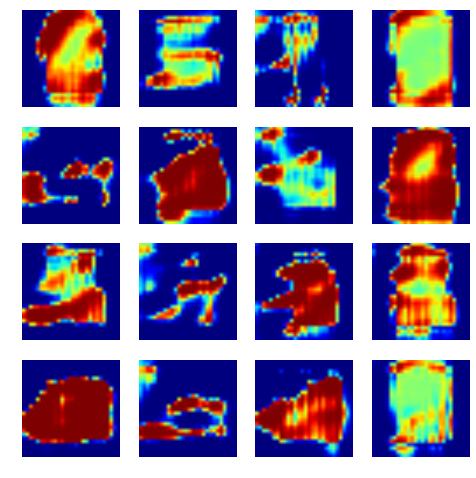

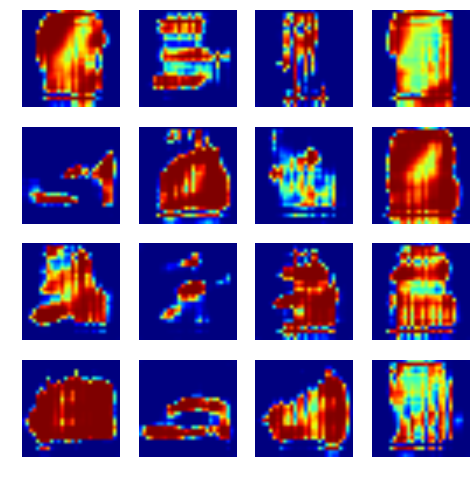

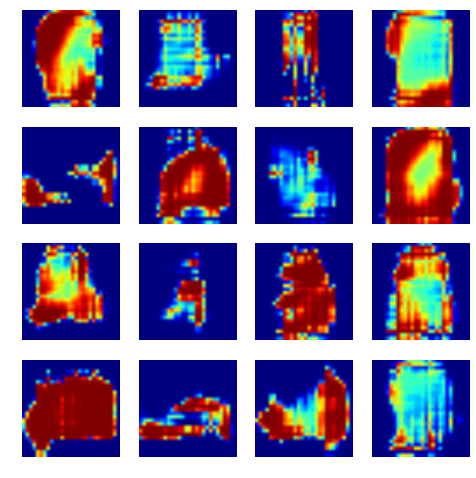

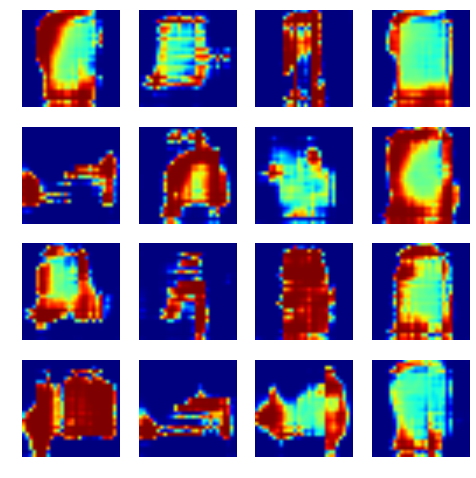

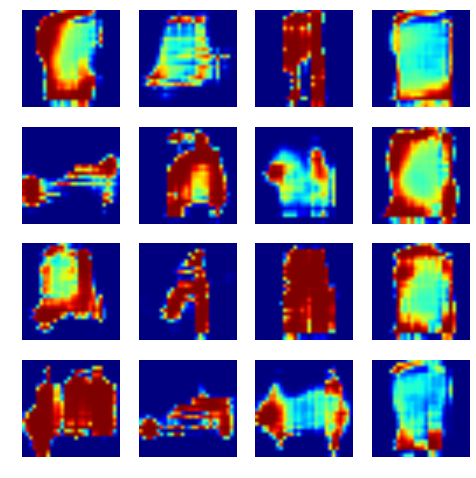

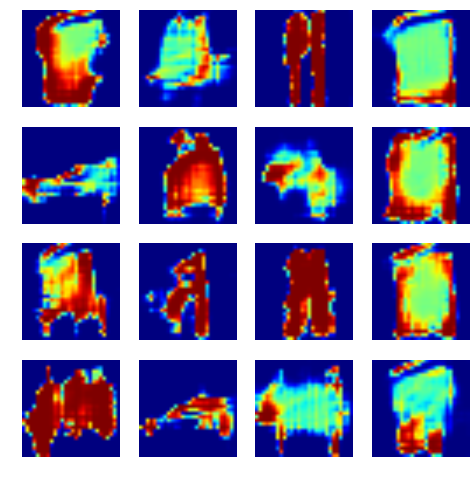

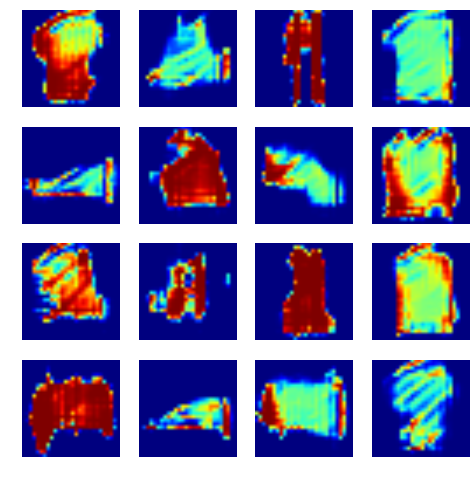

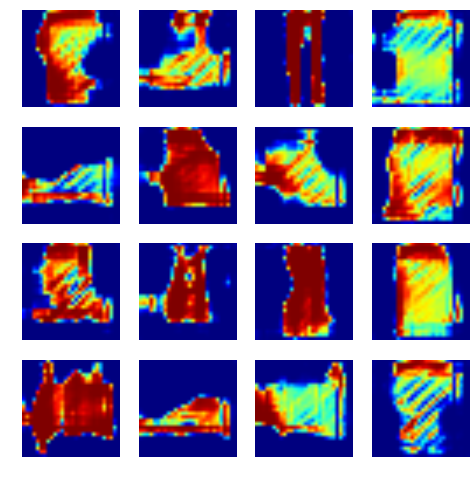

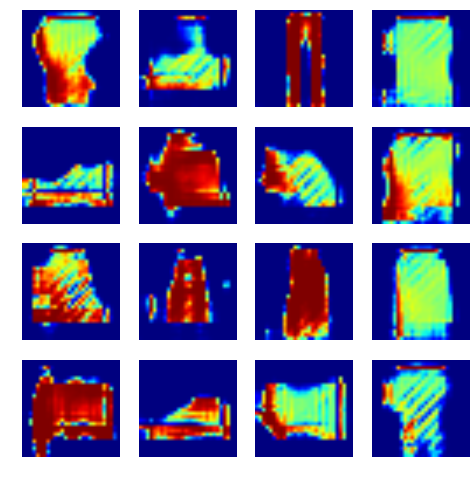

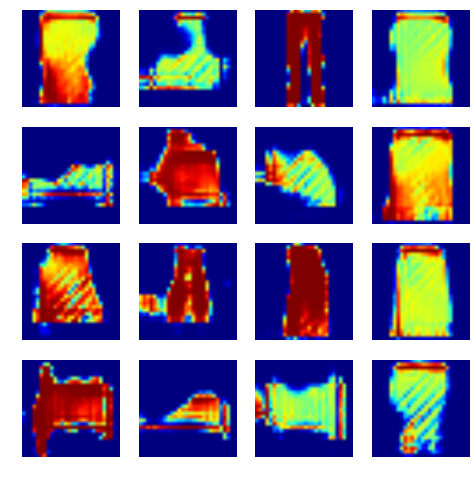

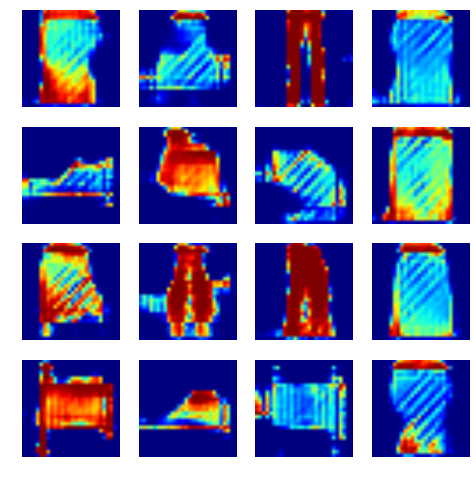

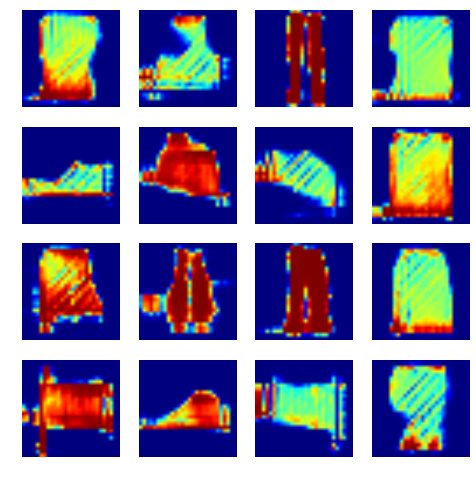

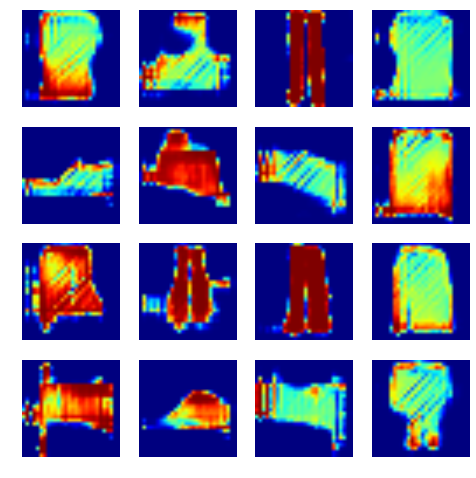

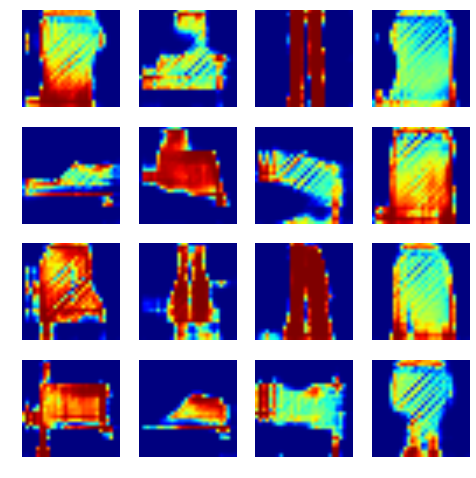

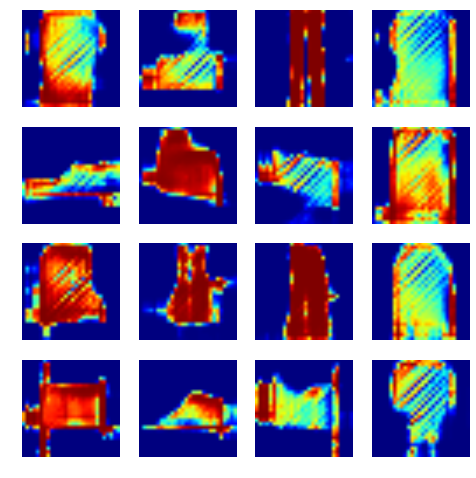

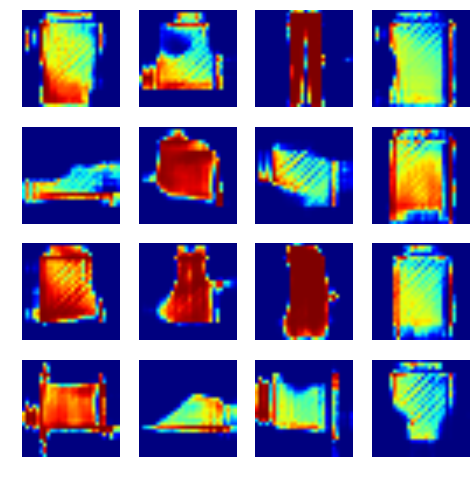

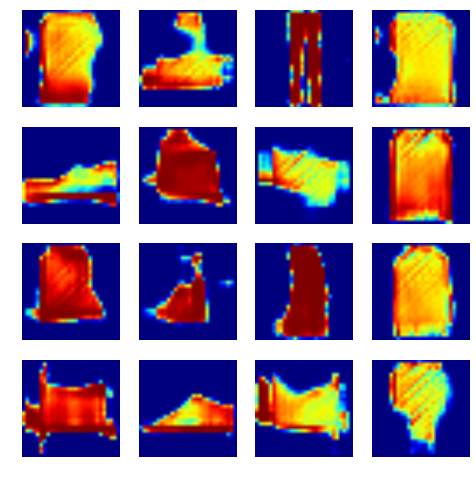

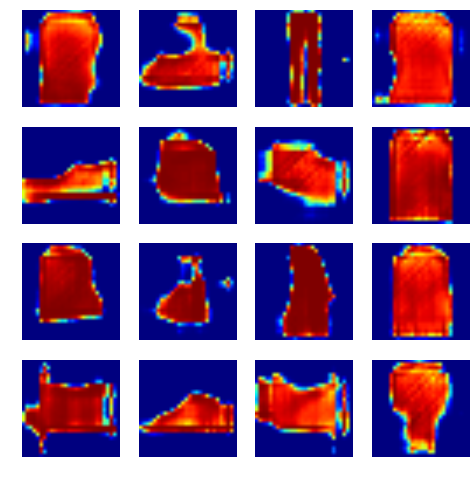

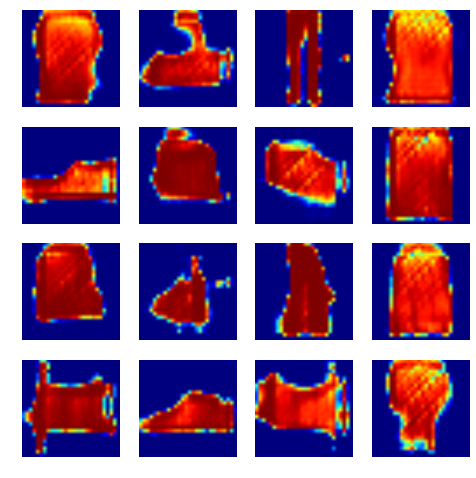

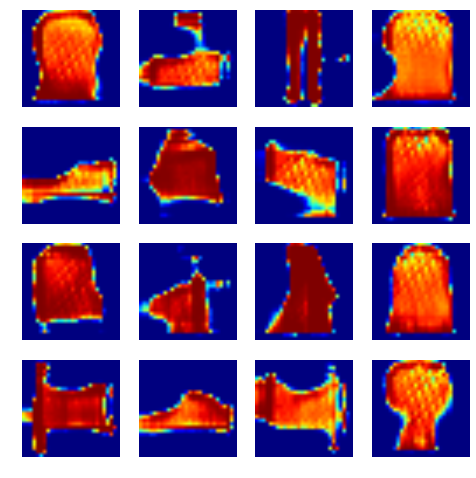

In [31]:
np.random.seed(seed)

epochs = 2000
batch_size = 256
plot_interval = 100

retrain_discriminator = True

def plot_img(i_w, synthetic_images, i, j):
    pyplot.figure(figsize=(i_w, i_w))
    for im in range( synthetic_images.shape[0] ):
        pyplot.subplot(4, 4, im+1)
        synthetic_image = np.reshape(synthetic_images[im, :, :, :], [i, j])
        pyplot.imshow(synthetic_image)
        pyplot.axis("off")

from tqdm import tqdm
for e in tqdm(range(epochs)):
    # stage 1: train the discriminator
    if retrain_discriminator:    
        # select batch_size entries from the train set
        x_train__ = x_train_[np.random.randint(0, x_train_.shape[0], size=batch_size), :, :, :]
        # generate fake instances from random noise
        d_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        images_fake = generator.predict(d_noise)
        d_x = np.concatenate((x_train__, images_fake))
        # create a 2*batch_size array initially set to 1
        d_y = np.ones([2*batch_size, 1])
        # set the second half (fake images) to 0
        d_y[batch_size:, :] = 0
        # train the discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(d_x, d_y)
        print "%d: [Discriminator loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
    
    # stage 2: train the generator-discriminator as adversarial
    input_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    gan_y = np.ones([batch_size, 1])
    discriminator.trainable = False
    ga_loss = gan.train_on_batch(input_noise, gan_y)
    print "%d: [GA loss: %f, acc: %f]" % (e, ga_loss[0], ga_loss[1])
    
    # plot after plot_interval epochs
    if (e+1)%plot_interval == 0:            
        # plot the output images from the test noise
        synthetic_images = generator.predict(test_noise)
        i_w = test_size / 2
        plot_img(i_w, synthetic_images, x_train_.shape[1], x_train_.shape[2])